In [1]:
#Trying to replicate the results of "Adaptive activation functions accelerate convergence in deep and physics-informed neural networks"
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:3


In [2]:
def true_smooth(x): #[-3,3]
    term1 = (np.power(x,3) - x)
    term2 = np.sin(7*x)/7  
    
    term3 = np.sin(12*x)
    term12 = np.multiply(term1,term2)

    return term12  + term3

In [3]:
# Domain bounds
label = "Regr_smooth_unscaled_Swish"
loss_thresh = 0.1

lb = np.array(-3.0)  # [-1. 0.]
ub = np.array(3.0) # [1.  0.99]

x_test = np.linspace(lb,ub,1000).reshape(-1,1)
u_true = true_smooth(x_test)

u_true_norm = np.linalg.norm(u_true,2)

In [4]:
def trainingdata(N_train,seed):
    np.random.seed(seed)
    
    x_train = np.random.uniform(low=lb, high=ub, size=(N_train,)).reshape(-1,1)

    u_train = true_smooth(x_train)

    return x_train, u_train

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Sigmoid()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
     
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        
        self.beta = Parameter(torch.ones((layers[1],len(layers)-2)))
        self.beta.requiresGrad = True
            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = z*self.activation(self.beta[:,i]*z)
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse_loss, test_re_loss  

In [6]:
def data_update(loss_np):
    train_loss.append(loss_np)
    beta_val.append(model_NN.beta.cpu().detach().numpy())
    test_mse, test_re = model_NN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [7]:
def train_step():
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss = model_NN.loss(x_train,u_train)
    loss.backward() #backprop
    optimizer.step()
    
    return loss

In [8]:
def train_model(max_iter,rep):
    print(rep) 
   
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    
    for i in range(max_iter):
        loss_np = train_step().cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1
                
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))

In [9]:
max_reps = 10
max_iter = 5000
layers = np.array([1,50,50,50,50,1])

train_loss_full = []
test_mse_full = []
test_re_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))


for reps in range(max_reps):
    
    train_loss = []
    test_mse_loss = []
    test_re_loss = []
    beta_val = []
    'Generate Training data'
    N_train = 300
    
    x_train_np_array, u_train_np_array = trainingdata(N_train,reps*1234)

    'Convert to tensor and send to GPU'
    x_train = torch.from_numpy(x_train_np_array).float().to(device)
    u_train = torch.from_numpy(u_train_np_array).float().to(device)
    
    x_test_tensor = torch.from_numpy(x_test).float().to(device)
       
     
    model_NN = Sequentialmodel(layers)
    model_NN.to(device)
    print(model_NN)
    params = list(model_NN.parameters())
    #optimizer = optim.Adam(PINN.parameters(), lr=0.0008,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    optimizer = optim.Adam(model_NN.parameters(), lr=0.0008)

    train_model(max_iter,reps)
 
    torch.save(model_NN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    beta_full.append(beta_val)
                 

mdic = {"train_loss": train_loss_full,"test_mse": test_mse_full, "test_re": test_re_full,"Time": elapsed_time, "Thresh_time": time_threshold, "epoch_thresh": epoch_threshold,"beta": beta_full, "label": label}
savemat(label+'.mat', mdic) 

Sequentialmodel(
  (activation): Sigmoid()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 1.4446497 Test MSE 1.3993882551357877 Test RE 0.9987135139589661
1 Train Loss 1.4400275 Test MSE 1.3973340855277683 Test RE 0.997980236273193
2 Train Loss 1.4355953 Test MSE 1.3955245197055666 Test RE 0.9973338282330817
3 Train Loss 1.4313502 Test MSE 1.393974875268192 Test RE 0.9967799353831203
4 Train Loss 1.427297 Test MSE 1.392706124345128 Test RE 0.9963262136622341
5 Train Loss 1.4234457 Test MSE 1.391745750449826 Test RE 0.9959826341083907
6 Train Loss 1.419815 Test MSE 1.391126959748805 Test RE 0.9957611952026313
7 Train Loss 1.416431 Test MSE 1.3908878614583309 Test RE 

109 Train Loss 1.3802515 Test MSE 1.4000431284654669 Test RE 0.9989471711812876
110 Train Loss 1.3790408 Test MSE 1.3992873988570413 Test RE 0.9986775238243017
111 Train Loss 1.3777155 Test MSE 1.3985162309416457 Test RE 0.9984022929446176
112 Train Loss 1.3762622 Test MSE 1.3977137477799422 Test RE 0.9981158050303828
113 Train Loss 1.3746666 Test MSE 1.3968395975375498 Test RE 0.9978036382380162
114 Train Loss 1.3729144 Test MSE 1.3958385684267596 Test RE 0.9974460418809437
115 Train Loss 1.3709898 Test MSE 1.3946589919654215 Test RE 0.9970244986692682
116 Train Loss 1.3688762 Test MSE 1.3932742789178643 Test RE 0.9965294186185087
117 Train Loss 1.366556 Test MSE 1.3916959821362676 Test RE 0.9959648259637772
118 Train Loss 1.364013 Test MSE 1.3899683235558509 Test RE 0.9953464360464842
119 Train Loss 1.3612307 Test MSE 1.3881408198143972 Test RE 0.9946918896101263
120 Train Loss 1.3581934 Test MSE 1.386230033688793 Test RE 0.9940070534797496
121 Train Loss 1.3548877 Test MSE 1.3841938

217 Train Loss 1.245441 Test MSE 1.334497057076478 Test RE 0.9752829331538531
218 Train Loss 1.2449617 Test MSE 1.3341875021041627 Test RE 0.9751698114390162
219 Train Loss 1.2444656 Test MSE 1.3340876667594428 Test RE 0.9751333254745397
220 Train Loss 1.2439497 Test MSE 1.3340208589557332 Test RE 0.9751089090388597
221 Train Loss 1.243414 Test MSE 1.3337511991549813 Test RE 0.9750103494991784
222 Train Loss 1.2428567 Test MSE 1.333338911341064 Test RE 0.9748596407478431
223 Train Loss 1.2422768 Test MSE 1.3330254193688424 Test RE 0.9747450304883762
224 Train Loss 1.2416729 Test MSE 1.332865325924514 Test RE 0.9746864963551889
225 Train Loss 1.241043 Test MSE 1.3326680103173858 Test RE 0.9746143480397123
226 Train Loss 1.2403857 Test MSE 1.3323012512561643 Test RE 0.9744802286502559
227 Train Loss 1.2396988 Test MSE 1.3318820181497126 Test RE 0.9743268975187569
228 Train Loss 1.2389805 Test MSE 1.3315787628297167 Test RE 0.9742159692864486
229 Train Loss 1.2382284 Test MSE 1.3313568240

325 Train Loss 0.8713704 Test MSE 0.9882246526244162 Test RE 0.839266051356638
326 Train Loss 0.87055993 Test MSE 0.9885412013499232 Test RE 0.8394004577018134
327 Train Loss 0.8695699 Test MSE 0.9879630242882633 Test RE 0.8391549479173092
328 Train Loss 0.868837 Test MSE 0.9855288803139768 Test RE 0.8381205551229397
329 Train Loss 0.8679308 Test MSE 0.9849950156992071 Test RE 0.8378935178802902
330 Train Loss 0.8672328 Test MSE 0.9857413933538232 Test RE 0.8382109136856443
331 Train Loss 0.8664274 Test MSE 0.9846047001831042 Test RE 0.837727488996543
332 Train Loss 0.8657355 Test MSE 0.9825521087625911 Test RE 0.8368538341417894
333 Train Loss 0.86502564 Test MSE 0.9827456028037581 Test RE 0.836936230921329
334 Train Loss 0.8643266 Test MSE 0.9833703489868454 Test RE 0.8372022151400076
335 Train Loss 0.86369884 Test MSE 0.9817001633840102 Test RE 0.8364909483654841
336 Train Loss 0.8630027 Test MSE 0.9803864095547754 Test RE 0.8359310467085728
337 Train Loss 0.86241704 Test MSE 0.9810

436 Train Loss 0.7963521 Test MSE 0.904998088231836 Test RE 0.8031481162794324
437 Train Loss 0.7953088 Test MSE 0.9031791790842675 Test RE 0.8023406072710181
438 Train Loss 0.79425275 Test MSE 0.9024320519030907 Test RE 0.8020086828253045
439 Train Loss 0.79318583 Test MSE 0.8997347552215573 Test RE 0.8008092162153774
440 Train Loss 0.7921202 Test MSE 0.9005618543253837 Test RE 0.8011772115783807
441 Train Loss 0.7910856 Test MSE 0.8953874164931428 Test RE 0.7988721984253868
442 Train Loss 0.79017043 Test MSE 0.9003668929566752 Test RE 0.8010904840206251
443 Train Loss 0.78949505 Test MSE 0.8909074882390391 Test RE 0.7968711774690503
444 Train Loss 0.7891433 Test MSE 0.9003040506681462 Test RE 0.8010625269521308
445 Train Loss 0.78851193 Test MSE 0.8874080950438281 Test RE 0.7953046235317885
446 Train Loss 0.787115 Test MSE 0.8936784825935381 Test RE 0.7981094717038448
447 Train Loss 0.7848093 Test MSE 0.8892830518005128 Test RE 0.7961443583550248
448 Train Loss 0.78337866 Test MSE 0.

548 Train Loss 0.67717254 Test MSE 0.7442554799825959 Test RE 0.7283377744189355
549 Train Loss 0.6764179 Test MSE 0.7411090457633035 Test RE 0.7267965737360562
550 Train Loss 0.67562693 Test MSE 0.7417519170007482 Test RE 0.7271117333834938
551 Train Loss 0.67481285 Test MSE 0.7398206423173013 Test RE 0.7261645381732661
552 Train Loss 0.6740209 Test MSE 0.7384776868201798 Test RE 0.7255051556389328
553 Train Loss 0.6732688 Test MSE 0.7387721207610641 Test RE 0.7256497720965751
554 Train Loss 0.67254096 Test MSE 0.7361038477741528 Test RE 0.7243381476461307
555 Train Loss 0.6718146 Test MSE 0.7371380633686522 Test RE 0.7248468115177579
556 Train Loss 0.6710774 Test MSE 0.7342232600041289 Test RE 0.7234122914645617
557 Train Loss 0.67033386 Test MSE 0.734765624400503 Test RE 0.7236794313537138
558 Train Loss 0.6695929 Test MSE 0.732744537374823 Test RE 0.7226834496169436
559 Train Loss 0.66886306 Test MSE 0.7324467713023396 Test RE 0.7225365959266676
560 Train Loss 0.6681479 Test MSE 0.

659 Train Loss 0.6317665 Test MSE 0.6853240104790655 Test RE 0.6989076402019169
660 Train Loss 0.6314852 Test MSE 0.6852373605289113 Test RE 0.6988634550970328
661 Train Loss 0.6312019 Test MSE 0.6845183796834311 Test RE 0.6984967199048486
662 Train Loss 0.6309164 Test MSE 0.6845883864854733 Test RE 0.6985324371864107
663 Train Loss 0.6306281 Test MSE 0.6837400887072244 Test RE 0.6980995148591812
664 Train Loss 0.63033694 Test MSE 0.6838677625294481 Test RE 0.6981646893856428
665 Train Loss 0.6300429 Test MSE 0.6830096816423928 Test RE 0.6977265419463348
666 Train Loss 0.62974596 Test MSE 0.6831119925196512 Test RE 0.6977787976781689
667 Train Loss 0.6294458 Test MSE 0.6822569222828636 Test RE 0.6973419463887449
668 Train Loss 0.6291427 Test MSE 0.6823099390804073 Test RE 0.6973690403744406
669 Train Loss 0.6288364 Test MSE 0.6815037062694543 Test RE 0.696956905099049
670 Train Loss 0.6285271 Test MSE 0.6815176496013484 Test RE 0.6969640348121001
671 Train Loss 0.62821454 Test MSE 0.68

775 Train Loss 0.58489996 Test MSE 0.6330188669219451 Test RE 0.6717074131378399
776 Train Loss 0.5857719 Test MSE 0.6226015501420954 Test RE 0.6661574865369345
777 Train Loss 0.58620733 Test MSE 0.6317629475425978 Test RE 0.6710407432712907
778 Train Loss 0.5847889 Test MSE 0.6235855088841844 Test RE 0.6666836759675517
779 Train Loss 0.5830536 Test MSE 0.6232007834402786 Test RE 0.6664779866574357
780 Train Loss 0.58253145 Test MSE 0.6290539936189543 Test RE 0.6696005105707363
781 Train Loss 0.58293587 Test MSE 0.6203202445915805 Test RE 0.6649359159852826
782 Train Loss 0.58287174 Test MSE 0.6271101514998998 Test RE 0.6685651425712024
783 Train Loss 0.5817033 Test MSE 0.6213313260845784 Test RE 0.6654775964112478
784 Train Loss 0.58049804 Test MSE 0.6203389012522633 Test RE 0.664945915167635
785 Train Loss 0.58008987 Test MSE 0.6250573700909712 Test RE 0.6674700055750618
786 Train Loss 0.58015156 Test MSE 0.6176876760562386 Test RE 0.6635234596318542
787 Train Loss 0.57984865 Test MS

883 Train Loss 0.51534337 Test MSE 0.5396027857809683 Test RE 0.6201673608459882
884 Train Loss 0.5148878 Test MSE 0.5479817123724885 Test RE 0.6249637776932513
885 Train Loss 0.5146675 Test MSE 0.5366032841118942 Test RE 0.6184412899594327
886 Train Loss 0.514879 Test MSE 0.5515224357966331 Test RE 0.6269795939689279
887 Train Loss 0.51562166 Test MSE 0.5344034877485837 Test RE 0.6171723431540885
888 Train Loss 0.5170631 Test MSE 0.5567519886251859 Test RE 0.6299451007680621
889 Train Loss 0.51828027 Test MSE 0.5332289350202252 Test RE 0.6164937358607308
890 Train Loss 0.51829034 Test MSE 0.5520304142685607 Test RE 0.6272682665709367
891 Train Loss 0.5150046 Test MSE 0.5313985774811263 Test RE 0.6154347404778091
892 Train Loss 0.51023763 Test MSE 0.5357911890535166 Test RE 0.6179731384459312
893 Train Loss 0.50694567 Test MSE 0.5379194005485094 Test RE 0.619199244949491
894 Train Loss 0.5069603 Test MSE 0.5284853980999945 Test RE 0.613745485175054
895 Train Loss 0.50868183 Test MSE 0.

993 Train Loss 0.4441207 Test MSE 0.46332866030535147 Test RE 0.5746671828747077
994 Train Loss 0.44373354 Test MSE 0.4629353669737985 Test RE 0.5744232299607549
995 Train Loss 0.44335318 Test MSE 0.4621757723920687 Test RE 0.5739517733215522
996 Train Loss 0.44297877 Test MSE 0.4623453533269924 Test RE 0.5740570604845812
997 Train Loss 0.44261044 Test MSE 0.4609992525312798 Test RE 0.573220778763172
998 Train Loss 0.44224977 Test MSE 0.4618935994664554 Test RE 0.5737765387163216
999 Train Loss 0.44190013 Test MSE 0.45969334936772904 Test RE 0.5724083027037765
1000 Train Loss 0.44156888 Test MSE 0.46178161111090144 Test RE 0.5737069770397953
1001 Train Loss 0.44127026 Test MSE 0.45812052988168955 Test RE 0.5714282294296398
1002 Train Loss 0.4410347 Test MSE 0.46252930014299876 Test RE 0.5741712451160661
1003 Train Loss 0.44092363 Test MSE 0.45613416453221023 Test RE 0.5701880554820972
1004 Train Loss 0.44106808 Test MSE 0.4656654007344896 Test RE 0.5761144915443411
1005 Train Loss 0.44

1109 Train Loss 0.41538706 Test MSE 0.42910943340907187 Test RE 0.5530391103197163
1110 Train Loss 0.41518974 Test MSE 0.42908358957482184 Test RE 0.5530224562156648
1111 Train Loss 0.4149927 Test MSE 0.4286367475216209 Test RE 0.5527344260222814
1112 Train Loss 0.41479594 Test MSE 0.42860329915833395 Test RE 0.552712859482922
1113 Train Loss 0.41459963 Test MSE 0.42817147875759487 Test RE 0.5524343585529371
1114 Train Loss 0.4144036 Test MSE 0.42811946733231016 Test RE 0.5524008045069374
1115 Train Loss 0.41420788 Test MSE 0.427713256825941 Test RE 0.5521386764330384
1116 Train Loss 0.41401255 Test MSE 0.4276386565905675 Test RE 0.5520905232945053
1117 Train Loss 0.4138176 Test MSE 0.42725242166146077 Test RE 0.5518411482550971
1118 Train Loss 0.41362318 Test MSE 0.4271596133127125 Test RE 0.551781209159706
1119 Train Loss 0.4134291 Test MSE 0.42679793180411624 Test RE 0.5515475595867644
1120 Train Loss 0.4132354 Test MSE 0.4266814965157196 Test RE 0.5514723202581098
1121 Train Loss 0

1223 Train Loss 0.39753652 Test MSE 0.40768472588260807 Test RE 0.5390561864341659
1224 Train Loss 0.39740565 Test MSE 0.4080883454001008 Test RE 0.5393229609288704
1225 Train Loss 0.3972727 Test MSE 0.40774245088367583 Test RE 0.5390943481747925
1226 Train Loss 0.39714214 Test MSE 0.4074014977610716 Test RE 0.5388689064265006
1227 Train Loss 0.3970148 Test MSE 0.4077070355445702 Test RE 0.5390709355724247
1228 Train Loss 0.39688826 Test MSE 0.4070347040766895 Test RE 0.538626273273643
1229 Train Loss 0.39676076 Test MSE 0.4073265967378809 Test RE 0.5388193684547621
1230 Train Loss 0.39663225 Test MSE 0.40689563022265374 Test RE 0.5385342476666328
1231 Train Loss 0.39650282 Test MSE 0.4068671467687838 Test RE 0.5385153981353085
1232 Train Loss 0.39637426 Test MSE 0.40674068826498944 Test RE 0.5384317035627485
1233 Train Loss 0.39624727 Test MSE 0.40644903869435633 Test RE 0.5382386302612417
1234 Train Loss 0.39612162 Test MSE 0.4065641689836538 Test RE 0.5383148552928199
1235 Train Los

1337 Train Loss 0.38506797 Test MSE 0.3968592798856433 Test RE 0.5318511274312524
1338 Train Loss 0.38530308 Test MSE 0.39150990371094896 Test RE 0.5282544819238564
1339 Train Loss 0.38514176 Test MSE 0.3945836654044128 Test RE 0.5303241024291715
1340 Train Loss 0.38472745 Test MSE 0.39391718448047514 Test RE 0.5298760348758004
1341 Train Loss 0.3845439 Test MSE 0.3916918090061013 Test RE 0.5283771877959319
1342 Train Loss 0.38465598 Test MSE 0.3955418038017368 Test RE 0.5309675854773702
1343 Train Loss 0.38469657 Test MSE 0.3917030988290617 Test RE 0.5283848025095732
1344 Train Loss 0.38447174 Test MSE 0.39343281026089005 Test RE 0.529550157700962
1345 Train Loss 0.38420293 Test MSE 0.39361164863862735 Test RE 0.5296704998902582
1346 Train Loss 0.38413408 Test MSE 0.3914711283399762 Test RE 0.5282283219589307
1347 Train Loss 0.3841852 Test MSE 0.39442210115393356 Test RE 0.5302155193882349
1348 Train Loss 0.38412744 Test MSE 0.3915765392482004 Test RE 0.528299434839744
1349 Train Loss

1445 Train Loss 0.37647244 Test MSE 0.38398941769704276 Test RE 0.5231562789879199
1446 Train Loss 0.37640387 Test MSE 0.3839157507541638 Test RE 0.5231060937868068
1447 Train Loss 0.37633526 Test MSE 0.38382753472244585 Test RE 0.5230459907630991
1448 Train Loss 0.37626657 Test MSE 0.3837520431952819 Test RE 0.522994551667736
1449 Train Loss 0.37619835 Test MSE 0.3836647493952273 Test RE 0.5229350643252993
1450 Train Loss 0.37613016 Test MSE 0.38358922997387196 Test RE 0.5228835953056964
1451 Train Loss 0.37606212 Test MSE 0.3835022252968758 Test RE 0.5228242924177087
1452 Train Loss 0.37599406 Test MSE 0.3834267124071737 Test RE 0.5227728169448834
1453 Train Loss 0.37592626 Test MSE 0.3833398512294661 Test RE 0.5227135993250807
1454 Train Loss 0.37585863 Test MSE 0.3832645897894515 Test RE 0.5226622844028433
1455 Train Loss 0.37579113 Test MSE 0.3831773860581989 Test RE 0.5226028206596789
1456 Train Loss 0.37572357 Test MSE 0.3831030644463357 Test RE 0.5225521358215466
1457 Train Los

1554 Train Loss 0.37038663 Test MSE 0.37573798391607327 Test RE 0.5175047788329105
1555 Train Loss 0.3703446 Test MSE 0.3767629731237017 Test RE 0.5182101580852533
1556 Train Loss 0.3702869 Test MSE 0.3761876249431329 Test RE 0.5178143320549883
1557 Train Loss 0.37022728 Test MSE 0.37574526829940624 Test RE 0.5175097952074541
1558 Train Loss 0.37018713 Test MSE 0.3766472183030462 Test RE 0.518130545787472
1559 Train Loss 0.3701451 Test MSE 0.37569998380965436 Test RE 0.517478609354785
1560 Train Loss 0.37008837 Test MSE 0.37592370948178655 Test RE 0.5176326631534944
1561 Train Loss 0.37003508 Test MSE 0.37620095455528385 Test RE 0.5178235059387276
1562 Train Loss 0.36998954 Test MSE 0.37550082353981246 Test RE 0.5173414322908514
1563 Train Loss 0.36994416 Test MSE 0.3759767695310797 Test RE 0.5176691927003603
1564 Train Loss 0.36989546 Test MSE 0.37567792155651014 Test RE 0.5174634151676947
1565 Train Loss 0.36984244 Test MSE 0.3755428705519119 Test RE 0.517370396345243
1566 Train Loss

1668 Train Loss 0.36498806 Test MSE 0.36911743203283326 Test RE 0.5129252657010206
1669 Train Loss 0.36494035 Test MSE 0.3690543229863173 Test RE 0.5128814156883031
1670 Train Loss 0.36489278 Test MSE 0.36899437792072415 Test RE 0.5128397606300255
1671 Train Loss 0.36484516 Test MSE 0.3689281006117623 Test RE 0.5127937014381985
1672 Train Loss 0.36479747 Test MSE 0.3688703753016523 Test RE 0.5127535820580456
1673 Train Loss 0.3647497 Test MSE 0.3688035378125987 Test RE 0.512707125746012
1674 Train Loss 0.3647019 Test MSE 0.368744680129501 Test RE 0.5126662124215522
1675 Train Loss 0.3646541 Test MSE 0.3686798827039115 Test RE 0.5126211664696553
1676 Train Loss 0.3646063 Test MSE 0.3686189932876115 Test RE 0.5125788336845805
1677 Train Loss 0.36455822 Test MSE 0.3685553453869852 Test RE 0.5125345793519606
1678 Train Loss 0.36451027 Test MSE 0.3684939633020692 Test RE 0.5124918968193478
1679 Train Loss 0.36446238 Test MSE 0.3684302163885188 Test RE 0.512447566120708
1680 Train Loss 0.364

1781 Train Loss 0.35966995 Test MSE 0.3602095221774087 Test RE 0.5066982552218477
1782 Train Loss 0.35995203 Test MSE 0.3641354772999681 Test RE 0.5094520464288728
1783 Train Loss 0.3598226 Test MSE 0.36199886791164265 Test RE 0.5079552114296564
1784 Train Loss 0.35944393 Test MSE 0.360875743078701 Test RE 0.5071666173878149
1785 Train Loss 0.35947064 Test MSE 0.36393526080800687 Test RE 0.5093119684458043
1786 Train Loss 0.3596542 Test MSE 0.3609462602903674 Test RE 0.5072161666155518
1787 Train Loss 0.3594482 Test MSE 0.3619081885795761 Test RE 0.5078915870260113
1788 Train Loss 0.35920122 Test MSE 0.3628530095452678 Test RE 0.5085541222356115
1789 Train Loss 0.3592933 Test MSE 0.36058457910793706 Test RE 0.5069619784688213
1790 Train Loss 0.3593419 Test MSE 0.36274142708008467 Test RE 0.5084759224076572
1791 Train Loss 0.3591392 Test MSE 0.36153954284919027 Test RE 0.5076328476900518
1792 Train Loss 0.3590187 Test MSE 0.3607577461582589 Test RE 0.5070836955056794
1793 Train Loss 0.3

1894 Train Loss 0.35312644 Test MSE 0.35540381620824496 Test RE 0.5033068690364123
1895 Train Loss 0.35305905 Test MSE 0.3553527102289534 Test RE 0.5032706807429762
1896 Train Loss 0.3529914 Test MSE 0.35527852750988503 Test RE 0.5032181471121698
1897 Train Loss 0.35292366 Test MSE 0.35521886545844994 Test RE 0.5031758925355467
1898 Train Loss 0.35285538 Test MSE 0.3551567625754192 Test RE 0.5031319055143652
1899 Train Loss 0.3527871 Test MSE 0.355084244578298 Test RE 0.5030805366758714
1900 Train Loss 0.35271868 Test MSE 0.35503187201192893 Test RE 0.5030434347897771
1901 Train Loss 0.35264984 Test MSE 0.3549552789097094 Test RE 0.5029891696117177
1902 Train Loss 0.35258102 Test MSE 0.3548997751582398 Test RE 0.5029498422950521
1903 Train Loss 0.35251182 Test MSE 0.3548318280942201 Test RE 0.5029016940524081
1904 Train Loss 0.35244247 Test MSE 0.3547649259475173 Test RE 0.5028542817484436
1905 Train Loss 0.35237285 Test MSE 0.3547071582677927 Test RE 0.5028133392741523
1906 Train Loss

2009 Train Loss 0.3795112 Test MSE 0.3647367194483788 Test RE 0.50987246372933
2010 Train Loss 0.35413456 Test MSE 0.35449106649481427 Test RE 0.5026601560400847
2011 Train Loss 0.34610668 Test MSE 0.34697543142482773 Test RE 0.49730311139518996
2012 Train Loss 0.36046997 Test MSE 0.3850106028631055 Test RE 0.5238514605322132
2013 Train Loss 0.36712137 Test MSE 0.3461192240780379 Test RE 0.4966891521065127
2014 Train Loss 0.35263494 Test MSE 0.3450927871141922 Test RE 0.49595212479531414
2015 Train Loss 0.3452265 Test MSE 0.3693055014384112 Test RE 0.5130559196027596
2016 Train Loss 0.35450327 Test MSE 0.3455912683448389 Test RE 0.4963101931493424
2017 Train Loss 0.35650966 Test MSE 0.35519935216313464 Test RE 0.5031620718244486
2018 Train Loss 0.34731779 Test MSE 0.3546534813573256 Test RE 0.5027752931181846
2019 Train Loss 0.3458462 Test MSE 0.3434774071458585 Test RE 0.49478998680541325
2020 Train Loss 0.35129273 Test MSE 0.36082876256221086 Test RE 0.5071336036349992
2021 Train Los

2121 Train Loss 0.33315587 Test MSE 0.3391093331683252 Test RE 0.4916337462153498
2122 Train Loss 0.33303222 Test MSE 0.33901486463986463 Test RE 0.49156526217934443
2123 Train Loss 0.33290797 Test MSE 0.3388727869094723 Test RE 0.49146224634881613
2124 Train Loss 0.33278316 Test MSE 0.33880685676095823 Test RE 0.4914144352581716
2125 Train Loss 0.33265778 Test MSE 0.3386556781385007 Test RE 0.4913047862869209
2126 Train Loss 0.33253145 Test MSE 0.33858860688167364 Test RE 0.49125613205880714
2127 Train Loss 0.3324047 Test MSE 0.3384501551341641 Test RE 0.4911556823936344
2128 Train Loss 0.33227718 Test MSE 0.33833644052247147 Test RE 0.49107316467428047
2129 Train Loss 0.33214906 Test MSE 0.33826831400448204 Test RE 0.4910237215977191
2130 Train Loss 0.33202022 Test MSE 0.3380877568065357 Test RE 0.49089265744318045
2131 Train Loss 0.33189088 Test MSE 0.33803422481368783 Test RE 0.4908537925301549
2132 Train Loss 0.33176053 Test MSE 0.3379009146004841 Test RE 0.49075699423035635
2133 

2233 Train Loss 0.31539983 Test MSE 0.322938192373485 Test RE 0.4797682668720855
2234 Train Loss 0.31521836 Test MSE 0.3228489607252822 Test RE 0.4797019794649421
2235 Train Loss 0.31503692 Test MSE 0.3225818738152757 Test RE 0.47950351416965903
2236 Train Loss 0.31485552 Test MSE 0.3225503953603874 Test RE 0.47948011794189127
2237 Train Loss 0.31467435 Test MSE 0.3222053648157647 Test RE 0.47922360058272473
2238 Train Loss 0.3144935 Test MSE 0.3222838742359465 Test RE 0.4792819814781749
2239 Train Loss 0.31431323 Test MSE 0.32178813324200223 Test RE 0.47891322091501887
2240 Train Loss 0.31413388 Test MSE 0.3220831622961087 Test RE 0.4791327146266881
2241 Train Loss 0.31395662 Test MSE 0.32129145470682813 Test RE 0.4785434779854251
2242 Train Loss 0.31378293 Test MSE 0.32202498741908125 Test RE 0.47908944203631065
2243 Train Loss 0.31361684 Test MSE 0.32064188189979903 Test RE 0.47805948424727474
2244 Train Loss 0.31346577 Test MSE 0.32229718960290477 Test RE 0.4792918822986227
2245 Tr

2341 Train Loss 0.30046913 Test MSE 0.3099559783896455 Test RE 0.4700259359540068
2342 Train Loss 0.3003569 Test MSE 0.31018282236447536 Test RE 0.47019790077803436
2343 Train Loss 0.3002449 Test MSE 0.309720862888592 Test RE 0.46984763426623816
2344 Train Loss 0.30013087 Test MSE 0.3098895020159947 Test RE 0.46997552993280184
2345 Train Loss 0.30001634 Test MSE 0.3097448382901086 Test RE 0.46986581929837584
2346 Train Loss 0.2999041 Test MSE 0.3095043632367178 Test RE 0.469683390193682
2347 Train Loss 0.29979327 Test MSE 0.3096818831549179 Test RE 0.46981806713963625
2348 Train Loss 0.29968202 Test MSE 0.3093303875223645 Test RE 0.4695513646081435
2349 Train Loss 0.2995695 Test MSE 0.30938424967149075 Test RE 0.46959224314091663
2350 Train Loss 0.29945746 Test MSE 0.3093104320207253 Test RE 0.4695362185304701
2351 Train Loss 0.29934734 Test MSE 0.3090716367536727 Test RE 0.46935493677615964
2352 Train Loss 0.2992382 Test MSE 0.3091911669642003 Test RE 0.4694456870498162
2353 Train Los

2453 Train Loss 0.28981197 Test MSE 0.3012561192901097 Test RE 0.4633826329095665
2454 Train Loss 0.28988478 Test MSE 0.30221715393285625 Test RE 0.46412116092882627
2455 Train Loss 0.28976345 Test MSE 0.3015474510812882 Test RE 0.4636066374390498
2456 Train Loss 0.28954518 Test MSE 0.3008553942095014 Test RE 0.4630743390324788
2457 Train Loss 0.28948784 Test MSE 0.3024503855008668 Test RE 0.4643002156716159
2458 Train Loss 0.28950587 Test MSE 0.30059382505357807 Test RE 0.46287299262976717
2459 Train Loss 0.2893938 Test MSE 0.3016009033454809 Test RE 0.46364772504617907
2460 Train Loss 0.28922424 Test MSE 0.30138225941342234 Test RE 0.4634796351302983
2461 Train Loss 0.28916353 Test MSE 0.30074270143860016 Test RE 0.4629876029806676
2462 Train Loss 0.28915003 Test MSE 0.3015356488601168 Test RE 0.463597564834405
2463 Train Loss 0.28905 Test MSE 0.30090948967154607 Test RE 0.46311596882352174
2464 Train Loss 0.28891316 Test MSE 0.3006601120728621 Test RE 0.4629240262457158
2465 Train L

2566 Train Loss 0.28248897 Test MSE 0.2954127346334418 Test RE 0.45886657174892725
2567 Train Loss 0.28243884 Test MSE 0.2949813266708808 Test RE 0.4585313949014455
2568 Train Loss 0.2823921 Test MSE 0.2954635082060571 Test RE 0.458906003519239
2569 Train Loss 0.28234178 Test MSE 0.2948632971688601 Test RE 0.4584396507093396
2570 Train Loss 0.2822848 Test MSE 0.29525618259603037 Test RE 0.4587449689740182
2571 Train Loss 0.28222406 Test MSE 0.29492757762870647 Test RE 0.45848961811112554
2572 Train Loss 0.28216428 Test MSE 0.2949332017257104 Test RE 0.45849398965517607
2573 Train Loss 0.282109 Test MSE 0.2950325648441207 Test RE 0.4585712165592481
2574 Train Loss 0.2820579 Test MSE 0.2946819150001815 Test RE 0.45829862676632227
2575 Train Loss 0.28200778 Test MSE 0.2950166051385746 Test RE 0.4585588132495151
2576 Train Loss 0.28195578 Test MSE 0.2945750370633029 Test RE 0.4582155092566851
2577 Train Loss 0.2819007 Test MSE 0.294838487736373 Test RE 0.4584203640315407
2578 Train Loss 0.

2678 Train Loss 0.28362745 Test MSE 0.2928979386943945 Test RE 0.4569092726556988
2679 Train Loss 0.27853614 Test MSE 0.2873223981389923 Test RE 0.45253956547768115
2680 Train Loss 0.27892604 Test MSE 0.300140216504074 Test RE 0.46252361350105287
2681 Train Loss 0.28372762 Test MSE 0.29421090874815853 Test RE 0.4579322183911657
2682 Train Loss 0.28706762 Test MSE 0.30041077116410264 Test RE 0.462732032306894
2683 Train Loss 0.28492138 Test MSE 0.2888411314637886 Test RE 0.4537340095894459
2684 Train Loss 0.27934712 Test MSE 0.29091423237515224 Test RE 0.4553593920365135
2685 Train Loss 0.27692062 Test MSE 0.2917300992754431 Test RE 0.4559974710695143
2686 Train Loss 0.27878278 Test MSE 0.29040320631015626 Test RE 0.45495926929607083
2687 Train Loss 0.2810438 Test MSE 0.2979421229954843 Test RE 0.4608268425355527
2688 Train Loss 0.28128916 Test MSE 0.28700263080040617 Test RE 0.4522876748179039
2689 Train Loss 0.2797639 Test MSE 0.2937762566546074 Test RE 0.45759383058980935
2690 Train 

2790 Train Loss 0.27260455 Test MSE 0.2849940882979289 Test RE 0.4507022642706841
2791 Train Loss 0.2725684 Test MSE 0.2849096742489247 Test RE 0.4506355112708168
2792 Train Loss 0.27253228 Test MSE 0.2849150286911506 Test RE 0.4506397457540435
2793 Train Loss 0.2724962 Test MSE 0.28482515364508515 Test RE 0.4505686641010678
2794 Train Loss 0.27246004 Test MSE 0.284838298446958 Test RE 0.45057906094876987
2795 Train Loss 0.27242404 Test MSE 0.2847449828340649 Test RE 0.4505052480070226
2796 Train Loss 0.2723879 Test MSE 0.28475174934723363 Test RE 0.4505106007467853
2797 Train Loss 0.272352 Test MSE 0.28467735481164336 Test RE 0.4504517464704565
2798 Train Loss 0.2723161 Test MSE 0.2846547765083288 Test RE 0.45043388302319665
2799 Train Loss 0.27228022 Test MSE 0.28461372918745453 Test RE 0.4504014054885881
2800 Train Loss 0.27224442 Test MSE 0.2845618662921897 Test RE 0.45036036708678595
2801 Train Loss 0.27220878 Test MSE 0.284541107138711 Test RE 0.45034393960369357
2802 Train Loss 

2902 Train Loss 0.26906142 Test MSE 0.2809063804211297 Test RE 0.44745834921008404
2903 Train Loss 0.26898935 Test MSE 0.28096199504638053 Test RE 0.4475026415411795
2904 Train Loss 0.26892853 Test MSE 0.28055388868371156 Test RE 0.44717751742250034
2905 Train Loss 0.26890224 Test MSE 0.28105014351964314 Test RE 0.44757283534289055
2906 Train Loss 0.26889813 Test MSE 0.2805426449661322 Test RE 0.44716855659840643
2907 Train Loss 0.26888672 Test MSE 0.2808606453910111 Test RE 0.4474219218528907
2908 Train Loss 0.26885077 Test MSE 0.2806380489308745 Test RE 0.447244584303301
2909 Train Loss 0.2687974 Test MSE 0.2805489081869321 Test RE 0.4471735481742389
2910 Train Loss 0.26874885 Test MSE 0.280703115642693 Test RE 0.44729642874851083
2911 Train Loss 0.26871908 Test MSE 0.280390783541003 Test RE 0.447047511103521
2912 Train Loss 0.26870337 Test MSE 0.28066758135229625 Test RE 0.44726811615888035
2913 Train Loss 0.2686864 Test MSE 0.28038041004507486 Test RE 0.44703924141581813
2914 Train

3014 Train Loss 0.26580045 Test MSE 0.2770991010108315 Test RE 0.4444156791484915
3015 Train Loss 0.2657734 Test MSE 0.27717316424889754 Test RE 0.44447506704444995
3016 Train Loss 0.26574597 Test MSE 0.27701129776454125 Test RE 0.44434526349070735
3017 Train Loss 0.26571885 Test MSE 0.27713907411887945 Test RE 0.4444477327265769
3018 Train Loss 0.26569197 Test MSE 0.2769098064661831 Test RE 0.44426385650567873
3019 Train Loss 0.26566517 Test MSE 0.2771254464116869 Test RE 0.444436805220157
3020 Train Loss 0.26563936 Test MSE 0.276785378889099 Test RE 0.4441640317881502
3021 Train Loss 0.26561433 Test MSE 0.2771479054239203 Test RE 0.4444548140489175
3022 Train Loss 0.26559064 Test MSE 0.27662442884743316 Test RE 0.44403487284324866
3023 Train Loss 0.2655698 Test MSE 0.27723668813521524 Test RE 0.44452599759926353
3024 Train Loss 0.26555312 Test MSE 0.27640519238531724 Test RE 0.44385887983559913
3025 Train Loss 0.26554367 Test MSE 0.2774540642453762 Test RE 0.44470023571865136
3026 Tr

3124 Train Loss 0.2631334 Test MSE 0.27408439938217144 Test RE 0.441991556039383
3125 Train Loss 0.26311088 Test MSE 0.2738257418970381 Test RE 0.4417829498404557
3126 Train Loss 0.2630867 Test MSE 0.2739606699318113 Test RE 0.44189178103273175
3127 Train Loss 0.2630624 Test MSE 0.2738707594951885 Test RE 0.4418192634277505
3128 Train Loss 0.2630385 Test MSE 0.2738167260197712 Test RE 0.4417756767959028
3129 Train Loss 0.26301438 Test MSE 0.27385430233456326 Test RE 0.4418059885534376
3130 Train Loss 0.2629899 Test MSE 0.27376576336259595 Test RE 0.4417345633285724
3131 Train Loss 0.26296586 Test MSE 0.2737687150208214 Test RE 0.44173694464522584
3132 Train Loss 0.2629429 Test MSE 0.27373161039834154 Test RE 0.44170700872291907
3133 Train Loss 0.2629198 Test MSE 0.27371669201142285 Test RE 0.4416949720315109
3134 Train Loss 0.26289585 Test MSE 0.27364809173911947 Test RE 0.4416396186405987
3135 Train Loss 0.26287144 Test MSE 0.2736922215216462 Test RE 0.44167522764946227
3136 Train Los

3234 Train Loss 0.26651004 Test MSE 0.284661811670401 Test RE 0.4504394491616425
3235 Train Loss 0.27075335 Test MSE 0.2792335422448688 Test RE 0.44612402007769497
3236 Train Loss 0.27681974 Test MSE 0.29994729574371715 Test RE 0.4623749417377698
3237 Train Loss 0.2851173 Test MSE 0.2896687080003927 Test RE 0.4543835553036295
3238 Train Loss 0.29126418 Test MSE 0.3069925611257271 Test RE 0.46777363508045416
3239 Train Loss 0.29232803 Test MSE 0.28283979626671035 Test RE 0.4489955865453235
3240 Train Loss 0.28185573 Test MSE 0.28044226200885214 Test RE 0.4470885471612125
3241 Train Loss 0.26793224 Test MSE 0.2705694107305125 Test RE 0.43914825573465616
3242 Train Loss 0.26056966 Test MSE 0.2706042877002335 Test RE 0.43917655839244246
3243 Train Loss 0.26441965 Test MSE 0.28642146444668076 Test RE 0.45182951250105857
3244 Train Loss 0.27265424 Test MSE 0.2779407996765473 Test RE 0.4450901318173423
3245 Train Loss 0.2747301 Test MSE 0.28152269536992525 Test RE 0.4479489471284827
3246 Trai

3344 Train Loss 0.25816637 Test MSE 0.26797308029810507 Test RE 0.43703618696632957
3345 Train Loss 0.25814438 Test MSE 0.26802125391159975 Test RE 0.4370754682743847
3346 Train Loss 0.25812215 Test MSE 0.2679530177892808 Test RE 0.43701982672883005
3347 Train Loss 0.25810012 Test MSE 0.2679304026644718 Test RE 0.43700138419261314
3348 Train Loss 0.25807792 Test MSE 0.26793577260674806 Test RE 0.4370057634277175
3349 Train Loss 0.25805613 Test MSE 0.26785292886507317 Test RE 0.4369381987440331
3350 Train Loss 0.25803426 Test MSE 0.2678933204296867 Test RE 0.43697114210640287
3351 Train Loss 0.2580123 Test MSE 0.26780440034661684 Test RE 0.43689861559661125
3352 Train Loss 0.25799006 Test MSE 0.26782271472253305 Test RE 0.4369135544637048
3353 Train Loss 0.25796783 Test MSE 0.2677751877635737 Test RE 0.436874786105492
3354 Train Loss 0.257946 Test MSE 0.2677441842046664 Test RE 0.4368494942452576
3355 Train Loss 0.25792396 Test MSE 0.2677434468299314 Test RE 0.436848892697174
3356 Train

3459 Train Loss 0.27417114 Test MSE 0.2812329110716213 Test RE 0.44771834051106546
3460 Train Loss 0.28273332 Test MSE 0.3048180505049608 Test RE 0.46611400792369645
3461 Train Loss 0.29081234 Test MSE 0.2857355116899199 Test RE 0.45128814335399153
3462 Train Loss 0.28909308 Test MSE 0.29090036138719083 Test RE 0.4553485359847374
3463 Train Loss 0.2776473 Test MSE 0.2663526415687584 Test RE 0.4357127998887749
3464 Train Loss 0.26167643 Test MSE 0.2640285642968052 Test RE 0.4338077148818539
3465 Train Loss 0.2555864 Test MSE 0.2740287597418226 Test RE 0.4419466912104005
3466 Train Loss 0.26193807 Test MSE 0.27204963907032903 Test RE 0.4403478611479124
3467 Train Loss 0.2705584 Test MSE 0.2842339307786772 Test RE 0.45010078955662336
3468 Train Loss 0.2710994 Test MSE 0.2667647509603811 Test RE 0.4360497440499733
3469 Train Loss 0.26238278 Test MSE 0.2656273603124841 Test RE 0.43511917005642314
3470 Train Loss 0.25572398 Test MSE 0.268708129984911 Test RE 0.43763517123958096
3471 Train Lo

3572 Train Loss 0.25449133 Test MSE 0.2617227063777497 Test RE 0.4319092601812725
3573 Train Loss 0.25366777 Test MSE 0.26197617267037776 Test RE 0.4321183516048699
3574 Train Loss 0.25329804 Test MSE 0.2631450060702134 Test RE 0.43308124882173854
3575 Train Loss 0.25351122 Test MSE 0.26142426930719365 Test RE 0.43166294127763444
3576 Train Loss 0.25395036 Test MSE 0.2642811651250637 Test RE 0.4340151810542671
3577 Train Loss 0.2541265 Test MSE 0.2615579239601435 Test RE 0.43177327225145484
3578 Train Loss 0.25387543 Test MSE 0.2626544933901214 Test RE 0.4326774202730986
3579 Train Loss 0.25342867 Test MSE 0.2621829019591587 Test RE 0.4322888134875839
3580 Train Loss 0.25320292 Test MSE 0.2612649496866444 Test RE 0.43153138720011547
3581 Train Loss 0.25331306 Test MSE 0.26336669161176735 Test RE 0.4332636342691445
3582 Train Loss 0.2535209 Test MSE 0.2612317702619949 Test RE 0.43150398509782417
3583 Train Loss 0.2535442 Test MSE 0.26277001104684133 Test RE 0.432772557399168
3584 Train 

3681 Train Loss 0.25159633 Test MSE 0.25900311842376683 Test RE 0.4296593931708891
3682 Train Loss 0.25192577 Test MSE 0.2619329289090548 Test RE 0.43208268577720377
3683 Train Loss 0.25248998 Test MSE 0.2596181725256763 Test RE 0.4301692462436303
3684 Train Loss 0.2534095 Test MSE 0.26493731628198475 Test RE 0.4345536284708629
3685 Train Loss 0.25495058 Test MSE 0.26195107085247105 Test RE 0.43209764892815455
3686 Train Loss 0.25731528 Test MSE 0.2715844063887098 Test RE 0.43997118011895964
3687 Train Loss 0.26103872 Test MSE 0.26789485412213876 Test RE 0.43697239293711065
3688 Train Loss 0.2658386 Test MSE 0.28262128609680254 Test RE 0.44882211545062556
3689 Train Loss 0.27187085 Test MSE 0.2753062193246436 Test RE 0.442975620787898
3690 Train Loss 0.2757941 Test MSE 0.28669052083174723 Test RE 0.45204168074694057
3691 Train Loss 0.27619797 Test MSE 0.2702006011983888 Test RE 0.43884885512610367
3692 Train Loss 0.26900214 Test MSE 0.26870459758620147 Test RE 0.4376322946853903
3693 T

3788 Train Loss 0.24890277 Test MSE 0.2565890279599496 Test RE 0.4276523422077322
3789 Train Loss 0.2488816 Test MSE 0.2565971227680259 Test RE 0.4276590878904272
3790 Train Loss 0.24886063 Test MSE 0.25656165428302086 Test RE 0.4276295299905031
3791 Train Loss 0.24883983 Test MSE 0.256523251374801 Test RE 0.42759752436554765
3792 Train Loss 0.24881938 Test MSE 0.25653300540293444 Test RE 0.42760565376242154
3793 Train Loss 0.24879879 Test MSE 0.25645601040999677 Test RE 0.4275414788524551
3794 Train Loss 0.24877839 Test MSE 0.256493922750276 Test RE 0.4275730797866529
3795 Train Loss 0.2487582 Test MSE 0.25639934819902643 Test RE 0.4274942450526032
3796 Train Loss 0.24873754 Test MSE 0.25644265933561894 Test RE 0.4275303498241905
3797 Train Loss 0.2487167 Test MSE 0.2563522092809875 Test RE 0.42745494592289995
3798 Train Loss 0.24869598 Test MSE 0.2563829213056874 Test RE 0.42748055056606
3799 Train Loss 0.24867521 Test MSE 0.25631113678087086 Test RE 0.42742070134461274
3800 Train Lo

3901 Train Loss 0.24690124 Test MSE 0.2559470783432375 Test RE 0.4271170442175562
3902 Train Loss 0.24763513 Test MSE 0.25358413197247054 Test RE 0.42514086442806714
3903 Train Loss 0.24792527 Test MSE 0.25536178426004663 Test RE 0.4266284038286147
3904 Train Loss 0.2474391 Test MSE 0.25360241909768394 Test RE 0.4251561935892415
3905 Train Loss 0.24676357 Test MSE 0.25326267721745216 Test RE 0.42487131504999126
3906 Train Loss 0.24661057 Test MSE 0.2549247907323876 Test RE 0.426263208856675
3907 Train Loss 0.24696663 Test MSE 0.2531694496331903 Test RE 0.4247931089507391
3908 Train Loss 0.24725823 Test MSE 0.2549629714700323 Test RE 0.4262951289268163
3909 Train Loss 0.24710928 Test MSE 0.2533341866014471 Test RE 0.4249312925840345
3910 Train Loss 0.24669892 Test MSE 0.25338409894849173 Test RE 0.42497315087773485
3911 Train Loss 0.24647255 Test MSE 0.25424820304229256 Test RE 0.42569716729079554
3912 Train Loss 0.24658646 Test MSE 0.2529942251002977 Test RE 0.4246460788527759
3913 Tra

4010 Train Loss 0.24447846 Test MSE 0.25111917437849135 Test RE 0.42306953350591897
4011 Train Loss 0.24445802 Test MSE 0.2510774092433778 Test RE 0.4230343504279708
4012 Train Loss 0.24443756 Test MSE 0.2510697094894327 Test RE 0.42302786381216717
4013 Train Loss 0.24441704 Test MSE 0.25102711228402275 Test RE 0.4229919762309186
4014 Train Loss 0.24439642 Test MSE 0.25101898550262897 Test RE 0.4229851291793923
4015 Train Loss 0.244376 Test MSE 0.25097779828980576 Test RE 0.422950426040915
4016 Train Loss 0.24435537 Test MSE 0.25096740547914365 Test RE 0.4229416689133258
4017 Train Loss 0.24433488 Test MSE 0.25092880883837027 Test RE 0.422909145256901
4018 Train Loss 0.2443144 Test MSE 0.25091541655591315 Test RE 0.4228978595971863
4019 Train Loss 0.24429385 Test MSE 0.2508798285284685 Test RE 0.422867868147224
4020 Train Loss 0.24427323 Test MSE 0.25086332450921045 Test RE 0.4228539588300378
4021 Train Loss 0.2442526 Test MSE 0.25083067417678584 Test RE 0.422826440316503
4022 Train Lo

4120 Train Loss 0.24235617 Test MSE 0.24853950282273138 Test RE 0.4208908910555891
4121 Train Loss 0.24237485 Test MSE 0.24871441105496803 Test RE 0.42103896476923386
4122 Train Loss 0.24245521 Test MSE 0.24834617308584506 Test RE 0.4207271614386022
4123 Train Loss 0.24244955 Test MSE 0.2487786267144431 Test RE 0.42109331535894395
4124 Train Loss 0.24235909 Test MSE 0.2481862801510279 Test RE 0.42059170106269655
4125 Train Loss 0.24227689 Test MSE 0.24846145007301557 Test RE 0.42082479638926457
4126 Train Loss 0.24225703 Test MSE 0.24854175427703087 Test RE 0.4208927974214774
4127 Train Loss 0.24227804 Test MSE 0.2481192295035167 Test RE 0.42053488315389753
4128 Train Loss 0.24228643 Test MSE 0.24871533452525518 Test RE 0.42103974642199593
4129 Train Loss 0.24224976 Test MSE 0.24807796553662892 Test RE 0.4204999127506219
4130 Train Loss 0.242184 Test MSE 0.24830755358021708 Test RE 0.4206944472105041
4131 Train Loss 0.24214031 Test MSE 0.2484284880409121 Test RE 0.42079688119249964
413

4231 Train Loss 0.24013835 Test MSE 0.24591002864371167 Test RE 0.41865852054292235
4232 Train Loss 0.2401175 Test MSE 0.2458886247591384 Test RE 0.41864030023345455
4233 Train Loss 0.2400968 Test MSE 0.24586183511873416 Test RE 0.4186174941182772
4234 Train Loss 0.24007598 Test MSE 0.24584036529779704 Test RE 0.4185992158872232
4235 Train Loss 0.24005501 Test MSE 0.24581415322908268 Test RE 0.418576899283749
4236 Train Loss 0.24003428 Test MSE 0.24579148546110674 Test RE 0.41855759929093467
4237 Train Loss 0.24001344 Test MSE 0.24576668134442065 Test RE 0.4185364793293322
4238 Train Loss 0.2399924 Test MSE 0.24574267666412486 Test RE 0.4185160390490212
4239 Train Loss 0.23997144 Test MSE 0.24571914354670804 Test RE 0.4184959993411741
4240 Train Loss 0.23995054 Test MSE 0.24569391245475275 Test RE 0.4184745126512012
4241 Train Loss 0.23992951 Test MSE 0.2456709802955188 Test RE 0.41845498276541765
4242 Train Loss 0.23990847 Test MSE 0.24564577126431153 Test RE 0.4184335127583931
4243 T

4340 Train Loss 0.23819232 Test MSE 0.24332363615054958 Test RE 0.41645105162202023
4341 Train Loss 0.2380008 Test MSE 0.24333280066409918 Test RE 0.41645889413051973
4342 Train Loss 0.23794912 Test MSE 0.24379365368991007 Test RE 0.4168530776388605
4343 Train Loss 0.23803847 Test MSE 0.24317691821974405 Test RE 0.41632547802201775
4344 Train Loss 0.23807745 Test MSE 0.24371099435317484 Test RE 0.4167824036906863
4345 Train Loss 0.23798248 Test MSE 0.24325912508503048 Test RE 0.4163958422670497
4346 Train Loss 0.23786843 Test MSE 0.24322637162881294 Test RE 0.4163678086586531
4347 Train Loss 0.23785536 Test MSE 0.2436217896913944 Test RE 0.41670612002487006
4348 Train Loss 0.23790503 Test MSE 0.24310242247812622 Test RE 0.4162617037725872
4349 Train Loss 0.23790441 Test MSE 0.24349891219730782 Test RE 0.41660101805100297
4350 Train Loss 0.23782973 Test MSE 0.24318930112599263 Test RE 0.4163360778227177
4351 Train Loss 0.23775971 Test MSE 0.24312845319480272 Test RE 0.4162839892362988
4

4449 Train Loss 0.23568617 Test MSE 0.24100078566718483 Test RE 0.4144584928646578
4450 Train Loss 0.23566407 Test MSE 0.24097658863448287 Test RE 0.414437686049826
4451 Train Loss 0.23564202 Test MSE 0.24095293804417287 Test RE 0.41441734810644865
4452 Train Loss 0.23561995 Test MSE 0.2409305918456241 Test RE 0.414398130936618
4453 Train Loss 0.23559757 Test MSE 0.24090557499461537 Test RE 0.41437661601535936
4454 Train Loss 0.23557551 Test MSE 0.24088411643917992 Test RE 0.4143581603992824
4455 Train Loss 0.23555319 Test MSE 0.24085859787780367 Test RE 0.41433621186992514
4456 Train Loss 0.23553109 Test MSE 0.24083732793071977 Test RE 0.41431791668770585
4457 Train Loss 0.23550878 Test MSE 0.24081221006238882 Test RE 0.4142963107051053
4458 Train Loss 0.2354865 Test MSE 0.24079001905186798 Test RE 0.4142772214205599
4459 Train Loss 0.2354642 Test MSE 0.24076561570203786 Test RE 0.4142562280086194
4460 Train Loss 0.23544174 Test MSE 0.2407426920295469 Test RE 0.4142365065460673
4461 T

4559 Train Loss 0.23334229 Test MSE 0.23882843112771665 Test RE 0.4125863228265738
4560 Train Loss 0.23332533 Test MSE 0.23827635250385365 Test RE 0.4121091772132864
4561 Train Loss 0.23330323 Test MSE 0.23883402789743402 Test RE 0.41259115712770444
4562 Train Loss 0.23327428 Test MSE 0.23823405652264515 Test RE 0.4120725992326827
4563 Train Loss 0.2332368 Test MSE 0.2386843317042416 Test RE 0.4124618350894331
4564 Train Loss 0.23319481 Test MSE 0.2382697733394333 Test RE 0.41210348770040817
4565 Train Loss 0.23315465 Test MSE 0.23848880541031797 Test RE 0.4122928594880706
4566 Train Loss 0.23311901 Test MSE 0.2383033858305289 Test RE 0.41213255419955996
4567 Train Loss 0.23308554 Test MSE 0.23835989432776394 Test RE 0.4121814154668091
4568 Train Loss 0.23305298 Test MSE 0.23826701633227557 Test RE 0.41210110347949747
4569 Train Loss 0.23302218 Test MSE 0.23830562696756868 Test RE 0.41213449215641623
4570 Train Loss 0.23299475 Test MSE 0.23821413758576626 Test RE 0.41205537201548514
45

4674 Train Loss 0.23066285 Test MSE 0.23605936881253417 Test RE 0.4101875126358649
4675 Train Loss 0.2306348 Test MSE 0.23593839672581005 Test RE 0.4100823958626695
4676 Train Loss 0.23060802 Test MSE 0.23596914792547993 Test RE 0.4101091191831159
4677 Train Loss 0.23058267 Test MSE 0.23592847427575064 Test RE 0.4100737727116024
4678 Train Loss 0.23055838 Test MSE 0.23588881354506175 Test RE 0.41003930355929546
4679 Train Loss 0.23053564 Test MSE 0.23591652782636607 Test RE 0.4100633903539797
4680 Train Loss 0.23051326 Test MSE 0.2358201256671009 Test RE 0.4099796000493626
4681 Train Loss 0.23049137 Test MSE 0.2358981984088391 Test RE 0.41004746020876787
4682 Train Loss 0.23046942 Test MSE 0.23576099453715443 Test RE 0.4099281963008202
4683 Train Loss 0.23044722 Test MSE 0.2358713672027638 Test RE 0.4100241400205617
4684 Train Loss 0.23042506 Test MSE 0.23570719513005584 Test RE 0.40988142191338134
4685 Train Loss 0.23040238 Test MSE 0.23583585739581617 Test RE 0.4099932748370134
4686 

4785 Train Loss 0.22814164 Test MSE 0.23357651716413855 Test RE 0.4080246523451272
4786 Train Loss 0.22812155 Test MSE 0.23378983506183643 Test RE 0.40821092770085243
4787 Train Loss 0.22809733 Test MSE 0.23351424712690272 Test RE 0.4079702603107457
4788 Train Loss 0.22807012 Test MSE 0.23373193308646972 Test RE 0.4081603744277991
4789 Train Loss 0.22804108 Test MSE 0.23349011564873784 Test RE 0.4079491798415501
4790 Train Loss 0.2280123 Test MSE 0.2336366250432062 Test RE 0.40807714888701224
4791 Train Loss 0.22798477 Test MSE 0.23349437040902815 Test RE 0.4079528967399267
4792 Train Loss 0.22795893 Test MSE 0.23353147582999623 Test RE 0.4079853100752264
4793 Train Loss 0.22793528 Test MSE 0.23350951809826853 Test RE 0.4079661292719878
4794 Train Loss 0.227913 Test MSE 0.23343617564331204 Test RE 0.40790205567973026
4795 Train Loss 0.22789091 Test MSE 0.23351515554208663 Test RE 0.4079710538512325
4796 Train Loss 0.22786881 Test MSE 0.23336036945424152 Test RE 0.4078358191355363
4797 

4888 Train Loss 0.22614324 Test MSE 0.2320073770517293 Test RE 0.40665181152732244
4889 Train Loss 0.22611949 Test MSE 0.23178824331946316 Test RE 0.4064597224181329
4890 Train Loss 0.22596125 Test MSE 0.23151334965326884 Test RE 0.40621862660295593
4891 Train Loss 0.22577588 Test MSE 0.23166237664271136 Test RE 0.4063493486543601
4892 Train Loss 0.22567806 Test MSE 0.23141555425611762 Test RE 0.4061328205184654
4893 Train Loss 0.2257028 Test MSE 0.23172104797636808 Test RE 0.40640080187098226
4894 Train Loss 0.22578397 Test MSE 0.23158207764181293 Test RE 0.4062789179802321
4895 Train Loss 0.22582237 Test MSE 0.23163956525736934 Test RE 0.40632934191026476
4896 Train Loss 0.22576809 Test MSE 0.23148085547625563 Test RE 0.4061901180889215
4897 Train Loss 0.22564983 Test MSE 0.23141056862493053 Test RE 0.40612844561944783
4898 Train Loss 0.22554286 Test MSE 0.23136229353388263 Test RE 0.406086081715284
4899 Train Loss 0.22550027 Test MSE 0.23138317861927163 Test RE 0.4061044100067543
49

4994 Train Loss 0.25779435 Test MSE 0.2565944535286873 Test RE 0.42765686353300403
4995 Train Loss 0.25829986 Test MSE 0.2572663753233479 Test RE 0.42821643154632705
4996 Train Loss 0.2506992 Test MSE 0.23838893009151615 Test RE 0.41220651960143834
4997 Train Loss 0.23617394 Test MSE 0.23221534812052322 Test RE 0.4068340317414441
4998 Train Loss 0.22514115 Test MSE 0.230497891826176 Test RE 0.4053267747916194
4999 Train Loss 0.22409154 Test MSE 0.2347061180847128 Test RE 0.4090100877078932
Training time: 36.98
Sequentialmodel(
  (activation): Sigmoid()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
1
0 Train Loss 1.4664985 Test MSE 1.4009345271866882 Test RE 0.9992651322927502
1 T

108 Train Loss 1.4378743 Test MSE 1.380442977523926 Test RE 0.9919300566462885
109 Train Loss 1.4371947 Test MSE 1.3795856933882777 Test RE 0.9916220040936398
110 Train Loss 1.4364578 Test MSE 1.3786545872452542 Test RE 0.9912873162285591
111 Train Loss 1.4356588 Test MSE 1.3776409392169449 Test RE 0.990922830008726
112 Train Loss 1.4347925 Test MSE 1.3765402121682322 Test RE 0.9905268801312808
113 Train Loss 1.4338542 Test MSE 1.3753508385779165 Test RE 0.9900988646285434
114 Train Loss 1.4328384 Test MSE 1.3740702247097751 Test RE 0.9896378078610996
115 Train Loss 1.4317398 Test MSE 1.3726907064908391 Test RE 0.9891409023199094
116 Train Loss 1.4305528 Test MSE 1.3711980916753472 Test RE 0.9886029778170841
117 Train Loss 1.4292725 Test MSE 1.3695755065337758 Test RE 0.9880178809818102
118 Train Loss 1.4278934 Test MSE 1.367812197371681 Test RE 0.9873816465817441
119 Train Loss 1.4264108 Test MSE 1.36590834526793 Test RE 0.9866942410973834
120 Train Loss 1.4248207 Test MSE 1.363867843

243 Train Loss 1.38309 Test MSE 1.3079998650136808 Test RE 0.9655519911627455
244 Train Loss 1.3829824 Test MSE 1.307858872021407 Test RE 0.9654999499749397
245 Train Loss 1.3828728 Test MSE 1.3077121341220648 Test RE 0.9654457853354594
246 Train Loss 1.382761 Test MSE 1.3075653233390352 Test RE 0.9653915907515346
247 Train Loss 1.3826472 Test MSE 1.30741852800169 Test RE 0.9653373988272851
248 Train Loss 1.3825309 Test MSE 1.307266377764297 Test RE 0.9652812268423145
249 Train Loss 1.3824123 Test MSE 1.3071072044064171 Test RE 0.9652224585093613
250 Train Loss 1.3822911 Test MSE 1.3069452348294444 Test RE 0.9651626541122322
251 Train Loss 1.3821673 Test MSE 1.3067824795964766 Test RE 0.9651025558926445
252 Train Loss 1.3820409 Test MSE 1.306615500446787 Test RE 0.9650408940801601
253 Train Loss 1.3819114 Test MSE 1.3064416002105486 Test RE 0.9649766722705756
254 Train Loss 1.381779 Test MSE 1.3062630926747432 Test RE 0.9649107445274794
255 Train Loss 1.3816435 Test MSE 1.3060827009945

354 Train Loss 0.88137984 Test MSE 0.8296693804500459 Test RE 0.7689964685828904
355 Train Loss 0.87179273 Test MSE 0.8288195594991139 Test RE 0.7686025304932709
356 Train Loss 0.8693663 Test MSE 0.8207734701294508 Test RE 0.7648626773074327
357 Train Loss 0.8603269 Test MSE 0.818922347244932 Test RE 0.763999677913035
358 Train Loss 0.8563943 Test MSE 0.8153005910720574 Test RE 0.762308377943787
359 Train Loss 0.849202 Test MSE 0.8129570471247884 Test RE 0.7612119793526699
360 Train Loss 0.8448611 Test MSE 0.8076511884876545 Test RE 0.7587238437105529
361 Train Loss 0.8397027 Test MSE 0.8034319257931845 Test RE 0.7567394182909967
362 Train Loss 0.8333799 Test MSE 0.804128024906081 Test RE 0.7570671695116602
363 Train Loss 0.8305583 Test MSE 0.7970342231534339 Test RE 0.753720450442239
364 Train Loss 0.82352895 Test MSE 0.7943399327037235 Test RE 0.7524454356207357
365 Train Loss 0.8207167 Test MSE 0.7931842966661129 Test RE 0.7518978932393611
366 Train Loss 0.81610626 Test MSE 0.789516

471 Train Loss 0.6428247 Test MSE 0.6651214970503313 Test RE 0.6885291103560797
472 Train Loss 0.6414252 Test MSE 0.6653425592168913 Test RE 0.6886435218527566
473 Train Loss 0.64005065 Test MSE 0.6629273544305216 Test RE 0.6873924916672006
474 Train Loss 0.6387369 Test MSE 0.664108111446937 Test RE 0.6880043855752188
475 Train Loss 0.6375129 Test MSE 0.6608191147132881 Test RE 0.6862985994372924
476 Train Loss 0.63650715 Test MSE 0.6640702154640015 Test RE 0.687984755507492
477 Train Loss 0.63576734 Test MSE 0.6595094045000071 Test RE 0.6856181574850913
478 Train Loss 0.63565195 Test MSE 0.6658437026216214 Test RE 0.6889028200096655
479 Train Loss 0.6355405 Test MSE 0.6591150772181261 Test RE 0.6854131578542132
480 Train Loss 0.6355792 Test MSE 0.6639172177895286 Test RE 0.6879054972237068
481 Train Loss 0.6329337 Test MSE 0.655500168987826 Test RE 0.683531003784595
482 Train Loss 0.6294872 Test MSE 0.65548647279547 Test RE 0.6835238628093104
483 Train Loss 0.6267076 Test MSE 0.656398

586 Train Loss 0.5217613 Test MSE 0.5599265361703468 Test RE 0.6317384918628561
587 Train Loss 0.5209221 Test MSE 0.5577239295997019 Test RE 0.6304947193466182
588 Train Loss 0.52009684 Test MSE 0.5583937170834874 Test RE 0.6308731958094684
589 Train Loss 0.51928115 Test MSE 0.5562301632487782 Test RE 0.6296498181223852
590 Train Loss 0.51848376 Test MSE 0.5570055898638165 Test RE 0.6300885548311769
591 Train Loss 0.51770216 Test MSE 0.5547154450153894 Test RE 0.6287919068537344
592 Train Loss 0.51694894 Test MSE 0.5558568472510658 Test RE 0.629438486717768
593 Train Loss 0.5162261 Test MSE 0.5531864750089542 Test RE 0.627924734890232
594 Train Loss 0.51556134 Test MSE 0.5551328483221812 Test RE 0.6290284339499683
595 Train Loss 0.51496583 Test MSE 0.5517513167155068 Test RE 0.6271096782328771
596 Train Loss 0.5145069 Test MSE 0.5551639674011873 Test RE 0.6290460644246143
597 Train Loss 0.51418966 Test MSE 0.5507033539884679 Test RE 0.6265138482812205
598 Train Loss 0.51413697 Test MSE

698 Train Loss 0.4429144 Test MSE 0.4859008386157272 Test RE 0.5884988770947219
699 Train Loss 0.44210887 Test MSE 0.4869029719578874 Test RE 0.5891054314902563
700 Train Loss 0.44129404 Test MSE 0.484085476060084 Test RE 0.587398510046829
701 Train Loss 0.4404768 Test MSE 0.4851715151520467 Test RE 0.5880570511265222
702 Train Loss 0.4396534 Test MSE 0.4822364748025758 Test RE 0.5862756301693827
703 Train Loss 0.43883175 Test MSE 0.4834190109479098 Test RE 0.5869940200663286
704 Train Loss 0.43800727 Test MSE 0.48034520435098044 Test RE 0.5851248513296528
705 Train Loss 0.43718863 Test MSE 0.48168714889292275 Test RE 0.585941615450159
706 Train Loss 0.4363706 Test MSE 0.4784113537658711 Test RE 0.5839458188214173
707 Train Loss 0.43556347 Test MSE 0.4800149784071789 Test RE 0.5849236870158739
708 Train Loss 0.43476018 Test MSE 0.4764471567888054 Test RE 0.5827458427863301
709 Train Loss 0.43397436 Test MSE 0.47843284601526664 Test RE 0.5839589353247391
710 Train Loss 0.43319494 Test M

808 Train Loss 0.37619784 Test MSE 0.40839104244713564 Test RE 0.5395229436140384
809 Train Loss 0.37582022 Test MSE 0.4089960496377164 Test RE 0.5399224313900797
810 Train Loss 0.37542635 Test MSE 0.40724731073920056 Test RE 0.5387669253891975
811 Train Loss 0.37498236 Test MSE 0.4075524757123107 Test RE 0.5389687462501366
812 Train Loss 0.37451342 Test MSE 0.40664357274251256 Test RE 0.5383674203482168
813 Train Loss 0.37406617 Test MSE 0.4058843704264165 Test RE 0.537864620387188
814 Train Loss 0.37365672 Test MSE 0.40603750593641236 Test RE 0.5379660758896231
815 Train Loss 0.37326255 Test MSE 0.4046142977355076 Test RE 0.5370224317553968
816 Train Loss 0.37285182 Test MSE 0.4049426855035362 Test RE 0.537240313119452
817 Train Loss 0.37241605 Test MSE 0.4037154901515936 Test RE 0.5364256310606308
818 Train Loss 0.37197152 Test MSE 0.4034375615243024 Test RE 0.53624095433802
819 Train Loss 0.37154007 Test MSE 0.4030460554551256 Test RE 0.5359807002540131
820 Train Loss 0.37112796 Te

919 Train Loss 0.33500704 Test MSE 0.35616844399478215 Test RE 0.5038479938517582
920 Train Loss 0.3346772 Test MSE 0.3553652706046935 Test RE 0.5032795750229545
921 Train Loss 0.33434922 Test MSE 0.3553049904025611 Test RE 0.5032368878448994
922 Train Loss 0.33402294 Test MSE 0.35473654634089713 Test RE 0.5028341682999724
923 Train Loss 0.33369803 Test MSE 0.354461316165374 Test RE 0.50263906295704
924 Train Loss 0.3333738 Test MSE 0.35410649943349554 Test RE 0.5023874284418718
925 Train Loss 0.33305028 Test MSE 0.3536470921533421 Test RE 0.5020614313908915
926 Train Loss 0.33272702 Test MSE 0.35345317579839924 Test RE 0.5019237641023816
927 Train Loss 0.332404 Test MSE 0.35286190984429444 Test RE 0.5015037726170855
928 Train Loss 0.33208126 Test MSE 0.35280119466557225 Test RE 0.5014606251417636
929 Train Loss 0.33175918 Test MSE 0.35205585108687343 Test RE 0.5009306410074449
930 Train Loss 0.3314379 Test MSE 0.352207829410243 Test RE 0.5010387522408104
931 Train Loss 0.33111867 Test

1030 Train Loss 0.30639267 Test MSE 0.3242212256712978 Test RE 0.480720381679385
1031 Train Loss 0.30599687 Test MSE 0.32439999711166456 Test RE 0.4808528949528551
1032 Train Loss 0.30582505 Test MSE 0.32284992772937937 Test RE 0.47970269787120734
1033 Train Loss 0.3058088 Test MSE 0.3250529984150678 Test RE 0.4813366183088234
1034 Train Loss 0.3058015 Test MSE 0.32233165738270486 Test RE 0.47931751033065817
1035 Train Loss 0.30568343 Test MSE 0.32458124124876825 Test RE 0.4809872038294685
1036 Train Loss 0.30541596 Test MSE 0.32208302747842343 Test RE 0.47913261434890597
1037 Train Loss 0.3050654 Test MSE 0.32307341104437787 Test RE 0.47986869915210967
1038 Train Loss 0.30472717 Test MSE 0.322395975790414 Test RE 0.4793653297126347
1039 Train Loss 0.30447972 Test MSE 0.3216744289954429 Test RE 0.4788286011410677
1040 Train Loss 0.30433783 Test MSE 0.3228657399238914 Test RE 0.47971444490728055
1041 Train Loss 0.30425584 Test MSE 0.3209885261934028 Test RE 0.47831782827050495
1042 Trai

1140 Train Loss 0.29249585 Test MSE 0.3099117303559053 Test RE 0.4699923852770959
1141 Train Loss 0.29288465 Test MSE 0.3066169917322097 Test RE 0.46748741442400904
1142 Train Loss 0.2930091 Test MSE 0.3097817249787652 Test RE 0.46989379600060893
1143 Train Loss 0.2927234 Test MSE 0.3063753901002834 Test RE 0.46730319765977724
1144 Train Loss 0.29219648 Test MSE 0.30756409946978985 Test RE 0.4682088675330379
1145 Train Loss 0.2917327 Test MSE 0.30705456431696726 Test RE 0.46782087074267953
1146 Train Loss 0.29156214 Test MSE 0.30617844858157933 Test RE 0.467152979661082
1147 Train Loss 0.2916649 Test MSE 0.30821514523406063 Test RE 0.4687041533269549
1148 Train Loss 0.29184765 Test MSE 0.3059718085341458 Test RE 0.4669953121190214
1149 Train Loss 0.29190928 Test MSE 0.3081300689299633 Test RE 0.4686394609038492
1150 Train Loss 0.2917547 Test MSE 0.30587425053143535 Test RE 0.4669208563018111
1151 Train Loss 0.2914626 Test MSE 0.30688447404277686 Test RE 0.46769128009006183
1152 Train L

1253 Train Loss 0.28526637 Test MSE 0.29930041519577755 Test RE 0.4618760827747464
1254 Train Loss 0.28528526 Test MSE 0.3016199276142487 Test RE 0.463662347714325
1255 Train Loss 0.28531924 Test MSE 0.2991920461236071 Test RE 0.46179245841012095
1256 Train Loss 0.28537244 Test MSE 0.3019887109261995 Test RE 0.4639457154329101
1257 Train Loss 0.2854366 Test MSE 0.29913357678678265 Test RE 0.46174733351723135
1258 Train Loss 0.28551123 Test MSE 0.3023495888216642 Test RE 0.4642228412955172
1259 Train Loss 0.28557226 Test MSE 0.29910744420015667 Test RE 0.46172716373911415
1260 Train Loss 0.2856099 Test MSE 0.30245445378711944 Test RE 0.46430333833226234
1261 Train Loss 0.28558466 Test MSE 0.29903903436283163 Test RE 0.4616743591582651
1262 Train Loss 0.28548986 Test MSE 0.3020134083384879 Test RE 0.46396468638105653
1263 Train Loss 0.2853022 Test MSE 0.2988959104631087 Test RE 0.4615638643143421
1264 Train Loss 0.28504923 Test MSE 0.3010354600633884 Test RE 0.4632128963012284
1265 Train

1363 Train Loss 0.28323412 Test MSE 0.2967998256901013 Test RE 0.45994259902095436
1364 Train Loss 0.2835088 Test MSE 0.3022230682632461 Test RE 0.4641257022866239
1365 Train Loss 0.2827852 Test MSE 0.2954532438511231 Test RE 0.4588980322894919
1366 Train Loss 0.28121805 Test MSE 0.29705016428777004 Test RE 0.4601365295866863
1367 Train Loss 0.2795975 Test MSE 0.2946193668710964 Test RE 0.45824998577159265
1368 Train Loss 0.2786682 Test MSE 0.2940167895102787 Test RE 0.4577811224964846
1369 Train Loss 0.2786534 Test MSE 0.29677811257547815 Test RE 0.4599257746023282
1370 Train Loss 0.2790682 Test MSE 0.2938802344048752 Test RE 0.4576748027015558
1371 Train Loss 0.27939224 Test MSE 0.2975571740961522 Test RE 0.46052904623750457
1372 Train Loss 0.2793532 Test MSE 0.29403666806786083 Test RE 0.45779659758994795
1373 Train Loss 0.27899617 Test MSE 0.2954755672363299 Test RE 0.4589153683050257
1374 Train Loss 0.27852458 Test MSE 0.29442280635602364 Test RE 0.45809709547996585
1375 Train Los

1472 Train Loss 0.2682888 Test MSE 0.28601033823772204 Test RE 0.4515051205042833
1473 Train Loss 0.2683456 Test MSE 0.28422657111311117 Test RE 0.450094962291883
1474 Train Loss 0.26833653 Test MSE 0.2851143605966938 Test RE 0.4507973562072333
1475 Train Loss 0.2681529 Test MSE 0.28437998622281113 Test RE 0.45021641830566816
1476 Train Loss 0.26776525 Test MSE 0.2836912996616833 Test RE 0.4496709404988773
1477 Train Loss 0.26736805 Test MSE 0.28414447733044484 Test RE 0.4500299566410366
1478 Train Loss 0.2671829 Test MSE 0.2833825002742534 Test RE 0.4494261393388628
1479 Train Loss 0.2672436 Test MSE 0.28436859760753375 Test RE 0.4502074032674043
1480 Train Loss 0.2673665 Test MSE 0.2835359804547279 Test RE 0.4495478276361325
1481 Train Loss 0.26732326 Test MSE 0.2839864362595806 Test RE 0.4499047859719357
1482 Train Loss 0.26706466 Test MSE 0.28309991472988666 Test RE 0.4492020023386038
1483 Train Loss 0.26672184 Test MSE 0.28317899323905 Test RE 0.44926473592230354
1484 Train Loss 0

1584 Train Loss 0.25726578 Test MSE 0.27454200753294505 Test RE 0.4423603741610577
1585 Train Loss 0.25719926 Test MSE 0.2733655594359884 Test RE 0.44141157085563537
1586 Train Loss 0.25705507 Test MSE 0.27376241959438563 Test RE 0.44173186565286177
1587 Train Loss 0.2569053 Test MSE 0.27387506051639354 Test RE 0.44182273270384925
1588 Train Loss 0.25683585 Test MSE 0.2730003433635541 Test RE 0.4411166096307106
1589 Train Loss 0.2568354 Test MSE 0.2741852725171252 Test RE 0.44207288312786275
1590 Train Loss 0.25679082 Test MSE 0.2728863558510692 Test RE 0.4410245089502869
1591 Train Loss 0.2566479 Test MSE 0.27341812015145434 Test RE 0.44145400449817124
1592 Train Loss 0.25649384 Test MSE 0.27329676142652654 Test RE 0.44135602225538784
1593 Train Loss 0.25641423 Test MSE 0.2727246192103515 Test RE 0.4408937944729063
1594 Train Loss 0.25638264 Test MSE 0.27350053211229536 Test RE 0.44152052962292365
1595 Train Loss 0.25633183 Test MSE 0.27259780696242863 Test RE 0.44079127854635086
1596

1693 Train Loss 0.24944021 Test MSE 0.2650606726960751 Test RE 0.43465478209437314
1694 Train Loss 0.24936503 Test MSE 0.26470477006327736 Test RE 0.4343628739387406
1695 Train Loss 0.24936247 Test MSE 0.2657974089894236 Test RE 0.4352584245386538
1696 Train Loss 0.24919602 Test MSE 0.26400322886141336 Test RE 0.43378690090092326
1697 Train Loss 0.24891928 Test MSE 0.26514475812707816 Test RE 0.43472371958749245
1698 Train Loss 0.24878685 Test MSE 0.26451850796200405 Test RE 0.4342100252026487
1699 Train Loss 0.24885005 Test MSE 0.26453181635446266 Test RE 0.4342209480011853
1700 Train Loss 0.24888438 Test MSE 0.26477597552959364 Test RE 0.4344212917211044
1701 Train Loss 0.24869731 Test MSE 0.26380202394222185 Test RE 0.43362156827458054
1702 Train Loss 0.2483994 Test MSE 0.26432335440455046 Test RE 0.4340498222990393
1703 Train Loss 0.24825753 Test MSE 0.2639229529823253 Test RE 0.4337209447523905
1704 Train Loss 0.24832642 Test MSE 0.26412560062048385 Test RE 0.4338874245127761
1705

1806 Train Loss 0.24367046 Test MSE 0.2557884400061666 Test RE 0.42698465817813325
1807 Train Loss 0.24325468 Test MSE 0.2579845673750555 Test RE 0.428813725500421
1808 Train Loss 0.2421633 Test MSE 0.25424237755940116 Test RE 0.4256922903521571
1809 Train Loss 0.24168178 Test MSE 0.25791394160654507 Test RE 0.4287550255319955
1810 Train Loss 0.2426576 Test MSE 0.2572376178380494 Test RE 0.42819249765316236
1811 Train Loss 0.24354559 Test MSE 0.2567519137007007 Test RE 0.42778806004727
1812 Train Loss 0.2426392 Test MSE 0.2548962824785668 Test RE 0.4262393736708601
1813 Train Loss 0.240747 Test MSE 0.2540212242560196 Test RE 0.42550710537487474
1814 Train Loss 0.24010229 Test MSE 0.25491478450210675 Test RE 0.42625484299772576
1815 Train Loss 0.24101405 Test MSE 0.2556359022628386 Test RE 0.4268573244541378
1816 Train Loss 0.24175517 Test MSE 0.255378184529855 Test RE 0.42664210342860415
1817 Train Loss 0.2412083 Test MSE 0.25361580934015854 Test RE 0.42516741759372245
1818 Train Loss 

1915 Train Loss 0.23277771 Test MSE 0.24569575150621858 Test RE 0.4184760788168381
1916 Train Loss 0.23283885 Test MSE 0.24366205956500417 Test RE 0.4167405586713798
1917 Train Loss 0.23300447 Test MSE 0.24687497208539477 Test RE 0.4194791179551395
1918 Train Loss 0.23334794 Test MSE 0.2437539535516238 Test RE 0.41681913541280213
1919 Train Loss 0.23400219 Test MSE 0.24985729223132358 Test RE 0.42200522558524745
1920 Train Loss 0.23513429 Test MSE 0.2454095001392022 Test RE 0.41823223198634557
1921 Train Loss 0.23699076 Test MSE 0.25599861061977935 Test RE 0.4271600398360363
1922 Train Loss 0.23953073 Test MSE 0.2495852525732535 Test RE 0.4217754275636513
1923 Train Loss 0.24240187 Test MSE 0.26137870645248834 Test RE 0.43162532301640294
1924 Train Loss 0.24381252 Test MSE 0.2499993652114944 Test RE 0.422125188102663
1925 Train Loss 0.24239713 Test MSE 0.25317003715939057 Test RE 0.42479360185566256
1926 Train Loss 0.23783252 Test MSE 0.24355589967633168 Test RE 0.4166497649892581
1927

2029 Train Loss 0.22471294 Test MSE 0.23405927551899472 Test RE 0.4084460894798531
2030 Train Loss 0.22464585 Test MSE 0.23399199259817158 Test RE 0.4083873790931719
2031 Train Loss 0.22457902 Test MSE 0.23387917549570617 Test RE 0.4082889171008426
2032 Train Loss 0.22451226 Test MSE 0.23382285960837768 Test RE 0.40823975809191376
2033 Train Loss 0.2244455 Test MSE 0.23370328795531004 Test RE 0.40813536251446947
2034 Train Loss 0.22437902 Test MSE 0.233650157685524 Test RE 0.4080889669872973
2035 Train Loss 0.22431208 Test MSE 0.2335304383134019 Test RE 0.4079844037905424
2036 Train Loss 0.22424582 Test MSE 0.23347397233184816 Test RE 0.40793507696035874
2037 Train Loss 0.22417918 Test MSE 0.23336152298459314 Test RE 0.40783682712677227
2038 Train Loss 0.2241127 Test MSE 0.23329497980096886 Test RE 0.4077786755183501
2039 Train Loss 0.22404623 Test MSE 0.2331948703954523 Test RE 0.4076911750048256
2040 Train Loss 0.22397976 Test MSE 0.23311705262832394 Test RE 0.40762314549792417
2041 

2141 Train Loss 0.21827108 Test MSE 0.225652158841197 Test RE 0.4010435727713888
2142 Train Loss 0.21821849 Test MSE 0.22566236547785928 Test RE 0.4010526426153651
2143 Train Loss 0.21816738 Test MSE 0.2255179013395711 Test RE 0.40092424947393923
2144 Train Loss 0.2181171 Test MSE 0.2255315074649771 Test RE 0.40093634373188386
2145 Train Loss 0.21806605 Test MSE 0.22537950670689796 Test RE 0.40080121205856867
2146 Train Loss 0.21801376 Test MSE 0.22540429688501334 Test RE 0.40082325412524783
2147 Train Loss 0.21796148 Test MSE 0.22523405137903799 Test RE 0.40067185672855665
2148 Train Loss 0.2179096 Test MSE 0.22527898594006449 Test RE 0.4007118220801977
2149 Train Loss 0.21785839 Test MSE 0.22509314241993586 Test RE 0.40054650470713593
2150 Train Loss 0.21780716 Test MSE 0.22514609739935348 Test RE 0.40059361783621783
2151 Train Loss 0.21775559 Test MSE 0.22496689063770808 Test RE 0.4004341583191002
2152 Train Loss 0.2177039 Test MSE 0.22499006691728862 Test RE 0.40045478432093023
215

2250 Train Loss 0.21327443 Test MSE 0.21895063756262362 Test RE 0.3950435008369215
2251 Train Loss 0.21323244 Test MSE 0.2191553042922997 Test RE 0.3952280935303178
2252 Train Loss 0.21319146 Test MSE 0.21894434251413117 Test RE 0.3950378218494178
2253 Train Loss 0.21314876 Test MSE 0.21890608769551448 Test RE 0.3950033090590504
2254 Train Loss 0.2131041 Test MSE 0.21896371888543487 Test RE 0.3950553017031628
2255 Train Loss 0.21306084 Test MSE 0.21870245527885357 Test RE 0.3948195448846859
2256 Train Loss 0.21302126 Test MSE 0.2189041308931537 Test RE 0.39500154358705464
2257 Train Loss 0.21298333 Test MSE 0.21861198114172153 Test RE 0.3947378707839543
2258 Train Loss 0.21294339 Test MSE 0.21872548664126837 Test RE 0.3948403333861859
2259 Train Loss 0.21290007 Test MSE 0.21859097682087572 Test RE 0.39471890704736123
2260 Train Loss 0.21285543 Test MSE 0.21851352715196426 Test RE 0.39464897379233355
2261 Train Loss 0.21281199 Test MSE 0.21855823083753165 Test RE 0.3946893405413369
2262

2361 Train Loss 0.20973727 Test MSE 0.21361035178600377 Test RE 0.390196133698149
2362 Train Loss 0.20951653 Test MSE 0.21402302326154024 Test RE 0.39057285963483296
2363 Train Loss 0.20920995 Test MSE 0.21279488431358556 Test RE 0.38945062555280036
2364 Train Loss 0.20909625 Test MSE 0.21400389338002876 Test RE 0.39055540408407585
2365 Train Loss 0.20914464 Test MSE 0.21302784028556915 Test RE 0.38966374165463613
2366 Train Loss 0.20915134 Test MSE 0.21339597984023073 Test RE 0.39000029089234545
2367 Train Loss 0.2090422 Test MSE 0.21346732738070537 Test RE 0.3900654824581046
2368 Train Loss 0.20892303 Test MSE 0.21258324115203012 Test RE 0.3892569059839808
2369 Train Loss 0.20890354 Test MSE 0.2138466769131831 Test RE 0.3904119183254714
2370 Train Loss 0.2089505 Test MSE 0.21249742660914592 Test RE 0.38917833141001307
2371 Train Loss 0.20893963 Test MSE 0.21345646045475963 Test RE 0.3900555538505015
2372 Train Loss 0.2088175 Test MSE 0.21266917320402906 Test RE 0.3893355722628202
237

2474 Train Loss 0.2068427 Test MSE 0.20947585928690451 Test RE 0.38640150074882007
2475 Train Loss 0.20646825 Test MSE 0.20927432623544656 Test RE 0.3862155809659921
2476 Train Loss 0.20608437 Test MSE 0.20760055213554704 Test RE 0.3846680060831175
2477 Train Loss 0.20581679 Test MSE 0.20946731239943306 Test RE 0.386393617826548
2478 Train Loss 0.20577377 Test MSE 0.20794404439354736 Test RE 0.38498610704817227
2479 Train Loss 0.20593287 Test MSE 0.20912453991721078 Test RE 0.3860773409677028
2480 Train Loss 0.20606397 Test MSE 0.20863350895688051 Test RE 0.3856238137514242
2481 Train Loss 0.20591715 Test MSE 0.20782144647395323 Test RE 0.38487260186289507
2482 Train Loss 0.20553322 Test MSE 0.20833583013340143 Test RE 0.38534861103017987
2483 Train Loss 0.20522964 Test MSE 0.2074461410489153 Test RE 0.3845249234828416
2484 Train Loss 0.205249 Test MSE 0.20842844070698296 Test RE 0.38543425014172983
2485 Train Loss 0.20547727 Test MSE 0.20807547701189408 Test RE 0.3851077545309439
2486

2587 Train Loss 0.20188975 Test MSE 0.20283573336459657 Test RE 0.38022795828092754
2588 Train Loss 0.20186126 Test MSE 0.20308331384783088 Test RE 0.3804599398745783
2589 Train Loss 0.20183517 Test MSE 0.20268847476348686 Test RE 0.38008991060434305
2590 Train Loss 0.20181105 Test MSE 0.20309434320422298 Test RE 0.3804702710318214
2591 Train Loss 0.20179181 Test MSE 0.20251755852255116 Test RE 0.37992962216255627
2592 Train Loss 0.20177995 Test MSE 0.20319422292534814 Test RE 0.38056381522649907
2593 Train Loss 0.20178072 Test MSE 0.20232636678408208 Test RE 0.3797502388097152
2594 Train Loss 0.20180207 Test MSE 0.20348102923240716 Test RE 0.3808323012412832
2595 Train Loss 0.20185822 Test MSE 0.20215926756365765 Test RE 0.379593390552151
2596 Train Loss 0.20197417 Test MSE 0.20419170907049164 Test RE 0.3814967708786236
2597 Train Loss 0.20218933 Test MSE 0.20220761657655098 Test RE 0.37963878018169633
2598 Train Loss 0.20257309 Test MSE 0.20588759754925504 Test RE 0.3830777316990083


2694 Train Loss 0.19865882 Test MSE 0.19821892793337742 Test RE 0.375875808846689
2695 Train Loss 0.19862743 Test MSE 0.1981407285523766 Test RE 0.3758016581198943
2696 Train Loss 0.19859573 Test MSE 0.19812714764910355 Test RE 0.3757887788560913
2697 Train Loss 0.19856389 Test MSE 0.19805546370580634 Test RE 0.37572079105413625
2698 Train Loss 0.19853215 Test MSE 0.1980276913277395 Test RE 0.3756944473585677
2699 Train Loss 0.19850035 Test MSE 0.19797350074158393 Test RE 0.37564303915601566
2700 Train Loss 0.19846897 Test MSE 0.19792987862801026 Test RE 0.37560165168241416
2701 Train Loss 0.19843751 Test MSE 0.19788656931406093 Test RE 0.37556055647254305
2702 Train Loss 0.19840607 Test MSE 0.19783770913488016 Test RE 0.37551418877567766
2703 Train Loss 0.19837415 Test MSE 0.19779147605719424 Test RE 0.37547030889264604
2704 Train Loss 0.19834225 Test MSE 0.1977538478706393 Test RE 0.3754345921390205
2705 Train Loss 0.19831046 Test MSE 0.19769006135054684 Test RE 0.37537403807689984
2

2800 Train Loss 0.19531286 Test MSE 0.19362205993803672 Test RE 0.37149180032773016
2801 Train Loss 0.19528449 Test MSE 0.19332369230663854 Test RE 0.3712054593434097
2802 Train Loss 0.19524522 Test MSE 0.19354812425910864 Test RE 0.37142086543259883
2803 Train Loss 0.19520013 Test MSE 0.19325941117503373 Test RE 0.37114374034107656
2804 Train Loss 0.19515938 Test MSE 0.19335733240040223 Test RE 0.37123775451407987
2805 Train Loss 0.19512741 Test MSE 0.19329394409588768 Test RE 0.371176898118079
2806 Train Loss 0.19510067 Test MSE 0.1931722795385839 Test RE 0.3710600652252225
2807 Train Loss 0.19507149 Test MSE 0.19327991299433994 Test RE 0.37116342610971037
2808 Train Loss 0.19503611 Test MSE 0.19304870536786561 Test RE 0.37094136088647145
2809 Train Loss 0.19499588 Test MSE 0.1931667368014122 Test RE 0.371054741730633
2810 Train Loss 0.19495665 Test MSE 0.1929999497477538 Test RE 0.3708945161845502
2811 Train Loss 0.19492221 Test MSE 0.1930119169744182 Test RE 0.3709060149179609
2812

2910 Train Loss 0.19762532 Test MSE 0.19173424855573212 Test RE 0.3696763453505822
2911 Train Loss 0.19461887 Test MSE 0.19154928654917555 Test RE 0.3694979928201175
2912 Train Loss 0.19623886 Test MSE 0.19779426044821694 Test RE 0.37547295170744005
2913 Train Loss 0.19879664 Test MSE 0.1915196825466312 Test RE 0.36946943870125054
2914 Train Loss 0.19749077 Test MSE 0.1921937750588594 Test RE 0.3701190790210039
2915 Train Loss 0.19351178 Test MSE 0.18871021607709443 Test RE 0.3667494913254785
2916 Train Loss 0.19168912 Test MSE 0.18959574608766197 Test RE 0.36760897732137027
2917 Train Loss 0.19386674 Test MSE 0.19481635482534398 Test RE 0.3726357523651717
2918 Train Loss 0.19624542 Test MSE 0.19010976951174746 Test RE 0.36810696244963637
2919 Train Loss 0.19499664 Test MSE 0.18978232207883855 Test RE 0.3677898098172758
2920 Train Loss 0.19202624 Test MSE 0.18883251787689267 Test RE 0.3668683159941635
2921 Train Loss 0.19127204 Test MSE 0.18850760720040607 Test RE 0.36655255800733194
2

3021 Train Loss 0.1874674 Test MSE 0.18411855635686888 Test RE 0.3622601767720226
3022 Train Loss 0.18742935 Test MSE 0.1840768418706864 Test RE 0.3622191370380011
3023 Train Loss 0.18739122 Test MSE 0.1840295269216675 Test RE 0.362172581802485
3024 Train Loss 0.18735352 Test MSE 0.18400257723317076 Test RE 0.3621460621570073
3025 Train Loss 0.18731524 Test MSE 0.1839471660132584 Test RE 0.3620915290456258
3026 Train Loss 0.18727718 Test MSE 0.18392063619648258 Test RE 0.36206541674251275
3027 Train Loss 0.18723893 Test MSE 0.1838713103124343 Test RE 0.3620168621194056
3028 Train Loss 0.18720053 Test MSE 0.18383424096032955 Test RE 0.3619803680982722
3029 Train Loss 0.18716232 Test MSE 0.1837984719870029 Test RE 0.3619451507852792
3030 Train Loss 0.1871242 Test MSE 0.18374713710108187 Test RE 0.36189460164201864
3031 Train Loss 0.18708585 Test MSE 0.18372443002641892 Test RE 0.36187223987420475
3032 Train Loss 0.18704744 Test MSE 0.18366352368539335 Test RE 0.36181225291169006
3033 Tra

3132 Train Loss 0.18322797 Test MSE 0.1799369280579404 Test RE 0.35812279481519266
3133 Train Loss 0.18318756 Test MSE 0.18002619312153287 Test RE 0.35821161452174544
3134 Train Loss 0.18314785 Test MSE 0.1798755903526338 Test RE 0.3580617503619724
3135 Train Loss 0.18310761 Test MSE 0.1799239385830329 Test RE 0.358109868310714
3136 Train Loss 0.18306658 Test MSE 0.17984901182322063 Test RE 0.35803529567092324
3137 Train Loss 0.18302539 Test MSE 0.17979866662823435 Test RE 0.3579851796924493
3138 Train Loss 0.18298535 Test MSE 0.17982822711110497 Test RE 0.35801460643974986
3139 Train Loss 0.18294637 Test MSE 0.17969578725855392 Test RE 0.3578827468985999
3140 Train Loss 0.18290763 Test MSE 0.17977337187571737 Test RE 0.3579599974561311
3141 Train Loss 0.18286791 Test MSE 0.17963180855113284 Test RE 0.3578190311200826
3142 Train Loss 0.18282707 Test MSE 0.17967737605273765 Test RE 0.3578644125186038
3143 Train Loss 0.18278563 Test MSE 0.17959497467185176 Test RE 0.3577823434676785
3144

3244 Train Loss 0.1787402 Test MSE 0.17622452072780057 Test RE 0.3544091968804566
3245 Train Loss 0.17899981 Test MSE 0.17724936712989917 Test RE 0.35543824903230653
3246 Train Loss 0.17904767 Test MSE 0.17626998828358847 Test RE 0.35445491435666376
3247 Train Loss 0.17879319 Test MSE 0.17633138310162708 Test RE 0.3545166372869613
3248 Train Loss 0.17854887 Test MSE 0.1766414418281644 Test RE 0.3548281890275154
3249 Train Loss 0.17853652 Test MSE 0.17598244893501153 Test RE 0.3541656951478543
3250 Train Loss 0.17863104 Test MSE 0.1768279037338788 Test RE 0.35501541714564805
3251 Train Loss 0.1786051 Test MSE 0.17603414582409344 Test RE 0.35421771147200226
3252 Train Loss 0.17843945 Test MSE 0.1761412835261687 Test RE 0.3543254868667644
3253 Train Loss 0.17830902 Test MSE 0.17642512305435368 Test RE 0.3546108574896379
3254 Train Loss 0.17830914 Test MSE 0.17583905325365323 Test RE 0.3540213734238939
3255 Train Loss 0.17834862 Test MSE 0.1765435787078938 Test RE 0.35472988422357865
3256 

3348 Train Loss 0.17399614 Test MSE 0.17334300140784875 Test RE 0.351499709332027
3349 Train Loss 0.1739494 Test MSE 0.17342285437110078 Test RE 0.3515806617251792
3350 Train Loss 0.17390421 Test MSE 0.17327556378990341 Test RE 0.35143132869695326
3351 Train Loss 0.1738614 Test MSE 0.17341391690369415 Test RE 0.3515716021315005
3352 Train Loss 0.17382179 Test MSE 0.17321010316409702 Test RE 0.3513649399710121
3353 Train Loss 0.17378823 Test MSE 0.17345282038217874 Test RE 0.35161103550426215
3354 Train Loss 0.17376457 Test MSE 0.17316407243289778 Test RE 0.35131824910400156
3355 Train Loss 0.17375806 Test MSE 0.17360563762965503 Test RE 0.35176589144948417
3356 Train Loss 0.17378022 Test MSE 0.17320375747937197 Test RE 0.3513585036502855
3357 Train Loss 0.1738526 Test MSE 0.1740485485781938 Test RE 0.3522143265395688
3358 Train Loss 0.17400806 Test MSE 0.173550387157969 Test RE 0.3517099117639564
3359 Train Loss 0.17431381 Test MSE 0.17526675061301059 Test RE 0.3534447879377117
3360 Tr

3456 Train Loss 0.16841903 Test MSE 0.17055921153275755 Test RE 0.34866584314536503
3457 Train Loss 0.16836089 Test MSE 0.17055832126678416 Test RE 0.3486649331806129
3458 Train Loss 0.16830303 Test MSE 0.1705122601115896 Test RE 0.3486178495967859
3459 Train Loss 0.16824444 Test MSE 0.17050195396434475 Test RE 0.34860731381132315
3460 Train Loss 0.16818537 Test MSE 0.1704638028829691 Test RE 0.3485683098886388
3461 Train Loss 0.16812602 Test MSE 0.17044393041402361 Test RE 0.34854799145536713
3462 Train Loss 0.16806638 Test MSE 0.17041391745949352 Test RE 0.3485173027252267
3463 Train Loss 0.16800664 Test MSE 0.17038814158528987 Test RE 0.3484909443209218
3464 Train Loss 0.16794734 Test MSE 0.17036528972418352 Test RE 0.3484675743445402
3465 Train Loss 0.16788785 Test MSE 0.17033372247801457 Test RE 0.3484352888029094
3466 Train Loss 0.16782865 Test MSE 0.17031701437668123 Test RE 0.3484181993070693
3467 Train Loss 0.16776887 Test MSE 0.17027861046391138 Test RE 0.348378915573293
3468

3562 Train Loss 0.16186273 Test MSE 0.16775195061577922 Test RE 0.3457845650984285
3563 Train Loss 0.1618914 Test MSE 0.16826558611561074 Test RE 0.3463135350514841
3564 Train Loss 0.16186324 Test MSE 0.16770844990437145 Test RE 0.3457397285114459
3565 Train Loss 0.16172193 Test MSE 0.16784664314743508 Test RE 0.34588214547332713
3566 Train Loss 0.16158684 Test MSE 0.16792620737812347 Test RE 0.3459641149001998
3567 Train Loss 0.1615475 Test MSE 0.16763065439910907 Test RE 0.3456595294612227
3568 Train Loss 0.16154307 Test MSE 0.16801936239868537 Test RE 0.346060061287652
3569 Train Loss 0.16147678 Test MSE 0.16761930382729348 Test RE 0.3456478266502277
3570 Train Loss 0.16135715 Test MSE 0.16768893828737755 Test RE 0.3457196158176985
3571 Train Loss 0.1612635 Test MSE 0.16779256812650725 Test RE 0.3458264246957865
3572 Train Loss 0.16122386 Test MSE 0.1675246541041986 Test RE 0.3455502242559756
3573 Train Loss 0.16118622 Test MSE 0.16778656694529342 Test RE 0.345820240316993
3574 Trai

3672 Train Loss 0.15426329 Test MSE 0.16618621212319173 Test RE 0.3441670653878302
3673 Train Loss 0.15484889 Test MSE 0.16566363288433308 Test RE 0.3436255157204666
3674 Train Loss 0.15534867 Test MSE 0.16660126747962067 Test RE 0.34459658147487904
3675 Train Loss 0.15506805 Test MSE 0.16489694436794486 Test RE 0.34282944704050317
3676 Train Loss 0.15427707 Test MSE 0.16487545782660634 Test RE 0.34280711048633117
3677 Train Loss 0.15376562 Test MSE 0.16523698264349038 Test RE 0.3431827437560857
3678 Train Loss 0.15389387 Test MSE 0.1649742027112797 Test RE 0.34290974972156096
3679 Train Loss 0.15427607 Test MSE 0.16601468500397804 Test RE 0.3439894055652366
3680 Train Loss 0.15433581 Test MSE 0.1648457678966013 Test RE 0.34277624362024955
3681 Train Loss 0.1539556 Test MSE 0.1649510086291401 Test RE 0.3428856436603114
3682 Train Loss 0.15350075 Test MSE 0.16477604492283743 Test RE 0.34270374583339785
3683 Train Loss 0.15333778 Test MSE 0.1645656064042679 Test RE 0.34248483928919
3684 

3787 Train Loss 0.14667852 Test MSE 0.1687819030299174 Test RE 0.3468444534164325
3788 Train Loss 0.15120113 Test MSE 0.16994635277602185 Test RE 0.3480388608442629
3789 Train Loss 0.1543514 Test MSE 0.17051965289237517 Test RE 0.34862540690499316
3790 Train Loss 0.15270492 Test MSE 0.16495959363480012 Test RE 0.3428945664214256
3791 Train Loss 0.14849551 Test MSE 0.16219408226968138 Test RE 0.340008141663036
3792 Train Loss 0.14586677 Test MSE 0.1638325765996119 Test RE 0.3417212174380455
3793 Train Loss 0.14660238 Test MSE 0.16443479377258785 Test RE 0.34234869222065756
3794 Train Loss 0.14856143 Test MSE 0.16661815242766342 Test RE 0.34461404337071005
3795 Train Loss 0.14895165 Test MSE 0.16414407796188044 Test RE 0.34204592720336147
3796 Train Loss 0.14747219 Test MSE 0.16247681882160203 Test RE 0.3403043635415153
3797 Train Loss 0.14579085 Test MSE 0.16262704593194052 Test RE 0.34046165099289183
3798 Train Loss 0.14537819 Test MSE 0.16218276412546892 Test RE 0.33999627831924556
37

3899 Train Loss 0.13666369 Test MSE 0.15793464915325967 Test RE 0.33551390535608766
3900 Train Loss 0.13658857 Test MSE 0.15783989248390534 Test RE 0.3354132404595155
3901 Train Loss 0.13651405 Test MSE 0.15787871620007674 Test RE 0.33545448854829074
3902 Train Loss 0.13643987 Test MSE 0.15776052325624204 Test RE 0.3353288991789421
3903 Train Loss 0.136367 Test MSE 0.1578329026185957 Test RE 0.33540581356858895
3904 Train Loss 0.13629606 Test MSE 0.15768077235387504 Test RE 0.3352441309417868
3905 Train Loss 0.13622794 Test MSE 0.15781086422976162 Test RE 0.33538239620230004
3906 Train Loss 0.13616478 Test MSE 0.15760626392414348 Test RE 0.33516491562322426
3907 Train Loss 0.1361095 Test MSE 0.1578436405921222 Test RE 0.33541722284204145
3908 Train Loss 0.13606781 Test MSE 0.15756241690339776 Test RE 0.3351182899215776
3909 Train Loss 0.13604966 Test MSE 0.1580143016687918 Test RE 0.33559850097205524
3910 Train Loss 0.13607165 Test MSE 0.15764287221532408 Test RE 0.3352038388934781
391

4008 Train Loss 0.12935454 Test MSE 0.15416133428043793 Test RE 0.33148169008780104
4009 Train Loss 0.12929061 Test MSE 0.15416527778130915 Test RE 0.3314859297694963
4010 Train Loss 0.1292266 Test MSE 0.1540841522849767 Test RE 0.3313987003372339
4011 Train Loss 0.12916216 Test MSE 0.15409087408987812 Test RE 0.3314059287675476
4012 Train Loss 0.12909698 Test MSE 0.15401671513480378 Test RE 0.33132617169161876
4013 Train Loss 0.12903145 Test MSE 0.15400542933160988 Test RE 0.3313140322609528
4014 Train Loss 0.12896623 Test MSE 0.15395571561851604 Test RE 0.3312605530419153
4015 Train Loss 0.12890147 Test MSE 0.15392119220795727 Test RE 0.33122340961653657
4016 Train Loss 0.1288374 Test MSE 0.15389213293459264 Test RE 0.3311921417781106
4017 Train Loss 0.12877297 Test MSE 0.1538418300385189 Test RE 0.33113800877856997
4018 Train Loss 0.12870803 Test MSE 0.15382030233624527 Test RE 0.33111483923532903
4019 Train Loss 0.12864345 Test MSE 0.15376762513445247 Test RE 0.33105813769299275
40

4113 Train Loss 0.12327642 Test MSE 0.1506494511810804 Test RE 0.32768426767724973
4114 Train Loss 0.12318937 Test MSE 0.15053056408641372 Test RE 0.3275549438754389
4115 Train Loss 0.12309441 Test MSE 0.15039802264128022 Test RE 0.32741070683400014
4116 Train Loss 0.12304579 Test MSE 0.15061498940505813 Test RE 0.3276467858688796
4117 Train Loss 0.123030856 Test MSE 0.15033015063540817 Test RE 0.3273368211249493
4118 Train Loss 0.12298742 Test MSE 0.15047154055535905 Test RE 0.3274907198918636
4119 Train Loss 0.12289471 Test MSE 0.1503001438120859 Test RE 0.3273041502724437
4120 Train Loss 0.1227998 Test MSE 0.1502422644431188 Test RE 0.3272411231143877
4121 Train Loss 0.12274989 Test MSE 0.1503775425214475 Test RE 0.3273884138587273
4122 Train Loss 0.12272878 Test MSE 0.15015409344554426 Test RE 0.3271450868531958
4123 Train Loss 0.12268829 Test MSE 0.15029439534954997 Test RE 0.3272978910846995
4124 Train Loss 0.122613 Test MSE 0.15010388880185657 Test RE 0.32709039112280536
4125 Tr

4219 Train Loss 0.11771324 Test MSE 0.14752252095413287 Test RE 0.3242656733414757
4220 Train Loss 0.11786465 Test MSE 0.1470193196448011 Test RE 0.32371216363765326
4221 Train Loss 0.118196264 Test MSE 0.14886418342625318 Test RE 0.32573687376802324
4222 Train Loss 0.11886875 Test MSE 0.14859619305979696 Test RE 0.3254435403915035
4223 Train Loss 0.12018065 Test MSE 0.15323339597032543 Test RE 0.33048254580626685
4224 Train Loss 0.122649364 Test MSE 0.15471382491066032 Test RE 0.33207514867190635
4225 Train Loss 0.12706119 Test MSE 0.16572560353979499 Test RE 0.34368978060162886
4226 Train Loss 0.13420546 Test MSE 0.17045977817193794 Test RE 0.3485641949534475
4227 Train Loss 0.14375988 Test MSE 0.18439971519746703 Test RE 0.3625366665494938
4228 Train Loss 0.15174323 Test MSE 0.17824405457274986 Test RE 0.35643417737606686
4229 Train Loss 0.15115711 Test MSE 0.17061308224106056 Test RE 0.3487209014235589
4230 Train Loss 0.13803878 Test MSE 0.1521062850315561 Test RE 0.329264867421092

4325 Train Loss 0.11274424 Test MSE 0.14349405994800776 Test RE 0.3198075968395746
4326 Train Loss 0.11270026 Test MSE 0.14344778853916387 Test RE 0.31975602975307915
4327 Train Loss 0.11265666 Test MSE 0.14342262447638784 Test RE 0.3197279822181604
4328 Train Loss 0.112613246 Test MSE 0.143397375158187 Test RE 0.31969983718550854
4329 Train Loss 0.112569585 Test MSE 0.14335347465595757 Test RE 0.31965089606035946
4330 Train Loss 0.11252597 Test MSE 0.14334121754661314 Test RE 0.3196372302606714
4331 Train Loss 0.112482786 Test MSE 0.14329191866916505 Test RE 0.3195822596387397
4332 Train Loss 0.11243937 Test MSE 0.14327932147714392 Test RE 0.3195682116463157
4333 Train Loss 0.112396024 Test MSE 0.1432355773979521 Test RE 0.31951942482850415
4334 Train Loss 0.11235237 Test MSE 0.1432120359012003 Test RE 0.31949316642702275
4335 Train Loss 0.112308756 Test MSE 0.14318100564532757 Test RE 0.3194585516974629
4336 Train Loss 0.11226533 Test MSE 0.1431463687670846 Test RE 0.3194199092945285

4433 Train Loss 0.10980807 Test MSE 0.1405647368639188 Test RE 0.316526449429056
4434 Train Loss 0.10921649 Test MSE 0.1429981061150137 Test RE 0.31925444819232635
4435 Train Loss 0.11023712 Test MSE 0.14239148448814587 Test RE 0.3185765634065708
4436 Train Loss 0.110985406 Test MSE 0.1424357279901536 Test RE 0.31862605319227566
4437 Train Loss 0.11002934 Test MSE 0.1405699846753158 Test RE 0.31653235793656154
4438 Train Loss 0.10862888 Test MSE 0.1402566561280985 Test RE 0.31617938801658274
4439 Train Loss 0.10868087 Test MSE 0.1423620170128355 Test RE 0.31854359748593747
4440 Train Loss 0.109735124 Test MSE 0.1414080489603053 Test RE 0.3174745229872669
4441 Train Loss 0.10986018 Test MSE 0.14101877961830825 Test RE 0.3170372484933347
4442 Train Loss 0.1087632 Test MSE 0.14012893556486816 Test RE 0.3160353955383328
4443 Train Loss 0.10808435 Test MSE 0.14033096832100475 Test RE 0.31626313759727426
4444 Train Loss 0.10860443 Test MSE 0.14171800289769523 Test RE 0.31782227057227774
4445

4542 Train Loss 0.104755916 Test MSE 0.13714283311666817 Test RE 0.312649956559329
4543 Train Loss 0.10472346 Test MSE 0.13711920543427647 Test RE 0.31262302291683025
4544 Train Loss 0.10469105 Test MSE 0.13708241643498514 Test RE 0.3125810818201423
4545 Train Loss 0.10465859 Test MSE 0.13705620499700533 Test RE 0.3125511961807424
4546 Train Loss 0.104626134 Test MSE 0.13702300790918376 Test RE 0.31251334157256166
4547 Train Loss 0.10459383 Test MSE 0.13699275439939473 Test RE 0.312478839529746
4548 Train Loss 0.1045613 Test MSE 0.13696289184955304 Test RE 0.31244477961341494
4549 Train Loss 0.10452906 Test MSE 0.13692945044062793 Test RE 0.31240663339960856
4550 Train Loss 0.10449681 Test MSE 0.13690235759623412 Test RE 0.31237572550144926
4551 Train Loss 0.10446431 Test MSE 0.13686704990721033 Test RE 0.3123354414026824
4552 Train Loss 0.10443225 Test MSE 0.1368409469968551 Test RE 0.31230565610083905
4553 Train Loss 0.10439992 Test MSE 0.13680521990925806 Test RE 0.31226488431376226

4654 Train Loss 0.10187429 Test MSE 0.1342134754372598 Test RE 0.3092928464582292
4655 Train Loss 0.101864114 Test MSE 0.13388487801247378 Test RE 0.30891399062355485
4656 Train Loss 0.101597294 Test MSE 0.13407293353176047 Test RE 0.3091308657354367
4657 Train Loss 0.10157228 Test MSE 0.1339347614482936 Test RE 0.3089715335528535
4658 Train Loss 0.10171244 Test MSE 0.1340133944288964 Test RE 0.3090622187022627
4659 Train Loss 0.10161727 Test MSE 0.13386028796408161 Test RE 0.3088856208819009
4660 Train Loss 0.101427525 Test MSE 0.13371226005930806 Test RE 0.30871478478210634
4661 Train Loss 0.10146155 Test MSE 0.1340070271218374 Test RE 0.30905487646072544
4662 Train Loss 0.10154745 Test MSE 0.13373687918064509 Test RE 0.30874320378023123
4663 Train Loss 0.101434544 Test MSE 0.13366055631503615 Test RE 0.30865509222440135
4664 Train Loss 0.10130171 Test MSE 0.1337777755124016 Test RE 0.3087904065392258
4665 Train Loss 0.10134096 Test MSE 0.13363833297052868 Test RE 0.3086294315740861


4764 Train Loss 0.09883027 Test MSE 0.13088232685743661 Test RE 0.3054304400642084
4765 Train Loss 0.098806374 Test MSE 0.13085424771876197 Test RE 0.3053976751985569
4766 Train Loss 0.09878246 Test MSE 0.13082664054038298 Test RE 0.3053654576244835
4767 Train Loss 0.098758765 Test MSE 0.13079831800775993 Test RE 0.3053324016993337
4768 Train Loss 0.09873453 Test MSE 0.13077095380343357 Test RE 0.30530046086326085
4769 Train Loss 0.098710746 Test MSE 0.13074233498702062 Test RE 0.30526705200726795
4770 Train Loss 0.098686986 Test MSE 0.1307152794227726 Test RE 0.30523546468833374
4771 Train Loss 0.09866294 Test MSE 0.13068656950277407 Test RE 0.30520194233712483
4772 Train Loss 0.098639235 Test MSE 0.13065921112995602 Test RE 0.305169994656517
4773 Train Loss 0.09861519 Test MSE 0.13063091323055792 Test RE 0.3051369463265987
4774 Train Loss 0.09859145 Test MSE 0.13060298727522401 Test RE 0.3051043288703464
4775 Train Loss 0.098567784 Test MSE 0.1305751636906761 Test RE 0.30507182751473

4874 Train Loss 0.10133314 Test MSE 0.14110235411891955 Test RE 0.31713118032715865
4875 Train Loss 0.10816025 Test MSE 0.13772596850512733 Test RE 0.31331394991603556
4876 Train Loss 0.10763497 Test MSE 0.13441879252826555 Test RE 0.3095293310564023
4877 Train Loss 0.10152068 Test MSE 0.13063947201264398 Test RE 0.3051469422677952
4878 Train Loss 0.09954958 Test MSE 0.1320978236682502 Test RE 0.3068454201085532
4879 Train Loss 0.102088764 Test MSE 0.13594396694195512 Test RE 0.31128040554040565
4880 Train Loss 0.10289712 Test MSE 0.13129546398282968 Test RE 0.30591211408669533
4881 Train Loss 0.1006539 Test MSE 0.13041465166824523 Test RE 0.30488426215960707
4882 Train Loss 0.09907366 Test MSE 0.1310390082924012 Test RE 0.30561320334194025
4883 Train Loss 0.09940655 Test MSE 0.13021896273696978 Test RE 0.30465543482865004
4884 Train Loss 0.09983257 Test MSE 0.13188829342311945 Test RE 0.30660196828743924
4885 Train Loss 0.09943606 Test MSE 0.12952095933459087 Test RE 0.303837826333877

4983 Train Loss 0.09437528 Test MSE 0.125288855944122 Test RE 0.29883264304754087
4984 Train Loss 0.09435748 Test MSE 0.12526358938937013 Test RE 0.29880250927391905
4985 Train Loss 0.09433931 Test MSE 0.12523585588441916 Test RE 0.2987694298306403
4986 Train Loss 0.094321154 Test MSE 0.12521756839505863 Test RE 0.2987476152224948
4987 Train Loss 0.09430329 Test MSE 0.1251865669921083 Test RE 0.2987106309213429
4988 Train Loss 0.0942854 Test MSE 0.12516806589708815 Test RE 0.29868855715535925
4989 Train Loss 0.09426752 Test MSE 0.1251400994228395 Test RE 0.2986551870923574
4990 Train Loss 0.09424932 Test MSE 0.1251164225369809 Test RE 0.2986269325228213
4991 Train Loss 0.09423131 Test MSE 0.12509416485908106 Test RE 0.2986003691126207
4992 Train Loss 0.094213374 Test MSE 0.12506614020647547 Test RE 0.2985669197492896
4993 Train Loss 0.09419549 Test MSE 0.125046301261961 Test RE 0.2985432383297564
4994 Train Loss 0.09417766 Test MSE 0.12501778829009422 Test RE 0.2985091995770293
4995 Tr

92 Train Loss 1.2288195 Test MSE 1.3843520913742 Test RE 0.9933335287053534
93 Train Loss 1.2280577 Test MSE 1.383612862088582 Test RE 0.9930682785234005
94 Train Loss 1.2272221 Test MSE 1.3828064117819459 Test RE 0.9927788272720027
95 Train Loss 1.226303 Test MSE 1.3819274561231933 Test RE 0.9924632562458638
96 Train Loss 1.2252902 Test MSE 1.3809667945219022 Test RE 0.992118235568544
97 Train Loss 1.2241738 Test MSE 1.379910369510267 Test RE 0.9917386829806422
98 Train Loss 1.2229438 Test MSE 1.3787410155390012 Test RE 0.9913183877998711
99 Train Loss 1.2215873 Test MSE 1.3774447423097795 Test RE 0.9908522662967347
100 Train Loss 1.2200905 Test MSE 1.3760153232044958 Test RE 0.9903380130735255
101 Train Loss 1.2184396 Test MSE 1.374450589762934 Test RE 0.9897747723277549
102 Train Loss 1.2166187 Test MSE 1.372744755528582 Test RE 0.9891603756023681
103 Train Loss 1.2146106 Test MSE 1.3708831733480464 Test RE 0.9884894467833268
104 Train Loss 1.2123995 Test MSE 1.368840942393309 Test 

206 Train Loss 1.1306155 Test MSE 1.3119736809357583 Test RE 0.9670175937860692
207 Train Loss 1.1305332 Test MSE 1.311926429067059 Test RE 0.9670001796410813
208 Train Loss 1.1304507 Test MSE 1.3118637781542466 Test RE 0.9669770898679398
209 Train Loss 1.1303681 Test MSE 1.3118131091143648 Test RE 0.9669584155685744
210 Train Loss 1.1302849 Test MSE 1.3117686851593808 Test RE 0.9669420426262304
211 Train Loss 1.1302016 Test MSE 1.3117053873807436 Test RE 0.9669187130474617
212 Train Loss 1.1301175 Test MSE 1.3116328334499758 Test RE 0.9668919712485168
213 Train Loss 1.1300334 Test MSE 1.3115720381868428 Test RE 0.966869562868868
214 Train Loss 1.1299485 Test MSE 1.3115120158065678 Test RE 0.9668474388547598
215 Train Loss 1.1298634 Test MSE 1.3114351589063764 Test RE 0.9668191089634194
216 Train Loss 1.1297778 Test MSE 1.3113562238120686 Test RE 0.9667900121737603
217 Train Loss 1.1296918 Test MSE 1.3112887611140664 Test RE 0.9667651436062802
218 Train Loss 1.1296052 Test MSE 1.311218

319 Train Loss 1.1074673 Test MSE 1.288236056675215 Test RE 0.9582295056907096
320 Train Loss 1.1065825 Test MSE 1.2870729808117936 Test RE 0.957796842254949
321 Train Loss 1.1056339 Test MSE 1.2858108667137025 Test RE 0.9573271154356974
322 Train Loss 1.1046149 Test MSE 1.2844377805980867 Test RE 0.9568158257427511
323 Train Loss 1.103519 Test MSE 1.2829427506861937 Test RE 0.9562588175347755
324 Train Loss 1.1023382 Test MSE 1.2813118295993102 Test RE 0.9556508096430286
325 Train Loss 1.1010654 Test MSE 1.2795319775457694 Test RE 0.954986838505308
326 Train Loss 1.099692 Test MSE 1.2775871720781824 Test RE 0.9542608035470367
327 Train Loss 1.0982097 Test MSE 1.2754630626458254 Test RE 0.9534671991574625
328 Train Loss 1.0966104 Test MSE 1.2731412544866285 Test RE 0.9525989747565532
329 Train Loss 1.094886 Test MSE 1.2706078441804227 Test RE 0.9516507194825207
330 Train Loss 1.0930284 Test MSE 1.2678397873113167 Test RE 0.9506135546438939
331 Train Loss 1.0910305 Test MSE 1.2648281341

426 Train Loss 0.7374433 Test MSE 0.7810218195005834 Test RE 0.7461109223570218
427 Train Loss 0.7307939 Test MSE 0.7763479204679831 Test RE 0.7438750821299357
428 Train Loss 0.7260378 Test MSE 0.7725442786291863 Test RE 0.7420505724856827
429 Train Loss 0.7213715 Test MSE 0.7671411161592895 Test RE 0.7394510743125677
430 Train Loss 0.7160047 Test MSE 0.7615558573826358 Test RE 0.7367543277251026
431 Train Loss 0.7094341 Test MSE 0.7570686506898021 Test RE 0.734580584893097
432 Train Loss 0.704219 Test MSE 0.7536349272490852 Test RE 0.7329128278585089
433 Train Loss 0.7003125 Test MSE 0.7501151070994947 Test RE 0.7311993055544531
434 Train Loss 0.6961896 Test MSE 0.7464484962680968 Test RE 0.7294100417777416
435 Train Loss 0.69144493 Test MSE 0.7420666882942581 Test RE 0.7272659962976873
436 Train Loss 0.6865176 Test MSE 0.7392413974726898 Test RE 0.7258802061297459
437 Train Loss 0.6828073 Test MSE 0.7374901824343519 Test RE 0.7250199147136857
438 Train Loss 0.67981905 Test MSE 0.7342

537 Train Loss 0.58420867 Test MSE 0.6552179827682346 Test RE 0.6833838613412535
538 Train Loss 0.58285564 Test MSE 0.6545145617744537 Test RE 0.6830169333458329
539 Train Loss 0.5818704 Test MSE 0.6541153556245519 Test RE 0.6828086063159516
540 Train Loss 0.5814069 Test MSE 0.6531775120928291 Test RE 0.6823189393732789
541 Train Loss 0.581021 Test MSE 0.6532403882065193 Test RE 0.6823517792445343
542 Train Loss 0.5803226 Test MSE 0.6514731355945557 Test RE 0.6814281493815338
543 Train Loss 0.57922715 Test MSE 0.6508679651190912 Test RE 0.681111577609944
544 Train Loss 0.57815474 Test MSE 0.6500724218842219 Test RE 0.68069519563051
545 Train Loss 0.5773579 Test MSE 0.6490372140383651 Test RE 0.6801529931455456
546 Train Loss 0.57677716 Test MSE 0.6489748193089493 Test RE 0.68012029934846
547 Train Loss 0.5761746 Test MSE 0.6476142424646701 Test RE 0.6794069885891482
548 Train Loss 0.57534784 Test MSE 0.6469617354217826 Test RE 0.6790646323382764
549 Train Loss 0.5743638 Test MSE 0.6458

647 Train Loss 0.45722565 Test MSE 0.5308758423968916 Test RE 0.6151319654050215
648 Train Loss 0.45544866 Test MSE 0.5276847764379284 Test RE 0.6132804163435902
649 Train Loss 0.453813 Test MSE 0.5271716127877005 Test RE 0.612982141898754
650 Train Loss 0.452393 Test MSE 0.5258569437732399 Test RE 0.612217332434162
651 Train Loss 0.45117185 Test MSE 0.5243069832138504 Test RE 0.6113144129315428
652 Train Loss 0.45010713 Test MSE 0.5243628457383213 Test RE 0.6113469784493342
653 Train Loss 0.44917107 Test MSE 0.5217957203578982 Test RE 0.609848655381057
654 Train Loss 0.44838318 Test MSE 0.5234965794553392 Test RE 0.6108417861145511
655 Train Loss 0.4478419 Test MSE 0.5199772958459469 Test RE 0.6087850862923935
656 Train Loss 0.4476977 Test MSE 0.5241984900178024 Test RE 0.6112511609742414
657 Train Loss 0.4482249 Test MSE 0.5198939771351216 Test RE 0.6087363099121182
658 Train Loss 0.44939485 Test MSE 0.5268671721398447 Test RE 0.6128051183011651
659 Train Loss 0.45080844 Test MSE 0.5

761 Train Loss 0.3689332 Test MSE 0.42232085071654374 Test RE 0.548647085017206
762 Train Loss 0.36886212 Test MSE 0.425947631058291 Test RE 0.550997867232684
763 Train Loss 0.3689554 Test MSE 0.4218231293252977 Test RE 0.548323688843044
764 Train Loss 0.36922848 Test MSE 0.4270197290298816 Test RE 0.5516908543643994
765 Train Loss 0.36962202 Test MSE 0.42168846160645546 Test RE 0.5482361552422581
766 Train Loss 0.3699157 Test MSE 0.42719802858735245 Test RE 0.5518060199675214
767 Train Loss 0.36972615 Test MSE 0.4204669031555419 Test RE 0.5474415067323273
768 Train Loss 0.36864737 Test MSE 0.4235725138736765 Test RE 0.5494595162202704
769 Train Loss 0.3666832 Test MSE 0.4176296764359553 Test RE 0.5455913673590576
770 Train Loss 0.36440343 Test MSE 0.4181900068479972 Test RE 0.5459572524709223
771 Train Loss 0.36265856 Test MSE 0.41699361925296935 Test RE 0.5451757365255372
772 Train Loss 0.36191094 Test MSE 0.41569283845085564 Test RE 0.5443247546377623
773 Train Loss 0.36200607 Test 

866 Train Loss 0.3177578 Test MSE 0.3694975464071202 Test RE 0.5131893010466989
867 Train Loss 0.31760997 Test MSE 0.3729504654347057 Test RE 0.5155815774708854
868 Train Loss 0.3174993 Test MSE 0.36884925171886335 Test RE 0.5127389002774876
869 Train Loss 0.3174556 Test MSE 0.37343578291461615 Test RE 0.5159169295154613
870 Train Loss 0.31747493 Test MSE 0.3685887096954201 Test RE 0.5125577780044945
871 Train Loss 0.31758288 Test MSE 0.3741526401462874 Test RE 0.516411876010743
872 Train Loss 0.31771564 Test MSE 0.36836974433207104 Test RE 0.5124055092691648
873 Train Loss 0.31783777 Test MSE 0.3746149332161992 Test RE 0.5167308099272518
874 Train Loss 0.31776118 Test MSE 0.3678387924602377 Test RE 0.5120360967780977
875 Train Loss 0.3173847 Test MSE 0.37322343912249595 Test RE 0.5157702278065481
876 Train Loss 0.31654158 Test MSE 0.366678894870759 Test RE 0.5112281635524278
877 Train Loss 0.31533405 Test MSE 0.36986208993232617 Test RE 0.5134423930070856
878 Train Loss 0.31395468 Tes

978 Train Loss 0.2902107 Test MSE 0.3480838026423119 Test RE 0.49809676553340926
979 Train Loss 0.29010537 Test MSE 0.3512665448255226 Test RE 0.5003687847664875
980 Train Loss 0.28994212 Test MSE 0.3478597129343111 Test RE 0.4979364071252843
981 Train Loss 0.2897379 Test MSE 0.3507609963191958 Test RE 0.5000085856850263
982 Train Loss 0.28950155 Test MSE 0.3476662283608432 Test RE 0.49779790816962305
983 Train Loss 0.28925273 Test MSE 0.3500959833668791 Test RE 0.4995343739817428
984 Train Loss 0.2890002 Test MSE 0.34750102021500434 Test RE 0.49767961936990734
985 Train Loss 0.28875676 Test MSE 0.3494552857117458 Test RE 0.49907707501295295
986 Train Loss 0.28852615 Test MSE 0.34735605647573775 Test RE 0.49757580237367105
987 Train Loss 0.2883127 Test MSE 0.3489071139770107 Test RE 0.49868548368648197
988 Train Loss 0.28811574 Test MSE 0.34723822928331727 Test RE 0.49749140348184107
989 Train Loss 0.28793457 Test MSE 0.34846429864600487 Test RE 0.4983689299701077
990 Train Loss 0.2877

1090 Train Loss 0.27655414 Test MSE 0.3357243917431846 Test RE 0.4891738830411853
1091 Train Loss 0.27664688 Test MSE 0.33911190972638444 Test RE 0.4916356139322791
1092 Train Loss 0.27685738 Test MSE 0.335485968171745 Test RE 0.4890001522942548
1093 Train Loss 0.2772634 Test MSE 0.34111421829950606 Test RE 0.4930849251005164
1094 Train Loss 0.2779677 Test MSE 0.33595143401953886 Test RE 0.4893392633109637
1095 Train Loss 0.2791373 Test MSE 0.3453304206451869 Test RE 0.49612285362110164
1096 Train Loss 0.28090063 Test MSE 0.3381383982175255 Test RE 0.49092942092466496
1097 Train Loss 0.28335434 Test MSE 0.35174414164667134 Test RE 0.5007088304806786
1098 Train Loss 0.28603828 Test MSE 0.3410916642362282 Test RE 0.4930686237389205
1099 Train Loss 0.28801683 Test MSE 0.35324402889068074 Test RE 0.5017752418310505
1100 Train Loss 0.28747928 Test MSE 0.33823245988191364 Test RE 0.49099769833378604
1101 Train Loss 0.2838274 Test MSE 0.34205509162403597 Test RE 0.49376447898739817
1102 Train

1203 Train Loss 0.26755103 Test MSE 0.32284069965186135 Test RE 0.47969584210799604
1204 Train Loss 0.26619756 Test MSE 0.32501955574388885 Test RE 0.48131185681394895
1205 Train Loss 0.264891 Test MSE 0.32417628664494236 Test RE 0.48068706514606835
1206 Train Loss 0.2645851 Test MSE 0.32253447039054306 Test RE 0.4794682813408842
1207 Train Loss 0.26518118 Test MSE 0.32716814634645885 Test RE 0.48290012843035834
1208 Train Loss 0.2658342 Test MSE 0.32244096034971725 Test RE 0.47939877195068303
1209 Train Loss 0.26582724 Test MSE 0.3260257874429451 Test RE 0.4820563304492588
1210 Train Loss 0.26513937 Test MSE 0.322408117050674 Test RE 0.47937435594880107
1211 Train Loss 0.26433003 Test MSE 0.3230629544008899 Test RE 0.47986093333737684
1212 Train Loss 0.26395544 Test MSE 0.32411417568779327 Test RE 0.4806410140233557
1213 Train Loss 0.2641091 Test MSE 0.3219015953048781 Test RE 0.47899764555237506
1214 Train Loss 0.26445097 Test MSE 0.3254311983642658 Test RE 0.481616555065036
1215 Tra

1315 Train Loss 0.25481117 Test MSE 0.3123995170583781 Test RE 0.4718750240594844
1316 Train Loss 0.2545063 Test MSE 0.3127700018683449 Test RE 0.47215474716698924
1317 Train Loss 0.25433284 Test MSE 0.31334527822738606 Test RE 0.47258876366452546
1318 Train Loss 0.254324 Test MSE 0.31192773993600076 Test RE 0.47151858312260764
1319 Train Loss 0.25437176 Test MSE 0.3137902928869985 Test RE 0.47292423115823634
1320 Train Loss 0.25434625 Test MSE 0.31175979801348613 Test RE 0.47139163320961064
1321 Train Loss 0.2542034 Test MSE 0.3131007843010133 Test RE 0.4724043542632888
1322 Train Loss 0.25400105 Test MSE 0.31205743049927037 Test RE 0.4716165948539656
1323 Train Loss 0.25383005 Test MSE 0.31203158471659537 Test RE 0.47159706390993633
1324 Train Loss 0.25373927 Test MSE 0.3126825765893499 Test RE 0.4720887543525009
1325 Train Loss 0.25371054 Test MSE 0.31142264705527645 Test RE 0.47113667228516165
1326 Train Loss 0.25368586 Test MSE 0.3128299080969504 Test RE 0.4721999619506854
1327 Tr

1426 Train Loss 0.24566793 Test MSE 0.30357019235792365 Test RE 0.4651589452826659
1427 Train Loss 0.24553464 Test MSE 0.30478478074500964 Test RE 0.46608856992175157
1428 Train Loss 0.24562821 Test MSE 0.30280308184314547 Test RE 0.4645708539035097
1429 Train Loss 0.24569866 Test MSE 0.30485399710911815 Test RE 0.4661414910759555
1430 Train Loss 0.2455772 Test MSE 0.30303449596951565 Test RE 0.4647483417364689
1431 Train Loss 0.24533527 Test MSE 0.30352553008803873 Test RE 0.4651247261480854
1432 Train Loss 0.24516027 Test MSE 0.30384735361522197 Test RE 0.46537124317570605
1433 Train Loss 0.24513438 Test MSE 0.30267872274797186 Test RE 0.464475446116201
1434 Train Loss 0.24516943 Test MSE 0.30425521614484624 Test RE 0.4656834786402888
1435 Train Loss 0.24513133 Test MSE 0.3025885180187332 Test RE 0.4644062291531522
1436 Train Loss 0.2449883 Test MSE 0.3034856211481383 Test RE 0.4650941467682356
1437 Train Loss 0.24482344 Test MSE 0.30309105658415114 Test RE 0.46479171175827955
1438 T

1538 Train Loss 0.24224348 Test MSE 0.30227551940455455 Test RE 0.4641659752988702
1539 Train Loss 0.24069713 Test MSE 0.29513775186805585 Test RE 0.45865295574453074
1540 Train Loss 0.23827301 Test MSE 0.29511263394942566 Test RE 0.4586334383282182
1541 Train Loss 0.23791957 Test MSE 0.30033416494122395 Test RE 0.4626730290740636
1542 Train Loss 0.23935995 Test MSE 0.29496981860529825 Test RE 0.4585224505033531
1543 Train Loss 0.24018998 Test MSE 0.2998273527359087 Test RE 0.46228248518398973
1544 Train Loss 0.23929793 Test MSE 0.2952056690571235 Test RE 0.45870572538757837
1545 Train Loss 0.23783682 Test MSE 0.29517101912134286 Test RE 0.4586788041729544
1546 Train Loss 0.23749238 Test MSE 0.29837724909405516 Test RE 0.4611632243578675
1547 Train Loss 0.23828879 Test MSE 0.29466720062505697 Test RE 0.45828718449288425
1548 Train Loss 0.23885936 Test MSE 0.2985053306881447 Test RE 0.46126219333710133
1549 Train Loss 0.23838496 Test MSE 0.29472144118408433 Test RE 0.4583293619208746
15

1648 Train Loss 0.23196663 Test MSE 0.28830146406935814 Test RE 0.4533099357527507
1649 Train Loss 0.2324354 Test MSE 0.29504638388208027 Test RE 0.45858195594804896
1650 Train Loss 0.23331289 Test MSE 0.28870507041392046 Test RE 0.45362712938619115
1651 Train Loss 0.23492336 Test MSE 0.30170808759611967 Test RE 0.46373010430786343
1652 Train Loss 0.23770663 Test MSE 0.2924561169794715 Test RE 0.45656453034482725
1653 Train Loss 0.2422948 Test MSE 0.31562582459303223 Test RE 0.47430541102436496
1654 Train Loss 0.24875046 Test MSE 0.3016184658721761 Test RE 0.4636612241884564
1655 Train Loss 0.25604436 Test MSE 0.32787730789433167 Test RE 0.48342320629324387
1656 Train Loss 0.26000243 Test MSE 0.30150022208216765 Test RE 0.46357033049167323
1657 Train Loss 0.25597543 Test MSE 0.3085845866275836 Test RE 0.46898497479246426
1658 Train Loss 0.24429522 Test MSE 0.2883717059320857 Test RE 0.453365154679857
1659 Train Loss 0.233074 Test MSE 0.2876887564233892 Test RE 0.4528279850444909
1660 T

1760 Train Loss 0.22535971 Test MSE 0.28381176527795177 Test RE 0.4497664036618747
1761 Train Loss 0.22530437 Test MSE 0.2839651047522495 Test RE 0.4498878884616271
1762 Train Loss 0.22524898 Test MSE 0.2837132717278281 Test RE 0.4496883538075694
1763 Train Loss 0.22519344 Test MSE 0.28385412303931407 Test RE 0.44979996532061106
1764 Train Loss 0.22513774 Test MSE 0.2836187914891129 Test RE 0.4496134715144368
1765 Train Loss 0.22508214 Test MSE 0.2837443548171464 Test RE 0.4497129866355651
1766 Train Loss 0.22502646 Test MSE 0.2835155595406466 Test RE 0.44953163860987694
1767 Train Loss 0.22497073 Test MSE 0.2836457202762702 Test RE 0.449634815759706
1768 Train Loss 0.22491497 Test MSE 0.28340282629725255 Test RE 0.4494422569224036
1769 Train Loss 0.2248593 Test MSE 0.283558221799033 Test RE 0.44956545917610363
1770 Train Loss 0.2248037 Test MSE 0.2832776673787697 Test RE 0.4493430025862692
1771 Train Loss 0.22474791 Test MSE 0.28348126418985997 Test RE 0.44950444907658965
1772 Train L

1868 Train Loss 0.21971554 Test MSE 0.2785617512317346 Test RE 0.4455870455778611
1869 Train Loss 0.21965231 Test MSE 0.27885550693342076 Test RE 0.4458219293056714
1870 Train Loss 0.21958983 Test MSE 0.2786698737732633 Test RE 0.4456735135324766
1871 Train Loss 0.21953018 Test MSE 0.27852700393205726 Test RE 0.4455592538415666
1872 Train Loss 0.21947443 Test MSE 0.278774726973969 Test RE 0.44575735090397983
1873 Train Loss 0.21942063 Test MSE 0.27830921018679655 Test RE 0.44538501760100146
1874 Train Loss 0.21936557 Test MSE 0.2787132874374715 Test RE 0.4457082276666175
1875 Train Loss 0.21930715 Test MSE 0.2782650712328293 Test RE 0.4453496978782097
1876 Train Loss 0.21924637 Test MSE 0.27849606804724564 Test RE 0.4455345091088841
1877 Train Loss 0.21918523 Test MSE 0.2783020738761837 Test RE 0.4453793073584245
1878 Train Loss 0.21912476 Test MSE 0.2782597802213479 Test RE 0.4453454638549537
1879 Train Loss 0.2190656 Test MSE 0.2783194552657645 Test RE 0.445393215250445
1880 Train Lo

1981 Train Loss 0.21307746 Test MSE 0.27232415927826786 Test RE 0.4405699785281327
1982 Train Loss 0.21313925 Test MSE 0.27430264467725346 Test RE 0.44216749342008854
1983 Train Loss 0.21313533 Test MSE 0.27248635263722515 Test RE 0.44070115838414575
1984 Train Loss 0.21298173 Test MSE 0.2731165134820027 Test RE 0.44121045405189374
1985 Train Loss 0.21279821 Test MSE 0.27337078767295475 Test RE 0.4414157919310015
1986 Train Loss 0.21274598 Test MSE 0.27231759600360395 Test RE 0.44056466941562483
1987 Train Loss 0.21278153 Test MSE 0.2736670533279306 Test RE 0.44165491939372525
1988 Train Loss 0.21273524 Test MSE 0.2723249008484681 Test RE 0.4405705783892424
1989 Train Loss 0.2125879 Test MSE 0.2729434751689753 Test RE 0.44107066314691834
1990 Train Loss 0.21246813 Test MSE 0.27291511995180706 Test RE 0.44104775184766815
1991 Train Loss 0.21242857 Test MSE 0.27214338252430076 Test RE 0.4404237226233072
1992 Train Loss 0.21240906 Test MSE 0.27338285473571877 Test RE 0.4414255342544802
19

2092 Train Loss 0.23002228 Test MSE 0.28303346001317403 Test RE 0.4491492765299739
2093 Train Loss 0.21544363 Test MSE 0.2657799468211693 Test RE 0.4352441266553329
2094 Train Loss 0.20516144 Test MSE 0.2666122600655692 Test RE 0.43592509654580247
2095 Train Loss 0.21161036 Test MSE 0.2887924423415691 Test RE 0.45369576565651454
2096 Train Loss 0.22001353 Test MSE 0.26828259764107204 Test RE 0.43728850940372493
2097 Train Loss 0.21591794 Test MSE 0.2715300127102383 Test RE 0.4399271185882908
2098 Train Loss 0.20665078 Test MSE 0.2701513576411676 Test RE 0.4388088636099484
2099 Train Loss 0.20645133 Test MSE 0.26659112606401436 Test RE 0.43590781860020905
2100 Train Loss 0.21286045 Test MSE 0.28183783984089333 Test RE 0.4481996003641561
2101 Train Loss 0.21332872 Test MSE 0.2642723512774056 Test RE 0.43400794373264434
2102 Train Loss 0.20705259 Test MSE 0.2648455611681667 Test RE 0.4344783729896105
2103 Train Loss 0.2046987 Test MSE 0.2752788571318755 Test RE 0.44295360696354996
2104 Tr

2206 Train Loss 0.19659984 Test MSE 0.2589940763476693 Test RE 0.42965189317077174
2207 Train Loss 0.19651756 Test MSE 0.25884979084800125 Test RE 0.4295321970461067
2208 Train Loss 0.19643547 Test MSE 0.25886485279133753 Test RE 0.4295446936671809
2209 Train Loss 0.19635287 Test MSE 0.2586857734080009 Test RE 0.4293960912088939
2210 Train Loss 0.19627045 Test MSE 0.25874200111963985 Test RE 0.429442755251223
2211 Train Loss 0.19618818 Test MSE 0.2585172834164577 Test RE 0.4292562289980082
2212 Train Loss 0.19610588 Test MSE 0.2586235806840318 Test RE 0.42934447082497273
2213 Train Loss 0.19602355 Test MSE 0.2583401877878585 Test RE 0.42910917417770095
2214 Train Loss 0.19594137 Test MSE 0.2585218276652406 Test RE 0.429260001740972
2215 Train Loss 0.19585955 Test MSE 0.25814181051262697 Test RE 0.42894438785941896
2216 Train Loss 0.19577827 Test MSE 0.25845381245647436 Test RE 0.4292035304374129
2217 Train Loss 0.19569783 Test MSE 0.2579029024182109 Test RE 0.42874584968424156
2218 Tra

2320 Train Loss 0.18889382 Test MSE 0.2522797091680045 Test RE 0.4240460040449588
2321 Train Loss 0.188825 Test MSE 0.2521328417663718 Test RE 0.42392255455775135
2322 Train Loss 0.1887591 Test MSE 0.2519924478856712 Test RE 0.42380451277576936
2323 Train Loss 0.18869689 Test MSE 0.25218393479655854 Test RE 0.4239655049138985
2324 Train Loss 0.18863526 Test MSE 0.25179857541813216 Test RE 0.4236414526586695
2325 Train Loss 0.18857239 Test MSE 0.25208628618123813 Test RE 0.42388341472659846
2326 Train Loss 0.18850732 Test MSE 0.251754102630049 Test RE 0.42360403912585887
2327 Train Loss 0.18844114 Test MSE 0.2518498803073208 Test RE 0.4236846097152983
2328 Train Loss 0.18837586 Test MSE 0.25179823738881935 Test RE 0.4236411682978923
2329 Train Loss 0.1883124 Test MSE 0.2516087396171608 Test RE 0.42348172681817065
2330 Train Loss 0.1882501 Test MSE 0.25178432330953776 Test RE 0.4236294631757717
2331 Train Loss 0.18818794 Test MSE 0.25147300316411275 Test RE 0.42336748265039753
2332 Train

2431 Train Loss 0.1861276 Test MSE 0.2462793334193534 Test RE 0.41897277081274475
2432 Train Loss 0.18476515 Test MSE 0.2476495314048378 Test RE 0.42013665121488897
2433 Train Loss 0.18303831 Test MSE 0.2500171034513685 Test RE 0.422140163390744
2434 Train Loss 0.18389143 Test MSE 0.24610728836216667 Test RE 0.41882640289292894
2435 Train Loss 0.1849674 Test MSE 0.25052025981171844 Test RE 0.4225647258472183
2436 Train Loss 0.18399693 Test MSE 0.24684047695381509 Test RE 0.4194498106245009
2437 Train Loss 0.18288386 Test MSE 0.24626713977352405 Test RE 0.4189623987105749
2438 Train Loss 0.1834155 Test MSE 0.25080701543032524 Test RE 0.422806499016501
2439 Train Loss 0.18410902 Test MSE 0.2457218326350332 Test RE 0.4184982892922352
2440 Train Loss 0.18352237 Test MSE 0.24770034709341365 Test RE 0.420179753331882
2441 Train Loss 0.18274407 Test MSE 0.24856300933165273 Test RE 0.42091079421273664
2442 Train Loss 0.18298902 Test MSE 0.24567174381190063 Test RE 0.4184556330192363
2443 Train

2540 Train Loss 0.17915566 Test MSE 0.24441221705245492 Test RE 0.41738157107521856
2541 Train Loss 0.17912395 Test MSE 0.24436763374623888 Test RE 0.4173435019899696
2542 Train Loss 0.17909239 Test MSE 0.24435211768192402 Test RE 0.4173302522168454
2543 Train Loss 0.17906085 Test MSE 0.24433713386276015 Test RE 0.4173174565493562
2544 Train Loss 0.17902945 Test MSE 0.24429663445226213 Test RE 0.41728286947877746
2545 Train Loss 0.17899819 Test MSE 0.24429832618668604 Test RE 0.41728431430132756
2546 Train Loss 0.1789669 Test MSE 0.24424914102580988 Test RE 0.41724230576692484
2547 Train Loss 0.17893568 Test MSE 0.24425240802869178 Test RE 0.4172450962112463
2548 Train Loss 0.1789045 Test MSE 0.24420939908077263 Test RE 0.41720835949533047
2549 Train Loss 0.17887333 Test MSE 0.24420071718946104 Test RE 0.41720094333969016
2550 Train Loss 0.17884243 Test MSE 0.24417356743272886 Test RE 0.4171777509037839
2551 Train Loss 0.17881149 Test MSE 0.2441477397287707 Test RE 0.4171556866228219
2

2652 Train Loss 0.18765326 Test MSE 0.24667117854320447 Test RE 0.4193059436877309
2653 Train Loss 0.17777196 Test MSE 0.2484080491707063 Test RE 0.4207795707990509
2654 Train Loss 0.17866516 Test MSE 0.24303658472319395 Test RE 0.41620533331041887
2655 Train Loss 0.18519618 Test MSE 0.25291067560581093 Test RE 0.4245759549302616
2656 Train Loss 0.18159714 Test MSE 0.24188651185309099 Test RE 0.4152194033922837
2657 Train Loss 0.17632571 Test MSE 0.24057394194940668 Test RE 0.41409130027413443
2658 Train Loss 0.17955926 Test MSE 0.25369209457483877 Test RE 0.425231355953324
2659 Train Loss 0.18206991 Test MSE 0.24080423427437547 Test RE 0.4142894498260229
2660 Train Loss 0.17826164 Test MSE 0.24073251478576593 Test RE 0.41422775066145373
2661 Train Loss 0.17643125 Test MSE 0.24915726605192917 Test RE 0.4214136440676132
2662 Train Loss 0.17918022 Test MSE 0.24100487125940878 Test RE 0.4144620059262739
2663 Train Loss 0.17963615 Test MSE 0.24388742840936664 Test RE 0.4169332407635824
266

2758 Train Loss 0.17389868 Test MSE 0.24026751972715418 Test RE 0.41382749945366337
2759 Train Loss 0.1738767 Test MSE 0.2401825964323279 Test RE 0.41375435868803856
2760 Train Loss 0.17385481 Test MSE 0.24020545896579157 Test RE 0.4137740504723624
2761 Train Loss 0.17383255 Test MSE 0.2401882436587557 Test RE 0.4137592228015285
2762 Train Loss 0.1738107 Test MSE 0.24013926727758592 Test RE 0.41371703617693256
2763 Train Loss 0.17378859 Test MSE 0.2401709695248195 Test RE 0.41374434392853443
2764 Train Loss 0.17376682 Test MSE 0.24010865223823025 Test RE 0.41369066321593
2765 Train Loss 0.17374466 Test MSE 0.2401190067417846 Test RE 0.4136995831678402
2766 Train Loss 0.17372264 Test MSE 0.24009931628571093 Test RE 0.41368262053629967
2767 Train Loss 0.1737008 Test MSE 0.24006418073395475 Test RE 0.4136523507730592
2768 Train Loss 0.1736788 Test MSE 0.24007971213916166 Test RE 0.41366573156636494
2769 Train Loss 0.17365679 Test MSE 0.24002789258088603 Test RE 0.41362108570245704
2770 Tr

2869 Train Loss 0.17144756 Test MSE 0.2382517592499292 Test RE 0.41208790912044824
2870 Train Loss 0.17142528 Test MSE 0.23823327926517515 Test RE 0.4120719270223954
2871 Train Loss 0.17140283 Test MSE 0.23821291359430283 Test RE 0.4120543134030309
2872 Train Loss 0.17138045 Test MSE 0.23819507537942233 Test RE 0.4120388850811917
2873 Train Loss 0.17135799 Test MSE 0.23817424135429738 Test RE 0.4120208649433054
2874 Train Loss 0.17133556 Test MSE 0.2381566916291771 Test RE 0.412005684909378
2875 Train Loss 0.17131309 Test MSE 0.23813559623031363 Test RE 0.41198743722405573
2876 Train Loss 0.17129067 Test MSE 0.23811839936632315 Test RE 0.41197256120394643
2877 Train Loss 0.17126827 Test MSE 0.23809667097611253 Test RE 0.41195376445240195
2878 Train Loss 0.17124574 Test MSE 0.23808009359864787 Test RE 0.4119394231516691
2879 Train Loss 0.1712232 Test MSE 0.23805743182055414 Test RE 0.411919817350506
2880 Train Loss 0.17120074 Test MSE 0.23804127234298034 Test RE 0.41190583643429624
2881

2978 Train Loss 0.16952711 Test MSE 0.23621808533542066 Test RE 0.4103253859948274
2979 Train Loss 0.16933711 Test MSE 0.23488563162539186 Test RE 0.4091664722447107
2980 Train Loss 0.16957195 Test MSE 0.2377514563025984 Test RE 0.4116550117034941
2981 Train Loss 0.16963255 Test MSE 0.2352292814231641 Test RE 0.4094656786758262
2982 Train Loss 0.16936842 Test MSE 0.23554467399087833 Test RE 0.40974009003280426
2983 Train Loss 0.16926423 Test MSE 0.23716824903896436 Test RE 0.4111498042750111
2984 Train Loss 0.16940491 Test MSE 0.234957017245045 Test RE 0.4092286437429278
2985 Train Loss 0.16942549 Test MSE 0.23637629651362413 Test RE 0.41046277428224537
2986 Train Loss 0.16926262 Test MSE 0.23614925295355146 Test RE 0.4102655985923855
2987 Train Loss 0.16918106 Test MSE 0.23512491773999017 Test RE 0.40937483520811085
2988 Train Loss 0.16925263 Test MSE 0.23672222741958476 Test RE 0.41076301556929495
2989 Train Loss 0.16927585 Test MSE 0.23547264405634294 Test RE 0.4096774356580964
2990

3088 Train Loss 0.1670991 Test MSE 0.23397674449106234 Test RE 0.4083740725781059
3089 Train Loss 0.16707817 Test MSE 0.2339670079152055 Test RE 0.4083655755659122
3090 Train Loss 0.16705717 Test MSE 0.23393857784587171 Test RE 0.40834076391738205
3091 Train Loss 0.16703613 Test MSE 0.23392357662473245 Test RE 0.4083276713604386
3092 Train Loss 0.167015 Test MSE 0.23390405068455056 Test RE 0.40831062915334976
3093 Train Loss 0.16699407 Test MSE 0.23387843326199134 Test RE 0.4082882692320456
3094 Train Loss 0.16697292 Test MSE 0.23386744723217395 Test RE 0.4082786798062213
3095 Train Loss 0.16695194 Test MSE 0.23383865343828708 Test RE 0.40825354536754044
3096 Train Loss 0.16693085 Test MSE 0.23382476537293148 Test RE 0.4082414217600352
3097 Train Loss 0.16690972 Test MSE 0.2338022390218539 Test RE 0.4082217565824095
3098 Train Loss 0.16688868 Test MSE 0.2337807097506883 Test RE 0.408202960955681
3099 Train Loss 0.16686736 Test MSE 0.23376547146767465 Test RE 0.4081896570059689
3100 Tra

3198 Train Loss 0.16469426 Test MSE 0.23142617897622 Test RE 0.40614214356943623
3199 Train Loss 0.16467273 Test MSE 0.23177155755081674 Test RE 0.40644509222193426
3200 Train Loss 0.16465254 Test MSE 0.23127288660969897 Test RE 0.4060076108131648
3201 Train Loss 0.1646346 Test MSE 0.2318859336910283 Test RE 0.40654536744014597
3202 Train Loss 0.16462012 Test MSE 0.23104593627958064 Test RE 0.40580835231145096
3203 Train Loss 0.16461238 Test MSE 0.2321490397241527 Test RE 0.4067759424753973
3204 Train Loss 0.16461685 Test MSE 0.23070093523005294 Test RE 0.4055052597471141
3205 Train Loss 0.16464368 Test MSE 0.232735440028398 Test RE 0.4072893693127998
3206 Train Loss 0.16471197 Test MSE 0.23020793567813533 Test RE 0.40507175299166054
3207 Train Loss 0.16485779 Test MSE 0.23408270888259822 Test RE 0.40846653521129417
3208 Train Loss 0.16514927 Test MSE 0.22970404336142436 Test RE 0.404628188005157
3209 Train Loss 0.16571638 Test MSE 0.23742042493610319 Test RE 0.4113683295731598
3210 Tr

3308 Train Loss 0.16257037 Test MSE 0.22891402444994474 Test RE 0.4039317717734407
3309 Train Loss 0.16254473 Test MSE 0.2289496412251534 Test RE 0.40396319446059104
3310 Train Loss 0.16252223 Test MSE 0.2290810302844026 Test RE 0.4040790905396614
3311 Train Loss 0.16250265 Test MSE 0.22876820259717434 Test RE 0.4038030958155734
3312 Train Loss 0.16248243 Test MSE 0.22906025371708444 Test RE 0.40406076609180136
3313 Train Loss 0.16245954 Test MSE 0.22882712485157747 Test RE 0.4038550948622469
3314 Train Loss 0.16243516 Test MSE 0.22884033069384108 Test RE 0.4038667481348627
3315 Train Loss 0.16241245 Test MSE 0.2289404543669064 Test RE 0.40395508964371096
3316 Train Loss 0.1623918 Test MSE 0.22870037877246063 Test RE 0.40374323281823005
3317 Train Loss 0.16237107 Test MSE 0.22890640280875912 Test RE 0.4039250473085214
3318 Train Loss 0.16234854 Test MSE 0.22872224616842543 Test RE 0.4037625344961587
3319 Train Loss 0.16232541 Test MSE 0.22874577282554792 Test RE 0.4037832997225528
3320

3418 Train Loss 0.16001984 Test MSE 0.22623820608560152 Test RE 0.4015640155599098
3419 Train Loss 0.1599952 Test MSE 0.2262128801089205 Test RE 0.4015415386191154
3420 Train Loss 0.1599705 Test MSE 0.2261814625843787 Test RE 0.40151365364812786
3421 Train Loss 0.1599456 Test MSE 0.22615780360476037 Test RE 0.40149265358104425
3422 Train Loss 0.15992087 Test MSE 0.22612431260204585 Test RE 0.401462924583897
3423 Train Loss 0.15989606 Test MSE 0.22610197361963125 Test RE 0.4014430936895193
3424 Train Loss 0.15987115 Test MSE 0.22606799543184325 Test RE 0.4014129284921445
3425 Train Loss 0.15984638 Test MSE 0.22604570527266218 Test RE 0.4013931384758197
3426 Train Loss 0.15982135 Test MSE 0.22601137583693404 Test RE 0.40136265764198303
3427 Train Loss 0.15979648 Test MSE 0.22598879042251382 Test RE 0.4013426029690727
3428 Train Loss 0.1597714 Test MSE 0.22595424689820748 Test RE 0.4013119281781619
3429 Train Loss 0.15974642 Test MSE 0.2259327479092104 Test RE 0.40129283580418584
3430 Tra

3529 Train Loss 0.15768677 Test MSE 0.22405105522971128 Test RE 0.3996182476295434
3530 Train Loss 0.15773311 Test MSE 0.22250315171505372 Test RE 0.39823543205469536
3531 Train Loss 0.1576319 Test MSE 0.22325712642389625 Test RE 0.39890959218841854
3532 Train Loss 0.15752198 Test MSE 0.22330241544571292 Test RE 0.3989500507157583
3533 Train Loss 0.15752503 Test MSE 0.2224093400410412 Test RE 0.3981514712862535
3534 Train Loss 0.15756516 Test MSE 0.22373935928567992 Test RE 0.3993401798958423
3535 Train Loss 0.15753129 Test MSE 0.22251530225341717 Test RE 0.3982463054036793
3536 Train Loss 0.15744562 Test MSE 0.22286396196175884 Test RE 0.3985581897770437
3537 Train Loss 0.15740179 Test MSE 0.22337382897005534 Test RE 0.39901383899053045
3538 Train Loss 0.15741514 Test MSE 0.22225764850906848 Test RE 0.39801567099059204
3539 Train Loss 0.15741561 Test MSE 0.2233957497284838 Test RE 0.3990334170929346
3540 Train Loss 0.1573628 Test MSE 0.22267180640823891 Test RE 0.3983863322812445
3541

3641 Train Loss 0.15477465 Test MSE 0.21987970986727498 Test RE 0.3958807567953861
3642 Train Loss 0.15474795 Test MSE 0.2198389901004888 Test RE 0.3958440983003871
3643 Train Loss 0.1547213 Test MSE 0.2198157692489413 Test RE 0.39582319190935766
3644 Train Loss 0.15469466 Test MSE 0.219777288880151 Test RE 0.3957885445109841
3645 Train Loss 0.1546678 Test MSE 0.21975071394667578 Test RE 0.39576461489508097
3646 Train Loss 0.15464117 Test MSE 0.21971607725803424 Test RE 0.3957334238338687
3647 Train Loss 0.15461425 Test MSE 0.21968428236889245 Test RE 0.3957047897081294
3648 Train Loss 0.15458746 Test MSE 0.2196550524418123 Test RE 0.3956784637307091
3649 Train Loss 0.1545606 Test MSE 0.219618477399146 Test RE 0.39564551989668767
3650 Train Loss 0.15453382 Test MSE 0.2195929892300842 Test RE 0.39562256059785533
3651 Train Loss 0.15450683 Test MSE 0.21955351294184336 Test RE 0.3955869984147125
3652 Train Loss 0.15447998 Test MSE 0.21952854934971017 Test RE 0.39556450833228585
3653 Train

3753 Train Loss 0.15206404 Test MSE 0.22003232636734044 Test RE 0.3960181215739148
3754 Train Loss 0.15337718 Test MSE 0.215005517269978 Test RE 0.3914683149520938
3755 Train Loss 0.15525559 Test MSE 0.2213357237673082 Test RE 0.3971893286673854
3756 Train Loss 0.15410231 Test MSE 0.21494215555873694 Test RE 0.3914106282230587
3757 Train Loss 0.15209413 Test MSE 0.21493756281697174 Test RE 0.3914064464990555
3758 Train Loss 0.15244201 Test MSE 0.22091554769376195 Test RE 0.39681214434013334
3759 Train Loss 0.1538607 Test MSE 0.21425337774896513 Test RE 0.39078299126842775
3760 Train Loss 0.15358943 Test MSE 0.2177884891721215 Test RE 0.3939936980166682
3761 Train Loss 0.15217632 Test MSE 0.2166979693848886 Test RE 0.3930060491135324
3762 Train Loss 0.15191463 Test MSE 0.21441111817700292 Test RE 0.3909268184868448
3763 Train Loss 0.1528367 Test MSE 0.21995516166475645 Test RE 0.3959486742778093
3764 Train Loss 0.15307729 Test MSE 0.21453613582433348 Test RE 0.39104077160061995
3765 Tra

3867 Train Loss 0.14908704 Test MSE 0.21279258694870454 Test RE 0.38944852326399815
3868 Train Loss 0.1490606 Test MSE 0.21273303492853415 Test RE 0.38939402402243894
3869 Train Loss 0.14903398 Test MSE 0.21272683745188828 Test RE 0.3893883519415909
3870 Train Loss 0.14900728 Test MSE 0.21267428428106458 Test RE 0.38934025068451317
3871 Train Loss 0.14898069 Test MSE 0.21265499932691653 Test RE 0.38932259791768226
3872 Train Loss 0.14895402 Test MSE 0.2126186752196044 Test RE 0.38928934593719594
3873 Train Loss 0.14892733 Test MSE 0.2125833222676413 Test RE 0.3892569802485574
3874 Train Loss 0.14890061 Test MSE 0.21256185469621186 Test RE 0.3892373253365077
3875 Train Loss 0.14887397 Test MSE 0.21251341294799844 Test RE 0.3891929702218117
3876 Train Loss 0.1488472 Test MSE 0.21250032066166688 Test RE 0.38918098155668607
3877 Train Loss 0.14882062 Test MSE 0.21244982580997013 Test RE 0.389134739735869
3878 Train Loss 0.14879379 Test MSE 0.21243214603303118 Test RE 0.38911854777499166
38

3980 Train Loss 0.1470846 Test MSE 0.21695589887104716 Test RE 0.3932398715686012
3981 Train Loss 0.16709618 Test MSE 0.26769412369069195 Test RE 0.4368086531480228
3982 Train Loss 0.18845418 Test MSE 0.21828085340902925 Test RE 0.3944388062301152
3983 Train Loss 0.16905238 Test MSE 0.21120921674515397 Test RE 0.3879968924136067
3984 Train Loss 0.14680271 Test MSE 0.23224923707481934 Test RE 0.4068637168527838
3985 Train Loss 0.15982647 Test MSE 0.22128208939635205 Test RE 0.39714120202490255
3986 Train Loss 0.17384148 Test MSE 0.23056353368224325 Test RE 0.405384485748557
3987 Train Loss 0.1587615 Test MSE 0.20960755771626804 Test RE 0.38652294785729696
3988 Train Loss 0.14648697 Test MSE 0.21022183621552723 Test RE 0.387088907972306
3989 Train Loss 0.1576359 Test MSE 0.2367166042060311 Test RE 0.41075813680928386
3990 Train Loss 0.16360253 Test MSE 0.20840390513625284 Test RE 0.38541156339226684
3991 Train Loss 0.15198016 Test MSE 0.20719020215242978 Test RE 0.3842876444042003
3992 T

4093 Train Loss 0.14377907 Test MSE 0.20602980867808623 Test RE 0.3832100090029222
4094 Train Loss 0.14375606 Test MSE 0.20606959273678593 Test RE 0.38324700586683014
4095 Train Loss 0.14373319 Test MSE 0.20595270222585857 Test RE 0.3831382943089818
4096 Train Loss 0.14371 Test MSE 0.20600472796519223 Test RE 0.38318668356085667
4097 Train Loss 0.14368668 Test MSE 0.205941401298511 Test RE 0.3831277824842309
4098 Train Loss 0.14366338 Test MSE 0.20589862162073866 Test RE 0.383087987342912
4099 Train Loss 0.14364016 Test MSE 0.2059299764033964 Test RE 0.38311715505474786
4100 Train Loss 0.14361715 Test MSE 0.2058294913005934 Test RE 0.3830236711802164
4101 Train Loss 0.14359409 Test MSE 0.20586115843867167 Test RE 0.3830531343949286
4102 Train Loss 0.14357074 Test MSE 0.20580969793193146 Test RE 0.38300525421053594
4103 Train Loss 0.1435476 Test MSE 0.20576933938483255 Test RE 0.38296769938777325
4104 Train Loss 0.14352441 Test MSE 0.20578488212293758 Test RE 0.38298216280169495
4105 Tr

4204 Train Loss 0.14119065 Test MSE 0.20297585088719353 Test RE 0.380359265031106
4205 Train Loss 0.14116716 Test MSE 0.20294601810682714 Test RE 0.3803313119732953
4206 Train Loss 0.1411437 Test MSE 0.2029198344059398 Test RE 0.38030677637848437
4207 Train Loss 0.14112015 Test MSE 0.20288884710286215 Test RE 0.380277737493961
4208 Train Loss 0.14109677 Test MSE 0.20286290743666768 Test RE 0.38025342715600075
4209 Train Loss 0.14107329 Test MSE 0.20283179619740838 Test RE 0.38022426803295917
4210 Train Loss 0.1410498 Test MSE 0.20280599566598642 Test RE 0.3802000846940051
4211 Train Loss 0.14102621 Test MSE 0.20277491434731024 Test RE 0.3801709495277805
4212 Train Loss 0.14100276 Test MSE 0.20274899105343688 Test RE 0.3801466477094809
4213 Train Loss 0.14097932 Test MSE 0.20271808528317706 Test RE 0.3801176730333124
4214 Train Loss 0.14095576 Test MSE 0.20269208629940738 Test RE 0.38009329684091137
4215 Train Loss 0.14093216 Test MSE 0.20266107282230944 Test RE 0.380064217102474
4216 T

4314 Train Loss 0.13912265 Test MSE 0.19950304239325256 Test RE 0.37709135464805066
4315 Train Loss 0.1391363 Test MSE 0.20158636024353097 Test RE 0.3790551364097522
4316 Train Loss 0.13930672 Test MSE 0.19909896818441197 Test RE 0.37670927996550374
4317 Train Loss 0.13928714 Test MSE 0.20074527434856004 Test RE 0.3782635372716207
4318 Train Loss 0.13909236 Test MSE 0.20024296979557255 Test RE 0.37778999560750137
4319 Train Loss 0.13900205 Test MSE 0.19933292479390524 Test RE 0.37693054618039523
4320 Train Loss 0.13908653 Test MSE 0.20115916570490422 Test RE 0.3786532834169664
4321 Train Loss 0.13914025 Test MSE 0.1993234684701833 Test RE 0.37692160531038227
4322 Train Loss 0.13904352 Test MSE 0.200153457445752 Test RE 0.3777055465746135
4323 Train Loss 0.13892739 Test MSE 0.2003241077667085 Test RE 0.37786652765573575
4324 Train Loss 0.13892816 Test MSE 0.1992847113113314 Test RE 0.3768849585451001
4325 Train Loss 0.13898256 Test MSE 0.20076990948455523 Test RE 0.37828674650491495
432

4423 Train Loss 0.13697548 Test MSE 0.19777862263013798 Test RE 0.3754581087747965
4424 Train Loss 0.13695613 Test MSE 0.19775245056095866 Test RE 0.3754332657443071
4425 Train Loss 0.13693675 Test MSE 0.1977377805278918 Test RE 0.37541933994830534
4426 Train Loss 0.13691744 Test MSE 0.19770616437934133 Test RE 0.3753893259872132
4427 Train Loss 0.13689803 Test MSE 0.19769360360669408 Test RE 0.37537740108116147
4428 Train Loss 0.1368785 Test MSE 0.19766388971529425 Test RE 0.37534918989406696
4429 Train Loss 0.13685922 Test MSE 0.19764688350401266 Test RE 0.3753330427744779
4430 Train Loss 0.13683985 Test MSE 0.19762248180697345 Test RE 0.3753098725485139
4431 Train Loss 0.13682063 Test MSE 0.19759955487268333 Test RE 0.3752881013555599
4432 Train Loss 0.13680111 Test MSE 0.19758072864024184 Test RE 0.37527022320465436
4433 Train Loss 0.13678162 Test MSE 0.19755374224617053 Test RE 0.37524459434898777
4434 Train Loss 0.13676229 Test MSE 0.19753714192648494 Test RE 0.37522882823132353


4535 Train Loss 0.26130295 Test MSE 0.3371780579407141 Test RE 0.4902317856956277
4536 Train Loss 0.32260752 Test MSE 0.40952716705269065 Test RE 0.5402728860829787
4537 Train Loss 0.32579702 Test MSE 0.262927388515045 Test RE 0.4329021354554942
4538 Train Loss 0.2341061 Test MSE 0.20898223361474486 Test RE 0.38594595851792685
4539 Train Loss 0.14152619 Test MSE 0.23574264993645658 Test RE 0.40991224770130985
4540 Train Loss 0.16394076 Test MSE 0.26142277074898945 Test RE 0.4316617040685359
4541 Train Loss 0.23268749 Test MSE 0.29627494965466294 Test RE 0.4595357260156606
4542 Train Loss 0.21484391 Test MSE 0.19606913433389986 Test RE 0.3738319618479685
4543 Train Loss 0.14616445 Test MSE 0.19892335314587428 Test RE 0.37654310529888857
4544 Train Loss 0.14999102 Test MSE 0.2760307675287633 Test RE 0.44355814721197845
4545 Train Loss 0.1962675 Test MSE 0.22017623219770224 Test RE 0.396147602551899
4546 Train Loss 0.17880893 Test MSE 0.20052667273030234 Test RE 0.3780575260841426
4547 Tr

4651 Train Loss 0.13341433 Test MSE 0.193529328765316 Test RE 0.37140283062061563
4652 Train Loss 0.13339962 Test MSE 0.19337664447450936 Test RE 0.37125629322665804
4653 Train Loss 0.13338426 Test MSE 0.19347383947440336 Test RE 0.3713495819545947
4654 Train Loss 0.13336854 Test MSE 0.19343552704916023 Test RE 0.37131281210616907
4655 Train Loss 0.13335313 Test MSE 0.19335197802245052 Test RE 0.37123261439090965
4656 Train Loss 0.1333383 Test MSE 0.19345892793298897 Test RE 0.37133527123076476
4657 Train Loss 0.13332322 Test MSE 0.1933435820705721 Test RE 0.37122455425872325
4658 Train Loss 0.13330752 Test MSE 0.19335213408610705 Test RE 0.37123276421070495
4659 Train Loss 0.1332921 Test MSE 0.1933959936292717 Test RE 0.3712748666066248
4660 Train Loss 0.13327703 Test MSE 0.19328866248763746 Test RE 0.37117182702190893
4661 Train Loss 0.13326184 Test MSE 0.19335175579630115 Test RE 0.37123240105557437
4662 Train Loss 0.13324651 Test MSE 0.19331390414060218 Test RE 0.37119606197824884


4760 Train Loss 0.13174376 Test MSE 0.191834614493842 Test RE 0.36977308878384996
4761 Train Loss 0.13172828 Test MSE 0.19181981110228305 Test RE 0.3697588212820192
4762 Train Loss 0.13171282 Test MSE 0.1918036312905493 Test RE 0.3697432265573571
4763 Train Loss 0.13169737 Test MSE 0.19178819752635015 Test RE 0.36972835028902157
4764 Train Loss 0.13168193 Test MSE 0.19177307618039052 Test RE 0.369713774573278
4765 Train Loss 0.13166653 Test MSE 0.1917567422686467 Test RE 0.3696980293996658
4766 Train Loss 0.13165115 Test MSE 0.1917420736160768 Test RE 0.3696838888912332
4767 Train Loss 0.13163559 Test MSE 0.19172574069015508 Test RE 0.36966814339509463
4768 Train Loss 0.13162015 Test MSE 0.19171060965216732 Test RE 0.36965355596133603
4769 Train Loss 0.13160469 Test MSE 0.19169467030080486 Test RE 0.3696381886313882
4770 Train Loss 0.13158926 Test MSE 0.1916798084333339 Test RE 0.36962385954168625
4771 Train Loss 0.13157359 Test MSE 0.19166378372151666 Test RE 0.36960840867161604
4772 

4872 Train Loss 0.12999383 Test MSE 0.19009459836918643 Test RE 0.3680922743180389
4873 Train Loss 0.12997796 Test MSE 0.19003544626917965 Test RE 0.368034999873387
4874 Train Loss 0.12996216 Test MSE 0.19007568654179846 Test RE 0.36807396377486273
4875 Train Loss 0.12994626 Test MSE 0.18998700323338671 Test RE 0.36798808791729365
4876 Train Loss 0.12993057 Test MSE 0.1900667758034528 Test RE 0.3680653360295605
4877 Train Loss 0.12991495 Test MSE 0.18992606482678098 Test RE 0.3679290670216277
4878 Train Loss 0.12989944 Test MSE 0.19007538002299923 Test RE 0.36807366699404626
4879 Train Loss 0.12988418 Test MSE 0.18984309900945168 Test RE 0.3678486966149778
4880 Train Loss 0.12986945 Test MSE 0.19011759306398335 Test RE 0.3681145366906344
4881 Train Loss 0.12985529 Test MSE 0.189719132910857 Test RE 0.3677285758028426
4882 Train Loss 0.12984273 Test MSE 0.1902267283134173 Test RE 0.3682201779081865
4883 Train Loss 0.129833 Test MSE 0.18952331019931892 Test RE 0.3675387472998254
4884 Tra

4981 Train Loss 0.12878609 Test MSE 0.18818403856462923 Test RE 0.36623783370463087
4982 Train Loss 0.12877856 Test MSE 0.18879313562943584 Test RE 0.366830057614842
4983 Train Loss 0.12875217 Test MSE 0.18853056503317037 Test RE 0.3665748780511989
4984 Train Loss 0.12872908 Test MSE 0.18833235826517541 Test RE 0.3663821328363312
4985 Train Loss 0.12872185 Test MSE 0.1888294344415914 Test RE 0.366865320696142
4986 Train Loss 0.12871684 Test MSE 0.18826180899364725 Test RE 0.3663135030641359
4987 Train Loss 0.1286997 Test MSE 0.18857003507928227 Test RE 0.3666132484081152
4988 Train Loss 0.1286772 Test MSE 0.18854772121746816 Test RE 0.36659155673430166
4989 Train Loss 0.12866321 Test MSE 0.18826797036530768 Test RE 0.366319497310081
4990 Train Loss 0.12865624 Test MSE 0.18869045816288396 Test RE 0.36673029153116976
4991 Train Loss 0.12864469 Test MSE 0.18829677566671113 Test RE 0.36634751997353326
4992 Train Loss 0.12862587 Test MSE 0.18845188737963314 Test RE 0.36649838047934774
4993 

89 Train Loss 1.3663094 Test MSE 1.3679709314479214 Test RE 0.9874389375486567
90 Train Loss 1.3653383 Test MSE 1.3703418489733028 Test RE 0.9882942637524139
91 Train Loss 1.3644533 Test MSE 1.3648773300292592 Test RE 0.9863217824168508
92 Train Loss 1.3633138 Test MSE 1.36312639303034 Test RE 0.9856889264498957
93 Train Loss 1.3623333 Test MSE 1.3647834457281902 Test RE 0.9862878593229638
94 Train Loss 1.3615259 Test MSE 1.3591310896565687 Test RE 0.9842433465690877
95 Train Loss 1.3604335 Test MSE 1.3578370679873775 Test RE 0.9837746884951998
96 Train Loss 1.3594248 Test MSE 1.3589398315601189 Test RE 0.9841740923472949
97 Train Loss 1.3586446 Test MSE 1.352801540896311 Test RE 0.9819488341449922
98 Train Loss 1.3576912 Test MSE 1.3532140146614933 Test RE 0.9820985224960501
99 Train Loss 1.3566471 Test MSE 1.352179995316008 Test RE 0.9817232297014467
100 Train Loss 1.3558242 Test MSE 1.346653602110765 Test RE 0.979715012087521
101 Train Loss 1.3551413 Test MSE 1.349945347184619 Test 

202 Train Loss 1.3438796 Test MSE 1.32578131662806 Test RE 0.9720928783381014
203 Train Loss 1.3437907 Test MSE 1.3276724304565428 Test RE 0.972785935017486
204 Train Loss 1.343781 Test MSE 1.3247282375753566 Test RE 0.9717067309407603
205 Train Loss 1.3437203 Test MSE 1.327038967415302 Test RE 0.9725538380619693
206 Train Loss 1.3435911 Test MSE 1.3262374947080775 Test RE 0.9722601040027782
207 Train Loss 1.3434898 Test MSE 1.3251110654579672 Test RE 0.971847125607462
208 Train Loss 1.3434486 Test MSE 1.3274325105572171 Test RE 0.9726980363600175
209 Train Loss 1.3434025 Test MSE 1.3249092535869238 Test RE 0.9717731175638968
210 Train Loss 1.3433057 Test MSE 1.3264573760097118 Test RE 0.9723406977719499
211 Train Loss 1.3431917 Test MSE 1.326165316809601 Test RE 0.9722336469593832
212 Train Loss 1.3431065 Test MSE 1.3250537053115807 Test RE 0.9718260911832095
213 Train Loss 1.3430501 Test MSE 1.3270217074151387 Test RE 0.9725475133290871
214 Train Loss 1.3429911 Test MSE 1.32473142390

314 Train Loss 1.3328705 Test MSE 1.32413822927121 Test RE 0.9714903171608393
315 Train Loss 1.3325462 Test MSE 1.325251165927258 Test RE 0.9718984996557425
316 Train Loss 1.3325099 Test MSE 1.3213092129966153 Test RE 0.9704519695799338
317 Train Loss 1.3325342 Test MSE 1.325667693261385 Test RE 0.9720512218330657
318 Train Loss 1.332326 Test MSE 1.3231246660761518 Test RE 0.9711184317682077
319 Train Loss 1.3320647 Test MSE 1.3223598773964487 Test RE 0.9708377296708463
320 Train Loss 1.3319888 Test MSE 1.3257052264077143 Test RE 0.9720649824016825
321 Train Loss 1.3319721 Test MSE 1.321703441167277 Test RE 0.9705967316721076
322 Train Loss 1.3318148 Test MSE 1.3242755353280926 Test RE 0.9715406850317999
323 Train Loss 1.3315811 Test MSE 1.3238855894913415 Test RE 0.9713976346890836
324 Train Loss 1.3314346 Test MSE 1.3219647409370356 Test RE 0.9706926700501491
325 Train Loss 1.331376 Test MSE 1.325236269206396 Test RE 0.9718930372416302
326 Train Loss 1.331284 Test MSE 1.3219275509127

425 Train Loss 1.3139397 Test MSE 1.324453612914344 Test RE 0.9716060052010876
426 Train Loss 1.312779 Test MSE 1.3201668640591164 Test RE 0.9700323726830475
427 Train Loss 1.3119996 Test MSE 1.3174718330900774 Test RE 0.9690417392516164
428 Train Loss 1.312186 Test MSE 1.3260332854963754 Test RE 0.9721852485890319
429 Train Loss 1.3125656 Test MSE 1.3162978325162087 Test RE 0.9686098859535375
430 Train Loss 1.3122355 Test MSE 1.32307912629552 Test RE 0.9711017194726753
431 Train Loss 1.3113992 Test MSE 1.3202066113238704 Test RE 0.9700469753232069
432 Train Loss 1.310869 Test MSE 1.3176103276425524 Test RE 0.9690926714506255
433 Train Loss 1.3109305 Test MSE 1.3244971948990962 Test RE 0.9716219907249868
434 Train Loss 1.3110739 Test MSE 1.3165603755739421 Test RE 0.9687064785011008
435 Train Loss 1.3107805 Test MSE 1.322328564717137 Test RE 0.9708262351786985
436 Train Loss 1.3101709 Test MSE 1.3194002438463852 Test RE 0.969750683135203
437 Train Loss 1.3097007 Test MSE 1.317969135293

535 Train Loss 1.2808365 Test MSE 1.2997435380634121 Test RE 0.962499799403056
536 Train Loss 1.2805171 Test MSE 1.2966804972279933 Test RE 0.9613649927631439
537 Train Loss 1.2802818 Test MSE 1.3005414627723557 Test RE 0.9627951978855324
538 Train Loss 1.28002 Test MSE 1.2954399572104358 Test RE 0.9609050116311977
539 Train Loss 1.2796596 Test MSE 1.2993369223729163 Test RE 0.9623492319553203
540 Train Loss 1.2792122 Test MSE 1.2954465952038765 Test RE 0.9609074735256907
541 Train Loss 1.2787305 Test MSE 1.2969418359427316 Test RE 0.9614618667557407
542 Train Loss 1.2782768 Test MSE 1.2960777075263528 Test RE 0.9611415112338055
543 Train Loss 1.277879 Test MSE 1.2946695888775734 Test RE 0.960619255092274
544 Train Loss 1.2775291 Test MSE 1.2965200380349031 Test RE 0.9613055083242656
545 Train Loss 1.2772 Test MSE 1.2930329593043417 Test RE 0.9600118896809442
546 Train Loss 1.2768638 Test MSE 1.2962825718982443 Test RE 0.9612174695928533
547 Train Loss 1.2765051 Test MSE 1.291934008074

644 Train Loss 1.2284011 Test MSE 1.2241948651729113 Test RE 0.9341079987978664
645 Train Loss 1.220157 Test MSE 1.2203892450189138 Test RE 0.9326549510219301
646 Train Loss 1.2236278 Test MSE 1.237584642383073 Test RE 0.9392025648486082
647 Train Loss 1.2245791 Test MSE 1.2207797370842035 Test RE 0.9328041514639405
648 Train Loss 1.2177749 Test MSE 1.2170582980500144 Test RE 0.9313812807940716
649 Train Loss 1.2203246 Test MSE 1.2316628322726233 Test RE 0.9369528405626264
650 Train Loss 1.2206767 Test MSE 1.218151920457565 Test RE 0.9317996464239828
651 Train Loss 1.2152497 Test MSE 1.214335198627306 Test RE 0.9303387407213664
652 Train Loss 1.2174029 Test MSE 1.2266751403127512 Test RE 0.9350537928834068
653 Train Loss 1.2168179 Test MSE 1.216692290698277 Test RE 0.9312412225775988
654 Train Loss 1.2126496 Test MSE 1.2123563014346797 Test RE 0.9295803852920136
655 Train Loss 1.2145122 Test MSE 1.2223860049336526 Test RE 0.9334176285436047
656 Train Loss 1.2130755 Test MSE 1.215472536

754 Train Loss 0.98928773 Test MSE 1.0443415647800842 Test RE 0.8627661466173439
755 Train Loss 0.990482 Test MSE 1.0421704215514647 Test RE 0.8618688523199949
756 Train Loss 0.98164797 Test MSE 1.0422906526145155 Test RE 0.8619185660797117
757 Train Loss 0.98034734 Test MSE 1.037320185350761 Test RE 0.8598609549126672
758 Train Loss 0.98129344 Test MSE 1.0360200360963745 Test RE 0.8593219226465136
759 Train Loss 0.9738202 Test MSE 1.0345625888281718 Test RE 0.8587172735460233
760 Train Loss 0.9715921 Test MSE 1.0301146316377823 Test RE 0.8568693177269304
761 Train Loss 0.9722107 Test MSE 1.0317339102087808 Test RE 0.8575425269209191
762 Train Loss 0.9662278 Test MSE 1.0293929087840343 Test RE 0.8565690936020754
763 Train Loss 0.96284467 Test MSE 1.0259444401505058 Test RE 0.8551331357518783
764 Train Loss 0.9630337 Test MSE 1.0294486617914094 Test RE 0.8565922896314874
765 Train Loss 0.9591656 Test MSE 1.0230015195331568 Test RE 0.853905780673719
766 Train Loss 0.95474267 Test MSE 1.0

861 Train Loss 0.74473184 Test MSE 0.7978109837049236 Test RE 0.7540876352651341
862 Train Loss 0.7489317 Test MSE 0.7707865347169559 Test RE 0.741205910448195
863 Train Loss 0.75579154 Test MSE 0.7915363106122261 Test RE 0.751116384112087
864 Train Loss 0.7450418 Test MSE 0.7549942884025311 Test RE 0.7335735220038992
865 Train Loss 0.7299865 Test MSE 0.7555347256545808 Test RE 0.7338360269946311
866 Train Loss 0.7187361 Test MSE 0.7642113497123558 Test RE 0.7380377154877285
867 Train Loss 0.721688 Test MSE 0.7503929048776861 Test RE 0.731334689269345
868 Train Loss 0.7289321 Test MSE 0.7657300991740924 Test RE 0.738770718233679
869 Train Loss 0.72284746 Test MSE 0.7397426128711978 Test RE 0.7261262426002696
870 Train Loss 0.71159536 Test MSE 0.737389688144431 Test RE 0.7249705155179427
871 Train Loss 0.70710266 Test MSE 0.7490742483725907 Test RE 0.7306918238552131
872 Train Loss 0.7106243 Test MSE 0.7316811302032333 Test RE 0.7221588562878051
873 Train Loss 0.7107654 Test MSE 0.73774

970 Train Loss 0.53450155 Test MSE 0.5347769324088801 Test RE 0.6173879475337333
971 Train Loss 0.5327796 Test MSE 0.5279067174551275 Test RE 0.6134093737974895
972 Train Loss 0.5301347 Test MSE 0.5275134599080298 Test RE 0.6131808553875179
973 Train Loss 0.5290806 Test MSE 0.5307867767612184 Test RE 0.6150803625505845
974 Train Loss 0.52961504 Test MSE 0.5252540218476981 Test RE 0.6118662625077069
975 Train Loss 0.5296519 Test MSE 0.5291857079924652 Test RE 0.6141519956876711
976 Train Loss 0.52809143 Test MSE 0.5246928054335088 Test RE 0.6115392957929502
977 Train Loss 0.52631426 Test MSE 0.5239119079856805 Test RE 0.6110840510418295
978 Train Loss 0.5256634 Test MSE 0.5265586166284378 Test RE 0.6126256498329082
979 Train Loss 0.52577484 Test MSE 0.521740213869029 Test RE 0.6098162179188953
980 Train Loss 0.52539086 Test MSE 0.5245172573287089 Test RE 0.6114369849319422
981 Train Loss 0.52410096 Test MSE 0.5214030248012289 Test RE 0.6096191307577267
982 Train Loss 0.522819 Test MSE 0

1082 Train Loss 0.44663057 Test MSE 0.45584967197540094 Test RE 0.5700102135534719
1083 Train Loss 0.4459106 Test MSE 0.45100507988178107 Test RE 0.5669732001037111
1084 Train Loss 0.4437439 Test MSE 0.451072305303863 Test RE 0.56701545416488
1085 Train Loss 0.4416334 Test MSE 0.45043027905620514 Test RE 0.5666117844765285
1086 Train Loss 0.44087714 Test MSE 0.44902768816956734 Test RE 0.5657289129216014
1087 Train Loss 0.44109824 Test MSE 0.45131720166705946 Test RE 0.5671693554115292
1088 Train Loss 0.44097394 Test MSE 0.44794236169241547 Test RE 0.5650447991661941
1089 Train Loss 0.43984824 Test MSE 0.44844393921252185 Test RE 0.5653610613692476
1090 Train Loss 0.43815854 Test MSE 0.4466956540913941 Test RE 0.5642579384663694
1091 Train Loss 0.43691418 Test MSE 0.4458045230843913 Test RE 0.5636948271303266
1092 Train Loss 0.43644878 Test MSE 0.4469805833036038 Test RE 0.5644378685136411
1093 Train Loss 0.43624523 Test MSE 0.4446877744433599 Test RE 0.5629883513939893
1094 Train Loss

1195 Train Loss 0.3509509 Test MSE 0.3704866425818674 Test RE 0.5138757120163491
1196 Train Loss 0.3503006 Test MSE 0.3698014666580778 Test RE 0.5134003126811679
1197 Train Loss 0.34967256 Test MSE 0.36936348790696216 Test RE 0.5130961967352591
1198 Train Loss 0.34901756 Test MSE 0.368520845205845 Test RE 0.5125105898075393
1199 Train Loss 0.34831113 Test MSE 0.3680248593765684 Test RE 0.5121655841165708
1200 Train Loss 0.34756073 Test MSE 0.36717546087201586 Test RE 0.5115742056087922
1201 Train Loss 0.34679013 Test MSE 0.36661637952146875 Test RE 0.5111845818655911
1202 Train Loss 0.34602773 Test MSE 0.36589045751495336 Test RE 0.5106782433189289
1203 Train Loss 0.34529233 Test MSE 0.36527689297888843 Test RE 0.5102498835170646
1204 Train Loss 0.34458917 Test MSE 0.3646935928130085 Test RE 0.5098423190623766
1205 Train Loss 0.34391302 Test MSE 0.363986926735436 Test RE 0.509348119300343
1206 Train Loss 0.34325233 Test MSE 0.36353780177376066 Test RE 0.5090337789372799
1207 Train Loss

1308 Train Loss 0.30443996 Test MSE 0.3265031155777948 Test RE 0.4824090861186794
1309 Train Loss 0.3042859 Test MSE 0.3262391679133068 Test RE 0.4822140550611909
1310 Train Loss 0.30413437 Test MSE 0.32611140747942596 Test RE 0.48211962447805623
1311 Train Loss 0.3039889 Test MSE 0.32597715645658015 Test RE 0.4820203766228993
1312 Train Loss 0.30384976 Test MSE 0.3257775729619982 Test RE 0.48187279259861576
1313 Train Loss 0.30371574 Test MSE 0.32570934324458506 Test RE 0.4818223290786516
1314 Train Loss 0.30358404 Test MSE 0.32544949088409714 Test RE 0.48163009073191404
1315 Train Loss 0.30345255 Test MSE 0.3254069512875601 Test RE 0.48159861269942816
1316 Train Loss 0.30332074 Test MSE 0.3251677079015113 Test RE 0.48142154139252025
1317 Train Loss 0.30318925 Test MSE 0.32510098304714136 Test RE 0.48137214468193357
1318 Train Loss 0.3030594 Test MSE 0.3249040693990786 Test RE 0.48122633905881673
1319 Train Loss 0.3029325 Test MSE 0.3247717772188486 Test RE 0.48112835788636305
1320 Tr

1424 Train Loss 0.29663107 Test MSE 0.31620019328988447 Test RE 0.4747367799642981
1425 Train Loss 0.29652503 Test MSE 0.3160805135306472 Test RE 0.4746469290377166
1426 Train Loss 0.296572 Test MSE 0.3163723379792266 Test RE 0.47486598971395577
1427 Train Loss 0.29663488 Test MSE 0.3159133602057657 Test RE 0.47452140832238243
1428 Train Loss 0.29658434 Test MSE 0.31609488246584805 Test RE 0.47465771757602515
1429 Train Loss 0.296459 Test MSE 0.3159439044803015 Test RE 0.4745443474627819
1430 Train Loss 0.29638305 Test MSE 0.31580987070124256 Test RE 0.4744436781373413
1431 Train Loss 0.29639694 Test MSE 0.3160077057323262 Test RE 0.4745922594413564
1432 Train Loss 0.29642564 Test MSE 0.3156709992583786 Test RE 0.4743393528312738
1433 Train Loss 0.29639104 Test MSE 0.3158190344356001 Test RE 0.47445056146287834
1434 Train Loss 0.29630777 Test MSE 0.31566943866943653 Test RE 0.47433818032942
1435 Train Loss 0.29624605 Test MSE 0.31557340914343773 Test RE 0.4742660258383857
1436 Train Lo

1534 Train Loss 0.29415143 Test MSE 0.31158023812590985 Test RE 0.47125586326689123
1535 Train Loss 0.29413468 Test MSE 0.31154868010463693 Test RE 0.4712319973772619
1536 Train Loss 0.2941183 Test MSE 0.31151882197067277 Test RE 0.47120941592188653
1537 Train Loss 0.29410183 Test MSE 0.31148693679498957 Test RE 0.4711853002370116
1538 Train Loss 0.29408538 Test MSE 0.31145813630379543 Test RE 0.47116351652767235
1539 Train Loss 0.29406905 Test MSE 0.31142618642640435 Test RE 0.47113934955159203
1540 Train Loss 0.29405284 Test MSE 0.3113979134678779 Test RE 0.47111796277326184
1541 Train Loss 0.29403648 Test MSE 0.3113667493716568 Test RE 0.47109438789969604
1542 Train Loss 0.29402044 Test MSE 0.31133800207209333 Test RE 0.4710726402273457
1543 Train Loss 0.29400435 Test MSE 0.31130786968895985 Test RE 0.47104984364509345
1544 Train Loss 0.2939883 Test MSE 0.3112793646990059 Test RE 0.4710282772477255
1545 Train Loss 0.29397237 Test MSE 0.3112495476911539 Test RE 0.47100571714291367
15

1645 Train Loss 0.2927551 Test MSE 0.3093547239740301 Test RE 0.4695698351331892
1646 Train Loss 0.29279146 Test MSE 0.3090011043033575 Test RE 0.4693013785735865
1647 Train Loss 0.292721 Test MSE 0.30906744124659974 Test RE 0.46935175112531763
1648 Train Loss 0.29263338 Test MSE 0.30909628401308786 Test RE 0.46937365101727097
1649 Train Loss 0.29262453 Test MSE 0.30898560376617734 Test RE 0.4692896075562735
1650 Train Loss 0.29266804 Test MSE 0.3091584464419616 Test RE 0.46942084656908484
1651 Train Loss 0.29267445 Test MSE 0.30890595825976364 Test RE 0.46922912056771077
1652 Train Loss 0.29262087 Test MSE 0.3089631156437652 Test RE 0.46927252968267524
1653 Train Loss 0.29256752 Test MSE 0.3089881576614162 Test RE 0.46929154698970227
1654 Train Loss 0.29256332 Test MSE 0.308881779425881 Test RE 0.46921075634605547
1655 Train Loss 0.29258463 Test MSE 0.30900354167407784 Test RE 0.46930322947179925
1656 Train Loss 0.29258025 Test MSE 0.3088073962419504 Test RE 0.46915425658828597
1657 T

1758 Train Loss 0.2911473 Test MSE 0.30673306037300524 Test RE 0.46757588880113043
1759 Train Loss 0.29113033 Test MSE 0.30670841596118337 Test RE 0.467557104774047
1760 Train Loss 0.29111314 Test MSE 0.30668070221504357 Test RE 0.46753598039180344
1761 Train Loss 0.29109588 Test MSE 0.30665526460510695 Test RE 0.46751659011970487
1762 Train Loss 0.29107854 Test MSE 0.306627840758007 Test RE 0.4674956849019877
1763 Train Loss 0.29106098 Test MSE 0.3066012975533151 Test RE 0.46747545010827146
1764 Train Loss 0.2910435 Test MSE 0.30657425358650764 Test RE 0.4674548326655994
1765 Train Loss 0.2910256 Test MSE 0.3065465481765297 Test RE 0.4674337100170957
1766 Train Loss 0.2910078 Test MSE 0.30651991194401035 Test RE 0.4674134016111831
1767 Train Loss 0.2909897 Test MSE 0.3064911376737726 Test RE 0.4673914620981845
1768 Train Loss 0.29097155 Test MSE 0.30646449952091614 Test RE 0.46737115039220056
1769 Train Loss 0.29095328 Test MSE 0.30643511042304367 Test RE 0.46734874005459076
1770 Trai

1873 Train Loss 0.28863177 Test MSE 0.30283995456530394 Test RE 0.46459913873875813
1874 Train Loss 0.2883647 Test MSE 0.3030397020644922 Test RE 0.4647523338786965
1875 Train Loss 0.28843528 Test MSE 0.3028248662703454 Test RE 0.4645875648099327
1876 Train Loss 0.28860158 Test MSE 0.30313000892766967 Test RE 0.4648215776094386
1877 Train Loss 0.2885307 Test MSE 0.3026880797362384 Test RE 0.4644826254409844
1878 Train Loss 0.28830373 Test MSE 0.3026031197281335 Test RE 0.4644174342098422
1879 Train Loss 0.28822342 Test MSE 0.30280554249156366 Test RE 0.4645727415051937
1880 Train Loss 0.28831825 Test MSE 0.30259000361651933 Test RE 0.4644073691832228
1881 Train Loss 0.28835502 Test MSE 0.3027494156884954 Test RE 0.4645296838534761
1882 Train Loss 0.2882338 Test MSE 0.3024259585666851 Test RE 0.46428146605125675
1883 Train Loss 0.28810325 Test MSE 0.30239422024927487 Test RE 0.46425710322996544
1884 Train Loss 0.28809896 Test MSE 0.3025904341647065 Test RE 0.46440769958025735
1885 Train

1990 Train Loss 0.2842868 Test MSE 0.2972659144244499 Test RE 0.46030359985231417
1991 Train Loss 0.28424698 Test MSE 0.2972108090869582 Test RE 0.46026093374159094
1992 Train Loss 0.28420737 Test MSE 0.29716172132252416 Test RE 0.4602229234933758
1993 Train Loss 0.2841675 Test MSE 0.297106411012292 Test RE 0.4601800911643145
1994 Train Loss 0.28412765 Test MSE 0.29705672495784424 Test RE 0.46014161086192956
1995 Train Loss 0.2840877 Test MSE 0.29700279889300907 Test RE 0.4600998431615364
1996 Train Loss 0.28404787 Test MSE 0.29695166067315815 Test RE 0.4600602312455785
1997 Train Loss 0.28400785 Test MSE 0.29689888615783927 Test RE 0.46001934827071317
1998 Train Loss 0.28396785 Test MSE 0.29684653222082213 Test RE 0.4599787875160029
1999 Train Loss 0.2839277 Test MSE 0.296795148842519 Test RE 0.4599389752150757
2000 Train Loss 0.28388765 Test MSE 0.2967417090087829 Test RE 0.4598975658979703
2001 Train Loss 0.2838476 Test MSE 0.29669097989660137 Test RE 0.4598582536077098
2002 Train L

2102 Train Loss 0.2801393 Test MSE 0.29229239583687877 Test RE 0.4564367167574326
2103 Train Loss 0.28012863 Test MSE 0.2924561417942165 Test RE 0.4565645497144549
2104 Train Loss 0.28013608 Test MSE 0.2922636166079911 Test RE 0.45641424573134914
2105 Train Loss 0.28013042 Test MSE 0.2923991417701305 Test RE 0.45652005507958365
2106 Train Loss 0.28009406 Test MSE 0.2921366013987174 Test RE 0.4563150581358128
2107 Train Loss 0.28003308 Test MSE 0.29228244935690484 Test RE 0.4564289506004088
2108 Train Loss 0.2799672 Test MSE 0.29207181441140706 Test RE 0.4562644569496221
2109 Train Loss 0.27991325 Test MSE 0.29206936369946135 Test RE 0.45626254273701156
2110 Train Loss 0.27987903 Test MSE 0.29212985001601877 Test RE 0.45630978530219085
2111 Train Loss 0.27986097 Test MSE 0.29192255715288 Test RE 0.456147859795695
2112 Train Loss 0.2798465 Test MSE 0.2920970677657785 Test RE 0.45628418148037103
2113 Train Loss 0.27982396 Test MSE 0.29188194370357956 Test RE 0.45611612812249575
2114 Train

2211 Train Loss 0.27830094 Test MSE 0.2910501078269482 Test RE 0.45546572052334106
2212 Train Loss 0.2792796 Test MSE 0.2897850203400431 Test RE 0.4544747717669353
2213 Train Loss 0.27902436 Test MSE 0.28992375636504514 Test RE 0.45458354978177706
2214 Train Loss 0.27792135 Test MSE 0.28881548612405844 Test RE 0.4537138662998449
2215 Train Loss 0.27707565 Test MSE 0.28887305285381376 Test RE 0.4537590811920692
2216 Train Loss 0.27718017 Test MSE 0.2898908402133984 Test RE 0.4545577437457728
2217 Train Loss 0.2778443 Test MSE 0.2893023760990721 Test RE 0.4540961444655265
2218 Train Loss 0.27819014 Test MSE 0.28993900565538033 Test RE 0.4545955046237481
2219 Train Loss 0.277857 Test MSE 0.2888304891870924 Test RE 0.4537256506564029
2220 Train Loss 0.2772031 Test MSE 0.2888151249031034 Test RE 0.45371358257024036
2221 Train Loss 0.27687186 Test MSE 0.28914460470728137 Test RE 0.4539723066456473
2222 Train Loss 0.27705514 Test MSE 0.28888336543316884 Test RE 0.453767180571233
2223 Train Lo

2323 Train Loss 0.27428883 Test MSE 0.2861412199488943 Test RE 0.4516084157281273
2324 Train Loss 0.27426097 Test MSE 0.28610146242581813 Test RE 0.45157704056355996
2325 Train Loss 0.27423283 Test MSE 0.2860840091803642 Test RE 0.4515632664201722
2326 Train Loss 0.27420473 Test MSE 0.28604286339826435 Test RE 0.4515307924068115
2327 Train Loss 0.2741764 Test MSE 0.286026668523514 Test RE 0.4515180100775345
2328 Train Loss 0.2741481 Test MSE 0.28598435832495245 Test RE 0.4514846136755672
2329 Train Loss 0.2741197 Test MSE 0.2859691615999777 Test RE 0.45147261795193117
2330 Train Loss 0.27409118 Test MSE 0.28592486825733615 Test RE 0.4514376526332167
2331 Train Loss 0.27406275 Test MSE 0.2859117051722533 Test RE 0.45142726112606935
2332 Train Loss 0.27403417 Test MSE 0.2858650127314611 Test RE 0.4513903981699075
2333 Train Loss 0.27400538 Test MSE 0.2858545959820916 Test RE 0.4513821738974858
2334 Train Loss 0.2739767 Test MSE 0.28580416572135225 Test RE 0.4513423558831817
2335 Train Lo

2434 Train Loss 0.2710574 Test MSE 0.283036688820545 Test RE 0.449151838439719
2435 Train Loss 0.27102855 Test MSE 0.2829110081839483 Test RE 0.44905210586239525
2436 Train Loss 0.27099377 Test MSE 0.2829487287426394 Test RE 0.4490820409502131
2437 Train Loss 0.27095446 Test MSE 0.2828775545755111 Test RE 0.4490255553624129
2438 Train Loss 0.27091596 Test MSE 0.2828478858600649 Test RE 0.44900200743409174
2439 Train Loss 0.2708813 Test MSE 0.2828494677638596 Test RE 0.44900326301531013
2440 Train Loss 0.27084997 Test MSE 0.2827682232317287 Test RE 0.4489387734473822
2441 Train Loss 0.27081883 Test MSE 0.28279980671649185 Test RE 0.4489638446078586
2442 Train Loss 0.27078518 Test MSE 0.28270639097915606 Test RE 0.44888968657868994
2443 Train Loss 0.27074856 Test MSE 0.2827213675031269 Test RE 0.44890157650819285
2444 Train Loss 0.27071086 Test MSE 0.2826622971944989 Test RE 0.4488546784967081
2445 Train Loss 0.2706747 Test MSE 0.282629651751262 Test RE 0.44882875801990796
2446 Train Los

2547 Train Loss 0.29581517 Test MSE 0.29467044242652934 Test RE 0.4582897054249394
2548 Train Loss 0.29049283 Test MSE 0.29062323449507055 Test RE 0.4551315898936982
2549 Train Loss 0.27996486 Test MSE 0.2800485037966567 Test RE 0.44677456697931517
2550 Train Loss 0.26913682 Test MSE 0.27888089404829025 Test RE 0.44584222274556967
2551 Train Loss 0.26643488 Test MSE 0.2837773843819928 Test RE 0.4497391605342849
2552 Train Loss 0.27168733 Test MSE 0.28566701163537334 Test RE 0.4512340459210145
2553 Train Loss 0.27760118 Test MSE 0.2888659208099771 Test RE 0.4537534796837223
2554 Train Loss 0.2779908 Test MSE 0.28195090548522267 Test RE 0.4482894940689841
2555 Train Loss 0.27186716 Test MSE 0.2790106294487813 Test RE 0.445945913595594
2556 Train Loss 0.2665692 Test MSE 0.27976245798395666 Test RE 0.446546337507002
2557 Train Loss 0.26684982 Test MSE 0.28110728006852237 Test RE 0.44761832805689705
2558 Train Loss 0.27072853 Test MSE 0.2841445125250509 Test RE 0.45002998451176396
2559 Trai

2661 Train Loss 0.26055697 Test MSE 0.27398868266457194 Test RE 0.44191437237761283
2662 Train Loss 0.2604986 Test MSE 0.2739198664160074 Test RE 0.4418588722767103
2663 Train Loss 0.26044026 Test MSE 0.273887227202532 Test RE 0.4418325464101576
2664 Train Loss 0.26038167 Test MSE 0.2738255670838593 Test RE 0.44178280882103654
2665 Train Loss 0.2603231 Test MSE 0.27378352321188165 Test RE 0.4417488912926382
2666 Train Loss 0.26026434 Test MSE 0.27373070961139495 Test RE 0.4417062819449001
2667 Train Loss 0.2602054 Test MSE 0.2736810730069527 Test RE 0.4416662320103419
2668 Train Loss 0.26014653 Test MSE 0.2736347250689027 Test RE 0.44162883229966504
2669 Train Loss 0.26008746 Test MSE 0.2735785275860635 Test RE 0.44158348041109413
2670 Train Loss 0.26002848 Test MSE 0.27353771847225916 Test RE 0.4415505441592255
2671 Train Loss 0.25996923 Test MSE 0.27347692827580156 Test RE 0.4415014770032238
2672 Train Loss 0.25991008 Test MSE 0.27343996127875336 Test RE 0.44147163621284896
2673 Trai

2772 Train Loss 0.25427675 Test MSE 0.2687640805684763 Test RE 0.43768073120967527
2773 Train Loss 0.2542448 Test MSE 0.26884326108865947 Test RE 0.4377451989685191
2774 Train Loss 0.25425246 Test MSE 0.2686071489853293 Test RE 0.43755293146930735
2775 Train Loss 0.25421974 Test MSE 0.26882250457162876 Test RE 0.4377283001981652
2776 Train Loss 0.2541259 Test MSE 0.26849028159921784 Test RE 0.4374577343926448
2777 Train Loss 0.2540167 Test MSE 0.2685168244385746 Test RE 0.4374793573045442
2778 Train Loss 0.2539478 Test MSE 0.2686044381947636 Test RE 0.43755072356576563
2779 Train Loss 0.25392252 Test MSE 0.2683541952595057 Test RE 0.43734685595232586
2780 Train Loss 0.25389805 Test MSE 0.2685593474789495 Test RE 0.43751399613205105
2781 Train Loss 0.2538396 Test MSE 0.268319146713127 Test RE 0.4373182950571349
2782 Train Loss 0.25375453 Test MSE 0.26830406466213536 Test RE 0.437306004190841
2783 Train Loss 0.25367552 Test MSE 0.2683305898959637 Test RE 0.4373276202579545
2784 Train Los

2886 Train Loss 0.25414538 Test MSE 0.27047321917744344 Test RE 0.439070186843294
2887 Train Loss 0.25844947 Test MSE 0.2795632969745493 Test RE 0.44638736254375705
2888 Train Loss 0.26549608 Test MSE 0.2814420804077936 Test RE 0.4478848066994377
2889 Train Loss 0.2737245 Test MSE 0.29222208309216696 Test RE 0.4563818141169716
2890 Train Loss 0.28318155 Test MSE 0.28835739437734975 Test RE 0.4533539045457461
2891 Train Loss 0.28349915 Test MSE 0.2855022455637124 Test RE 0.4511038965131948
2892 Train Loss 0.27543518 Test MSE 0.2702351893016156 Test RE 0.4388769425243282
2893 Train Loss 0.2582173 Test MSE 0.264260268384432 Test RE 0.43399802190114856
2894 Train Loss 0.24789888 Test MSE 0.26611648143632277 Test RE 0.4355195958519688
2895 Train Loss 0.25072613 Test MSE 0.2714970072488478 Test RE 0.43990038040445484
2896 Train Loss 0.2599268 Test MSE 0.27747159937364724 Test RE 0.4447142880492487
2897 Train Loss 0.26428977 Test MSE 0.2696927039914727 Test RE 0.43843620810160816
2898 Train L

2999 Train Loss 0.24190928 Test MSE 0.25917145139486025 Test RE 0.42979899398891985
3000 Train Loss 0.24185278 Test MSE 0.259104380013012 Test RE 0.42974337621622577
3001 Train Loss 0.24179594 Test MSE 0.25908115191107867 Test RE 0.42972411303998004
3002 Train Loss 0.24173895 Test MSE 0.2590182068447352 Test RE 0.429671908053766
3003 Train Loss 0.24168165 Test MSE 0.25898406404022944 Test RE 0.42964358825414345
3004 Train Loss 0.24162447 Test MSE 0.25893533767343024 Test RE 0.4296031688639714
3005 Train Loss 0.24156718 Test MSE 0.25888436592790376 Test RE 0.42956088282192867
3006 Train Loss 0.24151002 Test MSE 0.2588493289554535 Test RE 0.4295318138164957
3007 Train Loss 0.2414527 Test MSE 0.2587911599341465 Test RE 0.42948354857821897
3008 Train Loss 0.24139516 Test MSE 0.25875831876402916 Test RE 0.4294562965078734
3009 Train Loss 0.2413375 Test MSE 0.25869991042219254 Test RE 0.429407824161236
3010 Train Loss 0.24127986 Test MSE 0.25866411088701474 Test RE 0.42937811187346786
3011 T

3112 Train Loss 0.23541263 Test MSE 0.25380984483756025 Test RE 0.4253300292983343
3113 Train Loss 0.23563579 Test MSE 0.25433523936744434 Test RE 0.42577002512471024
3114 Train Loss 0.23575072 Test MSE 0.2538541593368854 Test RE 0.4253671584031282
3115 Train Loss 0.235481 Test MSE 0.25365685895319795 Test RE 0.4252018244626177
3116 Train Loss 0.2351808 Test MSE 0.2537672010122838 Test RE 0.42529429691494197
3117 Train Loss 0.23518285 Test MSE 0.253666402358319 Test RE 0.42520982313278743
3118 Train Loss 0.23531619 Test MSE 0.2538204276266342 Test RE 0.42533889643087364
3119 Train Loss 0.23525125 Test MSE 0.25349054591997167 Test RE 0.42506240737610196
3120 Train Loss 0.23501018 Test MSE 0.25345701635478046 Test RE 0.425034294633344
3121 Train Loss 0.2348746 Test MSE 0.25349737023083135 Test RE 0.42506812896715646
3122 Train Loss 0.23491704 Test MSE 0.2533888214060543 Test RE 0.42497711108740793
3123 Train Loss 0.23494104 Test MSE 0.2535261925245597 Test RE 0.4250922931039155
3124 Trai

3219 Train Loss 0.22855967 Test MSE 0.24819636203871812 Test RE 0.4206002436687355
3220 Train Loss 0.22848855 Test MSE 0.24814074977121117 Test RE 0.420553120005293
3221 Train Loss 0.22841719 Test MSE 0.24807919556021052 Test RE 0.42050095521355585
3222 Train Loss 0.22834578 Test MSE 0.24802345578586055 Test RE 0.42045371234614815
3223 Train Loss 0.22827408 Test MSE 0.24796211900867593 Test RE 0.4204017195412277
3224 Train Loss 0.22820245 Test MSE 0.24790524857892007 Test RE 0.4203535069401048
3225 Train Loss 0.22813047 Test MSE 0.24784509547043956 Test RE 0.42030250538952835
3226 Train Loss 0.22805832 Test MSE 0.24778662154218978 Test RE 0.4202529216197526
3227 Train Loss 0.22798613 Test MSE 0.2477274463908107 Test RE 0.42020273728166946
3228 Train Loss 0.22791377 Test MSE 0.24766768237766582 Test RE 0.42015204746694546
3229 Train Loss 0.22784132 Test MSE 0.24760939079786398 Test RE 0.4201026006283013
3230 Train Loss 0.22776872 Test MSE 0.24754868598707094 Test RE 0.4200511005376746
3

3324 Train Loss 0.22142549 Test MSE 0.24229593383543868 Test RE 0.41557065918249897
3325 Train Loss 0.22130914 Test MSE 0.24206537851138274 Test RE 0.4153728951720232
3326 Train Loss 0.22112323 Test MSE 0.24210419066377864 Test RE 0.4154061937586254
3327 Train Loss 0.22106075 Test MSE 0.24212224946852512 Test RE 0.4154216862609187
3328 Train Loss 0.22106875 Test MSE 0.24192864178487547 Test RE 0.4152555616785945
3329 Train Loss 0.22099106 Test MSE 0.24199431778959732 Test RE 0.41531192225538527
3330 Train Loss 0.22084488 Test MSE 0.2418166689864897 Test RE 0.4151594533626783
3331 Train Loss 0.220754 Test MSE 0.24176719908195266 Test RE 0.41511698534525476
3332 Train Loss 0.22073095 Test MSE 0.24188361555622745 Test RE 0.4152169175111024
3333 Train Loss 0.2206771 Test MSE 0.2415921826328496 Test RE 0.41496670554279824
3334 Train Loss 0.22056067 Test MSE 0.24160111529700823 Test RE 0.41497437699125794
3335 Train Loss 0.22045803 Test MSE 0.24162217727081808 Test RE 0.4149924646333052
3336

3433 Train Loss 0.21281396 Test MSE 0.23505494616221767 Test RE 0.40931391709100495
3434 Train Loss 0.21273139 Test MSE 0.23498404515778645 Test RE 0.4092521805543365
3435 Train Loss 0.21264863 Test MSE 0.23491447542401506 Test RE 0.40919159415819806
3436 Train Loss 0.21256568 Test MSE 0.23484418327955547 Test RE 0.40913036952194953
3437 Train Loss 0.21248262 Test MSE 0.23477357466502435 Test RE 0.4090688600141028
3438 Train Loss 0.21239983 Test MSE 0.23470430702771436 Test RE 0.4090085096876507
3439 Train Loss 0.2123167 Test MSE 0.2346324799434717 Test RE 0.4089459200039704
3440 Train Loss 0.21223341 Test MSE 0.23456370414252933 Test RE 0.4088859802109975
3441 Train Loss 0.21215013 Test MSE 0.23449167661484932 Test RE 0.4088231970374513
3442 Train Loss 0.21206696 Test MSE 0.2344224353570963 Test RE 0.408762833440009
3443 Train Loss 0.21198344 Test MSE 0.2343503801846362 Test RE 0.40870000724322436
3444 Train Loss 0.21189995 Test MSE 0.23428125219626292 Test RE 0.40863972423215794
3445

3547 Train Loss 0.20422666 Test MSE 0.2277918937693544 Test RE 0.40294052391713675
3548 Train Loss 0.20411295 Test MSE 0.22752239203034103 Test RE 0.4027020928904354
3549 Train Loss 0.20398259 Test MSE 0.22749804507833124 Test RE 0.40268054593246183
3550 Train Loss 0.20392525 Test MSE 0.227572118908789 Test RE 0.40274609740313744
3551 Train Loss 0.20389372 Test MSE 0.2273260904387413 Test RE 0.40252833390493026
3552 Train Loss 0.20380539 Test MSE 0.22734246253459903 Test RE 0.4025428287519625
3553 Train Loss 0.20368803 Test MSE 0.227278629745952 Test RE 0.4024863121757045
3554 Train Loss 0.20361367 Test MSE 0.22712810856570412 Test RE 0.40235301159053216
3555 Train Loss 0.20356944 Test MSE 0.2272035069286888 Test RE 0.4024197894132928
3556 Train Loss 0.20349666 Test MSE 0.22704501257385223 Test RE 0.402279403393518
3557 Train Loss 0.20339501 Test MSE 0.22694940618355242 Test RE 0.40219469655301454
3558 Train Loss 0.20331052 Test MSE 0.22698273968760965 Test RE 0.4022242319162796
3559 T

3655 Train Loss 0.1961112 Test MSE 0.22073749812785967 Test RE 0.39665220432622905
3656 Train Loss 0.19603807 Test MSE 0.22067531138569568 Test RE 0.39659632744511136
3657 Train Loss 0.19596477 Test MSE 0.22061037314560922 Test RE 0.3965379698465051
3658 Train Loss 0.19589163 Test MSE 0.2205480126299368 Test RE 0.39648192066875787
3659 Train Loss 0.19581836 Test MSE 0.2204838705716748 Test RE 0.39642426198605235
3660 Train Loss 0.19574538 Test MSE 0.22042070381732434 Test RE 0.39636747182796966
3661 Train Loss 0.19567229 Test MSE 0.22035700494844973 Test RE 0.3963101950305947
3662 Train Loss 0.19559927 Test MSE 0.22029362699572586 Test RE 0.39625319857817964
3663 Train Loss 0.19552627 Test MSE 0.22023003968535468 Test RE 0.396196005608115
3664 Train Loss 0.19545342 Test MSE 0.22016672596384282 Test RE 0.39613905051073545
3665 Train Loss 0.19538048 Test MSE 0.2201032623287849 Test RE 0.3960819523366514
3666 Train Loss 0.19530754 Test MSE 0.22003999392096607 Test RE 0.3960250216139704
36

3760 Train Loss 0.19033468 Test MSE 0.2148542384647656 Test RE 0.3913305713248707
3761 Train Loss 0.18972066 Test MSE 0.2148789198677584 Test RE 0.39135304774943747
3762 Train Loss 0.18952085 Test MSE 0.21548533158737077 Test RE 0.39190487915796285
3763 Train Loss 0.18991053 Test MSE 0.2148826659161875 Test RE 0.391356459021891
3764 Train Loss 0.18972106 Test MSE 0.21472895573554932 Test RE 0.3912164611462414
3765 Train Loss 0.18929382 Test MSE 0.21503372342770433 Test RE 0.39149399209531716
3766 Train Loss 0.1894345 Test MSE 0.21476030426758166 Test RE 0.39124501717899285
3767 Train Loss 0.18954805 Test MSE 0.21469284922901555 Test RE 0.39118356839195895
3768 Train Loss 0.18923694 Test MSE 0.2146913090526977 Test RE 0.39118216524147986
3769 Train Loss 0.18909153 Test MSE 0.21454087270488037 Test RE 0.3910450885964315
3770 Train Loss 0.18923411 Test MSE 0.21460447456907844 Test RE 0.39110304807351826
3771 Train Loss 0.18915762 Test MSE 0.21445145403580185 Test RE 0.3909635880992446
377

3864 Train Loss 0.18401708 Test MSE 0.209783467985125 Test RE 0.38668510588436833
3865 Train Loss 0.18396716 Test MSE 0.2097381525996529 Test RE 0.3866433396499377
3866 Train Loss 0.18391709 Test MSE 0.20968900435912688 Test RE 0.3865980356530481
3867 Train Loss 0.18386702 Test MSE 0.20964375541686123 Test RE 0.3865563212673426
3868 Train Loss 0.18381709 Test MSE 0.20959671970212077 Test RE 0.3865129549081511
3869 Train Loss 0.18376723 Test MSE 0.20954883087807236 Test RE 0.38646879699310344
3870 Train Loss 0.18371733 Test MSE 0.2095038636643181 Test RE 0.38642732847871775
3871 Train Loss 0.18366744 Test MSE 0.20945615431260264 Test RE 0.38638332631398076
3872 Train Loss 0.18361773 Test MSE 0.20941011083107036 Test RE 0.3863408558231845
3873 Train Loss 0.18356816 Test MSE 0.2093641285254198 Test RE 0.38629843710100314
3874 Train Loss 0.18351845 Test MSE 0.20931705156582034 Test RE 0.3862550037333633
3875 Train Loss 0.18346898 Test MSE 0.2092714042774644 Test RE 0.3862128847211658
3876 

3978 Train Loss 0.17865224 Test MSE 0.20473741210798052 Test RE 0.38200620644798317
3979 Train Loss 0.17860794 Test MSE 0.20469062350618486 Test RE 0.38196255405107
3980 Train Loss 0.17856392 Test MSE 0.2046540916671223 Test RE 0.38192846744523423
3981 Train Loss 0.17851977 Test MSE 0.20460478142827432 Test RE 0.38188245292785766
3982 Train Loss 0.1784758 Test MSE 0.20457224682838632 Test RE 0.38185208978905555
3983 Train Loss 0.17843199 Test MSE 0.20451826393638692 Test RE 0.38180170455718165
3984 Train Loss 0.17838842 Test MSE 0.20449346645206407 Test RE 0.38177855745871586
3985 Train Loss 0.17834552 Test MSE 0.20443038541824882 Test RE 0.3817196684290452
3986 Train Loss 0.17830363 Test MSE 0.20442269435881183 Test RE 0.38171248785198586
3987 Train Loss 0.17826347 Test MSE 0.2043437611959315 Test RE 0.38163878594938017
3988 Train Loss 0.17822704 Test MSE 0.20437283291435449 Test RE 0.3816659326082101
3989 Train Loss 0.17819716 Test MSE 0.20427082447753991 Test RE 0.38157067042488785


4090 Train Loss 0.1747831 Test MSE 0.20099334948642508 Test RE 0.37849718861625564
4091 Train Loss 0.1747432 Test MSE 0.20096013751282032 Test RE 0.37846591604429414
4092 Train Loss 0.1747091 Test MSE 0.20093345564841072 Test RE 0.3784407903860633
4093 Train Loss 0.17467865 Test MSE 0.200899910614909 Test RE 0.3784091994824181
4094 Train Loss 0.17464401 Test MSE 0.20085709853270475 Test RE 0.37836887754079884
4095 Train Loss 0.17460589 Test MSE 0.2008342766434924 Test RE 0.3783473813179447
4096 Train Loss 0.1745704 Test MSE 0.2007937916021646 Test RE 0.37830924494590656
4097 Train Loss 0.17453821 Test MSE 0.20075650845735432 Test RE 0.37827412131723287
4098 Train Loss 0.1745049 Test MSE 0.2007372755494809 Test RE 0.3782560011436004
4099 Train Loss 0.17446858 Test MSE 0.20068454848120684 Test RE 0.3782063201867518
4100 Train Loss 0.17443253 Test MSE 0.20065622627359636 Test RE 0.37817963149558026
4101 Train Loss 0.17439893 Test MSE 0.2006328343820811 Test RE 0.37815758733848565
4102 Tra

4202 Train Loss 0.17092913 Test MSE 0.19711458276688854 Test RE 0.37482728029693363
4203 Train Loss 0.17089435 Test MSE 0.19707920482431696 Test RE 0.3747936419611374
4204 Train Loss 0.17085966 Test MSE 0.1970433127476932 Test RE 0.37475951168681854
4205 Train Loss 0.17082483 Test MSE 0.19700812233654524 Test RE 0.3747260456179054
4206 Train Loss 0.17078987 Test MSE 0.196972389917 Test RE 0.37469206104071934
4207 Train Loss 0.17075521 Test MSE 0.1969367613259605 Test RE 0.37465817214403613
4208 Train Loss 0.17072043 Test MSE 0.19690148000831154 Test RE 0.37462461054292245
4209 Train Loss 0.17068556 Test MSE 0.1968653095381529 Test RE 0.37459020000764626
4210 Train Loss 0.17065065 Test MSE 0.1968298432421616 Test RE 0.37455645631418155
4211 Train Loss 0.17061579 Test MSE 0.19679418119132547 Test RE 0.37452252330825686
4212 Train Loss 0.17058101 Test MSE 0.19675835386934018 Test RE 0.3744884299480854
4213 Train Loss 0.17054605 Test MSE 0.196722825950788 Test RE 0.37445461843556327
4214 T

4313 Train Loss 0.16799387 Test MSE 0.19343966893719738 Test RE 0.3713167874045162
4314 Train Loss 0.16732155 Test MSE 0.19417142702274134 Test RE 0.3720184469523699
4315 Train Loss 0.16835622 Test MSE 0.19445398530730984 Test RE 0.37228902919528745
4316 Train Loss 0.16872819 Test MSE 0.19385930938405077 Test RE 0.3717193292610577
4317 Train Loss 0.16773598 Test MSE 0.19322574877479695 Test RE 0.37111141556800287
4318 Train Loss 0.16715837 Test MSE 0.1937236124060318 Test RE 0.37158920907282467
4319 Train Loss 0.16774063 Test MSE 0.194121131611174 Test RE 0.37197026264175753
4320 Train Loss 0.16811076 Test MSE 0.19344766360593935 Test RE 0.3713244604016288
4321 Train Loss 0.16751795 Test MSE 0.19321062135725242 Test RE 0.37109688834464816
4322 Train Loss 0.16701864 Test MSE 0.19343482323331862 Test RE 0.3713121365940719
4323 Train Loss 0.16731338 Test MSE 0.19353870616311827 Test RE 0.37141182861053657
4324 Train Loss 0.16762838 Test MSE 0.19348795591921453 Test RE 0.3713631291097979
4

4426 Train Loss 0.16351911 Test MSE 0.18944900855596994 Test RE 0.3674666943951533
4427 Train Loss 0.16348395 Test MSE 0.1894125693615481 Test RE 0.36743135286879214
4428 Train Loss 0.16344894 Test MSE 0.18937582419808127 Test RE 0.3673957111475703
4429 Train Loss 0.16341382 Test MSE 0.1893393642315077 Test RE 0.3673603426410496
4430 Train Loss 0.16337861 Test MSE 0.18930269535036587 Test RE 0.367324768039151
4431 Train Loss 0.16334365 Test MSE 0.1892663996556152 Test RE 0.36728955209371855
4432 Train Loss 0.16330852 Test MSE 0.1892290127178164 Test RE 0.3672532738376118
4433 Train Loss 0.16327319 Test MSE 0.18919317909192143 Test RE 0.3672184994673665
4434 Train Loss 0.16323799 Test MSE 0.18915596006500743 Test RE 0.3671823771622914
4435 Train Loss 0.16320275 Test MSE 0.18911940974984082 Test RE 0.36714690040549525
4436 Train Loss 0.16316745 Test MSE 0.18908299509428125 Test RE 0.36711155191437983
4437 Train Loss 0.16313192 Test MSE 0.18904555651502483 Test RE 0.36707520592956466
4438

4538 Train Loss 0.19935077 Test MSE 0.2115076189637552 Test RE 0.3882708820390664
4539 Train Loss 0.19331376 Test MSE 0.1933314560689273 Test RE 0.37121291296168707
4540 Train Loss 0.16945407 Test MSE 0.18544447760721744 Test RE 0.36356223673291815
4541 Train Loss 0.16003343 Test MSE 0.19615691232736515 Test RE 0.37391563271181033
4542 Train Loss 0.173703 Test MSE 0.20469646042677755 Test RE 0.38196799999960807
4543 Train Loss 0.18405831 Test MSE 0.19544004377368399 Test RE 0.3732317574806815
4544 Train Loss 0.17257309 Test MSE 0.18608335144086346 Test RE 0.36418795149779537
4545 Train Loss 0.1600494 Test MSE 0.18909464051205457 Test RE 0.36712285674262635
4546 Train Loss 0.16435055 Test MSE 0.1962514392274543 Test RE 0.3740057157685647
4547 Train Loss 0.17354892 Test MSE 0.19458605882954527 Test RE 0.3724154374484355
4548 Train Loss 0.1703932 Test MSE 0.18616213710685886 Test RE 0.3642650399467971
4549 Train Loss 0.1606985 Test MSE 0.186571299471143 Test RE 0.3646651259743268
4550 Tra

4649 Train Loss 0.15613234 Test MSE 0.1818762160997543 Test RE 0.3600474747796153
4650 Train Loss 0.1560994 Test MSE 0.18184615605851015 Test RE 0.3600177196818569
4651 Train Loss 0.15606652 Test MSE 0.18180984732070776 Test RE 0.35998177599781384
4652 Train Loss 0.15603366 Test MSE 0.18177678658017735 Test RE 0.3599490445331678
4653 Train Loss 0.15600057 Test MSE 0.18174209027912633 Test RE 0.35991469059652703
4654 Train Loss 0.15596728 Test MSE 0.18170742584527136 Test RE 0.35988036493774717
4655 Train Loss 0.15593432 Test MSE 0.18167386591097762 Test RE 0.35984712986478873
4656 Train Loss 0.15590137 Test MSE 0.1816393314762515 Test RE 0.359812926519745
4657 Train Loss 0.15586843 Test MSE 0.18160596785050517 Test RE 0.35977987967072783
4658 Train Loss 0.15583539 Test MSE 0.18157029804525956 Test RE 0.3597445451808727
4659 Train Loss 0.15580216 Test MSE 0.181537476762479 Test RE 0.3597120293696341
4660 Train Loss 0.15576907 Test MSE 0.18150216360297852 Test RE 0.359677041591109
4661 T

4760 Train Loss 0.15239535 Test MSE 0.17799985802585733 Test RE 0.35618993409002014
4761 Train Loss 0.15236084 Test MSE 0.1779644712874109 Test RE 0.356154526683851
4762 Train Loss 0.15232642 Test MSE 0.17792810651379865 Test RE 0.3561181370035817
4763 Train Loss 0.15229201 Test MSE 0.17789281427778053 Test RE 0.35608281703958367
4764 Train Loss 0.15225756 Test MSE 0.17785645956666007 Test RE 0.35604643010216547
4765 Train Loss 0.15222329 Test MSE 0.17782099783639235 Test RE 0.3560109333540652
4766 Train Loss 0.1521887 Test MSE 0.17778472510440127 Test RE 0.3559746211414082
4767 Train Loss 0.15215424 Test MSE 0.17774956399212788 Test RE 0.355939418222455
4768 Train Loss 0.15211965 Test MSE 0.17771238477820456 Test RE 0.3559021910148267
4769 Train Loss 0.1520853 Test MSE 0.17767814910933674 Test RE 0.3558679077079532
4770 Train Loss 0.15205081 Test MSE 0.17763999716472229 Test RE 0.3558296987844459
4771 Train Loss 0.15201633 Test MSE 0.17760722125387268 Test RE 0.3557968706469712
4772 T

4870 Train Loss 0.14915553 Test MSE 0.1746585058609993 Test RE 0.3528309585087271
4871 Train Loss 0.14914475 Test MSE 0.1746244366944033 Test RE 0.352796544945827
4872 Train Loss 0.14911166 Test MSE 0.17456791765676702 Test RE 0.3527394471671152
4873 Train Loss 0.1490618 Test MSE 0.17453509831630648 Test RE 0.35270628752263344
4874 Train Loss 0.14902829 Test MSE 0.17451868117796152 Test RE 0.3526896989850138
4875 Train Loss 0.1490106 Test MSE 0.17448268154371707 Test RE 0.35265332077348227
4876 Train Loss 0.14898275 Test MSE 0.17443602222872573 Test RE 0.3526061651978455
4877 Train Loss 0.14894025 Test MSE 0.1744175900423587 Test RE 0.35258753523206177
4878 Train Loss 0.14890394 Test MSE 0.17437621513087742 Test RE 0.35254571277795166
4879 Train Loss 0.14887993 Test MSE 0.17434188745486812 Test RE 0.3525110100214448
4880 Train Loss 0.14885423 Test MSE 0.17432698955865275 Test RE 0.35249594828064557
4881 Train Loss 0.1488181 Test MSE 0.17426864833330574 Test RE 0.35243695923226215
4882 

4982 Train Loss 0.1456703 Test MSE 0.17100265970591094 Test RE 0.3491188086042186
4983 Train Loss 0.14563881 Test MSE 0.17097010271675178 Test RE 0.34908557286876274
4984 Train Loss 0.14560747 Test MSE 0.17093730492653508 Test RE 0.34905208811223504
4985 Train Loss 0.14557593 Test MSE 0.17090459152931817 Test RE 0.3490186863162317
4986 Train Loss 0.14554472 Test MSE 0.17087187035729215 Test RE 0.3489852733837458
4987 Train Loss 0.14551309 Test MSE 0.1708390374436375 Test RE 0.3489517431315218
4988 Train Loss 0.14548172 Test MSE 0.17080634293898078 Test RE 0.34891835102613183
4989 Train Loss 0.14545035 Test MSE 0.17077350011906134 Test RE 0.3488848042231137
4990 Train Loss 0.14541878 Test MSE 0.17074103075757951 Test RE 0.3488516357124205
4991 Train Loss 0.1453874 Test MSE 0.17070817835262345 Test RE 0.34881807270037096
4992 Train Loss 0.14535585 Test MSE 0.17067537893157605 Test RE 0.34878456059637836
4993 Train Loss 0.14532447 Test MSE 0.17064281292625105 Test RE 0.34875128379394543
4

94 Train Loss 1.2266854 Test MSE 1.3717258918604585 Test RE 0.9887932255414277
95 Train Loss 1.2257652 Test MSE 1.370239735880674 Test RE 0.9882574409465372
96 Train Loss 1.2247856 Test MSE 1.368637675617691 Test RE 0.9876795453486208
97 Train Loss 1.2237448 Test MSE 1.3668510208081162 Test RE 0.9870346636826909
98 Train Loss 1.222641 Test MSE 1.3649787230669834 Test RE 0.986358417322518
99 Train Loss 1.2214738 Test MSE 1.3629036490826116 Test RE 0.9856083890860079
100 Train Loss 1.2202449 Test MSE 1.3607944720918932 Test RE 0.984845449080381
101 Train Loss 1.2189566 Test MSE 1.3584355348964208 Test RE 0.9839914640390219
102 Train Loss 1.2176145 Test MSE 1.3563789665630057 Test RE 0.9832463377061516
103 Train Loss 1.2162496 Test MSE 1.3535198078476174 Test RE 0.9822094813202863
104 Train Loss 1.2149512 Test MSE 1.3523980655095347 Test RE 0.9818023892603107
105 Train Loss 1.2137387 Test MSE 1.349016546632382 Test RE 0.9805741779417546
106 Train Loss 1.2122374 Test MSE 1.3468263278227988

202 Train Loss 1.1970439 Test MSE 1.3159150014861407 Test RE 0.9684690208404368
203 Train Loss 1.1970136 Test MSE 1.3158759311144153 Test RE 0.9684546434963559
204 Train Loss 1.1969826 Test MSE 1.3158828272155303 Test RE 0.9684571811795217
205 Train Loss 1.1969516 Test MSE 1.3158263619825696 Test RE 0.9684364024498883
206 Train Loss 1.19692 Test MSE 1.3158317204411032 Test RE 0.9684383743365944
207 Train Loss 1.1968877 Test MSE 1.3157805188469518 Test RE 0.9684195322345952
208 Train Loss 1.1968551 Test MSE 1.3157675899249752 Test RE 0.968414774354709
209 Train Loss 1.1968222 Test MSE 1.3157324976411686 Test RE 0.9684018601770992
210 Train Loss 1.1967885 Test MSE 1.315697928931404 Test RE 0.9683891385095916
211 Train Loss 1.1967546 Test MSE 1.3156783745100697 Test RE 0.9683819421922705
212 Train Loss 1.1967202 Test MSE 1.3156255914584956 Test RE 0.9683625169787634
213 Train Loss 1.1966852 Test MSE 1.3156180596436033 Test RE 0.9683597450892102
214 Train Loss 1.1966498 Test MSE 1.31554920

316 Train Loss 1.1918483 Test MSE 1.3124615641971478 Test RE 0.9671973793455
317 Train Loss 1.1916072 Test MSE 1.3120787315723759 Test RE 0.9670563078936361
318 Train Loss 1.1916785 Test MSE 1.3131106943124937 Test RE 0.9674365327623675
319 Train Loss 1.1916279 Test MSE 1.3123851233628083 Test RE 0.9671692130154496
320 Train Loss 1.1914434 Test MSE 1.3119598642537926 Test RE 0.967012501835705
321 Train Loss 1.1914955 Test MSE 1.3128728125532587 Test RE 0.9673488988983379
322 Train Loss 1.1914309 Test MSE 1.31225564399427 Test RE 0.9671215015831719
323 Train Loss 1.1912787 Test MSE 1.3118665427472525 Test RE 0.9669781087605777
324 Train Loss 1.1913031 Test MSE 1.312694572383456 Test RE 0.9672832313474352
325 Train Loss 1.1912488 Test MSE 1.3120811843256084 Test RE 0.9670572117835172
326 Train Loss 1.1911126 Test MSE 1.3117957919945484 Test RE 0.9669520331845723
327 Train Loss 1.1911056 Test MSE 1.312543054556737 Test RE 0.9672274053824483
328 Train Loss 1.1910716 Test MSE 1.311878586695

428 Train Loss 1.1852992 Test MSE 1.3095951532113186 Test RE 0.966140624372948
429 Train Loss 1.1852334 Test MSE 1.309343420089202 Test RE 0.966047763123474
430 Train Loss 1.1851683 Test MSE 1.3093768445472105 Test RE 0.9660600935084326
431 Train Loss 1.1851052 Test MSE 1.3094017878631279 Test RE 0.9660692950715464
432 Train Loss 1.1850438 Test MSE 1.309184503279304 Test RE 0.965989136072342
433 Train Loss 1.1849835 Test MSE 1.3094217312993186 Test RE 0.9660766521212154
434 Train Loss 1.1849232 Test MSE 1.3090348754247876 Test RE 0.9659339326187186
435 Train Loss 1.1848621 Test MSE 1.3093993035301297 Test RE 0.9660683786076355
436 Train Loss 1.1848004 Test MSE 1.308908190206061 Test RE 0.965887191116782
437 Train Loss 1.184738 Test MSE 1.3093643871458647 Test RE 0.9660554979533089
438 Train Loss 1.1846759 Test MSE 1.3087734720658624 Test RE 0.965837483323921
439 Train Loss 1.1846145 Test MSE 1.3093617624814768 Test RE 0.9660545297076635
440 Train Loss 1.1845549 Test MSE 1.3085956641628

540 Train Loss 1.1761196 Test MSE 1.300992693076407 Test RE 0.9629622070527846
541 Train Loss 1.1760579 Test MSE 1.2994844414059443 Test RE 0.9624038601262187
542 Train Loss 1.1759917 Test MSE 1.3009578495230258 Test RE 0.9629493118036785
543 Train Loss 1.1758608 Test MSE 1.2993101225198433 Test RE 0.9623393072966087
544 Train Loss 1.1756701 Test MSE 1.2999528577693822 Test RE 0.9625773001015482
545 Train Loss 1.1754802 Test MSE 1.299584705016992 Test RE 0.9624409872444872
546 Train Loss 1.1753323 Test MSE 1.298947199950872 Test RE 0.9622048978744923
547 Train Loss 1.1752247 Test MSE 1.299811415240615 Test RE 0.9625249316366798
548 Train Loss 1.1751243 Test MSE 1.298368646350977 Test RE 0.9619905900455399
549 Train Loss 1.1750001 Test MSE 1.2994700585435033 Test RE 0.9623985341060701
550 Train Loss 1.1748441 Test MSE 1.2981440736263612 Test RE 0.9619073909514323
551 Train Loss 1.1746668 Test MSE 1.298674687793907 Test RE 0.9621039598662688
552 Train Loss 1.1744889 Test MSE 1.2981444987

652 Train Loss 1.1331049 Test MSE 1.2143353456043755 Test RE 0.9303387970231425
653 Train Loss 1.1321145 Test MSE 1.2164854316494391 Test RE 0.9311620555344725
654 Train Loss 1.1313717 Test MSE 1.2080441220364044 Test RE 0.9279257198413923
655 Train Loss 1.1309633 Test MSE 1.2168228786569786 Test RE 0.9312911964404812
656 Train Loss 1.1316262 Test MSE 1.2029699676622068 Test RE 0.9259748834045769
657 Train Loss 1.1313014 Test MSE 1.214082519450948 Test RE 0.9302419431250314
658 Train Loss 1.1307114 Test MSE 1.197039411600634 Test RE 0.9236895682791535
659 Train Loss 1.126054 Test MSE 1.195349666894485 Test RE 0.9230373964544315
660 Train Loss 1.1238464 Test MSE 1.2000730843838587 Test RE 0.9248592869730968
661 Train Loss 1.1246083 Test MSE 1.188009309110549 Test RE 0.920198955723073
662 Train Loss 1.1240226 Test MSE 1.1928942887631775 Test RE 0.9220888995592142
663 Train Loss 1.1217934 Test MSE 1.1841139863460537 Test RE 0.9186891127488196
664 Train Loss 1.1192273 Test MSE 1.1796423413

766 Train Loss 0.7153001 Test MSE 0.7309375026445589 Test RE 0.7217917880931974
767 Train Loss 0.7097625 Test MSE 0.7144428301206809 Test RE 0.7136011730645413
768 Train Loss 0.7037263 Test MSE 0.7150797306789611 Test RE 0.7139191773333003
769 Train Loss 0.6978416 Test MSE 0.7126555861541292 Test RE 0.7127080449120855
770 Train Loss 0.6924566 Test MSE 0.7004463267215171 Test RE 0.7065765912713456
771 Train Loss 0.6872892 Test MSE 0.705017573244973 Test RE 0.708878468656472
772 Train Loss 0.68191314 Test MSE 0.6945645338740348 Test RE 0.7036037021487789
773 Train Loss 0.67644495 Test MSE 0.6905097953223683 Test RE 0.7015469422422664
774 Train Loss 0.67134494 Test MSE 0.691928480042209 Test RE 0.7022672529816658
775 Train Loss 0.66651326 Test MSE 0.6803941875844884 Test RE 0.696389335403862
776 Train Loss 0.6616436 Test MSE 0.6815736669964855 Test RE 0.6969926777295087
777 Train Loss 0.6567791 Test MSE 0.6773536054142218 Test RE 0.6948315620158327
778 Train Loss 0.6521862 Test MSE 0.6707

876 Train Loss 0.46421042 Test MSE 0.539834319996778 Test RE 0.6203003981167912
877 Train Loss 0.46237406 Test MSE 0.5385546280543925 Test RE 0.6195647424002683
878 Train Loss 0.46052054 Test MSE 0.5362081424131236 Test RE 0.6182135454104225
879 Train Loss 0.45864967 Test MSE 0.5352998270767803 Test RE 0.6176897088577676
880 Train Loss 0.4567637 Test MSE 0.5322199219178223 Test RE 0.6159101733731518
881 Train Loss 0.45486578 Test MSE 0.5324227862273627 Test RE 0.6160275442971476
882 Train Loss 0.452968 Test MSE 0.5275406679303279 Test RE 0.6131966684657952
883 Train Loss 0.45109722 Test MSE 0.5309948489325786 Test RE 0.6152009086646577
884 Train Loss 0.44934255 Test MSE 0.521580542564289 Test RE 0.6097228979107646
885 Train Loss 0.44792035 Test MSE 0.535436092222051 Test RE 0.6177683229519751
886 Train Loss 0.44753963 Test MSE 0.5162842049240132 Test RE 0.6066193138469623
887 Train Loss 0.44942284 Test MSE 0.5609750008960279 Test RE 0.6323296816939414
888 Train Loss 0.45654452 Test MSE

987 Train Loss 0.3478317 Test MSE 0.4050337315806152 Test RE 0.5373007054609128
988 Train Loss 0.34733292 Test MSE 0.4042920155160129 Test RE 0.5368085153666475
989 Train Loss 0.34683993 Test MSE 0.4035695157475586 Test RE 0.5363286425956472
990 Train Loss 0.34635255 Test MSE 0.4028340287428424 Test RE 0.5358397025022734
991 Train Loss 0.34587103 Test MSE 0.4021319251740682 Test RE 0.5353725385950477
992 Train Loss 0.34539515 Test MSE 0.40141710906899186 Test RE 0.5348964968962313
993 Train Loss 0.34492508 Test MSE 0.4007196660654606 Test RE 0.5344316163576857
994 Train Loss 0.3444605 Test MSE 0.4000259391687922 Test RE 0.5339688112874487
995 Train Loss 0.34400165 Test MSE 0.39935331223145637 Test RE 0.5335196992712604
996 Train Loss 0.34354848 Test MSE 0.3986472955627348 Test RE 0.5330478859458806
997 Train Loss 0.34310183 Test MSE 0.39803945767302523 Test RE 0.5326413482528428
998 Train Loss 0.3426626 Test MSE 0.3972970422717684 Test RE 0.5321443803052016
999 Train Loss 0.34223416 Te

1098 Train Loss 0.3144341 Test MSE 0.353545748262988 Test RE 0.5019894889014578
1099 Train Loss 0.31416872 Test MSE 0.35319458433302703 Test RE 0.5017401231579961
1100 Train Loss 0.3139384 Test MSE 0.3527097767325878 Test RE 0.5013956516317796
1101 Train Loss 0.31373334 Test MSE 0.3526974672550906 Test RE 0.5013869022679279
1102 Train Loss 0.31353745 Test MSE 0.3520173848193895 Test RE 0.5009032739599483
1103 Train Loss 0.31333563 Test MSE 0.35205832918498775 Test RE 0.5009324040133553
1104 Train Loss 0.31311926 Test MSE 0.3513419828257986 Test RE 0.5004225114801045
1105 Train Loss 0.3128865 Test MSE 0.3512909625011813 Test RE 0.5003861755919988
1106 Train Loss 0.31264222 Test MSE 0.35061396403064543 Test RE 0.4999037776913967
1107 Train Loss 0.3123932 Test MSE 0.35050322622388275 Test RE 0.49982482672910333
1108 Train Loss 0.3121461 Test MSE 0.34990638254020123 Test RE 0.49939908971470953
1109 Train Loss 0.31190425 Test MSE 0.34970112614326615 Test RE 0.4992525935378072
1110 Train Los

1206 Train Loss 0.29759693 Test MSE 0.3268245981703657 Test RE 0.4826465233125614
1207 Train Loss 0.29732636 Test MSE 0.32668926413717725 Test RE 0.48254658398078115
1208 Train Loss 0.29709005 Test MSE 0.3266844360335917 Test RE 0.48254301821698675
1209 Train Loss 0.2970558 Test MSE 0.32641607702238845 Test RE 0.48234478200239017
1210 Train Loss 0.29709882 Test MSE 0.32665141947201287 Test RE 0.48251863334877676
1211 Train Loss 0.29701987 Test MSE 0.32609033314780733 Test RE 0.4821040461928955
1212 Train Loss 0.29683107 Test MSE 0.3258856559386413 Test RE 0.4819527212539381
1213 Train Loss 0.29666698 Test MSE 0.32601166177015056 Test RE 0.48204588734320164
1214 Train Loss 0.29660678 Test MSE 0.3255824077432635 Test RE 0.48172843198884435
1215 Train Loss 0.29657966 Test MSE 0.32580269636917847 Test RE 0.48189137284168243
1216 Train Loss 0.29649425 Test MSE 0.32541131953945207 Test RE 0.4816018451703122
1217 Train Loss 0.29636344 Test MSE 0.3251802218828003 Test RE 0.481430804984896
1218

1320 Train Loss 0.28967038 Test MSE 0.314967470062426 Test RE 0.47381048301786366
1321 Train Loss 0.28961265 Test MSE 0.3147059884296303 Test RE 0.4736137667301486
1322 Train Loss 0.28954846 Test MSE 0.3146976956838655 Test RE 0.4736075266448364
1323 Train Loss 0.28949124 Test MSE 0.3146472151036962 Test RE 0.47356953948781116
1324 Train Loss 0.28944567 Test MSE 0.3144793478549902 Test RE 0.4734431957324044
1325 Train Loss 0.28940517 Test MSE 0.3145673665216134 Test RE 0.47350944638392006
1326 Train Loss 0.28936112 Test MSE 0.31431947880398725 Test RE 0.4733228403947779
1327 Train Loss 0.28931046 Test MSE 0.3143864962517371 Test RE 0.4733732973346216
1328 Train Loss 0.28925702 Test MSE 0.3142146296466502 Test RE 0.4732438894489634
1329 Train Loss 0.28920543 Test MSE 0.3141742459479125 Test RE 0.473213477190976
1330 Train Loss 0.2891571 Test MSE 0.31412544240739637 Test RE 0.47317672148877604
1331 Train Loss 0.28911012 Test MSE 0.3139938756600578 Test RE 0.47307761961147493
1332 Train L

1432 Train Loss 0.28531846 Test MSE 0.3083470708852642 Test RE 0.4688044525599623
1433 Train Loss 0.2852873 Test MSE 0.30836508955899944 Test RE 0.4688181499676421
1434 Train Loss 0.28525388 Test MSE 0.3082656777984141 Test RE 0.46874257430081284
1435 Train Loss 0.28521985 Test MSE 0.30824541893901314 Test RE 0.4687271714411748
1436 Train Loss 0.28518724 Test MSE 0.3082022912695545 Test RE 0.46869437968432315
1437 Train Loss 0.28515655 Test MSE 0.3081366326985908 Test RE 0.46864445234240065
1438 Train Loss 0.28512737 Test MSE 0.3081360969431903 Test RE 0.4686440449275095
1439 Train Loss 0.28509817 Test MSE 0.3080449521698264 Test RE 0.4685747287798349
1440 Train Loss 0.28506812 Test MSE 0.3080489945147601 Test RE 0.46857780322473913
1441 Train Loss 0.28503674 Test MSE 0.3079633923444647 Test RE 0.4685126933484052
1442 Train Loss 0.28500473 Test MSE 0.30794780764249413 Test RE 0.4685008384928361
1443 Train Loss 0.28497288 Test MSE 0.30788949132473503 Test RE 0.4684564762069654
1444 Trai

1548 Train Loss 0.28201658 Test MSE 0.3042146756625987 Test RE 0.46565245261226523
1549 Train Loss 0.28198585 Test MSE 0.30410977298693764 Test RE 0.4655721599703662
1550 Train Loss 0.28195116 Test MSE 0.3041201368638888 Test RE 0.46558009311145165
1551 Train Loss 0.28191894 Test MSE 0.3040571328771265 Test RE 0.46553186394497936
1552 Train Loss 0.28189301 Test MSE 0.3040475896491032 Test RE 0.4655245582265638
1553 Train Loss 0.281871 Test MSE 0.3040085504522261 Test RE 0.4654946709837372
1554 Train Loss 0.28184968 Test MSE 0.30400653884144163 Test RE 0.465493130902631
1555 Train Loss 0.28182724 Test MSE 0.30394817177216027 Test RE 0.4654484430907572
1556 Train Loss 0.28180888 Test MSE 0.3040119113491969 Test RE 0.4654972440615395
1557 Train Loss 0.28179786 Test MSE 0.303925471900641 Test RE 0.46543106213881447
1558 Train Loss 0.28180248 Test MSE 0.30409196868834565 Test RE 0.4655585311629159
1559 Train Loss 0.28182083 Test MSE 0.3039954837630282 Test RE 0.4654846670882226
1560 Train L

1660 Train Loss 0.27915394 Test MSE 0.30035322241275453 Test RE 0.4626877081203364
1661 Train Loss 0.27859548 Test MSE 0.30040370621838325 Test RE 0.4627265910973475
1662 Train Loss 0.27868083 Test MSE 0.30103174435848407 Test RE 0.46321003755538287
1663 Train Loss 0.27906257 Test MSE 0.30080858247536557 Test RE 0.46303831149807245
1664 Train Loss 0.27906764 Test MSE 0.3005907846451366 Test RE 0.4628706517192171
1665 Train Loss 0.27868733 Test MSE 0.3001682874737378 Test RE 0.46254524203006986
1666 Train Loss 0.27845806 Test MSE 0.30029476120423676 Test RE 0.4626426768089987
1667 Train Loss 0.2786029 Test MSE 0.30056431000326195 Test RE 0.46285026752049463
1668 Train Loss 0.27878916 Test MSE 0.3003269127997615 Test RE 0.4626674429787985
1669 Train Loss 0.27866977 Test MSE 0.30012680933020114 Test RE 0.4625132829898155
1670 Train Loss 0.27839604 Test MSE 0.3000233707897074 Test RE 0.4624335736464174
1671 Train Loss 0.278287 Test MSE 0.30006393002048504 Test RE 0.46246483007176953
1672 T

1770 Train Loss 0.2754743 Test MSE 0.29696987314804696 Test RE 0.460074339108997
1771 Train Loss 0.2754469 Test MSE 0.29705194967077636 Test RE 0.4601379123812527
1772 Train Loss 0.2754139 Test MSE 0.29689231665955035 Test RE 0.4600142588056126
1773 Train Loss 0.27537465 Test MSE 0.2969367042471961 Test RE 0.46004864528001344
1774 Train Loss 0.27532324 Test MSE 0.2967766267597264 Test RE 0.4599246232946897
1775 Train Loss 0.27526832 Test MSE 0.29678696799403737 Test RE 0.4599326363025114
1776 Train Loss 0.27521235 Test MSE 0.29666822052081543 Test RE 0.45984061524282144
1777 Train Loss 0.275163 Test MSE 0.2966626631385668 Test RE 0.45983630820576193
1778 Train Loss 0.27512237 Test MSE 0.296603030711889 Test RE 0.45979008982969627
1779 Train Loss 0.27509043 Test MSE 0.2965829101731084 Test RE 0.4597744942688396
1780 Train Loss 0.27506477 Test MSE 0.29656315062044414 Test RE 0.4597591779958085
1781 Train Loss 0.2750413 Test MSE 0.29652665750336615 Test RE 0.459730889650382
1782 Train Los

1877 Train Loss 0.2722991 Test MSE 0.2941499784719268 Test RE 0.45788479767955104
1878 Train Loss 0.2723889 Test MSE 0.2941958982001633 Test RE 0.45792053646331143
1879 Train Loss 0.27255923 Test MSE 0.2946790311681237 Test RE 0.4582963842474601
1880 Train Loss 0.2727499 Test MSE 0.29489821076204076 Test RE 0.45846679091608855
1881 Train Loss 0.27308807 Test MSE 0.29555717427025585 Test RE 0.45897873756575774
1882 Train Loss 0.273366 Test MSE 0.2959335659446634 Test RE 0.4592708989891892
1883 Train Loss 0.27383077 Test MSE 0.29645127120802595 Test RE 0.459672446993078
1884 Train Loss 0.27397642 Test MSE 0.2965868324237651 Test RE 0.45977753447241837
1885 Train Loss 0.27421808 Test MSE 0.2964610438922573 Test RE 0.459680023612052
1886 Train Loss 0.27391782 Test MSE 0.2959844107338681 Test RE 0.4593103513051898
1887 Train Loss 0.27366555 Test MSE 0.2954622685438218 Test RE 0.4589050408131468
1888 Train Loss 0.27324086 Test MSE 0.29509517504337335 Test RE 0.45861987171733487
1889 Train Lo

1989 Train Loss 0.26808083 Test MSE 0.28972442566295376 Test RE 0.45442725345187224
1990 Train Loss 0.26805523 Test MSE 0.2897501450862575 Test RE 0.4544474232174933
1991 Train Loss 0.26802418 Test MSE 0.2896603021240955 Test RE 0.45437696239324327
1992 Train Loss 0.26798815 Test MSE 0.2896780281210635 Test RE 0.45439086516379934
1993 Train Loss 0.26794717 Test MSE 0.28958209105667615 Test RE 0.4543156151769411
1994 Train Loss 0.26790342 Test MSE 0.28958881380847196 Test RE 0.4543208886960673
1995 Train Loss 0.26785752 Test MSE 0.2895000689883061 Test RE 0.45425126978636193
1996 Train Loss 0.26781148 Test MSE 0.28949589887159494 Test RE 0.4542479981331988
1997 Train Loss 0.26776564 Test MSE 0.2894214120630154 Test RE 0.4541895557501638
1998 Train Loss 0.26772118 Test MSE 0.2894073174741338 Test RE 0.4541784962833516
1999 Train Loss 0.2676779 Test MSE 0.28934759247169545 Test RE 0.45413162944586466
2000 Train Loss 0.26763594 Test MSE 0.28932397248456065 Test RE 0.45411309325886867
2001 

2100 Train Loss 0.2649837 Test MSE 0.2865655358502131 Test RE 0.4519431344468535
2101 Train Loss 0.2643713 Test MSE 0.2859368585367595 Test RE 0.4514471180688122
2102 Train Loss 0.26396245 Test MSE 0.28583075859506857 Test RE 0.45136335314727016
2103 Train Loss 0.26380405 Test MSE 0.2859869592830824 Test RE 0.45148666674223376
2104 Train Loss 0.2638831 Test MSE 0.28613165267204554 Test RE 0.45160086578677716
2105 Train Loss 0.26409 Test MSE 0.28650802521368673 Test RE 0.4518977820958716
2106 Train Loss 0.26424754 Test MSE 0.2863802053671118 Test RE 0.4517969682550455
2107 Train Loss 0.26432022 Test MSE 0.2864222524349771 Test RE 0.45183013402592176
2108 Train Loss 0.26416993 Test MSE 0.28596074150098866 Test RE 0.4514659713049716
2109 Train Loss 0.2639574 Test MSE 0.2858298098494349 Test RE 0.45136260405125284
2110 Train Loss 0.26370218 Test MSE 0.2855354618143115 Test RE 0.45113013718994927
2111 Train Loss 0.26353064 Test MSE 0.28551901358220366 Test RE 0.4511171433571965
2112 Train L

2213 Train Loss 0.25973615 Test MSE 0.2821975892636126 Test RE 0.44848555935248435
2214 Train Loss 0.2597042 Test MSE 0.2821066194000124 Test RE 0.4484132661079075
2215 Train Loss 0.25967196 Test MSE 0.2821447104852786 Test RE 0.44844353829978173
2216 Train Loss 0.25963885 Test MSE 0.2820440837600298 Test RE 0.4483635626219734
2217 Train Loss 0.25960657 Test MSE 0.28209375066276526 Test RE 0.4484030384529854
2218 Train Loss 0.2595748 Test MSE 0.28198843670550755 Test RE 0.4483193295679368
2219 Train Loss 0.25954616 Test MSE 0.2820582386909299 Test RE 0.44837481347952696
2220 Train Loss 0.25952056 Test MSE 0.28195414009820136 Test RE 0.4482920655075374
2221 Train Loss 0.25950307 Test MSE 0.2820629762045419 Test RE 0.448378578965819
2222 Train Loss 0.25949335 Test MSE 0.2819730437748876 Test RE 0.44830709317520645
2223 Train Loss 0.25950328 Test MSE 0.2821589244345029 Test RE 0.44845483405187087
2224 Train Loss 0.25953084 Test MSE 0.2821225052175887 Test RE 0.4484258913186874
2225 Train 

2324 Train Loss 0.25597268 Test MSE 0.2787475200534138 Test RE 0.4457355986079982
2325 Train Loss 0.25594792 Test MSE 0.2787078787845953 Test RE 0.4457039029844234
2326 Train Loss 0.25592947 Test MSE 0.2787479387255523 Test RE 0.445735933350001
2327 Train Loss 0.25592235 Test MSE 0.2787156042911613 Test RE 0.4457100801771586
2328 Train Loss 0.2559352 Test MSE 0.27886609206720603 Test RE 0.4458303907487243
2329 Train Loss 0.25598454 Test MSE 0.2789063172890353 Test RE 0.44586254413741305
2330 Train Loss 0.256099 Test MSE 0.27935827637858524 Test RE 0.4462236511601978
2331 Train Loss 0.2563355 Test MSE 0.2797220097961609 Test RE 0.44651405540033706
2332 Train Loss 0.25678694 Test MSE 0.28106241276159033 Test RE 0.4475826046306888
2333 Train Loss 0.25763813 Test MSE 0.28253565838803607 Test RE 0.4487541189431197
2334 Train Loss 0.25912213 Test MSE 0.2861921409170221 Test RE 0.45164859748653696
2335 Train Loss 0.26164305 Test MSE 0.2898578476721012 Test RE 0.4545318763505679
2336 Train Los

2435 Train Loss 0.25268278 Test MSE 0.2752550144367643 Test RE 0.4429344238039652
2436 Train Loss 0.25265253 Test MSE 0.2752064254551314 Test RE 0.44289532790868485
2437 Train Loss 0.2526219 Test MSE 0.2751844784769716 Test RE 0.442877667696227
2438 Train Loss 0.25259146 Test MSE 0.27513829403423296 Test RE 0.4428405018708238
2439 Train Loss 0.252561 Test MSE 0.2751143206883927 Test RE 0.4428212086644618
2440 Train Loss 0.2525308 Test MSE 0.275070843088042 Test RE 0.4427862167305601
2441 Train Loss 0.25250083 Test MSE 0.2750471235658547 Test RE 0.44276712545974983
2442 Train Loss 0.25247112 Test MSE 0.2750018056755125 Test RE 0.44273064789482264
2443 Train Loss 0.25244167 Test MSE 0.2749834308338573 Test RE 0.4427158566438584
2444 Train Loss 0.25241247 Test MSE 0.27493111663520453 Test RE 0.4426737424211228
2445 Train Loss 0.2523842 Test MSE 0.2749264262335266 Test RE 0.44266996633614303
2446 Train Loss 0.25235692 Test MSE 0.2748628638369595 Test RE 0.4426187912075187
2447 Train Loss 0

2545 Train Loss 0.25099275 Test MSE 0.272667103646473 Test RE 0.44084730143465345
2546 Train Loss 0.25054407 Test MSE 0.2715593988050657 Test RE 0.4399509233053837
2547 Train Loss 0.24941346 Test MSE 0.27180335148376755 Test RE 0.44014849170745196
2548 Train Loss 0.24959812 Test MSE 0.2723614499239101 Test RE 0.4406001421695111
2549 Train Loss 0.25032437 Test MSE 0.27237021131144673 Test RE 0.44060722877730996
2550 Train Loss 0.24998984 Test MSE 0.2713703628190326 Test RE 0.4397977689028367
2551 Train Loss 0.24926724 Test MSE 0.2714054116966218 Test RE 0.439826169057381
2552 Train Loss 0.24941836 Test MSE 0.272159412235919 Test RE 0.4404366932883322
2553 Train Loss 0.24985434 Test MSE 0.27159557702589543 Test RE 0.4399802283333875
2554 Train Loss 0.2495912 Test MSE 0.27122788446235424 Test RE 0.43968229960517485
2555 Train Loss 0.24910839 Test MSE 0.2713864786984946 Test RE 0.4398108278502675
2556 Train Loss 0.24921867 Test MSE 0.27146755775169984 Test RE 0.4398765215846947
2557 Train 

2657 Train Loss 0.2458822 Test MSE 0.2679564545812791 Test RE 0.4370226293496777
2658 Train Loss 0.24584866 Test MSE 0.26792323098169324 Test RE 0.4369955355538576
2659 Train Loss 0.24581508 Test MSE 0.2678942974770716 Test RE 0.4369719389555399
2660 Train Loss 0.24578154 Test MSE 0.2678609441191517 Test RE 0.4369447361832446
2661 Train Loss 0.24574783 Test MSE 0.267831549788937 Test RE 0.43692076096304105
2662 Train Loss 0.24571411 Test MSE 0.26779926094651757 Test RE 0.4368944233436865
2663 Train Loss 0.24568038 Test MSE 0.26776867960665224 Test RE 0.43686947704948315
2664 Train Loss 0.24564664 Test MSE 0.267737510457698 Test RE 0.43684404979244146
2665 Train Loss 0.2456127 Test MSE 0.2677056002951008 Test RE 0.43681801649585456
2666 Train Loss 0.24557887 Test MSE 0.2676754806164708 Test RE 0.43679344250795
2667 Train Loss 0.24554497 Test MSE 0.2676431245241215 Test RE 0.43676704233852304
2668 Train Loss 0.24551097 Test MSE 0.267612919819007 Test RE 0.43674239610117305
2669 Train Los

2767 Train Loss 0.24218923 Test MSE 0.2646771063199601 Test RE 0.43434017616678666
2768 Train Loss 0.24215542 Test MSE 0.2646622795327878 Test RE 0.4343280104762359
2769 Train Loss 0.24212682 Test MSE 0.26463873037848895 Test RE 0.4343086871996406
2770 Train Loss 0.24209654 Test MSE 0.2646120672779165 Test RE 0.43428680773421946
2771 Train Loss 0.24206075 Test MSE 0.2645622799667159 Test RE 0.4342459498288716
2772 Train Loss 0.24202141 Test MSE 0.26454907963954954 Test RE 0.4342351163492979
2773 Train Loss 0.24198332 Test MSE 0.26448424797317543 Test RE 0.4341819052188372
2774 Train Loss 0.2419482 Test MSE 0.2644899350792225 Test RE 0.4341865732194534
2775 Train Loss 0.24191381 Test MSE 0.2644283502255944 Test RE 0.4341360214408885
2776 Train Loss 0.24187806 Test MSE 0.2644168192057348 Test RE 0.43412655557677654
2777 Train Loss 0.24184103 Test MSE 0.2643845761313497 Test RE 0.43410008600194155
2778 Train Loss 0.24180487 Test MSE 0.2643427616372348 Test RE 0.43406575647803125
2779 Trai

2878 Train Loss 0.23846582 Test MSE 0.26154036505998085 Test RE 0.43175877911182914
2879 Train Loss 0.2384047 Test MSE 0.2614590064933751 Test RE 0.4316916192919564
2880 Train Loss 0.23835753 Test MSE 0.2614118927395863 Test RE 0.43165272308170277
2881 Train Loss 0.23833339 Test MSE 0.26148098864541924 Test RE 0.43170976613548956
2882 Train Loss 0.23831661 Test MSE 0.2613574084743026 Test RE 0.431607737547965
2883 Train Loss 0.2382883 Test MSE 0.2614169717971813 Test RE 0.4316569164226589
2884 Train Loss 0.23824407 Test MSE 0.2613096853093055 Test RE 0.4315683305387093
2885 Train Loss 0.23819606 Test MSE 0.2612959266817054 Test RE 0.4315569687973739
2886 Train Loss 0.23815763 Test MSE 0.261299915348276 Test RE 0.4315602626303617
2887 Train Loss 0.23813039 Test MSE 0.26121763319841684 Test RE 0.4314923091025985
2888 Train Loss 0.23810576 Test MSE 0.26126786156222853 Test RE 0.4315337919662552
2889 Train Loss 0.23807447 Test MSE 0.2611612936714325 Test RE 0.43144577437361104
2890 Train L

2991 Train Loss 0.2533146 Test MSE 0.26193993901048035 Test RE 0.4320884676451013
2992 Train Loss 0.23694412 Test MSE 0.26420327761019663 Test RE 0.43395122103865685
2993 Train Loss 0.23938607 Test MSE 0.27710743480399475 Test RE 0.44442236202925206
2994 Train Loss 0.2514466 Test MSE 0.2793406980901049 Test RE 0.4462096118921231
2995 Train Loss 0.2506837 Test MSE 0.2618940464969404 Test RE 0.4320506145125234
2996 Train Loss 0.23795883 Test MSE 0.25967990584210476 Test RE 0.43022038710847044
2997 Train Loss 0.23626466 Test MSE 0.27130873429688607 Test RE 0.43974782677710805
2998 Train Loss 0.24496496 Test MSE 0.2686703415401026 Test RE 0.4376043978238757
2999 Train Loss 0.24452065 Test MSE 0.26013982290836785 Test RE 0.43060119856467455
3000 Train Loss 0.23609246 Test MSE 0.26123465550206315 Test RE 0.43150636801845543
3001 Train Loss 0.23646355 Test MSE 0.2667169590712199 Test RE 0.4360106823403216
3002 Train Loss 0.24183416 Test MSE 0.26459603593141107 Test RE 0.4342736520459273
3003 

3104 Train Loss 0.23196767 Test MSE 0.25568871897772083 Test RE 0.4269014184898554
3105 Train Loss 0.231944 Test MSE 0.25567279114824354 Test RE 0.4268881216206755
3106 Train Loss 0.23192006 Test MSE 0.25564382646795664 Test RE 0.42686394026739577
3107 Train Loss 0.23189606 Test MSE 0.2556218859636036 Test RE 0.42684562218158995
3108 Train Loss 0.23187234 Test MSE 0.25560282331186673 Test RE 0.42682970617128063
3109 Train Loss 0.23184861 Test MSE 0.25557261773861534 Test RE 0.42680448536834853
3110 Train Loss 0.23182487 Test MSE 0.2555553791242747 Test RE 0.42679009094288284
3111 Train Loss 0.231801 Test MSE 0.25553066310544986 Test RE 0.42676945195844623
3112 Train Loss 0.23177719 Test MSE 0.255505295264677 Test RE 0.426748267635439
3113 Train Loss 0.23175357 Test MSE 0.25548641219907575 Test RE 0.4267324979731759
3114 Train Loss 0.23172994 Test MSE 0.2554574559373459 Test RE 0.4267083148318295
3115 Train Loss 0.23170626 Test MSE 0.25543894944302037 Test RE 0.4266928582110693
3116 Tra

3215 Train Loss 0.22949293 Test MSE 0.2533561093842163 Test RE 0.42494967832781266
3216 Train Loss 0.22955279 Test MSE 0.2532960710839024 Test RE 0.4248993247600052
3217 Train Loss 0.22959812 Test MSE 0.2533887845919864 Test RE 0.42497708021561037
3218 Train Loss 0.22954804 Test MSE 0.253117523357459 Test RE 0.42474954315854185
3219 Train Loss 0.22944565 Test MSE 0.25313500394263744 Test RE 0.42476420974954293
3220 Train Loss 0.2293604 Test MSE 0.2530729682381124 Test RE 0.42471215815409774
3221 Train Loss 0.22934344 Test MSE 0.2531177755758844 Test RE 0.4247497547788849
3222 Train Loss 0.22937363 Test MSE 0.25319399118747454 Test RE 0.4248136975930998
3223 Train Loss 0.22939055 Test MSE 0.2531201925085312 Test RE 0.4247517826670806
3224 Train Loss 0.22936249 Test MSE 0.2530821177984891 Test RE 0.4247198355730623
3225 Train Loss 0.22929399 Test MSE 0.25300145405762525 Test RE 0.42465214564432807
3226 Train Loss 0.22923058 Test MSE 0.2529356984052683 Test RE 0.4245969580298293
3227 Trai

3327 Train Loss 0.22732003 Test MSE 0.25101031790340655 Test RE 0.4229778263508458
3328 Train Loss 0.22723787 Test MSE 0.2509350418223964 Test RE 0.42291439768206107
3329 Train Loss 0.22720116 Test MSE 0.2508661111619662 Test RE 0.42285630740745467
3330 Train Loss 0.2272165 Test MSE 0.2510623138490832 Test RE 0.42302163330155623
3331 Train Loss 0.2272315 Test MSE 0.2508318866046572 Test RE 0.4228274622129342
3332 Train Loss 0.2272052 Test MSE 0.25093155280541973 Test RE 0.42291145755733495
3333 Train Loss 0.22714995 Test MSE 0.25081629337127165 Test RE 0.42281431924721785
3334 Train Loss 0.2271081 Test MSE 0.25078228397559554 Test RE 0.4227856525550096
3335 Train Loss 0.22709854 Test MSE 0.25089821890877223 Test RE 0.42288336671968657
3336 Train Loss 0.22710216 Test MSE 0.2507383421904041 Test RE 0.42274861092291055
3337 Train Loss 0.22709014 Test MSE 0.2508445788292916 Test RE 0.42283815972296346
3338 Train Loss 0.22705607 Test MSE 0.2507156102742676 Test RE 0.42272944731254275
3339 T

3439 Train Loss 0.232388 Test MSE 0.2551775775668253 Test RE 0.42647450064124637
3440 Train Loss 0.23257819 Test MSE 0.2555979179245306 Test RE 0.42682561041237266
3441 Train Loss 0.23098135 Test MSE 0.251449180202434 Test RE 0.4233474285967468
3442 Train Loss 0.22864924 Test MSE 0.24996547869113767 Test RE 0.4220965783529414
3443 Train Loss 0.22599126 Test MSE 0.24892207592882215 Test RE 0.42121470199274014
3444 Train Loss 0.22511785 Test MSE 0.24941694702024172 Test RE 0.421633193362567
3445 Train Loss 0.22614187 Test MSE 0.25220243969133754 Test RE 0.4239810596183412
3446 Train Loss 0.22773471 Test MSE 0.2515837574936032 Test RE 0.423460702637014
3447 Train Loss 0.22860688 Test MSE 0.25242587076476447 Test RE 0.42416882459745375
3448 Train Loss 0.22781815 Test MSE 0.24989431033607412 Test RE 0.42203648593976484
3449 Train Loss 0.22651584 Test MSE 0.24987691677628873 Test RE 0.4220217980411498
3450 Train Loss 0.22566262 Test MSE 0.24950108463415177 Test RE 0.42170430364594197
3451 Tr

3552 Train Loss 0.2239053 Test MSE 0.24703043592209986 Test RE 0.41961117583254925
3553 Train Loss 0.22330979 Test MSE 0.24690081143924802 Test RE 0.4195010699287768
3554 Train Loss 0.223396 Test MSE 0.24797438960091933 Test RE 0.42041212136042916
3555 Train Loss 0.22386862 Test MSE 0.24769758841214734 Test RE 0.42017741351836335
3556 Train Loss 0.22419874 Test MSE 0.24833943213207205 Test RE 0.42072145142190115
3557 Train Loss 0.22408743 Test MSE 0.24725680350173962 Test RE 0.41980338821230023
3558 Train Loss 0.22364417 Test MSE 0.24705785484100198 Test RE 0.4196344623671025
3559 Train Loss 0.2232532 Test MSE 0.2469192573209687 Test RE 0.41951674003239214
3560 Train Loss 0.22315788 Test MSE 0.24680506108600941 Test RE 0.4194197188986444
3561 Train Loss 0.22332983 Test MSE 0.24753793988783965 Test RE 0.4200419832204508
3562 Train Loss 0.22352722 Test MSE 0.24705650085006992 Test RE 0.4196333124703795
3563 Train Loss 0.22355083 Test MSE 0.2473522061067173 Test RE 0.41988436975394894
356

3662 Train Loss 0.2362833 Test MSE 0.26918841854466125 Test RE 0.43802611089238336
3663 Train Loss 0.23947574 Test MSE 0.2645968327087545 Test RE 0.4342743059089853
3664 Train Loss 0.23823367 Test MSE 0.2611030294080666 Test RE 0.4313976445912951
3665 Train Loss 0.2329891 Test MSE 0.24995622612555196 Test RE 0.422088766249373
3666 Train Loss 0.22553594 Test MSE 0.24555894909047218 Test RE 0.4183595596883589
3667 Train Loss 0.22167338 Test MSE 0.2473637920087653 Test RE 0.4198942032668407
3668 Train Loss 0.22310379 Test MSE 0.250526414036178 Test RE 0.42256991613043643
3669 Train Loss 0.22713786 Test MSE 0.2549770898101512 Test RE 0.426306931613831
3670 Train Loss 0.22907926 Test MSE 0.2506899644699141 Test RE 0.42270782617387254
3671 Train Loss 0.22691353 Test MSE 0.24751698493129692 Test RE 0.42002420382914696
3672 Train Loss 0.222959 Test MSE 0.24497845865847023 Test RE 0.4178647754091109
3673 Train Loss 0.22121102 Test MSE 0.2461342459350618 Test RE 0.41884934051943856
3674 Train Lo

3774 Train Loss 0.22025168 Test MSE 0.2446299354495639 Test RE 0.4175674280262291
3775 Train Loss 0.22071473 Test MSE 0.24552296092149026 Test RE 0.4183289019862826
3776 Train Loss 0.22119564 Test MSE 0.24637643997215275 Test RE 0.4190553619730532
3777 Train Loss 0.22209412 Test MSE 0.2472658827528783 Test RE 0.4198110957158908
3778 Train Loss 0.22255412 Test MSE 0.24809220707767718 Test RE 0.42051198250621374
3779 Train Loss 0.22337772 Test MSE 0.2475529614879233 Test RE 0.4200547279475248
3780 Train Loss 0.2227667 Test MSE 0.24666880868315172 Test RE 0.4193039294702646
3781 Train Loss 0.22213364 Test MSE 0.24483257275186532 Test RE 0.41774033659065446
3782 Train Loss 0.22067437 Test MSE 0.2437276814065608 Test RE 0.4167966721302208
3783 Train Loss 0.21973267 Test MSE 0.2430406244349624 Test RE 0.41620879234231384
3784 Train Loss 0.21951656 Test MSE 0.24394606141411954 Test RE 0.41698335523597235
3785 Train Loss 0.21992438 Test MSE 0.24407348922352162 Test RE 0.4170922488538383
3786 T

3887 Train Loss 0.21750839 Test MSE 0.24128600078266982 Test RE 0.41470366815126236
3888 Train Loss 0.21748438 Test MSE 0.24138800394024038 Test RE 0.41479131644776773
3889 Train Loss 0.21745646 Test MSE 0.24124407563329628 Test RE 0.4146676377381849
3890 Train Loss 0.21742702 Test MSE 0.2413099962813147 Test RE 0.4147242884398078
3891 Train Loss 0.2173983 Test MSE 0.24121546177587994 Test RE 0.41464304523268203
3892 Train Loss 0.21737213 Test MSE 0.24123857777397678 Test RE 0.41466291265360067
3893 Train Loss 0.21734874 Test MSE 0.24119785569980487 Test RE 0.41462791276530464
3894 Train Loss 0.2173285 Test MSE 0.241178254270676 Test RE 0.4146110646371354
3895 Train Loss 0.21731055 Test MSE 0.2411864469914228 Test RE 0.41461810665639826
3896 Train Loss 0.21729425 Test MSE 0.24113140748096923 Test RE 0.41457079537508573
3897 Train Loss 0.21727875 Test MSE 0.2411774670070227 Test RE 0.4146103879416166
3898 Train Loss 0.21726339 Test MSE 0.24109496935526833 Test RE 0.4145394706429813
3899

4003 Train Loss 0.2152892 Test MSE 0.23937243619377876 Test RE 0.41305595154959335
4004 Train Loss 0.21527006 Test MSE 0.23941314006504913 Test RE 0.41309106892123093
4005 Train Loss 0.2152507 Test MSE 0.23935580471631615 Test RE 0.4130416018396001
4006 Train Loss 0.21523166 Test MSE 0.23936697235359203 Test RE 0.4130512373798624
4007 Train Loss 0.21521446 Test MSE 0.23935562088092535 Test RE 0.41304144322285175
4008 Train Loss 0.2152001 Test MSE 0.2393300227192505 Test RE 0.41301935603662576
4009 Train Loss 0.21519092 Test MSE 0.23938131247132244 Test RE 0.4130636098358544
4010 Train Loss 0.21518742 Test MSE 0.23932271019133816 Test RE 0.4130130462585933
4011 Train Loss 0.21519478 Test MSE 0.23945629588950165 Test RE 0.4131282984616581
4012 Train Loss 0.21521272 Test MSE 0.23938450147235432 Test RE 0.4130663612116351
4013 Train Loss 0.21525533 Test MSE 0.23963404088382084 Test RE 0.4132815996414393
4014 Train Loss 0.21531703 Test MSE 0.2395989220880357 Test RE 0.41325131495432565
4015

4115 Train Loss 0.21294312 Test MSE 0.23740004588630745 Test RE 0.41135067423542215
4116 Train Loss 0.21289194 Test MSE 0.23737545793953854 Test RE 0.41132937152179916
4117 Train Loss 0.2128505 Test MSE 0.23738271330505176 Test RE 0.4113356576015794
4118 Train Loss 0.21281993 Test MSE 0.23725367632886257 Test RE 0.41122384506967113
4119 Train Loss 0.2127989 Test MSE 0.23739065753080438 Test RE 0.41134254040264684
4120 Train Loss 0.21278237 Test MSE 0.23721136742313714 Test RE 0.41118717713076475
4121 Train Loss 0.21276684 Test MSE 0.2373877003085724 Test RE 0.41133997830709834
4122 Train Loss 0.21274893 Test MSE 0.2372020156016858 Test RE 0.41117907172880624
4123 Train Loss 0.21272707 Test MSE 0.23733709314784773 Test RE 0.4112961305046783
4124 Train Loss 0.21270141 Test MSE 0.23718370444249778 Test RE 0.4111632006352788
4125 Train Loss 0.21267234 Test MSE 0.2372468754479237 Test RE 0.41121795115794146
4126 Train Loss 0.2126415 Test MSE 0.23715602995166257 Test RE 0.41113921276437876
4

4226 Train Loss 0.21012856 Test MSE 0.23495911984809031 Test RE 0.4092304748086215
4227 Train Loss 0.21009564 Test MSE 0.2349743607097292 Test RE 0.4092437471683187
4228 Train Loss 0.21007216 Test MSE 0.23486868996252058 Test RE 0.40915171594526534
4229 Train Loss 0.21005413 Test MSE 0.23498015973467523 Test RE 0.4092487970811038
4230 Train Loss 0.21003571 Test MSE 0.23480775511868043 Test RE 0.4090986368966942
4231 Train Loss 0.21001299 Test MSE 0.2349375786264372 Test RE 0.40921171510602117
4232 Train Loss 0.20998444 Test MSE 0.2347588833780817 Test RE 0.40905606078397144
4233 Train Loss 0.20995133 Test MSE 0.23485440263460491 Test RE 0.4091392711753036
4234 Train Loss 0.20991606 Test MSE 0.23472389795206874 Test RE 0.40902557943739776
4235 Train Loss 0.20988162 Test MSE 0.2347612328529882 Test RE 0.40905810770234935
4236 Train Loss 0.20984988 Test MSE 0.23470273869587988 Test RE 0.40900714315512726
4237 Train Loss 0.20982148 Test MSE 0.2346825528143287 Test RE 0.4089895542098103
423

4338 Train Loss 0.20765004 Test MSE 0.23330013960184912 Test RE 0.4077831849277188
4339 Train Loss 0.20770577 Test MSE 0.23252486567270433 Test RE 0.40710507399267437
4340 Train Loss 0.20773427 Test MSE 0.23338046756738964 Test RE 0.4078533811448444
4341 Train Loss 0.20774639 Test MSE 0.23250417041513477 Test RE 0.4070869569370801
4342 Train Loss 0.20773678 Test MSE 0.233356944988843 Test RE 0.4078328267148911
4343 Train Loss 0.20771538 Test MSE 0.23242178240174666 Test RE 0.40701482477430123
4344 Train Loss 0.2076802 Test MSE 0.23326708307220712 Test RE 0.4077542943010524
4345 Train Loss 0.20763732 Test MSE 0.2323099766552944 Test RE 0.4069169164159544
4346 Train Loss 0.20758742 Test MSE 0.2331444409972933 Test RE 0.40764709013237044
4347 Train Loss 0.20753288 Test MSE 0.23219239049766532 Test RE 0.40681392072553074
4348 Train Loss 0.20747724 Test MSE 0.23301404220040167 Test RE 0.40753307470772837
4349 Train Loss 0.20742007 Test MSE 0.23208427703387474 Test RE 0.4067191993117071
4350

4450 Train Loss 0.20666532 Test MSE 0.23024956094546145 Test RE 0.40510837305393027
4451 Train Loss 0.20453641 Test MSE 0.2281050217561845 Test RE 0.4032173744736602
4452 Train Loss 0.20321238 Test MSE 0.22817796337833493 Test RE 0.40328183815423196
4453 Train Loss 0.2033031 Test MSE 0.22986961271042425 Test RE 0.404773988568388
4454 Train Loss 0.20428102 Test MSE 0.22946393891025957 Test RE 0.4044166583585101
4455 Train Loss 0.20524158 Test MSE 0.23076006352531164 Test RE 0.4055572216054259
4456 Train Loss 0.20504062 Test MSE 0.2284782892114248 Test RE 0.4035471488912716
4457 Train Loss 0.20415205 Test MSE 0.2284318237249351 Test RE 0.40350611223938226
4458 Train Loss 0.20310254 Test MSE 0.22770503811272255 Test RE 0.40286369721372717
4459 Train Loss 0.20271593 Test MSE 0.22786252073801433 Test RE 0.4030029850120767
4460 Train Loss 0.20306654 Test MSE 0.2290856688809235 Test RE 0.4040831815601465
4461 Train Loss 0.20359561 Test MSE 0.22832906362680205 Test RE 0.4034153433805433
4462 T

4562 Train Loss 0.19871505 Test MSE 0.22380468880087903 Test RE 0.399398477184946
4563 Train Loss 0.19903521 Test MSE 0.2244174955067086 Test RE 0.39994490620124123
4564 Train Loss 0.19906461 Test MSE 0.2235048116521635 Test RE 0.3991308093707353
4565 Train Loss 0.19873029 Test MSE 0.2233886705182139 Test RE 0.3990270945379011
4566 Train Loss 0.19842054 Test MSE 0.22343733360790152 Test RE 0.3990705542931761
4567 Train Loss 0.19841409 Test MSE 0.22334733427861692 Test RE 0.3989901744858443
4568 Train Loss 0.1985842 Test MSE 0.22387268758562867 Test RE 0.39945914738053445
4569 Train Loss 0.19862902 Test MSE 0.22323939921293037 Test RE 0.39889375463153764
4570 Train Loss 0.19844843 Test MSE 0.22322561873495675 Test RE 0.3988814426663276
4571 Train Loss 0.19822478 Test MSE 0.22310463814710702 Test RE 0.39877333802346104
4572 Train Loss 0.19815157 Test MSE 0.22299618345977695 Test RE 0.3986764012333661
4573 Train Loss 0.19821833 Test MSE 0.2233972269756065 Test RE 0.3990347364331492
4574 T

4675 Train Loss 0.19425337 Test MSE 0.2208415067433224 Test RE 0.3967456419803517
4676 Train Loss 0.19524112 Test MSE 0.2215049124492397 Test RE 0.39734110512008497
4677 Train Loss 0.19729228 Test MSE 0.22816352147588537 Test RE 0.40326907563974757
4678 Train Loss 0.20131567 Test MSE 0.2335316691512394 Test RE 0.4079854789437071
4679 Train Loss 0.20910965 Test MSE 0.2521315316918601 Test RE 0.42392145321202584
4680 Train Loss 0.22193944 Test MSE 0.2661746736088447 Test RE 0.4355672111781181
4681 Train Loss 0.24006635 Test MSE 0.2866391613475454 Test RE 0.45200118818482393
4682 Train Loss 0.25149515 Test MSE 0.27000957784905527 Test RE 0.438693701511739
4683 Train Loss 0.2428417 Test MSE 0.24203435783391444 Test RE 0.41534627930170775
4684 Train Loss 0.212376 Test MSE 0.2180070770952832 Test RE 0.3941913683934524
4685 Train Loss 0.19328679 Test MSE 0.22742056499764582 Test RE 0.40261196868800686
4686 Train Loss 0.20371263 Test MSE 0.24999269597158882 Test RE 0.422119557542515
4687 Train

4786 Train Loss 0.1878221 Test MSE 0.21241348426666526 Test RE 0.38910145573160226
4787 Train Loss 0.18776788 Test MSE 0.21235045841953656 Test RE 0.38904372571430185
4788 Train Loss 0.18771367 Test MSE 0.21229684553866002 Test RE 0.38899461098257027
4789 Train Loss 0.18766002 Test MSE 0.2122513491504271 Test RE 0.38895292690081845
4790 Train Loss 0.18760663 Test MSE 0.21217963409503443 Test RE 0.3888872120363873
4791 Train Loss 0.18755282 Test MSE 0.21214085491887602 Test RE 0.3888516727753062
4792 Train Loss 0.18749848 Test MSE 0.21208081002841844 Test RE 0.3887966380944626
4793 Train Loss 0.18744428 Test MSE 0.212021214921048 Test RE 0.3887420079623255
4794 Train Loss 0.18739034 Test MSE 0.2119751863040981 Test RE 0.38869980881678157
4795 Train Loss 0.1873365 Test MSE 0.211910488359452 Test RE 0.38864048584050065
4796 Train Loss 0.18728237 Test MSE 0.2118654214395314 Test RE 0.3885991576337048
4797 Train Loss 0.18722789 Test MSE 0.21180429563456118 Test RE 0.3885430957485295
4798 Tr

4897 Train Loss 0.1924238 Test MSE 0.24653674216082552 Test RE 0.41919166674413205
4898 Train Loss 0.21694258 Test MSE 0.2487009437986659 Test RE 0.42102756551740306
4899 Train Loss 0.2143018 Test MSE 0.212246487026364 Test RE 0.38894847192745025
4900 Train Loss 0.18764056 Test MSE 0.20987926999901227 Test RE 0.38677338973208336
4901 Train Loss 0.18475987 Test MSE 0.23499874101124352 Test RE 0.40926497762751185
4902 Train Loss 0.20291284 Test MSE 0.22764171509675044 Test RE 0.4028076766742549
4903 Train Loss 0.2011807 Test MSE 0.20998659574736167 Test RE 0.386872269049761
4904 Train Loss 0.18433714 Test MSE 0.21115518004716494 Test RE 0.3879472558200817
4905 Train Loss 0.18472642 Test MSE 0.22279933275067035 Test RE 0.3985003958455464
4906 Train Loss 0.19595337 Test MSE 0.2202253407167049 Test RE 0.3961917788401797
4907 Train Loss 0.19216077 Test MSE 0.2056898360191813 Test RE 0.3828937083775493
4908 Train Loss 0.18172646 Test MSE 0.2115075481775088 Test RE 0.3882708170668428
4909 Trai

12 Train Loss 1.3327615 Test MSE 1.3924119070552607 Test RE 0.9962209682423239
13 Train Loss 1.3326086 Test MSE 1.3934631518882192 Test RE 0.9965969613471397
14 Train Loss 1.3327279 Test MSE 1.3946035121840077 Test RE 0.9970046675665803
15 Train Loss 1.3330429 Test MSE 1.3956785498581104 Test RE 0.9973888667654939
16 Train Loss 1.3334438 Test MSE 1.3965382894549703 Test RE 0.997696015818024
17 Train Loss 1.3338147 Test MSE 1.3970809051406672 Test RE 0.9978898210778037
18 Train Loss 1.3340664 Test MSE 1.397272911436799 Test RE 0.9979583906735645
19 Train Loss 1.3341571 Test MSE 1.3971408689940772 Test RE 0.9979112359710564
20 Train Loss 1.3340911 Test MSE 1.3967493274572345 Test RE 0.9977713964294432
21 Train Loss 1.3339025 Test MSE 1.3961784746447234 Test RE 0.9975674805206863
22 Train Loss 1.3336395 Test MSE 1.3955075621720918 Test RE 0.9973277687289613
23 Train Loss 1.3333503 Test MSE 1.3948047403524992 Test RE 0.9970765941697015
24 Train Loss 1.3330743 Test MSE 1.39412227718764 Test

122 Train Loss 1.326531 Test MSE 1.384223003374861 Test RE 0.9932872144663417
123 Train Loss 1.3261603 Test MSE 1.3837288677354367 Test RE 0.993109908345073
124 Train Loss 1.3257601 Test MSE 1.383181786295836 Test RE 0.9929135672396705
125 Train Loss 1.3253269 Test MSE 1.3825773544182989 Test RE 0.9926965985822689
126 Train Loss 1.3248585 Test MSE 1.3819173481399771 Test RE 0.9924596265979265
127 Train Loss 1.3243514 Test MSE 1.3812070270928662 Test RE 0.992204526111853
128 Train Loss 1.3238019 Test MSE 1.3804494149942725 Test RE 0.9919323694954918
129 Train Loss 1.3232064 Test MSE 1.3796396446536723 Test RE 0.9916413935158169
130 Train Loss 1.3225608 Test MSE 1.3787632209752283 Test RE 0.9913263706510235
131 Train Loss 1.3218608 Test MSE 1.3778009114118093 Test RE 0.990980361508393
132 Train Loss 1.3211019 Test MSE 1.3767387765963195 Test RE 0.990598318767577
133 Train Loss 1.3202792 Test MSE 1.3755757775218838 Test RE 0.9901798267661265
134 Train Loss 1.3193878 Test MSE 1.37432004712

233 Train Loss 1.2772896 Test MSE 1.3136864955863756 Test RE 0.9676486207975914
234 Train Loss 1.2772454 Test MSE 1.3137201786136679 Test RE 0.9676610260122649
235 Train Loss 1.2771987 Test MSE 1.3137642587243 Test RE 0.9676772601570913
236 Train Loss 1.2771537 Test MSE 1.313707624234634 Test RE 0.9676564023441051
237 Train Loss 1.2771068 Test MSE 1.3136207131489368 Test RE 0.9676243931443571
238 Train Loss 1.2770607 Test MSE 1.3136143192869547 Test RE 0.9676220382544384
239 Train Loss 1.2770138 Test MSE 1.313651691706338 Test RE 0.9676358026139182
240 Train Loss 1.2769669 Test MSE 1.3136211808683442 Test RE 0.9676245654074247
241 Train Loss 1.2769195 Test MSE 1.3135366033293427 Test RE 0.9675934146377201
242 Train Loss 1.2768718 Test MSE 1.3135023416491336 Test RE 0.9675807954262569
243 Train Loss 1.2768238 Test MSE 1.3135238751324307 Test RE 0.9675887266262418
244 Train Loss 1.2767754 Test MSE 1.3135077428465742 Test RE 0.9675827847982503
245 Train Loss 1.2767267 Test MSE 1.313432516

345 Train Loss 1.26834 Test MSE 1.3080205790607762 Test RE 0.9655596365802909
346 Train Loss 1.2681835 Test MSE 1.3079142941825945 Test RE 0.9655204068943067
347 Train Loss 1.2680237 Test MSE 1.3078062209779955 Test RE 0.9654805155036466
348 Train Loss 1.2678609 Test MSE 1.3076949759738328 Test RE 0.9654394516341042
349 Train Loss 1.2676945 Test MSE 1.3075812305976293 Test RE 0.9653974629961939
350 Train Loss 1.2675246 Test MSE 1.3074648146179306 Test RE 0.9653544866248421
351 Train Loss 1.2673513 Test MSE 1.3073449450110555 Test RE 0.96531023330579
352 Train Loss 1.2671741 Test MSE 1.307222615984745 Test RE 0.9652650699294986
353 Train Loss 1.2669928 Test MSE 1.3070964084602925 Test RE 0.9652184724127574
354 Train Loss 1.2668077 Test MSE 1.3069673907219075 Test RE 0.9651708350018274
355 Train Loss 1.2666183 Test MSE 1.3068345186524015 Test RE 0.9651217719927511
356 Train Loss 1.2664242 Test MSE 1.3066980734523503 Test RE 0.9650713870094733
357 Train Loss 1.2662257 Test MSE 1.306557802

456 Train Loss 1.1325862 Test MSE 1.158042661483841 Test RE 0.90851916608424
457 Train Loss 1.1256061 Test MSE 1.1554304252881533 Test RE 0.9074938987925881
458 Train Loss 1.1255668 Test MSE 1.1498343442770265 Test RE 0.9052936047515708
459 Train Loss 1.1196592 Test MSE 1.1475445926804742 Test RE 0.9043917659366512
460 Train Loss 1.1182505 Test MSE 1.1431144506080113 Test RE 0.9026443574199133
461 Train Loss 1.1163433 Test MSE 1.1382423742757573 Test RE 0.9007187199024448
462 Train Loss 1.1117646 Test MSE 1.1386438718698855 Test RE 0.9008775632746451
463 Train Loss 1.1124178 Test MSE 1.133362443913966 Test RE 0.8987858425349776
464 Train Loss 1.1091279 Test MSE 1.1298982770165487 Test RE 0.8974112041786269
465 Train Loss 1.1065013 Test MSE 1.129846463967542 Test RE 0.8973906279264484
466 Train Loss 1.1069937 Test MSE 1.1243709099169537 Test RE 0.8952134831458429
467 Train Loss 1.1033665 Test MSE 1.121695203756194 Test RE 0.8941476627073204
468 Train Loss 1.1018755 Test MSE 1.1207657360

566 Train Loss 0.8109304 Test MSE 0.7466603765823984 Test RE 0.729513556396702
567 Train Loss 0.80543447 Test MSE 0.7403879262296983 Test RE 0.7264428911275183
568 Train Loss 0.8000177 Test MSE 0.7340721906053379 Test RE 0.7233378651367929
569 Train Loss 0.7947055 Test MSE 0.7284189536771521 Test RE 0.7205471970096916
570 Train Loss 0.7895402 Test MSE 0.7223840160663044 Test RE 0.7175561287621298
571 Train Loss 0.78454065 Test MSE 0.7174568925392072 Test RE 0.7151048446614314
572 Train Loss 0.7797594 Test MSE 0.7118729405744065 Test RE 0.7123165858112437
573 Train Loss 0.77522486 Test MSE 0.7078411103733101 Test RE 0.7102965500981772
574 Train Loss 0.7709852 Test MSE 0.7027831445647057 Test RE 0.7077542446390233
575 Train Loss 0.7671265 Test MSE 0.7002322484325577 Test RE 0.7064686070751796
576 Train Loss 0.76377714 Test MSE 0.6960484600796218 Test RE 0.7043549202446883
577 Train Loss 0.7614074 Test MSE 0.6966411978797511 Test RE 0.7046547621127345
578 Train Loss 0.7601763 Test MSE 0.6

674 Train Loss 0.61902755 Test MSE 0.5665724753935817 Test RE 0.6354765810908634
675 Train Loss 0.61789167 Test MSE 0.5665064751135735 Test RE 0.6354395665378862
676 Train Loss 0.6167574 Test MSE 0.5642806027627073 Test RE 0.6341899784885858
677 Train Loss 0.61559165 Test MSE 0.5646236575401067 Test RE 0.6343827273126242
678 Train Loss 0.6143508 Test MSE 0.562440845030652 Test RE 0.6331552907150965
679 Train Loss 0.6130423 Test MSE 0.5620099009737342 Test RE 0.6329126813832945
680 Train Loss 0.6117434 Test MSE 0.5607743654806909 Test RE 0.632216593700843
681 Train Loss 0.6104965 Test MSE 0.559509463799054 Test RE 0.631503166568558
682 Train Loss 0.6092796 Test MSE 0.5590999219628544 Test RE 0.6312720048751497
683 Train Loss 0.608089 Test MSE 0.5574238891103144 Test RE 0.6303251019215996
684 Train Loss 0.60691744 Test MSE 0.5573692927046883 Test RE 0.6302942328394664
685 Train Loss 0.60572904 Test MSE 0.5554109158532813 Test RE 0.6291859552406941
686 Train Loss 0.60451823 Test MSE 0.555

784 Train Loss 0.47363386 Test MSE 0.4611738433458959 Test RE 0.5733293143067897
785 Train Loss 0.47234148 Test MSE 0.4612446195911531 Test RE 0.5733733069789562
786 Train Loss 0.4711007 Test MSE 0.4587024312223092 Test RE 0.5717910262359549
787 Train Loss 0.4699169 Test MSE 0.4598888265469063 Test RE 0.5725299934655469
788 Train Loss 0.46881086 Test MSE 0.4565598874736744 Test RE 0.5704540797595201
789 Train Loss 0.46783057 Test MSE 0.4590730339953761 Test RE 0.572021965229125
790 Train Loss 0.46700782 Test MSE 0.45489945358329387 Test RE 0.5694158106444276
791 Train Loss 0.46636984 Test MSE 0.4588015406089925 Test RE 0.5718527948176173
792 Train Loss 0.46577278 Test MSE 0.4536002912606443 Test RE 0.568602122591354
793 Train Loss 0.4649979 Test MSE 0.4567881327473457 Test RE 0.5705966538031787
794 Train Loss 0.46358725 Test MSE 0.45127287108026154 Test RE 0.5671414996509994
795 Train Loss 0.46160945 Test MSE 0.45175112789159444 Test RE 0.5674419469813282
796 Train Loss 0.45934078 Test

892 Train Loss 0.3725735 Test MSE 0.37020651367915275 Test RE 0.5136814018255249
893 Train Loss 0.37255648 Test MSE 0.3754447544713275 Test RE 0.5173028066297722
894 Train Loss 0.3705305 Test MSE 0.3671953697853101 Test RE 0.511588074657151
895 Train Loss 0.36736986 Test MSE 0.3673040691715339 Test RE 0.5116637907465252
896 Train Loss 0.36510408 Test MSE 0.36783620205234946 Test RE 0.5120342938351964
897 Train Loss 0.36464688 Test MSE 0.3651932957563652 Test RE 0.5101914923148212
898 Train Loss 0.36512408 Test MSE 0.3696408957915539 Test RE 0.5132888392404443
899 Train Loss 0.36492327 Test MSE 0.36383017871562495 Test RE 0.5092384341707147
900 Train Loss 0.36336178 Test MSE 0.36463238434190587 Test RE 0.5097995324889715
901 Train Loss 0.36118165 Test MSE 0.36331792939468405 Test RE 0.5088798205378798
902 Train Loss 0.3601639 Test MSE 0.36153478277818957 Test RE 0.5076295059029655
903 Train Loss 0.36039037 Test MSE 0.36520680806233874 Test RE 0.5102009308777158
904 Train Loss 0.3602153 

1005 Train Loss 0.3192538 Test MSE 0.3296019107895765 Test RE 0.4846929184728671
1006 Train Loss 0.31548917 Test MSE 0.3216371788446472 Test RE 0.47880087597489296
1007 Train Loss 0.3109892 Test MSE 0.3214693753602903 Test RE 0.47867596047602906
1008 Train Loss 0.31011522 Test MSE 0.3253528097616809 Test RE 0.4815585466093917
1009 Train Loss 0.3121473 Test MSE 0.32323156282238485 Test RE 0.4799861380993176
1010 Train Loss 0.31339234 Test MSE 0.32563223192714136 Test RE 0.48176529025763026
1011 Train Loss 0.31177953 Test MSE 0.3201776909607382 Test RE 0.47771331728292205
1012 Train Loss 0.30910552 Test MSE 0.3199743501880064 Test RE 0.47756159836934087
1013 Train Loss 0.30863374 Test MSE 0.32370302718377264 Test RE 0.48033606354822345
1014 Train Loss 0.3102346 Test MSE 0.3206630871057806 Test RE 0.478075291886276
1015 Train Loss 0.31052586 Test MSE 0.3216134556336616 Test RE 0.47878321802922713
1016 Train Loss 0.30846816 Test MSE 0.31922034025177914 Test RE 0.47699858671934275
1017 Trai

1112 Train Loss 0.29448506 Test MSE 0.30715690324197525 Test RE 0.4678988247971646
1113 Train Loss 0.2942368 Test MSE 0.3069668454968266 Test RE 0.46775404283840805
1114 Train Loss 0.29414338 Test MSE 0.30684095283149804 Test RE 0.46765811579789907
1115 Train Loss 0.2941765 Test MSE 0.3072751436759075 Test RE 0.4679888752505427
1116 Train Loss 0.29423156 Test MSE 0.3067237614954503 Test RE 0.4675688012640294
1117 Train Loss 0.2942154 Test MSE 0.30719738795089935 Test RE 0.467929659402188
1118 Train Loss 0.2941017 Test MSE 0.30651578113775996 Test RE 0.46741025205934195
1119 Train Loss 0.29392838 Test MSE 0.3066892010890847 Test RE 0.467542458630978
1120 Train Loss 0.293768 Test MSE 0.30649858037618494 Test RE 0.4673971370329812
1121 Train Loss 0.29367274 Test MSE 0.3063438269305124 Test RE 0.46727912596450044
1122 Train Loss 0.29364443 Test MSE 0.30664666685905356 Test RE 0.4675100361525037
1123 Train Loss 0.29364353 Test MSE 0.3062280254524628 Test RE 0.467190799183674
1124 Train Loss

1222 Train Loss 0.2886955 Test MSE 0.3018999537782803 Test RE 0.46387753155197853
1223 Train Loss 0.28866053 Test MSE 0.30199258805514534 Test RE 0.4639486936428962
1224 Train Loss 0.28862825 Test MSE 0.301821090247626 Test RE 0.46381693960939147
1225 Train Loss 0.28860033 Test MSE 0.3019835984936353 Test RE 0.463941788297331
1226 Train Loss 0.2885801 Test MSE 0.3017569613818599 Test RE 0.46376766267788766
1227 Train Loss 0.28857097 Test MSE 0.30204586094625463 Test RE 0.4639896131874664
1228 Train Loss 0.28858092 Test MSE 0.30174618801632086 Test RE 0.4637593838578597
1229 Train Loss 0.28862107 Test MSE 0.30227084010785965 Test RE 0.46416238258530207
1230 Train Loss 0.28871098 Test MSE 0.3019000853728054 Test RE 0.46387763265126
1231 Train Loss 0.28887975 Test MSE 0.30288097544134246 Test RE 0.4646306035736566
1232 Train Loss 0.2891773 Test MSE 0.30250437544073455 Test RE 0.4643416545709105
1233 Train Loss 0.289658 Test MSE 0.3043316313265734 Test RE 0.4657419543075665
1234 Train Loss

1330 Train Loss 0.2849178 Test MSE 0.29959856047951056 Test RE 0.4621060722638213
1331 Train Loss 0.28548676 Test MSE 0.29904827362295017 Test RE 0.4616814911645538
1332 Train Loss 0.2860303 Test MSE 0.30059557610159654 Test RE 0.4628743408139092
1333 Train Loss 0.2861738 Test MSE 0.29873554980551 Test RE 0.46144003087843416
1334 Train Loss 0.2857337 Test MSE 0.2990992641919732 Test RE 0.46172085002497143
1335 Train Loss 0.2850324 Test MSE 0.2979286168889854 Test RE 0.460816397475138
1336 Train Loss 0.2844874 Test MSE 0.29788129198987806 Test RE 0.4607797965002997
1337 Train Loss 0.2843623 Test MSE 0.29853959877207176 Test RE 0.4612886687737359
1338 Train Loss 0.2845663 Test MSE 0.2980980976692365 Test RE 0.4609474497043159
1339 Train Loss 0.28482607 Test MSE 0.2990841349164774 Test RE 0.4617091723127246
1340 Train Loss 0.28494278 Test MSE 0.2981151658048831 Test RE 0.4609606456975899
1341 Train Loss 0.28485712 Test MSE 0.29859719783298955 Test RE 0.46133316624207554
1342 Train Loss 0.

1438 Train Loss 0.2806603 Test MSE 0.29460783356126824 Test RE 0.4582410162478893
1439 Train Loss 0.28066 Test MSE 0.2943296269134538 Test RE 0.45802460006030626
1440 Train Loss 0.28066945 Test MSE 0.2946855144236034 Test RE 0.4583014257263029
1441 Train Loss 0.28069392 Test MSE 0.2943439701896431 Test RE 0.45803576015549236
1442 Train Loss 0.2807388 Test MSE 0.2948808528663918 Test RE 0.4584532978945446
1443 Train Loss 0.28081548 Test MSE 0.29445199036430497 Test RE 0.4581197988471306
1444 Train Loss 0.28093323 Test MSE 0.2952848377859181 Test RE 0.458767229482077
1445 Train Loss 0.28111014 Test MSE 0.29474867280729267 Test RE 0.45835053575225043
1446 Train Loss 0.2813517 Test MSE 0.2959974423697736 Test RE 0.45932046247856056
1447 Train Loss 0.2816746 Test MSE 0.2952968245765539 Test RE 0.4587765409844296
1448 Train Loss 0.2820488 Test MSE 0.29694140099520383 Test RE 0.4600522836379245
1449 Train Loss 0.28245386 Test MSE 0.29586940571631654 Test RE 0.45922110990395265
1450 Train Loss

1548 Train Loss 0.27716696 Test MSE 0.29180479207265614 Test RE 0.4560558427406047
1549 Train Loss 0.27743283 Test MSE 0.29139946175470915 Test RE 0.45573899136973695
1550 Train Loss 0.27783668 Test MSE 0.29301234685642963 Test RE 0.4569985000614309
1551 Train Loss 0.27842617 Test MSE 0.2924944965264358 Test RE 0.45659448725796714
1552 Train Loss 0.27918813 Test MSE 0.2949600210519926 Test RE 0.45851483542687393
1553 Train Loss 0.28006813 Test MSE 0.2938101825525983 Test RE 0.4576202517744659
1554 Train Loss 0.28078958 Test MSE 0.2962719518707943 Test RE 0.45953340116120894
1555 Train Loss 0.2810877 Test MSE 0.2935688367858828 Test RE 0.4574322606714036
1556 Train Loss 0.2806071 Test MSE 0.29467225164715116 Test RE 0.4582911123287101
1557 Train Loss 0.2795249 Test MSE 0.29148308369444625 Test RE 0.4558043776346527
1558 Train Loss 0.2781405 Test MSE 0.2916162074039345 Test RE 0.4559084513294883
1559 Train Loss 0.27703267 Test MSE 0.2903817165265059 Test RE 0.4549424355336765
1560 Train 

1660 Train Loss 0.27326298 Test MSE 0.2876625901899402 Test RE 0.45280739148297966
1661 Train Loss 0.27323616 Test MSE 0.28714824246848525 Test RE 0.45240239504077384
1662 Train Loss 0.2732025 Test MSE 0.28758545533611424 Test RE 0.45274667873332775
1663 Train Loss 0.27316597 Test MSE 0.2871020422965339 Test RE 0.4523659993640331
1664 Train Loss 0.27312902 Test MSE 0.28748832760635856 Test RE 0.4526702180330654
1665 Train Loss 0.27309498 Test MSE 0.2870707859586689 Test RE 0.45234137451418277
1666 Train Loss 0.27306482 Test MSE 0.2874118140346458 Test RE 0.4526099760742089
1667 Train Loss 0.27303818 Test MSE 0.28703087609449174 Test RE 0.45230993016109394
1668 Train Loss 0.2730149 Test MSE 0.2873780039796819 Test RE 0.4525833536156187
1669 Train Loss 0.27299538 Test MSE 0.2869799283673048 Test RE 0.45226978607292173
1670 Train Loss 0.2729806 Test MSE 0.28738985990377147 Test RE 0.4525926892962717
1671 Train Loss 0.27297375 Test MSE 0.28693897258042445 Test RE 0.4522375125163803
1672 Tr

1772 Train Loss 0.27030778 Test MSE 0.28436399223990666 Test RE 0.45020375768379806
1773 Train Loss 0.27032036 Test MSE 0.2849255476549511 Test RE 0.45064806440863164
1774 Train Loss 0.2703362 Test MSE 0.28435364077632713 Test RE 0.450195563414587
1775 Train Loss 0.27035666 Test MSE 0.2850312753580997 Test RE 0.4507316679429153
1776 Train Loss 0.27038434 Test MSE 0.28436730686675354 Test RE 0.45020638152710096
1777 Train Loss 0.27042082 Test MSE 0.2851817440770871 Test RE 0.4508506234298845
1778 Train Loss 0.2704702 Test MSE 0.28442075362717717 Test RE 0.45024868762475156
1779 Train Loss 0.27053353 Test MSE 0.2854033181980794 Test RE 0.45102573533009166
1780 Train Loss 0.2706172 Test MSE 0.28453482876173725 Test RE 0.45033897117462185
1781 Train Loss 0.27071998 Test MSE 0.28572187466648646 Test RE 0.45127737412831725
1782 Train Loss 0.27084768 Test MSE 0.28472250876274013 Test RE 0.45048746913913734
1783 Train Loss 0.27099302 Test MSE 0.2861311476201064 Test RE 0.45160046722550035
1784

1879 Train Loss 0.26764607 Test MSE 0.28202438401601554 Test RE 0.4483479040739751
1880 Train Loss 0.2676568 Test MSE 0.2821493464038617 Test RE 0.44844722247161906
1881 Train Loss 0.26765925 Test MSE 0.28195643187431507 Test RE 0.44829388740481413
1882 Train Loss 0.2676426 Test MSE 0.2821511316766993 Test RE 0.44844864122269773
1883 Train Loss 0.2676098 Test MSE 0.2818590129265691 Test RE 0.4482164355597433
1884 Train Loss 0.2675709 Test MSE 0.2820893805508095 Test RE 0.44839956517670027
1885 Train Loss 0.2675342 Test MSE 0.281803281868967 Test RE 0.4481721211866929
1886 Train Loss 0.2675006 Test MSE 0.2819942432900139 Test RE 0.4483239453435028
1887 Train Loss 0.2674679 Test MSE 0.2817872925381891 Test RE 0.4481594065123028
1888 Train Loss 0.26743445 Test MSE 0.2818571217250902 Test RE 0.44821493184872324
1889 Train Loss 0.26740262 Test MSE 0.28181332192230263 Test RE 0.4481801048267213
1890 Train Loss 0.26737607 Test MSE 0.28172886609263864 Test RE 0.4481129428865849
1891 Train Loss

1983 Train Loss 0.26516095 Test MSE 0.27960317133695684 Test RE 0.44641919572253913
1984 Train Loss 0.26512414 Test MSE 0.27976403691410867 Test RE 0.446547597619754
1985 Train Loss 0.2650813 Test MSE 0.27960518713476 Test RE 0.44642080494822806
1986 Train Loss 0.265044 Test MSE 0.2796051780113395 Test RE 0.44642079766494985
1987 Train Loss 0.2650173 Test MSE 0.27964682022492526 Test RE 0.4464540396424925
1988 Train Loss 0.26499674 Test MSE 0.27950923558186 Test RE 0.44634419970811817
1989 Train Loss 0.26497498 Test MSE 0.27963368937244265 Test RE 0.44644355786596407
1990 Train Loss 0.26494855 Test MSE 0.2794531110130511 Test RE 0.4462993852078797
1991 Train Loss 0.26492026 Test MSE 0.2795730530382474 Test RE 0.4463951513801248
1992 Train Loss 0.26489288 Test MSE 0.27942514344132946 Test RE 0.446277051904214
1993 Train Loss 0.26486722 Test MSE 0.2794958913373152 Test RE 0.4463335449667279
1994 Train Loss 0.26484066 Test MSE 0.2794035486826034 Test RE 0.44625980679994803
1995 Train Loss

2092 Train Loss 0.26197404 Test MSE 0.2770077853016731 Test RE 0.44434244636519876
2093 Train Loss 0.26195747 Test MSE 0.27671082425177324 Test RE 0.4441042079660649
2094 Train Loss 0.26193047 Test MSE 0.2769446059758921 Test RE 0.4442917711521342
2095 Train Loss 0.26189104 Test MSE 0.2766735115778488 Test RE 0.44407426465937216
2096 Train Loss 0.26184633 Test MSE 0.276790813053339 Test RE 0.4441683919325718
2097 Train Loss 0.26180452 Test MSE 0.2766870607059851 Test RE 0.44408513802671784
2098 Train Loss 0.26176763 Test MSE 0.27665100606204557 Test RE 0.4440562030755745
2099 Train Loss 0.26173398 Test MSE 0.2766903309516376 Test RE 0.4440877624053158
2100 Train Loss 0.26170138 Test MSE 0.2765551097284859 Test RE 0.44397923416587565
2101 Train Loss 0.26166967 Test MSE 0.2766585346339924 Test RE 0.44406224513986514
2102 Train Loss 0.26163968 Test MSE 0.2764945671185112 Test RE 0.443930634208887
2103 Train Loss 0.26161015 Test MSE 0.27660027537191995 Test RE 0.44401548695676657
2104 Trai

2204 Train Loss 0.25805405 Test MSE 0.2731987698833266 Test RE 0.4412768902616966
2205 Train Loss 0.25802517 Test MSE 0.27350794104388865 Test RE 0.44152650981832303
2206 Train Loss 0.2579732 Test MSE 0.27321642296585535 Test RE 0.44129114686235904
2207 Train Loss 0.257899 Test MSE 0.2731786657467441 Test RE 0.44126065363279265
2208 Train Loss 0.25784522 Test MSE 0.27334373437490433 Test RE 0.44139394971343276
2209 Train Loss 0.2578294 Test MSE 0.2730388715981152 Test RE 0.4411477356805912
2210 Train Loss 0.2578152 Test MSE 0.273309479728106 Test RE 0.44136629173985087
2211 Train Loss 0.25776714 Test MSE 0.27299488129330235 Test RE 0.4411121967755232
2212 Train Loss 0.2576994 Test MSE 0.2730626762362577 Test RE 0.4411669657874179
2213 Train Loss 0.25764754 Test MSE 0.27306479718803434 Test RE 0.44116867911575686
2214 Train Loss 0.25761738 Test MSE 0.2728927134879996 Test RE 0.44102964635879854
2215 Train Loss 0.2575874 Test MSE 0.27307028594426935 Test RE 0.4411731129629517
2216 Train 

2317 Train Loss 0.25355917 Test MSE 0.27033355468910186 Test RE 0.43895681068074416
2318 Train Loss 0.25380546 Test MSE 0.26896464399460435 Test RE 0.43784400893655645
2319 Train Loss 0.25372452 Test MSE 0.26965817478782617 Test RE 0.4384081403461857
2320 Train Loss 0.2533752 Test MSE 0.2688997993933445 Test RE 0.4377912259179375
2321 Train Loss 0.25306818 Test MSE 0.2686758659672924 Test RE 0.4376088968340618
2322 Train Loss 0.25304925 Test MSE 0.26958844474677757 Test RE 0.4383514534050878
2323 Train Loss 0.25323516 Test MSE 0.2687094809008027 Test RE 0.43763627133202054
2324 Train Loss 0.2533055 Test MSE 0.26938221225276804 Test RE 0.43818375406358134
2325 Train Loss 0.25309893 Test MSE 0.26858138137562493 Test RE 0.43753194363704884
2326 Train Loss 0.2528102 Test MSE 0.2685575305193113 Test RE 0.43751251611166797
2327 Train Loss 0.2527179 Test MSE 0.26904606280363763 Test RE 0.43791027422667816
2328 Train Loss 0.25282472 Test MSE 0.2684628072397959 Test RE 0.4374353514996017
2329 T

2430 Train Loss 0.25142023 Test MSE 0.2673519952732433 Test RE 0.43652943066937416
2431 Train Loss 0.25237647 Test MSE 0.2682200391096894 Test RE 0.4372375226418163
2432 Train Loss 0.25035274 Test MSE 0.26405027235699957 Test RE 0.4338255480478501
2433 Train Loss 0.24783748 Test MSE 0.26380279862942585 Test RE 0.43362220496574133
2434 Train Loss 0.24791034 Test MSE 0.2675081526836727 Test RE 0.43665689811984004
2435 Train Loss 0.24976169 Test MSE 0.2655745855134318 Test RE 0.4350759432076579
2436 Train Loss 0.25026786 Test MSE 0.2661419566867185 Test RE 0.43554044143278325
2437 Train Loss 0.24870387 Test MSE 0.263483891223941 Test RE 0.4333600258851321
2438 Train Loss 0.24726443 Test MSE 0.26365974361406086 Test RE 0.4335046166697592
2439 Train Loss 0.24765076 Test MSE 0.2662301434955648 Test RE 0.4356125941683674
2440 Train Loss 0.24872808 Test MSE 0.264176611102412 Test RE 0.4339293207508782
2441 Train Loss 0.24868843 Test MSE 0.26484362779950776 Test RE 0.43447678714388477
2442 Trai

2542 Train Loss 0.2420046 Test MSE 0.2586259535947862 Test RE 0.42934644047092024
2543 Train Loss 0.24220908 Test MSE 0.2606344876443195 Test RE 0.43101040555140796
2544 Train Loss 0.24261925 Test MSE 0.2593019442847892 Test RE 0.4299071823223505
2545 Train Loss 0.24339513 Test MSE 0.26353428996991 Test RE 0.43340147008393753
2546 Train Loss 0.24481182 Test MSE 0.2622700107540828 Test RE 0.4323606202874906
2547 Train Loss 0.24726191 Test MSE 0.2710525268313659 Test RE 0.43954014218502485
2548 Train Loss 0.25119933 Test MSE 0.27028053700688454 Test RE 0.43891376457446096
2549 Train Loss 0.25652894 Test MSE 0.28277935113181457 Test RE 0.4489476070012546
2550 Train Loss 0.26175824 Test MSE 0.2761362101623122 Test RE 0.44364285782950097
2551 Train Loss 0.26290596 Test MSE 0.2777011198047358 Test RE 0.4448981805920335
2552 Train Loss 0.2571378 Test MSE 0.2625827906009726 Test RE 0.4326183573287182
2553 Train Loss 0.24732038 Test MSE 0.25914282578964276 Test RE 0.4297752575858507
2554 Train 

2649 Train Loss 0.2360139 Test MSE 0.25379582366253384 Test RE 0.4253182809180601
2650 Train Loss 0.23595795 Test MSE 0.25370468781276473 Test RE 0.4252419100330519
2651 Train Loss 0.23590192 Test MSE 0.253708511869527 Test RE 0.42524511482813865
2652 Train Loss 0.2358457 Test MSE 0.2536028467176885 Test RE 0.42515655203459357
2653 Train Loss 0.23578952 Test MSE 0.2536187116249415 Test RE 0.4251698503154824
2654 Train Loss 0.23573288 Test MSE 0.2534999071564865 Test RE 0.42507025593901143
2655 Train Loss 0.2356765 Test MSE 0.2535275453661604 Test RE 0.42509342727030147
2656 Train Loss 0.23561998 Test MSE 0.2533989503870379 Test RE 0.4249856050336597
2657 Train Loss 0.23556326 Test MSE 0.25343452994578214 Test RE 0.4250154399432732
2658 Train Loss 0.2355066 Test MSE 0.25329776348049676 Test RE 0.4249007442391269
2659 Train Loss 0.23545009 Test MSE 0.2533435749759725 Test RE 0.4249391663282287
2660 Train Loss 0.23539348 Test MSE 0.2531935986699561 Test RE 0.4248133683062905
2661 Train Lo

2758 Train Loss 0.23009995 Test MSE 0.24872294267798492 Test RE 0.4210461861338963
2759 Train Loss 0.23003963 Test MSE 0.24870271588807794 Test RE 0.421029065506005
2760 Train Loss 0.22998261 Test MSE 0.2485689150075911 Test RE 0.4209157944498827
2761 Train Loss 0.22992676 Test MSE 0.24865007831470243 Test RE 0.42098450804910337
2762 Train Loss 0.22987051 Test MSE 0.24844913838593868 Test RE 0.420814369968204
2763 Train Loss 0.22981279 Test MSE 0.24855120597627048 Test RE 0.4209008003309377
2764 Train Loss 0.22975312 Test MSE 0.2483601697021516 Test RE 0.4207390172155727
2765 Train Loss 0.22969188 Test MSE 0.24841187780644503 Test RE 0.42078281345866037
2766 Train Loss 0.22963016 Test MSE 0.24829474746762212 Test RE 0.42068359870862443
2767 Train Loss 0.22956905 Test MSE 0.24826794843654953 Test RE 0.42066089541511975
2768 Train Loss 0.22950917 Test MSE 0.24823121141839782 Test RE 0.4206297709812601
2769 Train Loss 0.22944982 Test MSE 0.24813208432746278 Test RE 0.4205457767712123
2770

2868 Train Loss 0.22359477 Test MSE 0.2433751175661146 Test RE 0.4164951047935294
2869 Train Loss 0.22351456 Test MSE 0.24287926497347886 Test RE 0.4160706047912844
2870 Train Loss 0.22341032 Test MSE 0.24298885808827544 Test RE 0.41616446486396413
2871 Train Loss 0.22331849 Test MSE 0.2429836676757021 Test RE 0.41616002005768105
2872 Train Loss 0.22325674 Test MSE 0.2427045731801448 Test RE 0.4159209477293813
2873 Train Loss 0.22321445 Test MSE 0.24302454671587076 Test RE 0.41619502551067034
2874 Train Loss 0.2231646 Test MSE 0.24258197132854742 Test RE 0.4158158835375797
2875 Train Loss 0.22309199 Test MSE 0.24282116110098428 Test RE 0.41602083364386505
2876 Train Loss 0.22300355 Test MSE 0.24256535813489893 Test RE 0.41580164474638787
2877 Train Loss 0.22291946 Test MSE 0.24252146645257175 Test RE 0.41576402383567224
2878 Train Loss 0.22285157 Test MSE 0.24261682570958806 Test RE 0.4158457548520343
2879 Train Loss 0.22279565 Test MSE 0.24231649082810316 Test RE 0.41558828783533064
2

2979 Train Loss 0.21590345 Test MSE 0.2359735746010018 Test RE 0.41011296589676693
2980 Train Loss 0.21614754 Test MSE 0.23702433577385087 Test RE 0.4110250428666082
2981 Train Loss 0.21568733 Test MSE 0.23574216258089256 Test RE 0.40991182399113696
2982 Train Loss 0.21517278 Test MSE 0.23558597231222714 Test RE 0.4097760085614766
2983 Train Loss 0.21522747 Test MSE 0.23691905733849242 Test RE 0.410933750807206
2984 Train Loss 0.21549109 Test MSE 0.23545941872845544 Test RE 0.40966593072401847
2985 Train Loss 0.21535693 Test MSE 0.23604486228131052 Test RE 0.41017490883748653
2986 Train Loss 0.2149391 Test MSE 0.2356437068236797 Test RE 0.4098262169167077
2987 Train Loss 0.21475418 Test MSE 0.2352095342142096 Test RE 0.40944849124496496
2988 Train Loss 0.21487275 Test MSE 0.2362637294000146 Test RE 0.41036502735789976
2989 Train Loss 0.21491466 Test MSE 0.23506107109147054 Test RE 0.4093192498918966
2990 Train Loss 0.21469237 Test MSE 0.2353771986187022 Test RE 0.4095943988250075
2991 

3087 Train Loss 0.2205411 Test MSE 0.25076284004053234 Test RE 0.4227692622901307
3088 Train Loss 0.23518273 Test MSE 0.2860459980232893 Test RE 0.45153326646931213
3089 Train Loss 0.25639775 Test MSE 0.2848538841171522 Test RE 0.4505913880842299
3090 Train Loss 0.2717797 Test MSE 0.2887592398697745 Test RE 0.45366968420206727
3091 Train Loss 0.2592172 Test MSE 0.24026764074960852 Test RE 0.41382760367585164
3092 Train Loss 0.22215226 Test MSE 0.2261921511222737 Test RE 0.40152314059536287
3093 Train Loss 0.2046866 Test MSE 0.2492251241724198 Test RE 0.4214710262814587
3094 Train Loss 0.22284733 Test MSE 0.25518601310909067 Test RE 0.4264815496813277
3095 Train Loss 0.23884866 Test MSE 0.2512565315648162 Test RE 0.42318522299195876
3096 Train Loss 0.22397353 Test MSE 0.22643029490215869 Test RE 0.4017344544783032
3097 Train Loss 0.2051385 Test MSE 0.23173837300060657 Test RE 0.4064159942158363
3098 Train Loss 0.212839 Test MSE 0.252323245795321 Test RE 0.42408259187931724
3099 Train Lo

3195 Train Loss 0.19506277 Test MSE 0.21806828287310082 Test RE 0.3942466993865183
3196 Train Loss 0.19496964 Test MSE 0.21790652630132237 Test RE 0.3941004520182213
3197 Train Loss 0.19487628 Test MSE 0.21788454317945355 Test RE 0.3940805724466331
3198 Train Loss 0.19478229 Test MSE 0.21778001126126742 Test RE 0.39398602939292965
3199 Train Loss 0.19468847 Test MSE 0.21769625171227666 Test RE 0.3939102573660111
3200 Train Loss 0.19459526 Test MSE 0.2176477413254335 Test RE 0.3938663663861262
3201 Train Loss 0.19450222 Test MSE 0.21751844345777058 Test RE 0.39374935702351577
3202 Train Loss 0.1944092 Test MSE 0.21750079323880253 Test RE 0.3937333815888645
3203 Train Loss 0.1943156 Test MSE 0.21736815842900478 Test RE 0.3936133114149654
3204 Train Loss 0.1942221 Test MSE 0.21732067609704128 Test RE 0.3935703182304599
3205 Train Loss 0.1941286 Test MSE 0.21723611925251374 Test RE 0.39349374405777376
3206 Train Loss 0.19403508 Test MSE 0.2171417093477372 Test RE 0.39340822940167414
3207 T

3306 Train Loss 0.18589465 Test MSE 0.21062437958620295 Test RE 0.3874593394052835
3307 Train Loss 0.1857181 Test MSE 0.20992818708291777 Test RE 0.38681846022442806
3308 Train Loss 0.18637587 Test MSE 0.2118127152819942 Test RE 0.38855081835717276
3309 Train Loss 0.18618605 Test MSE 0.2097260363906074 Test RE 0.38663217163131736
3310 Train Loss 0.18542273 Test MSE 0.20957433880299653 Test RE 0.38649231828176306
3311 Train Loss 0.18541268 Test MSE 0.2113055447567258 Test RE 0.38808536087442586
3312 Train Loss 0.18580666 Test MSE 0.20948946896676282 Test RE 0.3864140528283923
3313 Train Loss 0.1855691 Test MSE 0.20994255573555756 Test RE 0.38683169800126965
3314 Train Loss 0.1850466 Test MSE 0.2101320168575372 Test RE 0.38700620535594166
3315 Train Loss 0.1850691 Test MSE 0.20925496676626953 Test RE 0.3861977166113527
3316 Train Loss 0.185291 Test MSE 0.2104501977330793 Test RE 0.3872990959792489
3317 Train Loss 0.1850765 Test MSE 0.2093224558940832 Test RE 0.3862599900336767
3318 Train

3413 Train Loss 0.17681564 Test MSE 0.2033746343045571 Test RE 0.3807327245798007
3414 Train Loss 0.17672996 Test MSE 0.20332523520275736 Test RE 0.38068648234089947
3415 Train Loss 0.17664483 Test MSE 0.20324855857442028 Test RE 0.3806146946251007
3416 Train Loss 0.17655936 Test MSE 0.20320251411086185 Test RE 0.38057157945561787
3417 Train Loss 0.17647375 Test MSE 0.20312312166001578 Test RE 0.3804972263838259
3418 Train Loss 0.17638807 Test MSE 0.20307901071145912 Test RE 0.38045590906661386
3419 Train Loss 0.17630257 Test MSE 0.2029991519442397 Test RE 0.3803810964917282
3420 Train Loss 0.17621689 Test MSE 0.20295344035962443 Test RE 0.3803382667521097
3421 Train Loss 0.17613105 Test MSE 0.20287604057749586 Test RE 0.3802657355692281
3422 Train Loss 0.17604558 Test MSE 0.20282888967709503 Test RE 0.38022154377192496
3423 Train Loss 0.17595991 Test MSE 0.20275228595252287 Test RE 0.38014973660217233
3424 Train Loss 0.17587407 Test MSE 0.20270418673445914 Test RE 0.3801046421916234
3

3525 Train Loss 0.1685274 Test MSE 0.19740506626435347 Test RE 0.3751033660471187
3526 Train Loss 0.16839997 Test MSE 0.19725310375268282 Test RE 0.37495896087830005
3527 Train Loss 0.1683147 Test MSE 0.19690631100892916 Test RE 0.37462920624383844
3528 Train Loss 0.16827556 Test MSE 0.1974112431523216 Test RE 0.3751092345726533
3529 Train Loss 0.16820982 Test MSE 0.19687762486317942 Test RE 0.37460191646477836
3530 Train Loss 0.1681033 Test MSE 0.1969481531258275 Test RE 0.37466900803157593
3531 Train Loss 0.16801207 Test MSE 0.19712605127429453 Test RE 0.3748381842261476
3532 Train Loss 0.16795634 Test MSE 0.1966861299482151 Test RE 0.37441969206534137
3533 Train Loss 0.1678954 Test MSE 0.19701252769742963 Test RE 0.3747302352782497
3534 Train Loss 0.16780496 Test MSE 0.19673012219434485 Test RE 0.37446156243596485
3535 Train Loss 0.16771288 Test MSE 0.19662835793590808 Test RE 0.37436469945427814
3536 Train Loss 0.16764441 Test MSE 0.19688538546264084 Test RE 0.37460929949468097
353

3635 Train Loss 0.16003461 Test MSE 0.19128360165752537 Test RE 0.3692416512256973
3636 Train Loss 0.15995552 Test MSE 0.1912267811560957 Test RE 0.36918680581846686
3637 Train Loss 0.15987629 Test MSE 0.19116388573374754 Test RE 0.36912608715354717
3638 Train Loss 0.15979701 Test MSE 0.19110662599092548 Test RE 0.3690708004352729
3639 Train Loss 0.15971762 Test MSE 0.1910441699419004 Test RE 0.36901048701728184
3640 Train Loss 0.15963812 Test MSE 0.19098678238327568 Test RE 0.36895505951717233
3641 Train Loss 0.15955882 Test MSE 0.19092231982735322 Test RE 0.3688927887330465
3642 Train Loss 0.15947922 Test MSE 0.19086653766657186 Test RE 0.3688388947196518
3643 Train Loss 0.15939964 Test MSE 0.19080117425313187 Test RE 0.36877573374379835
3644 Train Loss 0.1593203 Test MSE 0.19074570586621256 Test RE 0.3687221258924725
3645 Train Loss 0.15924019 Test MSE 0.19067772900574767 Test RE 0.368656418499799
3646 Train Loss 0.15916061 Test MSE 0.1906258824971693 Test RE 0.3686062950592826
3647

3745 Train Loss 0.1527146 Test MSE 0.1849167299417711 Test RE 0.3630445458678181
3746 Train Loss 0.15261196 Test MSE 0.18478130772275006 Test RE 0.3629115852033519
3747 Train Loss 0.15255134 Test MSE 0.18513574879630829 Test RE 0.36325948063923835
3748 Train Loss 0.15250558 Test MSE 0.18461647545577814 Test RE 0.3627496833141903
3749 Train Loss 0.15242493 Test MSE 0.18478822096904288 Test RE 0.3629183739682329
3750 Train Loss 0.15233496 Test MSE 0.18482547620882875 Test RE 0.36295495619617063
3751 Train Loss 0.15227504 Test MSE 0.1844359069163533 Test RE 0.36257224193357745
3752 Train Loss 0.15222035 Test MSE 0.1847522662714319 Test RE 0.36288306529132597
3753 Train Loss 0.15214173 Test MSE 0.18449463831369012 Test RE 0.3626299657244483
3754 Train Loss 0.15205987 Test MSE 0.1843450448066617 Test RE 0.36248292055946785
3755 Train Loss 0.15199794 Test MSE 0.18459500567236176 Test RE 0.36272858989997037
3756 Train Loss 0.15193784 Test MSE 0.18422070488625433 Test RE 0.3623606533725005
375

3856 Train Loss 0.14495562 Test MSE 0.17777686767719722 Test RE 0.3559667546737578
3857 Train Loss 0.14488558 Test MSE 0.17770294427712627 Test RE 0.3558927377073242
3858 Train Loss 0.1448153 Test MSE 0.1776313726711551 Test RE 0.35582106084184695
3859 Train Loss 0.14474514 Test MSE 0.17755876046034377 Test RE 0.3557483270830469
3860 Train Loss 0.14467473 Test MSE 0.17748609918028393 Test RE 0.35567552928411195
3861 Train Loss 0.14460443 Test MSE 0.17741339919898405 Test RE 0.35560267779639165
3862 Train Loss 0.14453419 Test MSE 0.17733987098482776 Test RE 0.3555289811657053
3863 Train Loss 0.14446396 Test MSE 0.17726829333687152 Test RE 0.35545722489216497
3864 Train Loss 0.14439355 Test MSE 0.17719418887390848 Test RE 0.355382920233102
3865 Train Loss 0.14432314 Test MSE 0.17712203010511815 Test RE 0.35531055159218317
3866 Train Loss 0.14425278 Test MSE 0.17704752087850265 Test RE 0.3552358101860835
3867 Train Loss 0.14418256 Test MSE 0.17697610592092541 Test RE 0.3551641579286333
38

3968 Train Loss 0.1382772 Test MSE 0.1714300497730627 Test RE 0.3495548158478239
3969 Train Loss 0.13846019 Test MSE 0.16965003698203787 Test RE 0.3477353109220612
3970 Train Loss 0.13826665 Test MSE 0.17019912535965345 Test RE 0.34829759541629274
3971 Train Loss 0.13799238 Test MSE 0.17065245522443495 Test RE 0.3487611368792004
3972 Train Loss 0.13803719 Test MSE 0.1694958798756416 Test RE 0.3475772854555775
3973 Train Loss 0.13811216 Test MSE 0.17051280777181632 Test RE 0.34861840945089
3974 Train Loss 0.13793005 Test MSE 0.16985613905550134 Test RE 0.34794647272324464
3975 Train Loss 0.13774918 Test MSE 0.1694688161497727 Test RE 0.3475495351884131
3976 Train Loss 0.13777855 Test MSE 0.17045046151567267 Test RE 0.3485546692541886
3977 Train Loss 0.13779272 Test MSE 0.16933945908888248 Test RE 0.3474168660346084
3978 Train Loss 0.13764013 Test MSE 0.1696016771223786 Test RE 0.347685745269989
3979 Train Loss 0.13751005 Test MSE 0.16997782311871437 Test RE 0.3480710839400508
3980 Train

4080 Train Loss 0.13138087 Test MSE 0.16282539018680672 Test RE 0.3406692057532792
4081 Train Loss 0.13131954 Test MSE 0.16275425646175104 Test RE 0.3405947833402572
4082 Train Loss 0.1312581 Test MSE 0.16268676946731142 Test RE 0.34052416121941803
4083 Train Loss 0.13119662 Test MSE 0.16262179573394803 Test RE 0.3404561552726282
4084 Train Loss 0.13113545 Test MSE 0.1625492015400551 Test RE 0.3403801571603975
4085 Train Loss 0.13107392 Test MSE 0.16248688228543276 Test RE 0.34031490223759425
4086 Train Loss 0.13101247 Test MSE 0.16241359373787992 Test RE 0.3402381452786171
4087 Train Loss 0.13095108 Test MSE 0.16235157588423704 Test RE 0.340173178874812
4088 Train Loss 0.13088953 Test MSE 0.16227872245511954 Test RE 0.34009684588170125
4089 Train Loss 0.13082843 Test MSE 0.16221522229742125 Test RE 0.3400302989059244
4090 Train Loss 0.13076678 Test MSE 0.1621456151856158 Test RE 0.33995733699056113
4091 Train Loss 0.13070534 Test MSE 0.1620781363632011 Test RE 0.3398865909888209
4092 

4191 Train Loss 0.12625407 Test MSE 0.1587454663837562 Test RE 0.336374046543454
4192 Train Loss 0.12631622 Test MSE 0.1568047831270543 Test RE 0.3343116163177895
4193 Train Loss 0.12852882 Test MSE 0.15937999666106753 Test RE 0.33704564573736645
4194 Train Loss 0.12667261 Test MSE 0.1571569750114423 Test RE 0.33468684657643444
4195 Train Loss 0.12547143 Test MSE 0.15622973430467857 Test RE 0.33369804421740473
4196 Train Loss 0.12722145 Test MSE 0.15961780933039035 Test RE 0.33729700678986513
4197 Train Loss 0.12679844 Test MSE 0.1560871296086313 Test RE 0.3335457115883669
4198 Train Loss 0.12523514 Test MSE 0.1557303389147791 Test RE 0.33316427690098677
4199 Train Loss 0.12609869 Test MSE 0.159289993976391 Test RE 0.3369504666138764
4200 Train Loss 0.12656143 Test MSE 0.15551254856121974 Test RE 0.33293122869448416
4201 Train Loss 0.12530248 Test MSE 0.15554215099241003 Test RE 0.33296291457743193
4202 Train Loss 0.12532124 Test MSE 0.1586528867281606 Test RE 0.33627594630854635
4203 

4299 Train Loss 0.120564476 Test MSE 0.1518744517422788 Test RE 0.32901384667655204
4300 Train Loss 0.120522365 Test MSE 0.15183608871316062 Test RE 0.3289722900987208
4301 Train Loss 0.12047994 Test MSE 0.1517881757521816 Test RE 0.32892038122684375
4302 Train Loss 0.120437965 Test MSE 0.1517724229278847 Test RE 0.32890331283733104
4303 Train Loss 0.12039592 Test MSE 0.15171813600174072 Test RE 0.3288444854613508
4304 Train Loss 0.120354004 Test MSE 0.15169142698770555 Test RE 0.32881553869600083
4305 Train Loss 0.12031204 Test MSE 0.1516590945929095 Test RE 0.3287804939983768
4306 Train Loss 0.12027011 Test MSE 0.15161132017267867 Test RE 0.3287287050347229
4307 Train Loss 0.12022869 Test MSE 0.15159170588926935 Test RE 0.3287074401762276
4308 Train Loss 0.120186694 Test MSE 0.15154410663014767 Test RE 0.3286558296381163
4309 Train Loss 0.12014532 Test MSE 0.15151348656514432 Test RE 0.32862262487851635
4310 Train Loss 0.12010398 Test MSE 0.15148324827250775 Test RE 0.328589830824448

4406 Train Loss 0.11648588 Test MSE 0.14854707921251667 Test RE 0.32538975332951386
4407 Train Loss 0.116451524 Test MSE 0.14852197985070506 Test RE 0.3253622623138374
4408 Train Loss 0.11641727 Test MSE 0.1484919835154888 Test RE 0.3253294046575955
4409 Train Loss 0.11638311 Test MSE 0.14846817167500384 Test RE 0.3253033190660006
4410 Train Loss 0.1163488 Test MSE 0.14843783023183282 Test RE 0.32527007734023483
4411 Train Loss 0.1163147 Test MSE 0.1484149602031167 Test RE 0.3252450189620856
4412 Train Loss 0.116280645 Test MSE 0.1483827468153567 Test RE 0.3252097199178375
4413 Train Loss 0.1162468 Test MSE 0.14836171652750157 Test RE 0.3251866731131414
4414 Train Loss 0.11621264 Test MSE 0.1483297164152051 Test RE 0.32515160149399785
4415 Train Loss 0.11617883 Test MSE 0.1483071350858233 Test RE 0.3251268504358271
4416 Train Loss 0.11614493 Test MSE 0.1482768787586341 Test RE 0.3250936839730931
4417 Train Loss 0.11611141 Test MSE 0.1482540717191789 Test RE 0.32506868105398884
4418 Tra

4516 Train Loss 0.113623925 Test MSE 0.14560803944628345 Test RE 0.32215471453388056
4517 Train Loss 0.11340123 Test MSE 0.14757353170301282 Test RE 0.32432173124054126
4518 Train Loss 0.113853 Test MSE 0.1451954515200938 Test RE 0.32169796971186154
4519 Train Loss 0.11394969 Test MSE 0.1467086727698911 Test RE 0.3233699863356938
4520 Train Loss 0.11348127 Test MSE 0.14598977717999725 Test RE 0.32257673145661314
4521 Train Loss 0.11326063 Test MSE 0.14524562592906035 Test RE 0.32175354862679273
4522 Train Loss 0.113523826 Test MSE 0.14726116171915277 Test RE 0.32397830230839253
4523 Train Loss 0.11363709 Test MSE 0.14524019352964634 Test RE 0.3217475315432435
4524 Train Loss 0.11334834 Test MSE 0.14572064201545754 Test RE 0.32227925586478573
4525 Train Loss 0.113141686 Test MSE 0.14649822880982616 Test RE 0.32313797659662974
4526 Train Loss 0.11327284 Test MSE 0.14510105374977184 Test RE 0.3215933779076448
4527 Train Loss 0.11338205 Test MSE 0.14646945255074095 Test RE 0.32310623846953

4619 Train Loss 0.110638 Test MSE 0.14368427287483598 Test RE 0.32001949199786095
4620 Train Loss 0.110612 Test MSE 0.1436723354073984 Test RE 0.3200061979137584
4621 Train Loss 0.11058534 Test MSE 0.1436356451475449 Test RE 0.3199653345832715
4622 Train Loss 0.11055908 Test MSE 0.14362783382279742 Test RE 0.31995663414155584
4623 Train Loss 0.1105331 Test MSE 0.14359541068390444 Test RE 0.3199205179388472
4624 Train Loss 0.110506915 Test MSE 0.143577793251298 Test RE 0.31990089213388306
4625 Train Loss 0.11048054 Test MSE 0.14355604341250547 Test RE 0.3198766611710173
4626 Train Loss 0.11045418 Test MSE 0.1435290090553075 Test RE 0.3198465402966875
4627 Train Loss 0.11042789 Test MSE 0.14351538531946173 Test RE 0.3198313600616498
4628 Train Loss 0.11040182 Test MSE 0.14348285512758763 Test RE 0.31979511041104813
4629 Train Loss 0.11037552 Test MSE 0.1434696902297827 Test RE 0.3197804390884054
4630 Train Loss 0.11034931 Test MSE 0.1434411504988935 Test RE 0.3197486313191973
4631 Train 

4722 Train Loss 0.10792942 Test MSE 0.1411849087192955 Test RE 0.31722393855848874
4723 Train Loss 0.10790459 Test MSE 0.14143256941006807 Test RE 0.31750204716538516
4724 Train Loss 0.10788163 Test MSE 0.1410644796308228 Test RE 0.3170886155262255
4725 Train Loss 0.10786103 Test MSE 0.14150668714790185 Test RE 0.3175852297425778
4726 Train Loss 0.10784493 Test MSE 0.14089998620626595 Test RE 0.3169036851782663
4727 Train Loss 0.10783633 Test MSE 0.1417013552527204 Test RE 0.3178036026980132
4728 Train Loss 0.107842155 Test MSE 0.1406794671278363 Test RE 0.3166555990177717
4729 Train Loss 0.10787348 Test MSE 0.14216879486490633 Test RE 0.31832735098175063
4730 Train Loss 0.10795206 Test MSE 0.1404452339873855 Test RE 0.31639187135139146
4731 Train Loss 0.1081182 Test MSE 0.1433207233975701 Test RE 0.3196143794459819
4732 Train Loss 0.108446896 Test MSE 0.14050474329221785 Test RE 0.31645889486559003
4733 Train Loss 0.10907907 Test MSE 0.14638458840660967 Test RE 0.3230126213129936
4734

4831 Train Loss 0.10546083 Test MSE 0.1389758815381756 Test RE 0.3147324575886539
4832 Train Loss 0.10543369 Test MSE 0.13877178324368342 Test RE 0.3145012665408921
4833 Train Loss 0.10540465 Test MSE 0.1387734772769242 Test RE 0.31450318614573325
4834 Train Loss 0.10537932 Test MSE 0.13887359773426544 Test RE 0.31461661749470027
4835 Train Loss 0.10535726 Test MSE 0.1386450952515795 Test RE 0.31435767599706405
4836 Train Loss 0.1053345 Test MSE 0.1388337787233947 Test RE 0.3145715094941195
4837 Train Loss 0.10530819 Test MSE 0.13866501833963962 Test RE 0.31438026154425225
4838 Train Loss 0.105281115 Test MSE 0.13867071956544594 Test RE 0.31438672436544085
4839 Train Loss 0.10525561 Test MSE 0.1387375358402008 Test RE 0.31446245635868414
4840 Train Loss 0.10523234 Test MSE 0.13855586382929325 Test RE 0.3142565000512139
4841 Train Loss 0.10520897 Test MSE 0.13870155276215912 Test RE 0.3144216740973335
4842 Train Loss 0.105183505 Test MSE 0.13855979277363142 Test RE 0.314260955609823
484

4937 Train Loss 0.102814585 Test MSE 0.13634885149605816 Test RE 0.3117436071416278
4938 Train Loss 0.10278955 Test MSE 0.13632000749873271 Test RE 0.3117106314059574
4939 Train Loss 0.10276459 Test MSE 0.13629876050006617 Test RE 0.31168633866428536
4940 Train Loss 0.10273937 Test MSE 0.13627154922374557 Test RE 0.3116552239042797
4941 Train Loss 0.102714196 Test MSE 0.13624831676797572 Test RE 0.3116286562719497
4942 Train Loss 0.102689035 Test MSE 0.13622268719862024 Test RE 0.3115993447762677
4943 Train Loss 0.1026641 Test MSE 0.13619811645427116 Test RE 0.31157124162667305
4944 Train Loss 0.102638744 Test MSE 0.1361737264283163 Test RE 0.31154334266921574
4945 Train Loss 0.10261368 Test MSE 0.1361473861779996 Test RE 0.31151321010725075
4946 Train Loss 0.10258873 Test MSE 0.13612454050032857 Test RE 0.3114870728850757
4947 Train Loss 0.10256362 Test MSE 0.13609687117731267 Test RE 0.3114554141025591
4948 Train Loss 0.10253838 Test MSE 0.13607542086121815 Test RE 0.3114308687905076

44 Train Loss 1.4762515 Test MSE 1.4173115548161668 Test RE 1.00508890310315
45 Train Loss 1.4762163 Test MSE 1.41755397348749 Test RE 1.0051748552347999
46 Train Loss 1.4761428 Test MSE 1.4180094115477941 Test RE 1.005336315796516
47 Train Loss 1.4760382 Test MSE 1.418655035988469 Test RE 1.00556515624962
48 Train Loss 1.4759121 Test MSE 1.4194669037153373 Test RE 1.0058528474465702
49 Train Loss 1.4757746 Test MSE 1.4204191723857156 Test RE 1.0061901859078028
50 Train Loss 1.4756362 Test MSE 1.4214834574423985 Test RE 1.006567072069387
51 Train Loss 1.4755057 Test MSE 1.4226284616949678 Test RE 1.0069723851161587
52 Train Loss 1.4753907 Test MSE 1.4238199581935285 Test RE 1.0073939825289615
53 Train Loss 1.4752963 Test MSE 1.4250212979779742 Test RE 1.007818884319023
54 Train Loss 1.4752245 Test MSE 1.4261943613964723 Test RE 1.008233612248459
55 Train Loss 1.4751753 Test MSE 1.4273010537224866 Test RE 1.0086247188382542
56 Train Loss 1.4751453 Test MSE 1.4283051520926502 Test RE 1.0

155 Train Loss 1.466406 Test MSE 1.42178290881737 Test RE 1.006673088787191
156 Train Loss 1.4660361 Test MSE 1.4214901847463033 Test RE 1.0065694539031491
157 Train Loss 1.4656436 Test MSE 1.4211832804393953 Test RE 1.006460787244753
158 Train Loss 1.465227 Test MSE 1.4208656113957223 Test RE 1.0063482967206399
159 Train Loss 1.4647839 Test MSE 1.420538697140517 Test RE 1.0062325192231034
160 Train Loss 1.4643123 Test MSE 1.4202011637182015 Test RE 1.006112966941921
161 Train Loss 1.4638101 Test MSE 1.4198484461920091 Test RE 1.0059880213629242
162 Train Loss 1.4632742 Test MSE 1.4194734588693296 Test RE 1.005855169977895
163 Train Loss 1.4627023 Test MSE 1.4190680481758886 Test RE 1.005711520387255
164 Train Loss 1.4620911 Test MSE 1.4186250359096997 Test RE 1.0055545239279433
165 Train Loss 1.4614373 Test MSE 1.4181400923688259 Test RE 1.005382639589343
166 Train Loss 1.460737 Test MSE 1.417612829150883 Test RE 1.005195722030696
167 Train Loss 1.4599864 Test MSE 1.4170462458724324 T

266 Train Loss 1.3195118 Test MSE 1.3511203184702048 Test RE 0.9813384757202813
267 Train Loss 1.3194286 Test MSE 1.3530110890342435 Test RE 0.9820248828394598
268 Train Loss 1.3193649 Test MSE 1.353803793626702 Test RE 0.9823125159762032
269 Train Loss 1.3193213 Test MSE 1.352725198580465 Test RE 0.9819211267158484
270 Train Loss 1.3192383 Test MSE 1.3512364727213684 Test RE 0.9813806570806338
271 Train Loss 1.3191854 Test MSE 1.3510643596267944 Test RE 0.9813181536460918
272 Train Loss 1.3191284 Test MSE 1.3522972211669388 Test RE 0.981765783520919
273 Train Loss 1.3190515 Test MSE 1.3534484288843889 Test RE 0.9821835821726038
274 Train Loss 1.3190017 Test MSE 1.3531942413355331 Test RE 0.9820913471989647
275 Train Loss 1.3189346 Test MSE 1.3519670937799662 Test RE 0.9816459402088696
276 Train Loss 1.3188657 Test MSE 1.351275753562395 Test RE 0.9813949214888994
277 Train Loss 1.3188121 Test MSE 1.3518401562634548 Test RE 0.9815998552770177
278 Train Loss 1.31874 Test MSE 1.3528892698

377 Train Loss 1.3105682 Test MSE 1.3501816495008478 Test RE 0.9809975319836445
378 Train Loss 1.3104602 Test MSE 1.350144192451376 Test RE 0.9809839243598285
379 Train Loss 1.3103518 Test MSE 1.350109808836263 Test RE 0.9809714331057001
380 Train Loss 1.3102424 Test MSE 1.3500858249110421 Test RE 0.9809627198699947
381 Train Loss 1.3101324 Test MSE 1.3500580423977053 Test RE 0.9809526265301661
382 Train Loss 1.3100218 Test MSE 1.3500200061428083 Test RE 0.9809388078550498
383 Train Loss 1.3099103 Test MSE 1.3499851513288932 Test RE 0.9809261448351912
384 Train Loss 1.3097984 Test MSE 1.3499589046269331 Test RE 0.9809166091001928
385 Train Loss 1.3096855 Test MSE 1.3499280313522841 Test RE 0.9809053923583623
386 Train Loss 1.3095721 Test MSE 1.3498889510335634 Test RE 0.9808911936855722
387 Train Loss 1.3094578 Test MSE 1.349853983200026 Test RE 0.98087848898787
388 Train Loss 1.309343 Test MSE 1.349825291761454 Test RE 0.9808680645401848
389 Train Loss 1.3092273 Test MSE 1.34979114272

485 Train Loss 1.2905375 Test MSE 1.3410200935279641 Test RE 0.9776636243990009
486 Train Loss 1.2901567 Test MSE 1.3409328583037432 Test RE 0.977631824691842
487 Train Loss 1.289767 Test MSE 1.3403900844569934 Test RE 0.9774339450253486
488 Train Loss 1.2893689 Test MSE 1.34077495845165 Test RE 0.9775742630979927
489 Train Loss 1.2889626 Test MSE 1.3391525340930166 Test RE 0.9769826200410591
490 Train Loss 1.288554 Test MSE 1.3419912018194529 Test RE 0.978017551024367
491 Train Loss 1.288172 Test MSE 1.3349932770885167 Test RE 0.9754642411328109
492 Train Loss 1.287974 Test MSE 1.3510920919286573 Test RE 0.9813282249914785
493 Train Loss 1.2886513 Test MSE 1.323698480167553 Test RE 0.9713289867717112
494 Train Loss 1.2916175 Test MSE 1.3714503626397412 Test RE 0.9886939144798164
495 Train Loss 1.2945297 Test MSE 1.3240911642274413 Test RE 0.9714730517275219
496 Train Loss 1.2901992 Test MSE 1.3351934953687807 Test RE 0.9755373869882531
497 Train Loss 1.2860112 Test MSE 1.3618215144989

598 Train Loss 1.1720406 Test MSE 1.2193887091668472 Test RE 0.9322725541514116
599 Train Loss 1.1680417 Test MSE 1.2079814042139736 Test RE 0.9279016320473948
600 Train Loss 1.1661628 Test MSE 1.217132961701036 Test RE 0.9314098493764184
601 Train Loss 1.1627563 Test MSE 1.2091492160569979 Test RE 0.9283500465439504
602 Train Loss 1.1592954 Test MSE 1.1977154522922895 Test RE 0.9239503631982757
603 Train Loss 1.1571218 Test MSE 1.204574698992333 Test RE 0.9265922910392859
604 Train Loss 1.1537356 Test MSE 1.1983596976525734 Test RE 0.9241988240114765
605 Train Loss 1.1505725 Test MSE 1.1876810682052794 Test RE 0.9200718238048602
606 Train Loss 1.1482575 Test MSE 1.1929478093177526 Test RE 0.9221095846090991
607 Train Loss 1.1451145 Test MSE 1.1864708962689692 Test RE 0.9196029568221692
608 Train Loss 1.1421183 Test MSE 1.1773282904573739 Test RE 0.9160530060196534
609 Train Loss 1.1398191 Test MSE 1.1816314515284414 Test RE 0.917725576142807
610 Train Loss 1.1370745 Test MSE 1.1737139

711 Train Loss 0.7268766 Test MSE 0.7380123770991267 Test RE 0.7252765517137135
712 Train Loss 0.7236146 Test MSE 0.7329959694564172 Test RE 0.7228074288552466
713 Train Loss 0.7218391 Test MSE 0.7367412850536619 Test RE 0.7246517040994869
714 Train Loss 0.71921813 Test MSE 0.7317765585328987 Test RE 0.722205947953626
715 Train Loss 0.7163564 Test MSE 0.7275983586268159 Test RE 0.7201412190494082
716 Train Loss 0.71459484 Test MSE 0.7302692306498243 Test RE 0.7214617574567893
717 Train Loss 0.71255785 Test MSE 0.7252339740005257 Test RE 0.7189701908895343
718 Train Loss 0.7100808 Test MSE 0.7233129289080164 Test RE 0.7180173328775606
719 Train Loss 0.70830804 Test MSE 0.7258521147889316 Test RE 0.7192765266083716
720 Train Loss 0.706683 Test MSE 0.7202514565463191 Test RE 0.7164961923962251
721 Train Loss 0.70459473 Test MSE 0.7189153662675282 Test RE 0.7158313218440986
722 Train Loss 0.70279086 Test MSE 0.7203283130930787 Test RE 0.7165344192916094
723 Train Loss 0.701361 Test MSE 0.7

823 Train Loss 0.57910234 Test MSE 0.6215219305464582 Test RE 0.6655796621429162
824 Train Loss 0.5775375 Test MSE 0.6235281526980918 Test RE 0.6666530151265335
825 Train Loss 0.5762972 Test MSE 0.6245501645381066 Test RE 0.6671991398788598
826 Train Loss 0.5755261 Test MSE 0.618000797557419 Test RE 0.6636916167331971
827 Train Loss 0.57496935 Test MSE 0.625377207558744 Test RE 0.6676407535930011
828 Train Loss 0.5742516 Test MSE 0.6161592418963876 Test RE 0.6627020250265732
829 Train Loss 0.5732159 Test MSE 0.6216834145176945 Test RE 0.6656661220578792
830 Train Loss 0.57195264 Test MSE 0.6162655999175172 Test RE 0.662759218548819
831 Train Loss 0.5707356 Test MSE 0.6162773122149044 Test RE 0.6627655164796004
832 Train Loss 0.5697377 Test MSE 0.6177275989134752 Test RE 0.663544901960531
833 Train Loss 0.568944 Test MSE 0.6118637991443512 Test RE 0.6603880314014683
834 Train Loss 0.5681996 Test MSE 0.6172859148836877 Test RE 0.6633076375141258
835 Train Loss 0.56733906 Test MSE 0.60996

936 Train Loss 0.46554872 Test MSE 0.49632799129831595 Test RE 0.5947797836005352
937 Train Loss 0.4643656 Test MSE 0.502243003843506 Test RE 0.5983134448795753
938 Train Loss 0.46319124 Test MSE 0.49730806223409635 Test RE 0.5953667330624909
939 Train Loss 0.46216905 Test MSE 0.49669791080545683 Test RE 0.5950013907509419
940 Train Loss 0.46135667 Test MSE 0.4989702697459507 Test RE 0.5963608829452812
941 Train Loss 0.4607135 Test MSE 0.49247595305303626 Test RE 0.5924672229289676
942 Train Loss 0.46013978 Test MSE 0.4995443231289988 Test RE 0.5967038338136659
943 Train Loss 0.45953462 Test MSE 0.48988065138510795 Test RE 0.5909040376500511
944 Train Loss 0.4588363 Test MSE 0.49802769068543223 Test RE 0.5957973393509839
945 Train Loss 0.45803386 Test MSE 0.4885152758149284 Test RE 0.5900799911255766
946 Train Loss 0.45714638 Test MSE 0.49492878809540003 Test RE 0.593940817081003
947 Train Loss 0.4562168 Test MSE 0.48803528982256794 Test RE 0.5897900311697696
948 Train Loss 0.4552885 T

1049 Train Loss 0.3914106 Test MSE 0.41824622489834107 Test RE 0.5459939482555589
1050 Train Loss 0.39033985 Test MSE 0.4193629043311415 Test RE 0.546722339520681
1051 Train Loss 0.38967282 Test MSE 0.42246570885320905 Test RE 0.5487411712792168
1052 Train Loss 0.38939393 Test MSE 0.4149271664224785 Test RE 0.5438232228655846
1053 Train Loss 0.389163 Test MSE 0.4232454793828804 Test RE 0.5492473602079246
1054 Train Loss 0.38867936 Test MSE 0.41450600200665416 Test RE 0.5435471537641736
1055 Train Loss 0.38791516 Test MSE 0.4187501688379384 Test RE 0.5463227826750857
1056 Train Loss 0.3870893 Test MSE 0.41664953246505826 Test RE 0.5449507612826828
1057 Train Loss 0.38643256 Test MSE 0.41411202960985966 Test RE 0.5432887817723108
1058 Train Loss 0.38600197 Test MSE 0.4184854679009618 Test RE 0.5461500842219703
1059 Train Loss 0.38565752 Test MSE 0.4118402997534581 Test RE 0.5417965495222521
1060 Train Loss 0.3852077 Test MSE 0.4173891371518891 Test RE 0.5454342244803986
1061 Train Loss 0

1159 Train Loss 0.33955008 Test MSE 0.35613033097288876 Test RE 0.5038210351420561
1160 Train Loss 0.33869955 Test MSE 0.36794089141533753 Test RE 0.5121071533446928
1161 Train Loss 0.33749002 Test MSE 0.3569595777762845 Test RE 0.5044072658319567
1162 Train Loss 0.33617434 Test MSE 0.3612684449318025 Test RE 0.5074424895145493
1163 Train Loss 0.33516216 Test MSE 0.3597359310929892 Test RE 0.5063650509495808
1164 Train Loss 0.33462062 Test MSE 0.3563894797887923 Test RE 0.5040043119787395
1165 Train Loss 0.3344987 Test MSE 0.3628277151493225 Test RE 0.508536396333971
1166 Train Loss 0.3345666 Test MSE 0.35405539562591243 Test RE 0.5023511754545888
1167 Train Loss 0.33453313 Test MSE 0.3634094469917925 Test RE 0.5089439083824737
1168 Train Loss 0.3342365 Test MSE 0.3532228905348019 Test RE 0.5017602283255863
1169 Train Loss 0.33360142 Test MSE 0.36045455988260505 Test RE 0.5068705703076329
1170 Train Loss 0.33279935 Test MSE 0.35389676130101144 Test RE 0.5022386237623295
1171 Train Loss

1266 Train Loss 0.30225646 Test MSE 0.32010002232696194 Test RE 0.47765537197295715
1267 Train Loss 0.3022587 Test MSE 0.32368090166797997 Test RE 0.4803196474756548
1268 Train Loss 0.30236557 Test MSE 0.31893580475422106 Test RE 0.4767859541414787
1269 Train Loss 0.3023801 Test MSE 0.3241031886697842 Test RE 0.4806328674246771
1270 Train Loss 0.3022486 Test MSE 0.3183752792203349 Test RE 0.47636679733434717
1271 Train Loss 0.3019245 Test MSE 0.32277094582327187 Test RE 0.4796440171225237
1272 Train Loss 0.30152664 Test MSE 0.3185219451626823 Test RE 0.47647650864873514
1273 Train Loss 0.30112925 Test MSE 0.3206700382575712 Test RE 0.47808047358015593
1274 Train Loss 0.3008076 Test MSE 0.31941465396702906 Test RE 0.4771437423613058
1275 Train Loss 0.3005824 Test MSE 0.3187815721008421 Test RE 0.4766706568714921
1276 Train Loss 0.3004394 Test MSE 0.32040691322806636 Test RE 0.47788428943526906
1277 Train Loss 0.30034772 Test MSE 0.31749061903053694 Test RE 0.47570450361196875
1278 Train

1373 Train Loss 0.28993154 Test MSE 0.30931311622391244 Test RE 0.4695382558492113
1374 Train Loss 0.2899773 Test MSE 0.3056982322220624 Test RE 0.4667864898967118
1375 Train Loss 0.28997543 Test MSE 0.30947197911103486 Test RE 0.46965881754521827
1376 Train Loss 0.28995204 Test MSE 0.3054998379802498 Test RE 0.46663499608324216
1377 Train Loss 0.28986177 Test MSE 0.3092743499604613 Test RE 0.4695088312740313
1378 Train Loss 0.28975624 Test MSE 0.30532429566886393 Test RE 0.46650091097730007
1379 Train Loss 0.28960842 Test MSE 0.3088072344339117 Test RE 0.4691541336752001
1380 Train Loss 0.28946093 Test MSE 0.3052616318139202 Test RE 0.46645303688752765
1381 Train Loss 0.2893064 Test MSE 0.30818997069327625 Test RE 0.4686850114175526
1382 Train Loss 0.28916192 Test MSE 0.3053572953480127 Test RE 0.46652612018054174
1383 Train Loss 0.289026 Test MSE 0.30752075748627217 Test RE 0.4681758763353792
1384 Train Loss 0.28890136 Test MSE 0.3055681799154731 Test RE 0.4666871875271945
1385 Train

1477 Train Loss 0.28269705 Test MSE 0.30142015154901164 Test RE 0.46350877035748583
1478 Train Loss 0.28263617 Test MSE 0.3008503108143592 Test RE 0.4630704268543453
1479 Train Loss 0.28257605 Test MSE 0.30144530331685465 Test RE 0.4635281085167562
1480 Train Loss 0.2825177 Test MSE 0.3006118193823726 Test RE 0.4628868468135174
1481 Train Loss 0.28246218 Test MSE 0.3015670613946505 Test RE 0.46362171188852613
1482 Train Loss 0.2824112 Test MSE 0.3002865503360512 Test RE 0.4626363518168675
1483 Train Loss 0.28236812 Test MSE 0.3018582888583394 Test RE 0.463845520803288
1484 Train Loss 0.2823384 Test MSE 0.299838322092513 Test RE 0.46229094154230005
1485 Train Loss 0.28233048 Test MSE 0.3024716555621419 Test RE 0.46431654152353724
1486 Train Loss 0.28236115 Test MSE 0.2992357755166347 Test RE 0.4618262045714077
1487 Train Loss 0.28245518 Test MSE 0.3037561929540696 Test RE 0.4653014273089997
1488 Train Loss 0.28266317 Test MSE 0.298552810380608 Test RE 0.4612988756238748
1489 Train Loss 

1580 Train Loss 0.27633038 Test MSE 0.2962488379426445 Test RE 0.45951547535162457
1581 Train Loss 0.27626583 Test MSE 0.29627487052027823 Test RE 0.4595356646451677
1582 Train Loss 0.27620208 Test MSE 0.29622127591847436 Test RE 0.45949409894501736
1583 Train Loss 0.2761384 Test MSE 0.2961175400471214 Test RE 0.45941363511870065
1584 Train Loss 0.2760748 Test MSE 0.2961650326845057 Test RE 0.4594504750343661
1585 Train Loss 0.27601117 Test MSE 0.29599366701285645 Test RE 0.45931753322315755
1586 Train Loss 0.2759475 Test MSE 0.2960855075269452 Test RE 0.45938878590758
1587 Train Loss 0.27588388 Test MSE 0.29588592634400956 Test RE 0.4592339306196761
1588 Train Loss 0.27582043 Test MSE 0.29599456810436003 Test RE 0.4593182323712438
1589 Train Loss 0.2757569 Test MSE 0.2957829677112593 Test RE 0.45915402446789416
1590 Train Loss 0.27569336 Test MSE 0.29590446044020746 Test RE 0.45924831344732236
1591 Train Loss 0.27562937 Test MSE 0.2956742047048919 Test RE 0.459069598437366
1592 Train 

1689 Train Loss 0.269906 Test MSE 0.29128723992878863 Test RE 0.4556512273319431
1690 Train Loss 0.2698551 Test MSE 0.2907866606247711 Test RE 0.45525953895587384
1691 Train Loss 0.26980427 Test MSE 0.2912793848610763 Test RE 0.4556450835760842
1692 Train Loss 0.26975092 Test MSE 0.29070237785376735 Test RE 0.4551935570498313
1693 Train Loss 0.2696949 Test MSE 0.29108916175147664 Test RE 0.45549627733595616
1694 Train Loss 0.2696371 Test MSE 0.29072888298182675 Test RE 0.4552143079783475
1695 Train Loss 0.26957905 Test MSE 0.2908290966660331 Test RE 0.4552927569648152
1696 Train Loss 0.269522 Test MSE 0.2907843885114785 Test RE 0.45525776032670895
1697 Train Loss 0.2694669 Test MSE 0.2906012821891387 Test RE 0.455114400324191
1698 Train Loss 0.26941347 Test MSE 0.29079305925196297 Test RE 0.4552645478170682
1699 Train Loss 0.26936084 Test MSE 0.2904319355897976 Test RE 0.4549817730572873
1700 Train Loss 0.26930735 Test MSE 0.2907260129678347 Test RE 0.4552120610831573
1701 Train Loss 0

1800 Train Loss 0.2640275 Test MSE 0.28450410690027667 Test RE 0.45031465846566654
1801 Train Loss 0.26393175 Test MSE 0.2855891728276606 Test RE 0.45117256540059847
1802 Train Loss 0.26381487 Test MSE 0.2850608429760108 Test RE 0.45075504558124607
1803 Train Loss 0.26372352 Test MSE 0.28469482543184144 Test RE 0.450465568347242
1804 Train Loss 0.26367947 Test MSE 0.28560046336846584 Test RE 0.4511814836867222
1805 Train Loss 0.26366207 Test MSE 0.28429428823958985 Test RE 0.4501485767765674
1806 Train Loss 0.26363105 Test MSE 0.2855307445945325 Test RE 0.45112641070220966
1807 Train Loss 0.26356557 Test MSE 0.28437028378661594 Test RE 0.45020873803008044
1808 Train Loss 0.26347503 Test MSE 0.2849286315555691 Test RE 0.4506505032037752
1809 Train Loss 0.26339015 Test MSE 0.2847292113957116 Test RE 0.4504927715551758
1810 Train Loss 0.2633301 Test MSE 0.2843284702871706 Test RE 0.4501756377099401
1811 Train Loss 0.26329014 Test MSE 0.2850231946022461 Test RE 0.45072527868199164
1812 Tra

1912 Train Loss 0.25736228 Test MSE 0.2793680845256887 Test RE 0.4462314844502181
1913 Train Loss 0.25756204 Test MSE 0.276446157149932 Test RE 0.4438917697765195
1914 Train Loss 0.2579453 Test MSE 0.2810619371902292 Test RE 0.44758222596469005
1915 Train Loss 0.25801557 Test MSE 0.27621238828894795 Test RE 0.44370404783293405
1916 Train Loss 0.25762674 Test MSE 0.27872267160238035 Test RE 0.44571573101233536
1917 Train Loss 0.25715137 Test MSE 0.2778021755056603 Test RE 0.4449791226639531
1918 Train Loss 0.25697908 Test MSE 0.27645523767669244 Test RE 0.4438990600532885
1919 Train Loss 0.25714573 Test MSE 0.2798166314012503 Test RE 0.44658957020212886
1920 Train Loss 0.25733873 Test MSE 0.27591206276752983 Test RE 0.44346276268956325
1921 Train Loss 0.25725886 Test MSE 0.27881581473013456 Test RE 0.4457901991014065
1922 Train Loss 0.2569471 Test MSE 0.27682565821866806 Test RE 0.4441963492079732
1923 Train Loss 0.2566776 Test MSE 0.27662663891693123 Test RE 0.44403664663085757
1924 Tr

2021 Train Loss 0.25283396 Test MSE 0.2683859253350783 Test RE 0.4373727110327684
2022 Train Loss 0.25392962 Test MSE 0.2806828621983508 Test RE 0.44728029166944416
2023 Train Loss 0.25570947 Test MSE 0.26959262700199726 Test RE 0.4383548535703761
2024 Train Loss 0.25815412 Test MSE 0.2886639211722041 Test RE 0.4535948004119379
2025 Train Loss 0.2612278 Test MSE 0.2721248242631789 Test RE 0.4404087054699938
2026 Train Loss 0.26335433 Test MSE 0.29174613771028496 Test RE 0.456010005575262
2027 Train Loss 0.2636123 Test MSE 0.270541146231089 Test RE 0.43912531775774066
2028 Train Loss 0.25983876 Test MSE 0.2788789362881275 Test RE 0.4458406578236029
2029 Train Loss 0.2548983 Test MSE 0.26904799680204056 Test RE 0.43791184815093515
2030 Train Loss 0.2512356 Test MSE 0.26804585924403984 Test RE 0.43709553037809795
2031 Train Loss 0.25121215 Test MSE 0.2774355623681854 Test RE 0.44468540817171764
2032 Train Loss 0.2536991 Test MSE 0.26894100194221227 Test RE 0.43782476522048547
2033 Train L

2130 Train Loss 0.24606016 Test MSE 0.2640584139979361 Test RE 0.433832236214811
2131 Train Loss 0.24601777 Test MSE 0.26394880672921733 Test RE 0.43374218776441653
2132 Train Loss 0.24597538 Test MSE 0.2639321810910242 Test RE 0.4337285272475697
2133 Train Loss 0.2459332 Test MSE 0.26386191871745984 Test RE 0.4336707911576519
2134 Train Loss 0.24589123 Test MSE 0.26381091760867487 Test RE 0.43362887764437624
2135 Train Loss 0.24584918 Test MSE 0.2637730326997713 Test RE 0.4335977406078399
2136 Train Loss 0.24580714 Test MSE 0.2636939015549824 Test RE 0.4335326966969185
2137 Train Loss 0.24576528 Test MSE 0.2636807283299908 Test RE 0.4335218676730984
2138 Train Loss 0.24572363 Test MSE 0.26357901568872294 Test RE 0.4334382458862613
2139 Train Loss 0.24568222 Test MSE 0.2635883406777431 Test RE 0.4334459129820764
2140 Train Loss 0.24564052 Test MSE 0.2634650159172333 Test RE 0.4333445032095984
2141 Train Loss 0.24559905 Test MSE 0.26349660891515914 Test RE 0.4333704843470649
2142 Train 

2240 Train Loss 0.24216248 Test MSE 0.2588533142650714 Test RE 0.4295351203938912
2241 Train Loss 0.24213125 Test MSE 0.25927521949115123 Test RE 0.42988502769329556
2242 Train Loss 0.24209702 Test MSE 0.25886895659590775 Test RE 0.42954809845634345
2243 Train Loss 0.2420611 Test MSE 0.25902876254615276 Test RE 0.4296806631181624
2244 Train Loss 0.24202612 Test MSE 0.2589632613149089 Test RE 0.4296263324877076
2245 Train Loss 0.24199362 Test MSE 0.2587823660609964 Test RE 0.4294762514666552
2246 Train Loss 0.24196343 Test MSE 0.25900879111351355 Test RE 0.4296640983479998
2247 Train Loss 0.24193388 Test MSE 0.2586379849152428 Test RE 0.42935642698709464
2248 Train Loss 0.24190313 Test MSE 0.2589361903073591 Test RE 0.4296038761717098
2249 Train Loss 0.24187051 Test MSE 0.25860113413217684 Test RE 0.42932583850996353
2250 Train Loss 0.2418368 Test MSE 0.25876778830246455 Test RE 0.4294641546430619
2251 Train Loss 0.2418034 Test MSE 0.25862504949578663 Test RE 0.42934569002027684
2252 Tr

2351 Train Loss 0.23989972 Test MSE 0.25360793326755676 Test RE 0.4251608157271901
2352 Train Loss 0.23950359 Test MSE 0.2562522011843723 Test RE 0.4273715584503122
2353 Train Loss 0.23892082 Test MSE 0.2551573428301798 Test RE 0.4264575912984071
2354 Train Loss 0.23871328 Test MSE 0.2539059401472953 Test RE 0.42541053908508203
2355 Train Loss 0.23896465 Test MSE 0.2573876616680172 Test RE 0.42831735939937493
2356 Train Loss 0.2392596 Test MSE 0.2534923135382439 Test RE 0.42506388937766065
2357 Train Loss 0.23919904 Test MSE 0.25637225697831373 Test RE 0.42747165988036023
2358 Train Loss 0.23885046 Test MSE 0.2544428238132205 Test RE 0.42586006649939645
2359 Train Loss 0.23857307 Test MSE 0.2541585178970635 Test RE 0.425622079091036
2360 Train Loss 0.23859023 Test MSE 0.2562720969762302 Test RE 0.42738814900152644
2361 Train Loss 0.23877089 Test MSE 0.2535212749702659 Test RE 0.4250881704045067
2362 Train Loss 0.23884308 Test MSE 0.25615349718528246 Test RE 0.42728924238712335
2363 Tra

2463 Train Loss 0.23566099 Test MSE 0.2516692682165973 Test RE 0.423532661484512
2464 Train Loss 0.23563322 Test MSE 0.25151634414125834 Test RE 0.42340396443892897
2465 Train Loss 0.23560584 Test MSE 0.2516358391420674 Test RE 0.4235045317585468
2466 Train Loss 0.23557827 Test MSE 0.2514281045350689 Test RE 0.42332968641014285
2467 Train Loss 0.23555113 Test MSE 0.2516181623199539 Test RE 0.423489656401812
2468 Train Loss 0.23552409 Test MSE 0.25132215308855127 Test RE 0.4232404817468626
2469 Train Loss 0.23549774 Test MSE 0.25162644848394344 Test RE 0.4234966294196159
2470 Train Loss 0.23547186 Test MSE 0.25118702496012685 Test RE 0.42312668480718474
2471 Train Loss 0.23544732 Test MSE 0.2516820904107036 Test RE 0.42354345054283754
2472 Train Loss 0.23542464 Test MSE 0.25100386532517716 Test RE 0.42297238969175355
2473 Train Loss 0.235405 Test MSE 0.2518240995423819 Test RE 0.4236629237949696
2474 Train Loss 0.23539104 Test MSE 0.25074489269809036 Test RE 0.4227541330140174
2475 Trai

2574 Train Loss 0.23299782 Test MSE 0.24892430997006432 Test RE 0.4212165921603783
2575 Train Loss 0.23297422 Test MSE 0.24887099167310295 Test RE 0.42117147853908576
2576 Train Loss 0.23295146 Test MSE 0.24878232021675548 Test RE 0.42109644123712303
2577 Train Loss 0.23292919 Test MSE 0.2488978587831289 Test RE 0.4211942119139075
2578 Train Loss 0.23290712 Test MSE 0.2486924280012879 Test RE 0.42102035722925557
2579 Train Loss 0.23288473 Test MSE 0.2488567368154259 Test RE 0.42115941641521787
2580 Train Loss 0.23286204 Test MSE 0.24867281674565658 Test RE 0.4210037566019249
2581 Train Loss 0.2328388 Test MSE 0.24875647027629136 Test RE 0.42107456347526495
2582 Train Loss 0.23281558 Test MSE 0.24868891002043705 Test RE 0.42101737936055944
2583 Train Loss 0.2327929 Test MSE 0.2486440939310161 Test RE 0.42097944199805293
2584 Train Loss 0.23277052 Test MSE 0.24869544577648328 Test RE 0.42102291167159756
2585 Train Loss 0.23274824 Test MSE 0.2485627642973117 Test RE 0.4209105867449706
258

2686 Train Loss 0.23640013 Test MSE 0.24928206241042938 Test RE 0.4215191683923374
2687 Train Loss 0.23172802 Test MSE 0.24865993411740822 Test RE 0.42099285129831393
2688 Train Loss 0.23123434 Test MSE 0.2461840660855495 Test RE 0.4188917281223341
2689 Train Loss 0.23449753 Test MSE 0.25579795066540495 Test RE 0.4269925961205919
2690 Train Loss 0.23557867 Test MSE 0.2450763345442154 Test RE 0.4179482415248394
2691 Train Loss 0.23232484 Test MSE 0.2464608327444346 Test RE 0.41912712657804696
2692 Train Loss 0.23065695 Test MSE 0.25082094046913267 Test RE 0.4228182361586575
2693 Train Loss 0.23242453 Test MSE 0.24540346368265908 Test RE 0.41822708822415
2694 Train Loss 0.2335916 Test MSE 0.25103462436248053 Test RE 0.4229983052786289
2695 Train Loss 0.23227032 Test MSE 0.24561308736283746 Test RE 0.41840567491983854
2696 Train Loss 0.230737 Test MSE 0.24547855205474617 Test RE 0.4182910677394982
2697 Train Loss 0.23122633 Test MSE 0.25100937291330044 Test RE 0.4229770301480432
2698 Trai

2798 Train Loss 0.2289912 Test MSE 0.24462165030376146 Test RE 0.4175603568631881
2799 Train Loss 0.22897708 Test MSE 0.24464702400164584 Test RE 0.41758201229638114
2800 Train Loss 0.22896327 Test MSE 0.2446002518692604 Test RE 0.4175420932848299
2801 Train Loss 0.22894913 Test MSE 0.244601118610132 Test RE 0.4175428330642752
2802 Train Loss 0.22893505 Test MSE 0.24458769664738486 Test RE 0.41753137702256743
2803 Train Loss 0.22892137 Test MSE 0.2445555081385998 Test RE 0.41750390189853687
2804 Train Loss 0.22890735 Test MSE 0.24456775621566612 Test RE 0.4175143566946281
2805 Train Loss 0.2288936 Test MSE 0.2445231758317495 Test RE 0.4174763022125481
2806 Train Loss 0.22887945 Test MSE 0.24453377454563388 Test RE 0.41748534974744955
2807 Train Loss 0.22886574 Test MSE 0.2445009855565368 Test RE 0.41745735896884123
2808 Train Loss 0.22885199 Test MSE 0.2444939727064788 Test RE 0.4174513721077861
2809 Train Loss 0.2288381 Test MSE 0.24448201600475405 Test RE 0.4174411644889416
2810 Trai

2911 Train Loss 0.23643863 Test MSE 0.24737730324851004 Test RE 0.41990567061566664
2912 Train Loss 0.24203187 Test MSE 0.2747533800363498 Test RE 0.4425306301271314
2913 Train Loss 0.2490225 Test MSE 0.25463035241772036 Test RE 0.4260169705800349
2914 Train Loss 0.2529707 Test MSE 0.2764667412233905 Test RE 0.4439082954732609
2915 Train Loss 0.250564 Test MSE 0.24624507401893403 Test RE 0.41894362858847495
2916 Train Loss 0.239416 Test MSE 0.24804673486161982 Test RE 0.4204734434319372
2917 Train Loss 0.22970742 Test MSE 0.24629943853472838 Test RE 0.4189898719715638
2918 Train Loss 0.2285216 Test MSE 0.2431617951096109 Test RE 0.4163125322334263
2919 Train Loss 0.2345125 Test MSE 0.2625789897553815 Test RE 0.43261522627522714
2920 Train Loss 0.23952433 Test MSE 0.24521818553201322 Test RE 0.418069178935451
2921 Train Loss 0.23657835 Test MSE 0.24905987527456494 Test RE 0.4213312747784599
2922 Train Loss 0.23037243 Test MSE 0.2439974805006381 Test RE 0.4170272989122569
2923 Train Loss

3020 Train Loss 0.22650315 Test MSE 0.24209452756191321 Test RE 0.41539790362451123
3021 Train Loss 0.22649354 Test MSE 0.24211829048826125 Test RE 0.4154182899332707
3022 Train Loss 0.22648425 Test MSE 0.2420467383064749 Test RE 0.4153569020031783
3023 Train Loss 0.22647515 Test MSE 0.24211279433698354 Test RE 0.41541357485222935
3024 Train Loss 0.22646576 Test MSE 0.24203366325831324 Test RE 0.41534568333343036
3025 Train Loss 0.22645625 Test MSE 0.24207689168569815 Test RE 0.4153827730895407
3026 Train Loss 0.22644658 Test MSE 0.24204303853734688 Test RE 0.41535372755322236
3027 Train Loss 0.22643729 Test MSE 0.24202818877241253 Test RE 0.4153409860179526
3028 Train Loss 0.22642772 Test MSE 0.24205265062168999 Test RE 0.4153619747960462
3029 Train Loss 0.22641866 Test MSE 0.24199252221743955 Test RE 0.4153103814673318
3030 Train Loss 0.22640923 Test MSE 0.24204141641700982 Test RE 0.4153523357452582
3031 Train Loss 0.22639994 Test MSE 0.2419807052194924 Test RE 0.415300241108871
303

3140 Train Loss 0.22853184 Test MSE 0.2523250098831798 Test RE 0.4240840743381401
3141 Train Loss 0.23115434 Test MSE 0.24299042924456335 Test RE 0.4161658103132245
3142 Train Loss 0.23552547 Test MSE 0.2670961687269194 Test RE 0.43632052528104853
3143 Train Loss 0.24239828 Test MSE 0.252367305609241 Test RE 0.42411961618205174
3144 Train Loss 0.2500929 Test MSE 0.28289434332868507 Test RE 0.4490388799745035
3145 Train Loss 0.25562236 Test MSE 0.2529930587738962 Test RE 0.4246451000231135
3146 Train Loss 0.25063872 Test MSE 0.2614597037170587 Test RE 0.43169219488012284
3147 Train Loss 0.23821218 Test MSE 0.24029494327008075 Test RE 0.41385111540558445
3148 Train Loss 0.22701897 Test MSE 0.2393425678200263 Test RE 0.41303018063248725
3149 Train Loss 0.22730419 Test MSE 0.25757645358244985 Test RE 0.42847441438620604
3150 Train Loss 0.23508835 Test MSE 0.245696716097805 Test RE 0.4184769002761147
3151 Train Loss 0.23903692 Test MSE 0.25685004579613113 Test RE 0.42786980379684525
3152 Tr

3249 Train Loss 0.22455111 Test MSE 0.24048619546944364 Test RE 0.41401577595199285
3250 Train Loss 0.22454225 Test MSE 0.2404203773419046 Test RE 0.41395911655034406
3251 Train Loss 0.22453319 Test MSE 0.2404207152819536 Test RE 0.4139594074851569
3252 Train Loss 0.22452477 Test MSE 0.24045453747646167 Test RE 0.41398852420083515
3253 Train Loss 0.22451635 Test MSE 0.24037583541840463 Test RE 0.41392076832546226
3254 Train Loss 0.22450788 Test MSE 0.2404506772145675 Test RE 0.4139852010975255
3255 Train Loss 0.22449946 Test MSE 0.2403751952545375 Test RE 0.41392021715255484
3256 Train Loss 0.22449057 Test MSE 0.24040968857169082 Test RE 0.41394991441218937
3257 Train Loss 0.22448176 Test MSE 0.24039722318379744 Test RE 0.4139391824962423
3258 Train Loss 0.22447316 Test MSE 0.24036402593165054 Test RE 0.4139106003901911
3259 Train Loss 0.22446477 Test MSE 0.24040595810714774 Test RE 0.4139467027457252
3260 Train Loss 0.22445613 Test MSE 0.24034254468967642 Test RE 0.4138921044601318
32

3359 Train Loss 0.22352153 Test MSE 0.23970297691508757 Test RE 0.41334104016274487
3360 Train Loss 0.22351131 Test MSE 0.23965483617242195 Test RE 0.4132995314086922
3361 Train Loss 0.22350088 Test MSE 0.23969655648706925 Test RE 0.4133355044697793
3362 Train Loss 0.22349045 Test MSE 0.239628225427367 Test RE 0.41327658483695084
3363 Train Loss 0.22347987 Test MSE 0.23969549309670357 Test RE 0.41333458760746133
3364 Train Loss 0.2234696 Test MSE 0.23959464764677363 Test RE 0.4132476287391808
3365 Train Loss 0.22345899 Test MSE 0.23970374183667523 Test RE 0.41334169967318674
3366 Train Loss 0.22344902 Test MSE 0.23954952348245973 Test RE 0.4132087123189655
3367 Train Loss 0.22343858 Test MSE 0.23972795299710778 Test RE 0.41336257383526726
3368 Train Loss 0.22342847 Test MSE 0.2394845666283657 Test RE 0.4131526851613165
3369 Train Loss 0.22341914 Test MSE 0.23978237226397972 Test RE 0.41340948870580113
3370 Train Loss 0.22341044 Test MSE 0.23938588699078173 Test RE 0.41306755659024885
3

3471 Train Loss 0.22239856 Test MSE 0.23864430468818235 Test RE 0.41242724901376404
3472 Train Loss 0.22238775 Test MSE 0.23886555636141044 Test RE 0.412618389294471
3473 Train Loss 0.22237438 Test MSE 0.23870642673014378 Test RE 0.41248092545864307
3474 Train Loss 0.2223609 Test MSE 0.2387338508180032 Test RE 0.4125046189729273
3475 Train Loss 0.22234881 Test MSE 0.23880137694821713 Test RE 0.41256295353902406
3476 Train Loss 0.22233793 Test MSE 0.23862878896602113 Test RE 0.4124138415900453
3477 Train Loss 0.22232723 Test MSE 0.23881642016604626 Test RE 0.412575947971301
3478 Train Loss 0.22231548 Test MSE 0.23862959753553384 Test RE 0.41241454030074554
3479 Train Loss 0.22230273 Test MSE 0.23873386892734752 Test RE 0.41250463461835835
3480 Train Loss 0.22228989 Test MSE 0.23869770493058381 Test RE 0.4124733898240439
3481 Train Loss 0.22227779 Test MSE 0.23862467093009956 Test RE 0.41241028304551947
3482 Train Loss 0.22226635 Test MSE 0.2387448616430059 Test RE 0.41251413158244316
34

3583 Train Loss 0.22082597 Test MSE 0.2375734433643904 Test RE 0.41150087250019224
3584 Train Loss 0.22080913 Test MSE 0.2374723109500467 Test RE 0.41141327746858625
3585 Train Loss 0.22079189 Test MSE 0.23757138050468501 Test RE 0.41149908595705154
3586 Train Loss 0.22077508 Test MSE 0.23741493881754377 Test RE 0.411363576762896
3587 Train Loss 0.22075799 Test MSE 0.23758799764733488 Test RE 0.41151347704117514
3588 Train Loss 0.22074127 Test MSE 0.23733428371740034 Test RE 0.41129369617956674
3589 Train Loss 0.22072531 Test MSE 0.2376392124245537 Test RE 0.41155782784090184
3590 Train Loss 0.22070996 Test MSE 0.23721373975230142 Test RE 0.41118923324827716
3591 Train Loss 0.22069667 Test MSE 0.237757340421903 Test RE 0.41166010570428824
3592 Train Loss 0.22068638 Test MSE 0.23702423284021149 Test RE 0.41102495361773844
3593 Train Loss 0.22068195 Test MSE 0.23801395613909626 Test RE 0.41188220182145896
3594 Train Loss 0.22068866 Test MSE 0.23672359371929894 Test RE 0.4107642009767387


3693 Train Loss 0.21891673 Test MSE 0.23597481154890004 Test RE 0.4101140407792137
3694 Train Loss 0.2188966 Test MSE 0.23612490120750596 Test RE 0.4102444447222871
3695 Train Loss 0.21887678 Test MSE 0.23588807101251189 Test RE 0.41003865819641316
3696 Train Loss 0.21885554 Test MSE 0.2360728552582162 Test RE 0.4101992297996998
3697 Train Loss 0.21883261 Test MSE 0.23593000885142038 Test RE 0.4100751063535314
3698 Train Loss 0.21881002 Test MSE 0.2359312445126812 Test RE 0.4100761802170513
3699 Train Loss 0.21878846 Test MSE 0.2360049566018606 Test RE 0.4101402353433546
3700 Train Loss 0.21876734 Test MSE 0.2358249022051346 Test RE 0.40998375209794413
3701 Train Loss 0.2187461 Test MSE 0.23598903099846208 Test RE 0.4101263969879787
3702 Train Loss 0.21872397 Test MSE 0.23582746741703567 Test RE 0.40998598191407115
3703 Train Loss 0.21870112 Test MSE 0.23587740473960542 Test RE 0.4100293876265756
3704 Train Loss 0.21867839 Test MSE 0.2358858776407766 Test RE 0.41003675184886007
3705 Tr

3806 Train Loss 0.2159401 Test MSE 0.23360418271470865 Test RE 0.40804881550278677
3807 Train Loss 0.21590948 Test MSE 0.23389760989747826 Test RE 0.40830500748942794
3808 Train Loss 0.21587983 Test MSE 0.23345641160550212 Test RE 0.4079197352696125
3809 Train Loss 0.21585186 Test MSE 0.2340022676760401 Test RE 0.40839634556678706
3810 Train Loss 0.21582758 Test MSE 0.23323224560519284 Test RE 0.40772384496161007
3811 Train Loss 0.21581025 Test MSE 0.2342624562640563 Test RE 0.40862333171559717
3812 Train Loss 0.21580613 Test MSE 0.23288432343458768 Test RE 0.407419622216919
3813 Train Loss 0.21582663 Test MSE 0.2348812678189247 Test RE 0.40916267139154977
3814 Train Loss 0.21589656 Test MSE 0.23238534739703606 Test RE 0.40698292120629054
3815 Train Loss 0.21606202 Test MSE 0.236411436708103 Test RE 0.41049328327553547
3816 Train Loss 0.21641676 Test MSE 0.23196699742687588 Test RE 0.4066164222169937
3817 Train Loss 0.21714081 Test MSE 0.24050454407001398 Test RE 0.4140315699255141
381

3918 Train Loss 0.2126263 Test MSE 0.231179838753098 Test RE 0.4059259282193227
3919 Train Loss 0.21259364 Test MSE 0.23096698658248635 Test RE 0.4057390128882905
3920 Train Loss 0.21255964 Test MSE 0.23106913486471517 Test RE 0.40582872476088877
3921 Train Loss 0.21252564 Test MSE 0.23101295078073078 Test RE 0.4057793834645045
3922 Train Loss 0.21249177 Test MSE 0.23091676852921142 Test RE 0.405694901538613
3923 Train Loss 0.21245895 Test MSE 0.2310299172131153 Test RE 0.4057942841487429
3924 Train Loss 0.212426 Test MSE 0.2308493117695018 Test RE 0.4056356402242508
3925 Train Loss 0.21239242 Test MSE 0.2309449781771868 Test RE 0.40571968137795966
3926 Train Loss 0.21235803 Test MSE 0.23086128354479515 Test RE 0.4056461581585261
3927 Train Loss 0.21232404 Test MSE 0.23082028040693628 Test RE 0.4056101332701406
3928 Train Loss 0.21229035 Test MSE 0.23087243446189834 Test RE 0.40565595467354576
3929 Train Loss 0.21225686 Test MSE 0.23073491856786676 Test RE 0.40553512506770883
3930 Trai

4029 Train Loss 0.20987841 Test MSE 0.22668426352361906 Test RE 0.4019596879271714
4030 Train Loss 0.21105145 Test MSE 0.23788529234024888 Test RE 0.41177086067705854
4031 Train Loss 0.21336223 Test MSE 0.22948487078776586 Test RE 0.40443510353763656
4032 Train Loss 0.21768288 Test MSE 0.2537368216215541 Test RE 0.42526883939270677
4033 Train Loss 0.22538148 Test MSE 0.2419941526264352 Test RE 0.41531178052841694
4034 Train Loss 0.23681632 Test MSE 0.28205639362780593 Test RE 0.4483733469717753
4035 Train Loss 0.24969992 Test MSE 0.25426764135557045 Test RE 0.425713440123101
4036 Train Loss 0.25328287 Test MSE 0.2710760191298244 Test RE 0.43955918938705424
4037 Train Loss 0.24003935 Test MSE 0.22982862937070309 Test RE 0.4047379034826631
4038 Train Loss 0.21731222 Test MSE 0.22717306178390062 Test RE 0.40239282649494124
4039 Train Loss 0.2086674 Test MSE 0.2454167165737814 Test RE 0.4182383811438802
4040 Train Loss 0.21890564 Test MSE 0.23748785053341828 Test RE 0.4114267381670457
4041

4138 Train Loss 0.20485765 Test MSE 0.22560782036216104 Test RE 0.4010041702332026
4139 Train Loss 0.20481923 Test MSE 0.22551824225402217 Test RE 0.40092455251156495
4140 Train Loss 0.20478068 Test MSE 0.22548893900981534 Test RE 0.40089850412714867
4141 Train Loss 0.2047429 Test MSE 0.22553258223874298 Test RE 0.4009372990648116
4142 Train Loss 0.20470499 Test MSE 0.22539880995889416 Test RE 0.4008183755559461
4143 Train Loss 0.20466721 Test MSE 0.2254941175536079 Test RE 0.40090310758696707
4144 Train Loss 0.2046289 Test MSE 0.22537533810786778 Test RE 0.4007975054498933
4145 Train Loss 0.20459008 Test MSE 0.22540009555679238 Test RE 0.4008195186199369
4146 Train Loss 0.20455176 Test MSE 0.2253751477027746 Test RE 0.400797336145871
4147 Train Loss 0.20451339 Test MSE 0.22530674166487147 Test RE 0.40073650637212016
4148 Train Loss 0.20447505 Test MSE 0.22535979241001375 Test RE 0.40078368232172923
4149 Train Loss 0.20443667 Test MSE 0.22524594455025387 Test RE 0.40068243504933065
415

4249 Train Loss 0.20485468 Test MSE 0.2240834277872667 Test RE 0.3996471164903613
4250 Train Loss 0.20068304 Test MSE 0.2276112743130013 Test RE 0.40278074358047
4251 Train Loss 0.20241964 Test MSE 0.22265559210916502 Test RE 0.398371827362911
4252 Train Loss 0.20500392 Test MSE 0.2290480559476572 Test RE 0.40405000755644793
4253 Train Loss 0.20295073 Test MSE 0.22263858937777975 Test RE 0.39835661656487314
4254 Train Loss 0.20044973 Test MSE 0.22171031730278656 Test RE 0.3975252926364734
4255 Train Loss 0.201912 Test MSE 0.22969164510670867 Test RE 0.40461726797309705
4256 Train Loss 0.20343038 Test MSE 0.2216444740915963 Test RE 0.39746626000842933
4257 Train Loss 0.2017236 Test MSE 0.22300342729218703 Test RE 0.398682876504689
4258 Train Loss 0.20031369 Test MSE 0.22619497601764038 Test RE 0.401525647882447
4259 Train Loss 0.20145811 Test MSE 0.22152841659805977 Test RE 0.3973621857287033
4260 Train Loss 0.20219831 Test MSE 0.22579641931523217 Test RE 0.40117174679921114
4261 Train 

4359 Train Loss 0.19626074 Test MSE 0.22047793359437493 Test RE 0.39641892468477435
4360 Train Loss 0.19621713 Test MSE 0.22041478402656897 Test RE 0.39636214921487267
4361 Train Loss 0.19617328 Test MSE 0.22041433708317812 Test RE 0.3963617473554113
4362 Train Loss 0.19612926 Test MSE 0.22037857179127018 Test RE 0.396329588447573
4363 Train Loss 0.19608554 Test MSE 0.2203437995896269 Test RE 0.396298319990044
4364 Train Loss 0.19604145 Test MSE 0.22033896051073704 Test RE 0.39629396831469166
4365 Train Loss 0.19599727 Test MSE 0.22028328189566376 Test RE 0.3962438943437079
4366 Train Loss 0.19595319 Test MSE 0.22028873141173552 Test RE 0.39624879558745485
4367 Train Loss 0.19590889 Test MSE 0.22023226973107718 Test RE 0.39619801154012185
4368 Train Loss 0.19586442 Test MSE 0.22022804261567513 Test RE 0.39619420923005316
4369 Train Loss 0.19582002 Test MSE 0.22018958382154863 Test RE 0.396159613688481
4370 Train Loss 0.19577554 Test MSE 0.22016211520903 Test RE 0.39613490249611505
4371

4471 Train Loss 0.19177525 Test MSE 0.2182225683052381 Test RE 0.39438614141483036
4472 Train Loss 0.19147183 Test MSE 0.21629016644639706 Test RE 0.3926360768070302
4473 Train Loss 0.19203402 Test MSE 0.22002844007079012 Test RE 0.39601462424540623
4474 Train Loss 0.19204691 Test MSE 0.2167801415328525 Test RE 0.39308055624988114
4475 Train Loss 0.1914208 Test MSE 0.21695558130681256 Test RE 0.3932395837705621
4476 Train Loss 0.19132246 Test MSE 0.21947089039500378 Test RE 0.39551255760891185
4477 Train Loss 0.19169115 Test MSE 0.216236534609408 Test RE 0.3925873942895569
4478 Train Loss 0.19159885 Test MSE 0.21796228873702816 Test RE 0.39415087408623256
4479 Train Loss 0.19117123 Test MSE 0.21809478234447205 Test RE 0.3942706529198281
4480 Train Loss 0.19114645 Test MSE 0.21628999339671107 Test RE 0.3926359197366361
4481 Train Loss 0.19136879 Test MSE 0.21866742308863557 Test RE 0.39478792213196046
4482 Train Loss 0.19125983 Test MSE 0.21687446134058136 Test RE 0.39316606050846126
44

4581 Train Loss 0.18619736 Test MSE 0.2140685465376066 Test RE 0.3906143953782099
4582 Train Loss 0.18614486 Test MSE 0.21401267515480324 Test RE 0.39056341733644373
4583 Train Loss 0.18609197 Test MSE 0.21399573693738866 Test RE 0.3905479612916703
4584 Train Loss 0.18603922 Test MSE 0.2139463746465609 Test RE 0.39050291494125455
4585 Train Loss 0.18598624 Test MSE 0.21391873149895116 Test RE 0.39047768647349956
4586 Train Loss 0.18593313 Test MSE 0.21388155034949283 Test RE 0.39044375059506076
4587 Train Loss 0.1858799 Test MSE 0.21384219556547274 Test RE 0.3904078275891841
4588 Train Loss 0.18582657 Test MSE 0.2138147493007186 Test RE 0.3903827727107205
4589 Train Loss 0.1857732 Test MSE 0.21376637665049925 Test RE 0.39033861084267485
4590 Train Loss 0.18572009 Test MSE 0.21374532561926743 Test RE 0.3903193907185296
4591 Train Loss 0.18566622 Test MSE 0.2136948021628702 Test RE 0.390273257662449
4592 Train Loss 0.18561298 Test MSE 0.21367139893061105 Test RE 0.390251886282126
4593 Tr

4687 Train Loss 0.18253325 Test MSE 0.21226250955722378 Test RE 0.3889631525503747
4688 Train Loss 0.18121229 Test MSE 0.21144614881936377 Test RE 0.388214456644881
4689 Train Loss 0.18092003 Test MSE 0.20919289465447066 Test RE 0.3861404327002203
4690 Train Loss 0.18181628 Test MSE 0.21337857377380642 Test RE 0.389984384994291
4691 Train Loss 0.18157047 Test MSE 0.20979151162807885 Test RE 0.3866925190688842
4692 Train Loss 0.18067299 Test MSE 0.20931978904972762 Test RE 0.3862575294793354
4693 Train Loss 0.18088476 Test MSE 0.21315544913772919 Test RE 0.3897804332063401
4694 Train Loss 0.18135972 Test MSE 0.20921381744116227 Test RE 0.3861597424667344
4695 Train Loss 0.1808749 Test MSE 0.21006900977011564 Test RE 0.38694818001949116
4696 Train Loss 0.18041627 Test MSE 0.21179392781340237 Test RE 0.3885335860390707
4697 Train Loss 0.18073885 Test MSE 0.20900888875454302 Test RE 0.38597057093422565
4698 Train Loss 0.1808699 Test MSE 0.2111081113483894 Test RE 0.3879040146591729
4699 Tr

4791 Train Loss 0.17539597 Test MSE 0.20647805032229155 Test RE 0.3836266413348273
4792 Train Loss 0.1753402 Test MSE 0.2064192292771001 Test RE 0.38357199405563497
4793 Train Loss 0.17528428 Test MSE 0.20638138804422299 Test RE 0.3835368338079993
4794 Train Loss 0.17522828 Test MSE 0.2063506976064641 Test RE 0.3835083153667878
4795 Train Loss 0.17517264 Test MSE 0.20628991891062493 Test RE 0.3834518317877463
4796 Train Loss 0.17511667 Test MSE 0.20627106972002412 Test RE 0.38343431294384567
4797 Train Loss 0.17506072 Test MSE 0.20620914663051207 Test RE 0.38337675465527443
4798 Train Loss 0.17500442 Test MSE 0.20618076224979734 Test RE 0.38335036812869533
4799 Train Loss 0.17494851 Test MSE 0.20613669751104008 Test RE 0.38330940131810665
4800 Train Loss 0.17489214 Test MSE 0.20608777103572812 Test RE 0.38326390944031014
4801 Train Loss 0.17483592 Test MSE 0.2060601231138274 Test RE 0.38323819999136854
4802 Train Loss 0.1747797 Test MSE 0.20600124234907105 Test RE 0.3831834417728048
48

4902 Train Loss 0.22017248 Test MSE 0.2176411611817785 Test RE 0.3938604124606573
4903 Train Loss 0.19795577 Test MSE 0.20507176569452598 Test RE 0.38231800349554595
4904 Train Loss 0.17027062 Test MSE 0.2207975075472404 Test RE 0.3967061173476797
4905 Train Loss 0.18138483 Test MSE 0.21838854618772824 Test RE 0.39453609596568123
4906 Train Loss 0.19976287 Test MSE 0.22818875550812176 Test RE 0.40329137504905843
4907 Train Loss 0.18698393 Test MSE 0.20130924209937837 Test RE 0.3787945057277672
4908 Train Loss 0.16933547 Test MSE 0.20444037014014896 Test RE 0.3817289902287084
4909 Train Loss 0.17943278 Test MSE 0.23125484721701764 Test RE 0.405991776113176
4910 Train Loss 0.18951848 Test MSE 0.20334790940457526 Test RE 0.38070770823912076
4911 Train Loss 0.1765045 Test MSE 0.20031494656668558 Test RE 0.3778578872817464
4912 Train Loss 0.16909803 Test MSE 0.21796896380584832 Test RE 0.3941569094515295
4913 Train Loss 0.17908074 Test MSE 0.2052731723373157 Test RE 0.3825056999545959
4914 

13 Train Loss 1.4763726 Test MSE 1.392249337433938 Test RE 0.9961628101670279
14 Train Loss 1.4766161 Test MSE 1.392402988228488 Test RE 0.9962177776862727
15 Train Loss 1.4767488 Test MSE 1.3924084119144629 Test RE 0.9962197179173599
16 Train Loss 1.4767528 Test MSE 1.3922854799564657 Test RE 0.9961757401796983
17 Train Loss 1.4766445 Test MSE 1.392072922465512 Test RE 0.9960996951798743
18 Train Loss 1.4764596 Test MSE 1.3918144516995092 Test RE 0.9960072163308257
19 Train Loss 1.4762385 Test MSE 1.3915493943722723 Test RE 0.9959123719424281
20 Train Loss 1.4760175 Test MSE 1.391307634480645 Test RE 0.9958258561038357
21 Train Loss 1.4758241 Test MSE 1.3911078908335415 Test RE 0.9957543704657543
22 Train Loss 1.4756744 Test MSE 1.3909582870300707 Test RE 0.9957008258602386
23 Train Loss 1.4755741 Test MSE 1.3908582576150168 Test RE 0.9956650227873421
24 Train Loss 1.475521 Test MSE 1.3908010850075034 Test RE 0.9956445586781312
25 Train Loss 1.4755063 Test MSE 1.3907765063413728 Test 

126 Train Loss 1.4205238 Test MSE 1.3350273284799836 Test RE 0.9754766815336362
127 Train Loss 1.4166477 Test MSE 1.3327946861777686 Test RE 0.9746606675943231
128 Train Loss 1.4143965 Test MSE 1.3311088995951796 Test RE 0.9740440723371891
129 Train Loss 1.4122852 Test MSE 1.3277001538779432 Test RE 0.972796091443501
130 Train Loss 1.4089152 Test MSE 1.3261720380223734 Test RE 0.972236110672181
131 Train Loss 1.4076722 Test MSE 1.3241140678362995 Test RE 0.9714814537708162
132 Train Loss 1.4049914 Test MSE 1.3219368816195023 Test RE 0.9706824417222061
133 Train Loss 1.4027694 Test MSE 1.3204386927962652 Test RE 0.9701322347194505
134 Train Loss 1.4018162 Test MSE 1.3187134743837359 Test RE 0.9694982647176
135 Train Loss 1.3993443 Test MSE 1.3175607130647968 Test RE 0.9690744257009819
136 Train Loss 1.3980318 Test MSE 1.316254045078737 Test RE 0.9685937751249327
137 Train Loss 1.3974721 Test MSE 1.3154190469595637 Test RE 0.9682865007463229
138 Train Loss 1.3956914 Test MSE 1.3145169718

238 Train Loss 1.3867939 Test MSE 1.3098710691136752 Test RE 0.9662423961006626
239 Train Loss 1.3867061 Test MSE 1.3096515034493554 Test RE 0.9661614100594229
240 Train Loss 1.3866229 Test MSE 1.3099034111213868 Test RE 0.9662543247655768
241 Train Loss 1.3865516 Test MSE 1.309503252620647 Test RE 0.9661067244109731
242 Train Loss 1.3865101 Test MSE 1.3101982964142758 Test RE 0.9663630801718388
243 Train Loss 1.3865424 Test MSE 1.3094768343790915 Test RE 0.966096979124167
244 Train Loss 1.3867371 Test MSE 1.3113657795422058 Test RE 0.9667935346215353
245 Train Loss 1.3872207 Test MSE 1.3100357653029961 Test RE 0.9663031392693696
246 Train Loss 1.3877811 Test MSE 1.3120002929266774 Test RE 0.9670274011981015
247 Train Loss 1.3876196 Test MSE 1.3092812681220565 Test RE 0.966024834653965
248 Train Loss 1.3863434 Test MSE 1.3092172639337818 Test RE 0.9660012223131509
249 Train Loss 1.385846 Test MSE 1.3108164106944877 Test RE 0.9665910045967115
250 Train Loss 1.3865546 Test MSE 1.30934790

349 Train Loss 1.3716577 Test MSE 1.3020627471953263 Test RE 0.9633581392861419
350 Train Loss 1.3713112 Test MSE 1.3016443761890601 Test RE 0.9632033566169163
351 Train Loss 1.3711941 Test MSE 1.302279378815071 Test RE 0.9634382756524126
352 Train Loss 1.3709764 Test MSE 1.3013774810313807 Test RE 0.9631046017282077
353 Train Loss 1.3705549 Test MSE 1.3013583023014719 Test RE 0.9630975049437027
354 Train Loss 1.3701925 Test MSE 1.3015594736150666 Test RE 0.9631719425919573
355 Train Loss 1.3699859 Test MSE 1.3008610447420246 Test RE 0.9629134844202468
356 Train Loss 1.3697543 Test MSE 1.3012519015613964 Test RE 0.9630581320892775
357 Train Loss 1.369387 Test MSE 1.3006220507479151 Test RE 0.9628250271974665
358 Train Loss 1.3689783 Test MSE 1.3004359208862757 Test RE 0.9627561305871559
359 Train Loss 1.3686522 Test MSE 1.300654480255287 Test RE 0.9628370305871783
360 Train Loss 1.3683845 Test MSE 1.299952779560382 Test RE 0.9625772711458025
361 Train Loss 1.3680738 Test MSE 1.30026126

460 Train Loss 1.2121764 Test MSE 1.19164464030657 Test RE 0.9216057935050946
461 Train Loss 1.2065194 Test MSE 1.187785036338134 Test RE 0.92011209389875
462 Train Loss 1.2010885 Test MSE 1.184047001053416 Test RE 0.9186631272735594
463 Train Loss 1.195922 Test MSE 1.1822063719704214 Test RE 0.9179488077734311
464 Train Loss 1.1908268 Test MSE 1.1772542811593 Test RE 0.9160242130712409
465 Train Loss 1.1856189 Test MSE 1.1762966738586917 Test RE 0.915651579077538
466 Train Loss 1.1803627 Test MSE 1.1704133886799364 Test RE 0.9133588785013401
467 Train Loss 1.1747767 Test MSE 1.1696710176110383 Test RE 0.9130691694266003
468 Train Loss 1.1692102 Test MSE 1.1633041398686852 Test RE 0.9105807208294884
469 Train Loss 1.1630867 Test MSE 1.1620690460771914 Test RE 0.9100972052856093
470 Train Loss 1.1569219 Test MSE 1.1560123259782478 Test RE 0.9077223871740617
471 Train Loss 1.1503248 Test MSE 1.1539970831196784 Test RE 0.9069308389586846
472 Train Loss 1.1437842 Test MSE 1.149134142576124

573 Train Loss 0.66681486 Test MSE 0.7450793063874945 Test RE 0.7287407663716925
574 Train Loss 0.6647133 Test MSE 0.7429160253100663 Test RE 0.7276820756713197
575 Train Loss 0.6626581 Test MSE 0.7405427181243915 Test RE 0.7265188253714632
576 Train Loss 0.66065073 Test MSE 0.7383481791840464 Test RE 0.7254415365349661
577 Train Loss 0.6586995 Test MSE 0.7362406477347956 Test RE 0.7244054512114098
578 Train Loss 0.6568036 Test MSE 0.7339976230092963 Test RE 0.7233011256061013
579 Train Loss 0.65495515 Test MSE 0.7320407003072185 Test RE 0.7223362797788301
580 Train Loss 0.65315175 Test MSE 0.729935954105726 Test RE 0.7212971101522029
581 Train Loss 0.6513927 Test MSE 0.7279872133940826 Test RE 0.7203336280469217
582 Train Loss 0.64968336 Test MSE 0.7261322405217066 Test RE 0.7194153072386413
583 Train Loss 0.6480219 Test MSE 0.7241778785193772 Test RE 0.7184465131355211
584 Train Loss 0.6464021 Test MSE 0.7224427287863727 Test RE 0.7175852883332049
585 Train Loss 0.6448219 Test MSE 0.

686 Train Loss 0.557288 Test MSE 0.6336985824621745 Test RE 0.6720679454175446
687 Train Loss 0.5567859 Test MSE 0.6331283133589543 Test RE 0.671765478394297
688 Train Loss 0.55629337 Test MSE 0.6326113296916037 Test RE 0.6714911558771215
689 Train Loss 0.55581766 Test MSE 0.63204660826624 Test RE 0.6711913745657317
690 Train Loss 0.5553844 Test MSE 0.6316899264348586 Test RE 0.6710019616724482
691 Train Loss 0.55506176 Test MSE 0.6312948779744033 Test RE 0.6707921120787722
692 Train Loss 0.55501664 Test MSE 0.6319421091222416 Test RE 0.6711358867088866
693 Train Loss 0.5556144 Test MSE 0.632574105688424 Test RE 0.6714713997050015
694 Train Loss 0.5574164 Test MSE 0.6356913459395994 Test RE 0.6731238269184352
695 Train Loss 0.56000686 Test MSE 0.6355787869216791 Test RE 0.6730642307704215
696 Train Loss 0.561858 Test MSE 0.6337800955166651 Test RE 0.6721111682927526
697 Train Loss 0.558059 Test MSE 0.6284061651353228 Test RE 0.6692556291864895
698 Train Loss 0.55279785 Test MSE 0.62757

798 Train Loss 0.5185152 Test MSE 0.5860986783811379 Test RE 0.6463342722357428
799 Train Loss 0.5181785 Test MSE 0.5856752324846088 Test RE 0.6461007475265642
800 Train Loss 0.5178407 Test MSE 0.585256680995531 Test RE 0.64586983904081
801 Train Loss 0.517502 Test MSE 0.5848372833424189 Test RE 0.645638380905683
802 Train Loss 0.5171624 Test MSE 0.5844134350510484 Test RE 0.6454043822095095
803 Train Loss 0.51682174 Test MSE 0.5839938392634283 Test RE 0.6451726476445637
804 Train Loss 0.5164802 Test MSE 0.5835658026422919 Test RE 0.6449361655771623
805 Train Loss 0.5161376 Test MSE 0.5831437710211879 Test RE 0.6447029162311276
806 Train Loss 0.5157937 Test MSE 0.5827167773063469 Test RE 0.6444668385107317
807 Train Loss 0.51544905 Test MSE 0.5822903119022851 Test RE 0.6442309665346536
808 Train Loss 0.51510334 Test MSE 0.581863931463535 Test RE 0.6439950551861784
809 Train Loss 0.51475656 Test MSE 0.5814329641415329 Test RE 0.6437565181161967
810 Train Loss 0.514409 Test MSE 0.5810062

912 Train Loss 0.47971192 Test MSE 0.5384657837558389 Test RE 0.6195136361035022
913 Train Loss 0.47933072 Test MSE 0.5380312122961766 Test RE 0.6192635948802697
914 Train Loss 0.47898906 Test MSE 0.5376228440861902 Test RE 0.6190285382851304
915 Train Loss 0.4787016 Test MSE 0.537292934015595 Test RE 0.6188385769666173
916 Train Loss 0.47840658 Test MSE 0.536798167339596 Test RE 0.6185535823152051
917 Train Loss 0.47806582 Test MSE 0.5363943092111279 Test RE 0.6183208552768987
918 Train Loss 0.4777062 Test MSE 0.5359782238653092 Test RE 0.6180809905409594
919 Train Loss 0.47737417 Test MSE 0.535556816283705 Test RE 0.6178379627267585
920 Train Loss 0.477071 Test MSE 0.5351875395719624 Test RE 0.6176249204249051
921 Train Loss 0.47676277 Test MSE 0.5347103100790558 Test RE 0.6173494893448096
922 Train Loss 0.4764288 Test MSE 0.534298523099761 Test RE 0.6171117293472391
923 Train Loss 0.4760812 Test MSE 0.5338669073491553 Test RE 0.6168624221303158
924 Train Loss 0.47574526 Test MSE 0.5

1025 Train Loss 0.445861 Test MSE 0.4920057832290745 Test RE 0.5921843393427507
1026 Train Loss 0.4455862 Test MSE 0.49164407028220547 Test RE 0.5919666181966844
1027 Train Loss 0.44527867 Test MSE 0.49125357613931225 Test RE 0.5917314832385905
1028 Train Loss 0.44497845 Test MSE 0.49079585973745404 Test RE 0.5914557515832004
1029 Train Loss 0.44470695 Test MSE 0.49051546773299415 Test RE 0.5912867779119043
1030 Train Loss 0.44444653 Test MSE 0.49005493272822914 Test RE 0.591009139159209
1031 Train Loss 0.44416922 Test MSE 0.4897122916287297 Test RE 0.5908024894376537
1032 Train Loss 0.44387123 Test MSE 0.48929545406715547 Test RE 0.590550993711621
1033 Train Loss 0.44357175 Test MSE 0.4888588173697867 Test RE 0.5902874374232945
1034 Train Loss 0.44328618 Test MSE 0.488551663882267 Test RE 0.5901019673786092
1035 Train Loss 0.4430115 Test MSE 0.48808732276941025 Test RE 0.5898214712070403
1036 Train Loss 0.4427318 Test MSE 0.48776608279908773 Test RE 0.5896273405571955
1037 Train Loss 

1134 Train Loss 0.40662658 Test MSE 0.4434914038257203 Test RE 0.5622305204066189
1135 Train Loss 0.40616763 Test MSE 0.4429666840936794 Test RE 0.5618978186237923
1136 Train Loss 0.40569854 Test MSE 0.4423962577253846 Test RE 0.5615359126417482
1137 Train Loss 0.40521896 Test MSE 0.4418818346885964 Test RE 0.5612093377355849
1138 Train Loss 0.4047276 Test MSE 0.4412917861158433 Test RE 0.560834518767729
1139 Train Loss 0.40422872 Test MSE 0.4407462119642122 Test RE 0.5604877284403444
1140 Train Loss 0.4037278 Test MSE 0.44019502952752715 Test RE 0.5601371552208471
1141 Train Loss 0.4032287 Test MSE 0.4396157605639017 Test RE 0.5597684812655964
1142 Train Loss 0.4027309 Test MSE 0.4390849062911384 Test RE 0.5594304073408168
1143 Train Loss 0.40223342 Test MSE 0.438512625772385 Test RE 0.5590657221691518
1144 Train Loss 0.4017358 Test MSE 0.43796177728426267 Test RE 0.558714469703934
1145 Train Loss 0.4012381 Test MSE 0.43741391056039775 Test RE 0.5583648994093259
1146 Train Loss 0.4007

1245 Train Loss 0.3468247 Test MSE 0.3810574889516547 Test RE 0.5211551872752272
1246 Train Loss 0.34629446 Test MSE 0.38060892834563154 Test RE 0.5208483588710533
1247 Train Loss 0.34572688 Test MSE 0.3798662471127222 Test RE 0.5203399456952799
1248 Train Loss 0.34512186 Test MSE 0.379418122029521 Test RE 0.5200329347497396
1249 Train Loss 0.34446314 Test MSE 0.3785613451444588 Test RE 0.519445450934926
1250 Train Loss 0.34376383 Test MSE 0.3780464328319558 Test RE 0.5190920605593913
1251 Train Loss 0.34302953 Test MSE 0.3772130658917613 Test RE 0.5185196006830809
1252 Train Loss 0.34228802 Test MSE 0.37661621181156796 Test RE 0.5181092184814132
1253 Train Loss 0.34155652 Test MSE 0.37591987184255854 Test RE 0.5176300210050564
1254 Train Loss 0.34085205 Test MSE 0.3752800848056951 Test RE 0.5171893499605229
1255 Train Loss 0.34017915 Test MSE 0.374709238117129 Test RE 0.5167958462847038
1256 Train Loss 0.3395367 Test MSE 0.3740799905783509 Test RE 0.5163617374883819
1257 Train Loss 0.

1348 Train Loss 0.29731348 Test MSE 0.3367350855170081 Test RE 0.4899096554026881
1349 Train Loss 0.29707742 Test MSE 0.336554139581043 Test RE 0.4897780102654941
1350 Train Loss 0.29686144 Test MSE 0.3364152834355442 Test RE 0.48967696307145875
1351 Train Loss 0.29667467 Test MSE 0.3362888884327303 Test RE 0.48958496586040273
1352 Train Loss 0.2965301 Test MSE 0.3362463449306082 Test RE 0.48955399647880204
1353 Train Loss 0.2964481 Test MSE 0.33624109037627226 Test RE 0.4895501713098992
1354 Train Loss 0.2964533 Test MSE 0.3363810279553915 Test RE 0.4896520317628299
1355 Train Loss 0.29657292 Test MSE 0.3365675271970663 Test RE 0.48978775148386244
1356 Train Loss 0.29681784 Test MSE 0.33691389362821383 Test RE 0.49003971044893335
1357 Train Loss 0.29715413 Test MSE 0.33712418277183986 Test RE 0.49019261888936444
1358 Train Loss 0.29745355 Test MSE 0.3372375396682784 Test RE 0.49027502478981266
1359 Train Loss 0.29749286 Test MSE 0.3367962216756151 Test RE 0.489954126318187
1360 Train 

1454 Train Loss 0.2802297 Test MSE 0.3234531405457418 Test RE 0.480150627009957
1455 Train Loss 0.28004608 Test MSE 0.323294909027653 Test RE 0.4800331691049218
1456 Train Loss 0.27982387 Test MSE 0.3230665051040817 Test RE 0.4798635703451842
1457 Train Loss 0.27957448 Test MSE 0.3228744144365094 Test RE 0.47972088916651995
1458 Train Loss 0.27931532 Test MSE 0.3226452896339082 Test RE 0.4795506442411757
1459 Train Loss 0.27906448 Test MSE 0.3224753688536822 Test RE 0.47942435020613267
1460 Train Loss 0.27883682 Test MSE 0.3222972927521219 Test RE 0.4792919589958141
1461 Train Loss 0.27864116 Test MSE 0.3221750232117116 Test RE 0.47920103616161625
1462 Train Loss 0.27847937 Test MSE 0.3220603636852247 Test RE 0.47911575665602407
1463 Train Loss 0.2783484 Test MSE 0.3219733987085358 Test RE 0.47905106520615554
1464 Train Loss 0.27824208 Test MSE 0.32190623162393367 Test RE 0.4790010950194601
1465 Train Loss 0.2781542 Test MSE 0.3218332493304273 Test RE 0.47894679259107836
1466 Train Los

1559 Train Loss 0.26818514 Test MSE 0.31454864997975773 Test RE 0.473495359431256
1560 Train Loss 0.2680496 Test MSE 0.31445689932888504 Test RE 0.47342629749777504
1561 Train Loss 0.2679297 Test MSE 0.31438651583126986 Test RE 0.4733733120751209
1562 Train Loss 0.2678213 Test MSE 0.3143241906883058 Test RE 0.4733263881133597
1563 Train Loss 0.2677208 Test MSE 0.3142529404549979 Test RE 0.4732727388430317
1564 Train Loss 0.2676257 Test MSE 0.31421012393423986 Test RE 0.4732404963725298
1565 Train Loss 0.26753455 Test MSE 0.3141313237752902 Test RE 0.47318115110983844
1566 Train Loss 0.26744705 Test MSE 0.31411051041176175 Test RE 0.47316547509521417
1567 Train Loss 0.26736355 Test MSE 0.31402499088901126 Test RE 0.4731010588485723
1568 Train Loss 0.26728648 Test MSE 0.31402935750804867 Test RE 0.4731043481487372
1569 Train Loss 0.2672186 Test MSE 0.3139561161049609 Test RE 0.4730491736147568
1570 Train Loss 0.26716548 Test MSE 0.31399400184790716 Test RE 0.47307771467167525
1571 Train 

1665 Train Loss 0.25590923 Test MSE 0.30408943171372443 Test RE 0.4655565891309596
1666 Train Loss 0.2557727 Test MSE 0.30389930208752775 Test RE 0.46541102349900176
1667 Train Loss 0.25557175 Test MSE 0.30368083105111343 Test RE 0.46524370309289814
1668 Train Loss 0.25535834 Test MSE 0.3034817156225071 Test RE 0.4650911541339418
1669 Train Loss 0.25516877 Test MSE 0.30335161549305256 Test RE 0.46499145306052875
1670 Train Loss 0.25501576 Test MSE 0.30321089667711587 Test RE 0.4648835903800818
1671 Train Loss 0.2548969 Test MSE 0.3031337020950444 Test RE 0.46482440916455725
1672 Train Loss 0.25480586 Test MSE 0.30302708892300345 Test RE 0.4647426617995882
1673 Train Loss 0.25473487 Test MSE 0.3029618331405085 Test RE 0.46469261878355234
1674 Train Loss 0.2546735 Test MSE 0.3028707856927557 Test RE 0.46462278778256894
1675 Train Loss 0.2546067 Test MSE 0.3027693724811993 Test RE 0.4645449941552559
1676 Train Loss 0.2545191 Test MSE 0.3026614338967346 Test RE 0.46446218062880157
1677 Tra

1770 Train Loss 0.24683625 Test MSE 0.29485215347969385 Test RE 0.4584309877843723
1771 Train Loss 0.24681641 Test MSE 0.29484804178585194 Test RE 0.4584277913782778
1772 Train Loss 0.24682583 Test MSE 0.2948979731990882 Test RE 0.4584666062511051
1773 Train Loss 0.24688399 Test MSE 0.29500439201675815 Test RE 0.458549321423442
1774 Train Loss 0.2470263 Test MSE 0.29525504262905544 Test RE 0.4587440833793207
1775 Train Loss 0.2473083 Test MSE 0.29568071796869483 Test RE 0.45907465472040415
1776 Train Loss 0.24782482 Test MSE 0.2964626154141796 Test RE 0.4596812419783296
1777 Train Loss 0.24870314 Test MSE 0.2976496499119826 Test RE 0.4606006030584971
1778 Train Loss 0.2501091 Test MSE 0.2994153930243495 Test RE 0.4619647903193404
1779 Train Loss 0.25208902 Test MSE 0.3014236610371845 Test RE 0.46351146870695625
1780 Train Loss 0.25444078 Test MSE 0.3030414541423121 Test RE 0.4647536774008049
1781 Train Loss 0.25617528 Test MSE 0.3030966842689405 Test RE 0.4647960267801976
1782 Train Lo

1871 Train Loss 0.24139151 Test MSE 0.28949138172581856 Test RE 0.45424445419278653
1872 Train Loss 0.2413412 Test MSE 0.2894437114094334 Test RE 0.4542070526158765
1873 Train Loss 0.2412909 Test MSE 0.28939354063966954 Test RE 0.45416768588560047
1874 Train Loss 0.2412407 Test MSE 0.28934205494400717 Test RE 0.45412728384464035
1875 Train Loss 0.241191 Test MSE 0.28929629049616995 Test RE 0.45409136838420866
1876 Train Loss 0.24114166 Test MSE 0.2892429145023009 Test RE 0.4540494758730187
1877 Train Loss 0.24109285 Test MSE 0.28919983041613095 Test RE 0.4540156582161434
1878 Train Loss 0.24104457 Test MSE 0.28914808851998636 Test RE 0.4539750415224182
1879 Train Loss 0.24099714 Test MSE 0.28910600057409697 Test RE 0.4539420003696599
1880 Train Loss 0.24095154 Test MSE 0.2890585574079605 Test RE 0.4539047522161825
1881 Train Loss 0.24090824 Test MSE 0.28902182244549013 Test RE 0.4538759090918346
1882 Train Loss 0.2408689 Test MSE 0.28898156991632185 Test RE 0.45384430198121906
1883 Tra

1995 Train Loss 0.23535548 Test MSE 0.283183478685664 Test RE 0.4492682939987443
1996 Train Loss 0.23530503 Test MSE 0.2831300362495774 Test RE 0.44922589900257676
1997 Train Loss 0.23525497 Test MSE 0.28307661692880964 Test RE 0.4491835183446638
1998 Train Loss 0.23520538 Test MSE 0.2830239976451304 Test RE 0.44914176849314474
1999 Train Loss 0.23515682 Test MSE 0.28297321557834293 Test RE 0.449101472668987
2000 Train Loss 0.23510982 Test MSE 0.2829225724898445 Test RE 0.4490612835237432
2001 Train Loss 0.23506519 Test MSE 0.28287811194782503 Test RE 0.4490259977345373
2002 Train Loss 0.23502399 Test MSE 0.28283469992242105 Test RE 0.44899154141724856
2003 Train Loss 0.23498897 Test MSE 0.28280484320796784 Test RE 0.44896784247570565
2004 Train Loss 0.23496328 Test MSE 0.2827817740230434 Test RE 0.44894953031864826
2005 Train Loss 0.2349527 Test MSE 0.2827886106781625 Test RE 0.44895495728536894
2006 Train Loss 0.2349673 Test MSE 0.28282156904315936 Test RE 0.44898111885921216
2007 Tr

2096 Train Loss 0.23010115 Test MSE 0.2775537823220685 Test RE 0.4447801420423098
2097 Train Loss 0.2300439 Test MSE 0.2774954268940168 Test RE 0.44473338227601267
2098 Train Loss 0.22998698 Test MSE 0.27743305824557685 Test RE 0.4446834013105794
2099 Train Loss 0.22993043 Test MSE 0.27737671197755553 Test RE 0.4446382417275346
2100 Train Loss 0.22987372 Test MSE 0.2773136051930068 Test RE 0.4445876583788284
2101 Train Loss 0.22981703 Test MSE 0.2772566771937374 Test RE 0.4445420227077726
2102 Train Loss 0.2297605 Test MSE 0.27719465883627087 Test RE 0.44449230107750304
2103 Train Loss 0.2297036 Test MSE 0.2771354851759828 Test RE 0.44444485492469615
2104 Train Loss 0.22964692 Test MSE 0.2770776167772435 Test RE 0.4443984504470947
2105 Train Loss 0.2295902 Test MSE 0.2770142736454335 Test RE 0.4443476502435915
2106 Train Loss 0.22953336 Test MSE 0.27695952619248704 Test RE 0.4443037389609198
2107 Train Loss 0.22947668 Test MSE 0.2768948515938694 Test RE 0.44425185982156323
2108 Train L

2197 Train Loss 0.22419235 Test MSE 0.27129574128347944 Test RE 0.4397372968584303
2198 Train Loss 0.22412494 Test MSE 0.2712400804008923 Test RE 0.4396921847945866
2199 Train Loss 0.22405645 Test MSE 0.27115677107965624 Test RE 0.4396246555589786
2200 Train Loss 0.22398886 Test MSE 0.2710953157450165 Test RE 0.4395748341748447
2201 Train Loss 0.2239234 Test MSE 0.27103082918061494 Test RE 0.4395225493230926
2202 Train Loss 0.22386038 Test MSE 0.27095655416286074 Test RE 0.4394623204145254
2203 Train Loss 0.22379832 Test MSE 0.27090328501817057 Test RE 0.4394191198861444
2204 Train Loss 0.22373556 Test MSE 0.2708208696002762 Test RE 0.439352273769497
2205 Train Loss 0.22367156 Test MSE 0.27076342739542447 Test RE 0.4393056770989229
2206 Train Loss 0.22360627 Test MSE 0.27069014893797033 Test RE 0.43924622700806104
2207 Train Loss 0.22354046 Test MSE 0.27061939750960184 Test RE 0.4391888194351316
2208 Train Loss 0.22347413 Test MSE 0.2705560468601318 Test RE 0.43913741047166066
2209 Tra

2297 Train Loss 0.21747635 Test MSE 0.26428316293021514 Test RE 0.4340168214967963
2298 Train Loss 0.21738602 Test MSE 0.26416403919944903 Test RE 0.433918995494991
2299 Train Loss 0.2172876 Test MSE 0.2641041882581707 Test RE 0.4338698367760777
2300 Train Loss 0.2171949 Test MSE 0.2640020306476597 Test RE 0.4337859165000453
2301 Train Loss 0.21711773 Test MSE 0.2639483895213666 Test RE 0.4337418449693123
2302 Train Loss 0.21705572 Test MSE 0.26389443229524345 Test RE 0.4336975092129381
2303 Train Loss 0.2169989 Test MSE 0.26381083727953364 Test RE 0.43362881162542927
2304 Train Loss 0.21693487 Test MSE 0.26375394994874807 Test RE 0.43358205593511273
2305 Train Loss 0.21685772 Test MSE 0.2636556093750999 Test RE 0.43350121793569946
2306 Train Loss 0.21677165 Test MSE 0.26356861607727744 Test RE 0.43342969506556317
2307 Train Loss 0.21668494 Test MSE 0.26350253173683186 Test RE 0.4333753549252555
2308 Train Loss 0.21660376 Test MSE 0.26340303763944156 Test RE 0.4332935296000147
2309 Tra

2401 Train Loss 0.20972738 Test MSE 0.256663695904725 Test RE 0.4277145615454
2402 Train Loss 0.20968856 Test MSE 0.25667474486442693 Test RE 0.4277237676586357
2403 Train Loss 0.2097486 Test MSE 0.2567641803041639 Test RE 0.4277982789464175
2404 Train Loss 0.20969139 Test MSE 0.2563995661065659 Test RE 0.42749442671102
2405 Train Loss 0.20946892 Test MSE 0.25635160254513406 Test RE 0.4274544400712133
2406 Train Loss 0.20928493 Test MSE 0.25634467888335666 Test RE 0.4274486675893516
2407 Train Loss 0.20927306 Test MSE 0.25624502049941283 Test RE 0.42736557051731766
2408 Train Loss 0.20930731 Test MSE 0.2563266179865369 Test RE 0.42743360926572943
2409 Train Loss 0.20921952 Test MSE 0.25607362983790954 Test RE 0.4272226238961523
2410 Train Loss 0.20904048 Test MSE 0.25596532232714636 Test RE 0.42713226646130603
2411 Train Loss 0.20891629 Test MSE 0.2560198808853076 Test RE 0.42717778528146494
2412 Train Loss 0.20888236 Test MSE 0.25587231840578417 Test RE 0.4270546610566142
2413 Train L

2506 Train Loss 0.22151192 Test MSE 0.2694262205788417 Test RE 0.4382195451164645
2507 Train Loss 0.22496007 Test MSE 0.26691534054099114 Test RE 0.43617280244411366
2508 Train Loss 0.2214091 Test MSE 0.25901632894577464 Test RE 0.4296703504762084
2509 Train Loss 0.21230666 Test MSE 0.25138216741592295 Test RE 0.4232910124627651
2510 Train Loss 0.20378332 Test MSE 0.2506913195320756 Test RE 0.4227089686101239
2511 Train Loss 0.20268919 Test MSE 0.2545645569796787 Test RE 0.4259619265056192
2512 Train Loss 0.20762579 Test MSE 0.2584881900786138 Test RE 0.4292320742341409
2513 Train Loss 0.21165721 Test MSE 0.25751139165795617 Test RE 0.42842029622005434
2514 Train Loss 0.2101418 Test MSE 0.25215754461732365 Test RE 0.4239433210693991
2515 Train Loss 0.20464358 Test MSE 0.2498356955960818 Test RE 0.42198698699433806
2516 Train Loss 0.20167488 Test MSE 0.25136727342628695 Test RE 0.4232784726207331
2517 Train Loss 0.20369238 Test MSE 0.25411642645499516 Test RE 0.4255868337862024
2518 Tra

2610 Train Loss 0.19621798 Test MSE 0.24465091997198887 Test RE 0.4175853372513144
2611 Train Loss 0.19616999 Test MSE 0.24460418196400963 Test RE 0.4175454476832501
2612 Train Loss 0.19612199 Test MSE 0.24456181974280253 Test RE 0.41750928943284354
2613 Train Loss 0.19607404 Test MSE 0.2445195698972667 Test RE 0.417473223981336
2614 Train Loss 0.19602638 Test MSE 0.24447507063459323 Test RE 0.41743523500577046
2615 Train Loss 0.19597885 Test MSE 0.2444329804357237 Test RE 0.4173992994637323
2616 Train Loss 0.1959315 Test MSE 0.24439098539851176 Test RE 0.41736344208468656
2617 Train Loss 0.19588438 Test MSE 0.2443467399253526 Test RE 0.4173256598423737
2618 Train Loss 0.19583753 Test MSE 0.24430659353400677 Test RE 0.4172913749415405
2619 Train Loss 0.19579072 Test MSE 0.24426211479614385 Test RE 0.4172533869399119
2620 Train Loss 0.1957443 Test MSE 0.24422050712436544 Test RE 0.41721784790151767
2621 Train Loss 0.19569784 Test MSE 0.2441792334894391 Test RE 0.41718259118831413
2622 T

2714 Train Loss 0.19236308 Test MSE 0.24090072542356689 Test RE 0.4143724451717545
2715 Train Loss 0.19232218 Test MSE 0.24085739058221103 Test RE 0.41433517344548493
2716 Train Loss 0.1922718 Test MSE 0.24077986370270849 Test RE 0.4142684852316413
2717 Train Loss 0.19222952 Test MSE 0.24078782157456072 Test RE 0.4142753310455486
2718 Train Loss 0.19220203 Test MSE 0.24073093781491434 Test RE 0.4142263939146116
2719 Train Loss 0.19218297 Test MSE 0.24071602507506465 Test RE 0.41421356351944705
2720 Train Loss 0.1921608 Test MSE 0.24069224418886148 Test RE 0.41419310246183394
2721 Train Loss 0.19212861 Test MSE 0.24062444012656292 Test RE 0.4141347583445547
2722 Train Loss 0.19208914 Test MSE 0.24061003329607092 Test RE 0.41412236047971285
2723 Train Loss 0.19205034 Test MSE 0.24055402346677915 Test RE 0.4140741574343134
2724 Train Loss 0.19201937 Test MSE 0.2405291978313518 Test RE 0.4140527902604081
2725 Train Loss 0.1919956 Test MSE 0.24051401010778695 Test RE 0.41403971779634047
272

2817 Train Loss 0.20339903 Test MSE 0.2543634830337474 Test RE 0.4257936651297494
2818 Train Loss 0.20916021 Test MSE 0.2576249655706367 Test RE 0.4285147619545021
2819 Train Loss 0.21275586 Test MSE 0.2567503034187443 Test RE 0.42778671855683204
2820 Train Loss 0.21155702 Test MSE 0.24948148492677577 Test RE 0.42168773970336393
2821 Train Loss 0.20319946 Test MSE 0.24165556547777367 Test RE 0.41502113620604947
2822 Train Loss 0.19382083 Test MSE 0.23761536199758831 Test RE 0.41153717452338695
2823 Train Loss 0.18989897 Test MSE 0.24069295618429393 Test RE 0.41419371507687686
2824 Train Loss 0.19310054 Test MSE 0.24516269205387142 Test RE 0.4180218712174245
2825 Train Loss 0.19832362 Test MSE 0.24601705455705916 Test RE 0.41874961572221786
2826 Train Loss 0.19930564 Test MSE 0.24313772632506495 Test RE 0.4162919278769635
2827 Train Loss 0.19537742 Test MSE 0.2384000402563829 Test RE 0.4122161249741209
2828 Train Loss 0.19083324 Test MSE 0.23834670477744196 Test RE 0.4121700113613807
28

2922 Train Loss 0.18772286 Test MSE 0.23440687745231037 Test RE 0.4087492690412954
2923 Train Loss 0.1877043 Test MSE 0.23437637550613097 Test RE 0.4087226741436713
2924 Train Loss 0.18768609 Test MSE 0.23434658583990134 Test RE 0.40869669861834296
2925 Train Loss 0.18766777 Test MSE 0.23430946154144744 Test RE 0.4086643252447232
2926 Train Loss 0.18764962 Test MSE 0.23428289390838575 Test RE 0.4086411559890903
2927 Train Loss 0.18763131 Test MSE 0.23424597856246476 Test RE 0.40860896045902567
2928 Train Loss 0.18761274 Test MSE 0.23421560827055135 Test RE 0.4085824712622012
2929 Train Loss 0.18759425 Test MSE 0.23418382973973167 Test RE 0.408554751950056
2930 Train Loss 0.18757586 Test MSE 0.23414800608155234 Test RE 0.40852350195819376
2931 Train Loss 0.18755725 Test MSE 0.23411993396589464 Test RE 0.4084990121858102
2932 Train Loss 0.18753897 Test MSE 0.2340827395816128 Test RE 0.40846656199567255
2933 Train Loss 0.1875204 Test MSE 0.23405326579850436 Test RE 0.4084408458026172
2934

3025 Train Loss 0.18784487 Test MSE 0.23236717980715046 Test RE 0.40696701219265696
3026 Train Loss 0.1875967 Test MSE 0.23180335568006893 Test RE 0.4064729725849444
3027 Train Loss 0.18658358 Test MSE 0.2308741360017603 Test RE 0.40565744952178734
3028 Train Loss 0.18622826 Test MSE 0.2317312551348254 Test RE 0.40640975261528844
3029 Train Loss 0.18666919 Test MSE 0.2315844170546958 Test RE 0.40628097006419306
3030 Train Loss 0.18689415 Test MSE 0.23129919582966235 Test RE 0.40603070353261234
3031 Train Loss 0.18651609 Test MSE 0.23129711351782375 Test RE 0.406028875846959
3032 Train Loss 0.18610904 Test MSE 0.2307017384471648 Test RE 0.4055059656577332
3033 Train Loss 0.18612555 Test MSE 0.23128237872197024 Test RE 0.40601594259459123
3034 Train Loss 0.18627466 Test MSE 0.2309865741886597 Test RE 0.4057562172680559
3035 Train Loss 0.18619034 Test MSE 0.23071824958863 Test RE 0.4055204762691786
3036 Train Loss 0.1859933 Test MSE 0.23103566774963302 Test RE 0.40579933440447835
3037 Tra

3129 Train Loss 0.18356512 Test MSE 0.22681182652886878 Test RE 0.40207277026786215
3130 Train Loss 0.18354131 Test MSE 0.22677029460220377 Test RE 0.402035956443879
3131 Train Loss 0.18351726 Test MSE 0.22673189541812824 Test RE 0.40200191647778755
3132 Train Loss 0.18349345 Test MSE 0.2266870736546442 Test RE 0.40196217940115303
3133 Train Loss 0.18346956 Test MSE 0.22664986172015264 Test RE 0.4019291858917567
3134 Train Loss 0.18344574 Test MSE 0.22660604621115954 Test RE 0.40189033393101486
3135 Train Loss 0.18342166 Test MSE 0.22656584999376214 Test RE 0.40185468795432716
3136 Train Loss 0.18339762 Test MSE 0.22652570712946382 Test RE 0.4018190861352141
3137 Train Loss 0.18337353 Test MSE 0.22648219611100273 Test RE 0.4017804936117943
3138 Train Loss 0.18334955 Test MSE 0.22644417581655626 Test RE 0.40174676810469906
3139 Train Loss 0.18332557 Test MSE 0.2263999637374174 Test RE 0.40170754667868125
3140 Train Loss 0.18330134 Test MSE 0.22636091424661828 Test RE 0.4016729019036808


3234 Train Loss 0.18157591 Test MSE 0.22273674157528273 Test RE 0.39844441641353306
3235 Train Loss 0.18133256 Test MSE 0.2241442811306909 Test RE 0.3997013780048855
3236 Train Loss 0.18276225 Test MSE 0.22421749761661378 Test RE 0.3997666536852097
3237 Train Loss 0.18304946 Test MSE 0.22313541816390042 Test RE 0.39880084490728585
3238 Train Loss 0.18172549 Test MSE 0.22255795816418458 Test RE 0.39828447523885285
3239 Train Loss 0.18098518 Test MSE 0.2229137890283001 Test RE 0.39860274133978396
3240 Train Loss 0.18169539 Test MSE 0.2236303378199584 Test RE 0.39924287480680765
3241 Train Loss 0.18229249 Test MSE 0.22296334580416508 Test RE 0.3986470462907105
3242 Train Loss 0.18169211 Test MSE 0.22229620420426852 Test RE 0.39805019197454256
3243 Train Loss 0.18092237 Test MSE 0.222540931457197 Test RE 0.39826923965073474
3244 Train Loss 0.18109314 Test MSE 0.2227426087299692 Test RE 0.39844966413246363
3245 Train Loss 0.18163069 Test MSE 0.22282829330578552 Test RE 0.398526294526496
324

3348 Train Loss 0.17843825 Test MSE 0.21832682995640812 Test RE 0.39448034441209195
3349 Train Loss 0.1784155 Test MSE 0.21829314047294518 Test RE 0.394449907585426
3350 Train Loss 0.17839263 Test MSE 0.21825357797626202 Test RE 0.39441416177532973
3351 Train Loss 0.17836982 Test MSE 0.2182190287603869 Test RE 0.39438294295303145
3352 Train Loss 0.17834684 Test MSE 0.21818110248866804 Test RE 0.3943486697627049
3353 Train Loss 0.17832407 Test MSE 0.2181444666628186 Test RE 0.3943155598930742
3354 Train Loss 0.17830111 Test MSE 0.218108780994033 Test RE 0.3942833060610015
3355 Train Loss 0.17827822 Test MSE 0.21807020975572305 Test RE 0.3942484411928593
3356 Train Loss 0.1782555 Test MSE 0.21803586790951118 Test RE 0.39421739671311296
3357 Train Loss 0.17823268 Test MSE 0.2179967478748378 Test RE 0.3941820298485149
3358 Train Loss 0.17820972 Test MSE 0.2179618538571692 Test RE 0.39415048087976784
3359 Train Loss 0.17818688 Test MSE 0.21792405924726055 Test RE 0.39411630652944535
3360 Tr

3464 Train Loss 0.18096071 Test MSE 0.2144200613832755 Test RE 0.3909349712886892
3465 Train Loss 0.17615914 Test MSE 0.22027798712485647 Test RE 0.3962391322183356
3466 Train Loss 0.18270531 Test MSE 0.22415573922406565 Test RE 0.39971159409686063
3467 Train Loss 0.18750514 Test MSE 0.21978327404638623 Test RE 0.3957939337031919
3468 Train Loss 0.18217634 Test MSE 0.21438260040143656 Test RE 0.39090081998898407
3469 Train Loss 0.17600761 Test MSE 0.2159385730564027 Test RE 0.3923168195824888
3470 Train Loss 0.17810626 Test MSE 0.2200429830996368 Test RE 0.39602771154661914
3471 Train Loss 0.18269207 Test MSE 0.21834394620046108 Test RE 0.39449580721508415
3472 Train Loss 0.18101707 Test MSE 0.2144856846493582 Test RE 0.3909947895419161
3473 Train Loss 0.17632122 Test MSE 0.21457545046492965 Test RE 0.3910765998844638
3474 Train Loss 0.17648417 Test MSE 0.21721879029944016 Test RE 0.3934780492215761
3475 Train Loss 0.17975034 Test MSE 0.21711556834530482 Test RE 0.3933845481037595
3476

3575 Train Loss 0.17318016 Test MSE 0.20999676736746992 Test RE 0.38688163886235477
3576 Train Loss 0.1731541 Test MSE 0.20995363611451462 Test RE 0.38684190599659
3577 Train Loss 0.1731279 Test MSE 0.20991482586093824 Test RE 0.38680615018254044
3578 Train Loss 0.1731017 Test MSE 0.20987400492844294 Test RE 0.38676853836690855
3579 Train Loss 0.17307545 Test MSE 0.20983254035561916 Test RE 0.3867303297654637
3580 Train Loss 0.17304908 Test MSE 0.2097934920016267 Test RE 0.3866943441995168
3581 Train Loss 0.17302276 Test MSE 0.20975088298268793 Test RE 0.3866550734309977
3582 Train Loss 0.17299658 Test MSE 0.20971146912214678 Test RE 0.3866187439412206
3583 Train Loss 0.17297001 Test MSE 0.20966991706859392 Test RE 0.38658043988788127
3584 Train Loss 0.17294332 Test MSE 0.20962824950789485 Test RE 0.3865420255446958
3585 Train Loss 0.17291683 Test MSE 0.20958850824848327 Test RE 0.3865053835484936
3586 Train Loss 0.17289004 Test MSE 0.2095453387654521 Test RE 0.38646557674563076
3587 T

3686 Train Loss 0.16987695 Test MSE 0.20490823402083053 Test RE 0.382165535963252
3687 Train Loss 0.16984652 Test MSE 0.20478607441357263 Test RE 0.3820516016645011
3688 Train Loss 0.1698193 Test MSE 0.20484479381150447 Test RE 0.3821063715803264
3689 Train Loss 0.16979642 Test MSE 0.20468299587650554 Test RE 0.3819554372227407
3690 Train Loss 0.16978219 Test MSE 0.2048300509066933 Test RE 0.382092621025278
3691 Train Loss 0.16978142 Test MSE 0.20461580783647573 Test RE 0.38189274285131863
3692 Train Loss 0.16980673 Test MSE 0.20493853281876284 Test RE 0.38219378941143384
3693 Train Loss 0.16987076 Test MSE 0.20468192521999265 Test RE 0.3819544382545326
3694 Train Loss 0.17001277 Test MSE 0.2053602199130301 Test RE 0.38258679351488445
3695 Train Loss 0.17025383 Test MSE 0.20515299122699576 Test RE 0.3823937109165996
3696 Train Loss 0.1707072 Test MSE 0.2064660581421765 Test RE 0.38361550071582756
3697 Train Loss 0.17132472 Test MSE 0.2064807485821318 Test RE 0.3836291479474591
3698 Tra

3799 Train Loss 0.16566491 Test MSE 0.19890981721113668 Test RE 0.376530293958423
3800 Train Loss 0.1656213 Test MSE 0.19879327015673062 Test RE 0.37641996776309133
3801 Train Loss 0.16557908 Test MSE 0.19880371679392672 Test RE 0.3764298581159532
3802 Train Loss 0.16553868 Test MSE 0.19866273787743383 Test RE 0.376296364421882
3803 Train Loss 0.16550182 Test MSE 0.19871360387753814 Test RE 0.37634453517113314
3804 Train Loss 0.16547062 Test MSE 0.1985408918379513 Test RE 0.37618094958700865
3805 Train Loss 0.16545025 Test MSE 0.1986695464689072 Test RE 0.37630281260208515
3806 Train Loss 0.16544637 Test MSE 0.19847763994742637 Test RE 0.3761210222555909
3807 Train Loss 0.16547124 Test MSE 0.19870265753789684 Test RE 0.3763341693688974
3808 Train Loss 0.16553234 Test MSE 0.1985730891519735 Test RE 0.3762114509236358
3809 Train Loss 0.1656532 Test MSE 0.19890407123777468 Test RE 0.3765248554418774
3810 Train Loss 0.16584516 Test MSE 0.19895481981334315 Test RE 0.3765728858348745
3811 Tr

3910 Train Loss 0.15951055 Test MSE 0.19014156556258127 Test RE 0.3681377442931216
3911 Train Loss 0.15976968 Test MSE 0.19018719297919143 Test RE 0.36818191182328364
3912 Train Loss 0.16008663 Test MSE 0.19064689535858936 Test RE 0.36862661040014644
3913 Train Loss 0.16047584 Test MSE 0.1907548395307278 Test RE 0.36873095372916526
3914 Train Loss 0.16089039 Test MSE 0.19126412197337447 Test RE 0.3692228495777551
3915 Train Loss 0.16132015 Test MSE 0.19128233317670082 Test RE 0.3692404269264719
3916 Train Loss 0.16164897 Test MSE 0.19159901840025495 Test RE 0.36954595600210727
3917 Train Loss 0.16183975 Test MSE 0.1912242863605388 Test RE 0.36918439755587584
3918 Train Loss 0.16172153 Test MSE 0.19101120766718546 Test RE 0.36897865157902604
3919 Train Loss 0.16130036 Test MSE 0.19003687331053326 Test RE 0.3680363817213232
3920 Train Loss 0.16047868 Test MSE 0.18923756088354907 Test RE 0.36726156882988714
3921 Train Loss 0.15941334 Test MSE 0.18795894976107638 Test RE 0.366018737808327


4019 Train Loss 0.14399885 Test MSE 0.17025379405786173 Test RE 0.34835352827530336
4020 Train Loss 0.14377408 Test MSE 0.17001388626821123 Test RE 0.348108006032525
4021 Train Loss 0.14352182 Test MSE 0.16989098556139007 Test RE 0.3479821620338759
4022 Train Loss 0.14342296 Test MSE 0.16983402623813568 Test RE 0.34792382318205684
4023 Train Loss 0.14343311 Test MSE 0.16978428434300213 Test RE 0.34787286855861327
4024 Train Loss 0.14338273 Test MSE 0.1695522927083272 Test RE 0.3476351222243292
4025 Train Loss 0.14321151 Test MSE 0.16936754446859492 Test RE 0.3474456748252986
4026 Train Loss 0.14301914 Test MSE 0.1692243624402442 Test RE 0.34729877981301693
4027 Train Loss 0.14291176 Test MSE 0.16913604966336362 Test RE 0.34720814592969956
4028 Train Loss 0.14287429 Test MSE 0.1690647562784938 Test RE 0.3471349614930137
4029 Train Loss 0.14281558 Test MSE 0.16887986141761968 Test RE 0.34694509037581067
4030 Train Loss 0.14268792 Test MSE 0.16873786013688077 Test RE 0.34679919669882436
4

4128 Train Loss 0.13493742 Test MSE 0.1596529254091523 Test RE 0.3373341075899725
4129 Train Loss 0.13593084 Test MSE 0.16182078212981957 Test RE 0.33961664093504257
4130 Train Loss 0.13809608 Test MSE 0.16517853086367182 Test RE 0.34312203877294967
4131 Train Loss 0.14267823 Test MSE 0.17359322779317848 Test RE 0.351753318599704
4132 Train Loss 0.15173113 Test MSE 0.1863152237083857 Test RE 0.3644147820976012
4133 Train Loss 0.16800089 Test MSE 0.20692255176543253 Test RE 0.38403935086922003
4134 Train Loss 0.1904853 Test MSE 0.21933723533137633 Test RE 0.39539210813489634
4135 Train Loss 0.20718119 Test MSE 0.21337770374205905 Test RE 0.38998358993053217
4136 Train Loss 0.197215 Test MSE 0.1796103956897371 Test RE 0.3577977037234288
4137 Train Loss 0.15868819 Test MSE 0.15937319002432476 Test RE 0.33703844856137555
4138 Train Loss 0.13503376 Test MSE 0.16932461525504064 Test RE 0.34740163889476144
4139 Train Loss 0.14751458 Test MSE 0.18643468676545355 Test RE 0.3645315925409335
4140

4240 Train Loss 0.1271196 Test MSE 0.14982879696378734 Test RE 0.32679052826963906
4241 Train Loss 0.12705676 Test MSE 0.14975471229164772 Test RE 0.3267097255029841
4242 Train Loss 0.12699412 Test MSE 0.14967190574102673 Test RE 0.32661938628805803
4243 Train Loss 0.12693205 Test MSE 0.14960589125920573 Test RE 0.32654734876219793
4244 Train Loss 0.1268701 Test MSE 0.14952942117471457 Test RE 0.3264638818114304
4245 Train Loss 0.12680769 Test MSE 0.14945347076410206 Test RE 0.32638096095540287
4246 Train Loss 0.12674512 Test MSE 0.1493790953385889 Test RE 0.32629973920942007
4247 Train Loss 0.12668264 Test MSE 0.1493041542180081 Test RE 0.326217879241766
4248 Train Loss 0.12662016 Test MSE 0.14923213651564124 Test RE 0.3261391932333572
4249 Train Loss 0.12655805 Test MSE 0.1491542553647335 Test RE 0.3260540794933519
4250 Train Loss 0.12649572 Test MSE 0.14907994592857768 Test RE 0.3259728484442044
4251 Train Loss 0.12643307 Test MSE 0.14900710237207165 Test RE 0.32589320016306345
4252

4351 Train Loss 0.12003279 Test MSE 0.1413428435597668 Test RE 0.31740131838354274
4352 Train Loss 0.11996679 Test MSE 0.1412650315775424 Test RE 0.31731393855875406
4353 Train Loss 0.1199009 Test MSE 0.14118511071724352 Test RE 0.3172241654898311
4354 Train Loss 0.11983493 Test MSE 0.14110804280000622 Test RE 0.31713757299146267
4355 Train Loss 0.119769 Test MSE 0.1410274922506943 Test RE 0.3170470421759298
4356 Train Loss 0.11970311 Test MSE 0.14095163361199273 Test RE 0.31696176095971607
4357 Train Loss 0.11963745 Test MSE 0.1408697848590827 Test RE 0.31686971984085077
4358 Train Loss 0.119572006 Test MSE 0.1407967235398157 Test RE 0.31678753783729807
4359 Train Loss 0.119507246 Test MSE 0.14071404987955538 Test RE 0.316694517806941
4360 Train Loss 0.11944362 Test MSE 0.1406474228362668 Test RE 0.31661953269465415
4361 Train Loss 0.11938264 Test MSE 0.14056547004561906 Test RE 0.3165272749244929
4362 Train Loss 0.11932572 Test MSE 0.14051729751163763 Test RE 0.3164730324867442
4363 

4463 Train Loss 0.113766484 Test MSE 0.13389636106468794 Test RE 0.3089272378232355
4464 Train Loss 0.113712184 Test MSE 0.13383067233932688 Test RE 0.3088514496321272
4465 Train Loss 0.11365233 Test MSE 0.13375572967026658 Test RE 0.3087649620099911
4466 Train Loss 0.11359117 Test MSE 0.13368628024469337 Test RE 0.3086847922350757
4467 Train Loss 0.11353325 Test MSE 0.13362515612594394 Test RE 0.30861421564683256
4468 Train Loss 0.113478296 Test MSE 0.1335522053510303 Test RE 0.3085299623504294
4469 Train Loss 0.11342161 Test MSE 0.1334825201237848 Test RE 0.3084494590528867
4470 Train Loss 0.113362454 Test MSE 0.13341554476789982 Test RE 0.3083720665062997
4471 Train Loss 0.113302566 Test MSE 0.1333432830563658 Test RE 0.30828854358729846
4472 Train Loss 0.11324486 Test MSE 0.1332778447689458 Test RE 0.30821288792038565
4473 Train Loss 0.11318878 Test MSE 0.1332100497411986 Test RE 0.3081344879461547
4474 Train Loss 0.11313134 Test MSE 0.13313925334801505 Test RE 0.30805259581555555


4575 Train Loss 0.107111536 Test MSE 0.1260844908594718 Test RE 0.2997799954914494
4576 Train Loss 0.10705033 Test MSE 0.12601365547380008 Test RE 0.29969577413005155
4577 Train Loss 0.10698939 Test MSE 0.12594273653178387 Test RE 0.2996114297057204
4578 Train Loss 0.1069285 Test MSE 0.12587181264029446 Test RE 0.2995270556417428
4579 Train Loss 0.106867425 Test MSE 0.12580094918329038 Test RE 0.29944272972946273
4580 Train Loss 0.106806405 Test MSE 0.12572997214727902 Test RE 0.2993582448499147
4581 Train Loss 0.10674566 Test MSE 0.1256590783598261 Test RE 0.29927383525409584
4582 Train Loss 0.106684424 Test MSE 0.12558813803628222 Test RE 0.2991893464124052
4583 Train Loss 0.10662334 Test MSE 0.12551714110231163 Test RE 0.29910476625422083
4584 Train Loss 0.106562436 Test MSE 0.12544625861052508 Test RE 0.2990202985671227
4585 Train Loss 0.106501274 Test MSE 0.12537518510627912 Test RE 0.29893557929462466
4586 Train Loss 0.10644022 Test MSE 0.1253043107038491 Test RE 0.29885107343485

4687 Train Loss 0.10138286 Test MSE 0.11940277519149009 Test RE 0.29172861129166155
4688 Train Loss 0.101337604 Test MSE 0.11929187171294589 Test RE 0.2915930983862739
4689 Train Loss 0.101222076 Test MSE 0.11927664686757027 Test RE 0.29157449023875553
4690 Train Loss 0.1011645 Test MSE 0.11922948762232141 Test RE 0.2915168436135583
4691 Train Loss 0.101163924 Test MSE 0.11918466651891373 Test RE 0.2914620445238089
4692 Train Loss 0.10111285 Test MSE 0.11909582957610378 Test RE 0.2913534004152929
4693 Train Loss 0.10101511 Test MSE 0.1190359980356682 Test RE 0.2912802059433953
4694 Train Loss 0.10096709 Test MSE 0.11901930557088602 Test RE 0.29125978205848585
4695 Train Loss 0.10095331 Test MSE 0.11894592061767009 Test RE 0.2911699756984867
4696 Train Loss 0.10089658 Test MSE 0.11887550485305796 Test RE 0.29108377689616116
4697 Train Loss 0.10081593 Test MSE 0.11881766892470685 Test RE 0.29101295848550973
4698 Train Loss 0.10077152 Test MSE 0.11877638211068181 Test RE 0.290962393439375

4799 Train Loss 0.09606482 Test MSE 0.11343825260513 Test RE 0.28434891682635965
4800 Train Loss 0.09602072 Test MSE 0.11338914226776957 Test RE 0.2842873591831721
4801 Train Loss 0.09597647 Test MSE 0.11333882869577243 Test RE 0.28422427951220053
4802 Train Loss 0.095932394 Test MSE 0.11328969361563757 Test RE 0.28416266383811756
4803 Train Loss 0.09588839 Test MSE 0.11323995137782852 Test RE 0.284100273172886
4804 Train Loss 0.09584427 Test MSE 0.11319044438428645 Test RE 0.2840381639622835
4805 Train Loss 0.0958005 Test MSE 0.11314132575743535 Test RE 0.28397652855414196
4806 Train Loss 0.09575645 Test MSE 0.11309158960538651 Test RE 0.283914104624417
4807 Train Loss 0.09571285 Test MSE 0.11304265363282938 Test RE 0.2838526716028018
4808 Train Loss 0.09566873 Test MSE 0.11299308386498234 Test RE 0.2837904293720265
4809 Train Loss 0.09562505 Test MSE 0.11294431725759611 Test RE 0.2837291823047604
4810 Train Loss 0.09558146 Test MSE 0.11289499085333458 Test RE 0.283667218723616
4811 T

4911 Train Loss 0.113059565 Test MSE 0.1427485764176649 Test RE 0.31897577929501203
4912 Train Loss 0.12946877 Test MSE 0.1608759355165986 Test RE 0.3386237047940129
4913 Train Loss 0.15284272 Test MSE 0.17916298734763672 Test RE 0.3573517899672103
4914 Train Loss 0.17049271 Test MSE 0.17435800981519195 Test RE 0.3525273089677822
4915 Train Loss 0.1680098 Test MSE 0.14450395114828526 Test RE 0.3209310043619428
4916 Train Loss 0.13101774 Test MSE 0.11258924390347609 Test RE 0.28328283856816044
4917 Train Loss 0.096624404 Test MSE 0.1120320914707319 Test RE 0.28258105098625996
4918 Train Loss 0.096539706 Test MSE 0.13480328852083306 Test RE 0.30997170893975173
4919 Train Loss 0.120750226 Test MSE 0.14239628370120727 Test RE 0.31858193207003793
4920 Train Loss 0.13090175 Test MSE 0.12551365771341416 Test RE 0.29910061580336744
4921 Train Loss 0.11002067 Test MSE 0.10849591972893946 Test RE 0.2780856105790096
4922 Train Loss 0.09175831 Test MSE 0.1151309413388079 Test RE 0.2864625423702602

25 Train Loss 1.19402 Test MSE 1.4196946735578257 Test RE 1.0059335445569484
26 Train Loss 1.1939814 Test MSE 1.4203408522357732 Test RE 1.0061624454864906
27 Train Loss 1.1939441 Test MSE 1.421058741137877 Test RE 1.0064166878413585
28 Train Loss 1.1939132 Test MSE 1.421806551602626 Test RE 1.0066814587206632
29 Train Loss 1.193891 Test MSE 1.4225390192038458 Test RE 1.0069407297905664
30 Train Loss 1.1938787 Test MSE 1.4232095766843968 Test RE 1.0071780280572669
31 Train Loss 1.193874 Test MSE 1.423773899575066 Test RE 1.0073776884919032
32 Train Loss 1.1938744 Test MSE 1.4241944844312462 Test RE 1.0075264679137916
33 Train Loss 1.1938751 Test MSE 1.4244452546960018 Test RE 1.0076151659676535
34 Train Loss 1.1938725 Test MSE 1.4245149621619353 Test RE 1.0076398202814434
35 Train Loss 1.1938643 Test MSE 1.4244084212471253 Test RE 1.007602138376208
36 Train Loss 1.1938499 Test MSE 1.4241453257226504 Test RE 1.007509079443333
37 Train Loss 1.1938301 Test MSE 1.423757101730894 Test RE 1.

137 Train Loss 1.1697747 Test MSE 1.3502204711071188 Test RE 0.9810116351327289
138 Train Loss 1.1697471 Test MSE 1.3535544254715364 Test RE 0.9822220417352995
139 Train Loss 1.169665 Test MSE 1.3552598996683083 Test RE 0.9828406452343803
140 Train Loss 1.1696571 Test MSE 1.3532644717312932 Test RE 0.9821168319989244
141 Train Loss 1.1696043 Test MSE 1.35253446083152 Test RE 0.9818518975671318
142 Train Loss 1.1696093 Test MSE 1.3548905549634025 Test RE 0.9827067108783833
143 Train Loss 1.1695709 Test MSE 1.3563937140820448 Test RE 0.9832516829691746
144 Train Loss 1.1695784 Test MSE 1.3549220924189334 Test RE 0.9827181479235135
145 Train Loss 1.1695439 Test MSE 1.353763656954231 Test RE 0.9822979543949263
146 Train Loss 1.1695458 Test MSE 1.355102474084395 Test RE 0.9827835607017674
147 Train Loss 1.1695101 Test MSE 1.3565007253250145 Test RE 0.9832904685033639
148 Train Loss 1.1695012 Test MSE 1.3555277464316764 Test RE 0.9829377622818913
149 Train Loss 1.1694624 Test MSE 1.354051387

249 Train Loss 1.1513698 Test MSE 1.3087328890514869 Test RE 0.9658225086544433
250 Train Loss 1.1503404 Test MSE 1.3061687917361113 Test RE 0.9648759147785245
251 Train Loss 1.1492448 Test MSE 1.3034360176863855 Test RE 0.9638660267386973
252 Train Loss 1.1480801 Test MSE 1.3005331421764084 Test RE 0.9627921179980915
253 Train Loss 1.1468427 Test MSE 1.2974542255029942 Test RE 0.9616517728723121
254 Train Loss 1.1455295 Test MSE 1.2941891929771372 Test RE 0.9604410164233013
255 Train Loss 1.1441368 Test MSE 1.2907288562174222 Test RE 0.959156168016001
256 Train Loss 1.142661 Test MSE 1.2870678692352766 Test RE 0.9577949403205674
257 Train Loss 1.1410979 Test MSE 1.283202880480034 Test RE 0.9563557582599107
258 Train Loss 1.1394428 Test MSE 1.2791282412547236 Test RE 0.954836161042641
259 Train Loss 1.1376909 Test MSE 1.274834102114208 Test RE 0.9532320817311194
260 Train Loss 1.1358365 Test MSE 1.2703079417849545 Test RE 0.9515384034856376
261 Train Loss 1.1338739 Test MSE 1.265536921

360 Train Loss 0.73456496 Test MSE 0.8102467746631434 Test RE 0.7599420387994725
361 Train Loss 0.7322582 Test MSE 0.8185813558717367 Test RE 0.7638406003002188
362 Train Loss 0.7307051 Test MSE 0.8080646855397381 Test RE 0.7589180425998721
363 Train Loss 0.72667444 Test MSE 0.8065793525770191 Test RE 0.7582202244119188
364 Train Loss 0.7223942 Test MSE 0.800724556051192 Test RE 0.7554633286692465
365 Train Loss 0.7177924 Test MSE 0.8020414663117531 Test RE 0.7560843091809994
366 Train Loss 0.7147706 Test MSE 0.8052786616259152 Test RE 0.7576086242677087
367 Train Loss 0.7131503 Test MSE 0.8017141598396388 Test RE 0.7559300175694351
368 Train Loss 0.7116738 Test MSE 0.8008140810987384 Test RE 0.7555055597957859
369 Train Loss 0.7108968 Test MSE 0.7953076013058874 Test RE 0.7529036123903772
370 Train Loss 0.7067931 Test MSE 0.7944890939637448 Test RE 0.7525160794573599
371 Train Loss 0.7027363 Test MSE 0.794374275236822 Test RE 0.7524617010770713
372 Train Loss 0.69916475 Test MSE 0.793

471 Train Loss 0.6231597 Test MSE 0.6876200968909278 Test RE 0.7000774594634991
472 Train Loss 0.6226494 Test MSE 0.6921480289734138 Test RE 0.7023786588572067
473 Train Loss 0.6221677 Test MSE 0.6848644609241203 Test RE 0.6986732718220968
474 Train Loss 0.6218218 Test MSE 0.6918842188283612 Test RE 0.702244791340718
475 Train Loss 0.621474 Test MSE 0.682241381501602 Test RE 0.697334004145864
476 Train Loss 0.6213601 Test MSE 0.6916599798781383 Test RE 0.70213098371828
477 Train Loss 0.6209422 Test MSE 0.6799709850572617 Test RE 0.6961727259927223
478 Train Loss 0.62062585 Test MSE 0.6890418206961569 Test RE 0.7008008260767478
479 Train Loss 0.6194606 Test MSE 0.6782316652024285 Test RE 0.6952817744725136
480 Train Loss 0.61820245 Test MSE 0.682844517493618 Test RE 0.69764217536921
481 Train Loss 0.6167157 Test MSE 0.6784642900208278 Test RE 0.6954010006444296
482 Train Loss 0.61563826 Test MSE 0.6768883728444873 Test RE 0.6945929024765788
483 Train Loss 0.61505646 Test MSE 0.679944780

583 Train Loss 0.5545061 Test MSE 0.6040769351799141 Test RE 0.656172372861686
584 Train Loss 0.5538296 Test MSE 0.603082970488263 Test RE 0.6556323086371245
585 Train Loss 0.5531527 Test MSE 0.6029380161074598 Test RE 0.6555535114472466
586 Train Loss 0.55246764 Test MSE 0.601603959452035 Test RE 0.6548278731636423
587 Train Loss 0.55177045 Test MSE 0.6012712728471413 Test RE 0.6546467884276728
588 Train Loss 0.5510614 Test MSE 0.600214188218924 Test RE 0.6540710736782006
589 Train Loss 0.5503445 Test MSE 0.5997540540699071 Test RE 0.6538203147447839
590 Train Loss 0.54962325 Test MSE 0.5988809681720777 Test RE 0.6533442452683829
591 Train Loss 0.54889953 Test MSE 0.5979873401972211 Test RE 0.6528566152658711
592 Train Loss 0.548173 Test MSE 0.5975137137124639 Test RE 0.6525980216356417
593 Train Loss 0.54744124 Test MSE 0.5965036750357615 Test RE 0.6520462116774551
594 Train Loss 0.5467025 Test MSE 0.5960272370972739 Test RE 0.651785759292175
595 Train Loss 0.54595524 Test MSE 0.5948

695 Train Loss 0.38782847 Test MSE 0.43978746045179823 Test RE 0.5598777844473137
696 Train Loss 0.38625672 Test MSE 0.43891219210509996 Test RE 0.5593203704556216
697 Train Loss 0.38473272 Test MSE 0.4375355315436427 Test RE 0.5584425194468369
698 Train Loss 0.38325498 Test MSE 0.4368517709854641 Test RE 0.5580059945947294
699 Train Loss 0.3818221 Test MSE 0.4355300820726111 Test RE 0.5571612354995001
700 Train Loss 0.3804362 Test MSE 0.435058393618492 Test RE 0.5568594449601936
701 Train Loss 0.37909922 Test MSE 0.4338334618676357 Test RE 0.5560749575955951
702 Train Loss 0.3778145 Test MSE 0.43358855850640043 Test RE 0.555917980479938
703 Train Loss 0.37658468 Test MSE 0.43217590697657543 Test RE 0.5550116384361046
704 Train Loss 0.37541655 Test MSE 0.43260011934626275 Test RE 0.5552839639530831
705 Train Loss 0.374306 Test MSE 0.4307451154786569 Test RE 0.5540921467818337
706 Train Loss 0.3732396 Test MSE 0.43148049821527446 Test RE 0.5545649275764586
707 Train Loss 0.37216926 Test

808 Train Loss 0.33276576 Test MSE 0.39555866407266677 Test RE 0.5309789018058378
809 Train Loss 0.3324895 Test MSE 0.39541818951293695 Test RE 0.5308846102915824
810 Train Loss 0.332215 Test MSE 0.3949758123536598 Test RE 0.5305875615540554
811 Train Loss 0.33195597 Test MSE 0.394881218452275 Test RE 0.5305240217734896
812 Train Loss 0.331718 Test MSE 0.3945089370683379 Test RE 0.5302738822632684
813 Train Loss 0.3314987 Test MSE 0.39434426895626334 Test RE 0.530163202498459
814 Train Loss 0.3312903 Test MSE 0.39412988313584413 Test RE 0.5300190709184458
815 Train Loss 0.3310834 Test MSE 0.39376549565473506 Test RE 0.5297740032610878
816 Train Loss 0.3308712 Test MSE 0.39374164659724675 Test RE 0.5297579596994834
817 Train Loss 0.33065012 Test MSE 0.39315623500507224 Test RE 0.5293639934878518
818 Train Loss 0.33041948 Test MSE 0.39327649391578695 Test RE 0.5294449484163982
819 Train Loss 0.33018178 Test MSE 0.3925669966033629 Test RE 0.5289671556336432
820 Train Loss 0.32994014 Test 

919 Train Loss 0.30945095 Test MSE 0.3639528012379118 Test RE 0.5093242418419344
920 Train Loss 0.3095872 Test MSE 0.3679063693726549 Test RE 0.5120831285622885
921 Train Loss 0.30981353 Test MSE 0.36425662692260063 Test RE 0.5095367879526278
922 Train Loss 0.30981877 Test MSE 0.36631423242849165 Test RE 0.5109738919179333
923 Train Loss 0.3094717 Test MSE 0.3649263352984598 Test RE 0.510004980327601
924 Train Loss 0.3090057 Test MSE 0.36361762579155177 Test RE 0.5090896615593382
925 Train Loss 0.3086133 Test MSE 0.3658475848788782 Test RE 0.5106483234844298
926 Train Loss 0.30838284 Test MSE 0.3624629548707795 Test RE 0.5082807095248453
927 Train Loss 0.30822265 Test MSE 0.3650826119022382 Test RE 0.5101141712895076
928 Train Loss 0.30802944 Test MSE 0.3631480845427866 Test RE 0.5087608603733434
929 Train Loss 0.30786398 Test MSE 0.36301118571127644 Test RE 0.5086649555131522
930 Train Loss 0.3077954 Test MSE 0.36456276874228716 Test RE 0.5097508647132024
931 Train Loss 0.3077569 Test

1032 Train Loss 0.2956303 Test MSE 0.3459718512016883 Test RE 0.49658339909238125
1033 Train Loss 0.29554832 Test MSE 0.34491904987363403 Test RE 0.49582726533060817
1034 Train Loss 0.29545105 Test MSE 0.3458735477514099 Test RE 0.4965128451883503
1035 Train Loss 0.29534236 Test MSE 0.3445721622306002 Test RE 0.495577874034671
1036 Train Loss 0.2952295 Test MSE 0.34546667594694846 Test RE 0.49622072032834585
1037 Train Loss 0.29511973 Test MSE 0.3444641886505348 Test RE 0.4955002219262841
1038 Train Loss 0.29501808 Test MSE 0.3448921867008844 Test RE 0.4958079568104837
1039 Train Loss 0.2949259 Test MSE 0.3445005109697687 Test RE 0.4955263454587341
1040 Train Loss 0.29484066 Test MSE 0.3443120138231671 Test RE 0.49539076063427817
1041 Train Loss 0.29475844 Test MSE 0.34452811033295483 Test RE 0.49554619439543746
1042 Train Loss 0.29467535 Test MSE 0.34382084873072666 Test RE 0.4950372941923053
1043 Train Loss 0.29458869 Test MSE 0.34443488020265395 Test RE 0.49547914186654746
1044 Trai

1148 Train Loss 0.28604156 Test MSE 0.33087201999240357 Test RE 0.48562589397371797
1149 Train Loss 0.28600255 Test MSE 0.3332947147449659 Test RE 0.48740056425819117
1150 Train Loss 0.285954 Test MSE 0.33053980721483295 Test RE 0.48538203587465323
1151 Train Loss 0.2858881 Test MSE 0.33313838770841453 Test RE 0.48728624678036
1152 Train Loss 0.2857897 Test MSE 0.3303812455455315 Test RE 0.4852656017625161
1153 Train Loss 0.28565955 Test MSE 0.3324056032575987 Test RE 0.4867500246370977
1154 Train Loss 0.28550664 Test MSE 0.33054858577972257 Test RE 0.48538848128503137
1155 Train Loss 0.28535935 Test MSE 0.3313497800283036 Test RE 0.4859763753346856
1156 Train Loss 0.28524023 Test MSE 0.33101488051045913 Test RE 0.48573072193668004
1157 Train Loss 0.2851583 Test MSE 0.33048111066799063 Test RE 0.48533893741312933
1158 Train Loss 0.28510433 Test MSE 0.3314460031866718 Test RE 0.48604693338260446
1159 Train Loss 0.28506008 Test MSE 0.32995731072741363 Test RE 0.4849541630482358
1160 Trai

1261 Train Loss 0.27599305 Test MSE 0.3189942093832647 Test RE 0.4768296074905997
1262 Train Loss 0.27587396 Test MSE 0.3194527111287964 Test RE 0.47717216653582023
1263 Train Loss 0.2757611 Test MSE 0.3191018184369424 Test RE 0.47691002722039066
1264 Train Loss 0.2756585 Test MSE 0.31885501312892595 Test RE 0.47672556149922407
1265 Train Loss 0.27556416 Test MSE 0.31917205221306844 Test RE 0.4769625078821932
1266 Train Loss 0.27547333 Test MSE 0.3184016957670309 Test RE 0.4763865597115576
1267 Train Loss 0.27538055 Test MSE 0.3190819568715336 Test RE 0.4768951850500408
1268 Train Loss 0.275283 Test MSE 0.3181239159806349 Test RE 0.4761787099527652
1269 Train Loss 0.2751808 Test MSE 0.3188256735931161 Test RE 0.4767036279747783
1270 Train Loss 0.27507553 Test MSE 0.31796187064432807 Test RE 0.47605741701619403
1271 Train Loss 0.27496994 Test MSE 0.31845810997643786 Test RE 0.4764287607757768
1272 Train Loss 0.2748652 Test MSE 0.31786354966620534 Test RE 0.4759838074828415
1273 Train Lo

1370 Train Loss 0.26496917 Test MSE 0.3060745054150357 Test RE 0.4670736770811294
1371 Train Loss 0.2648796 Test MSE 0.30611474510319886 Test RE 0.4671043792158723
1372 Train Loss 0.26479173 Test MSE 0.30584479443437207 Test RE 0.4668983732108347
1373 Train Loss 0.26470566 Test MSE 0.30590717624048924 Test RE 0.4669459863782026
1374 Train Loss 0.26462248 Test MSE 0.3056191161160009 Test RE 0.4667260827446681
1375 Train Loss 0.26454315 Test MSE 0.3057321022480934 Test RE 0.4668123481304207
1376 Train Loss 0.26447007 Test MSE 0.30540342427562245 Test RE 0.46656135683162214
1377 Train Loss 0.26440492 Test MSE 0.30560774240190186 Test RE 0.4667173979829218
1378 Train Loss 0.26435342 Test MSE 0.3052211150075946 Test RE 0.46642208014003467
1379 Train Loss 0.26432037 Test MSE 0.30557561696484176 Test RE 0.46669286670906535
1380 Train Loss 0.2643183 Test MSE 0.30512658420636746 Test RE 0.4663498461673348
1381 Train Loss 0.2643577 Test MSE 0.3057364345352371 Test RE 0.46681565553248133
1382 Tra

1481 Train Loss 0.25684753 Test MSE 0.2946309536998142 Test RE 0.4582589967404705
1482 Train Loss 0.25789607 Test MSE 0.30002799883626874 Test RE 0.46243714029499455
1483 Train Loss 0.25855494 Test MSE 0.29449462328091547 Test RE 0.45815296261730776
1484 Train Loss 0.2582506 Test MSE 0.2982550927761313 Test RE 0.4610688140624815
1485 Train Loss 0.2572734 Test MSE 0.2939089660667433 Test RE 0.45769717480207744
1486 Train Loss 0.25620875 Test MSE 0.29490646175505353 Test RE 0.45847320462036156
1487 Train Loss 0.25572184 Test MSE 0.29550438809374086 Test RE 0.45893774919425967
1488 Train Loss 0.25592896 Test MSE 0.2937802528074993 Test RE 0.4575969428370546
1489 Train Loss 0.25643888 Test MSE 0.2972758775855433 Test RE 0.46031131355285754
1490 Train Loss 0.25674403 Test MSE 0.2934726036996228 Test RE 0.45735728042696216
1491 Train Loss 0.25653887 Test MSE 0.29623080792858925 Test RE 0.45950149184269323
1492 Train Loss 0.2559995 Test MSE 0.293483796717365 Test RE 0.45736600212581796
1493 T

1588 Train Loss 0.25047287 Test MSE 0.2889343126914755 Test RE 0.45380719183068696
1589 Train Loss 0.2502032 Test MSE 0.2862621428847508 Test RE 0.45170383023570043
1590 Train Loss 0.24980241 Test MSE 0.2873788833659779 Test RE 0.4525840460751823
1591 Train Loss 0.2494271 Test MSE 0.2866263663036533 Test RE 0.4519910998222357
1592 Train Loss 0.24916784 Test MSE 0.28621320018944074 Test RE 0.4516652143227916
1593 Train Loss 0.24906363 Test MSE 0.28722382842612926 Test RE 0.4524619340056808
1594 Train Loss 0.24908504 Test MSE 0.28585968965748587 Test RE 0.45138619549458914
1595 Train Loss 0.24916738 Test MSE 0.28754658292905627 Test RE 0.45271607922347473
1596 Train Loss 0.24924561 Test MSE 0.28592036905181045 Test RE 0.45143410079321084
1597 Train Loss 0.24926433 Test MSE 0.28731383575230907 Test RE 0.4525328224467819
1598 Train Loss 0.24921077 Test MSE 0.2859857197579053 Test RE 0.45148568832402486
1599 Train Loss 0.2490796 Test MSE 0.28667456821767306 Test RE 0.45202910386303113
1600 

1700 Train Loss 0.24297296 Test MSE 0.27780084127123894 Test RE 0.44497805408489327
1701 Train Loss 0.2430667 Test MSE 0.2827254920277788 Test RE 0.44890485093149224
1702 Train Loss 0.24317154 Test MSE 0.277520586565226 Test RE 0.44475354313448956
1703 Train Loss 0.24327096 Test MSE 0.28316607295092777 Test RE 0.44925448675802626
1704 Train Loss 0.24331804 Test MSE 0.27738258472946026 Test RE 0.44464294874897287
1705 Train Loss 0.2433146 Test MSE 0.2827361889778187 Test RE 0.44891334303333497
1706 Train Loss 0.24330185 Test MSE 0.27770749316921844 Test RE 0.44490328586851885
1707 Train Loss 0.24337037 Test MSE 0.28224627994623247 Test RE 0.4485242487796696
1708 Train Loss 0.24365856 Test MSE 0.27895663594704945 Test RE 0.4459027622889448
1709 Train Loss 0.24415228 Test MSE 0.2828365711973527 Test RE 0.4489930267110024
1710 Train Loss 0.244905 Test MSE 0.28060729024233283 Test RE 0.44722007402416153
1711 Train Loss 0.24561514 Test MSE 0.2839506949280144 Test RE 0.4498764735244846
1712 T

1813 Train Loss 0.23507416 Test MSE 0.2725506604431945 Test RE 0.44075315888323346
1814 Train Loss 0.23510647 Test MSE 0.2726176258849902 Test RE 0.440807301876716
1815 Train Loss 0.2351673 Test MSE 0.2729230917405252 Test RE 0.44105419325300027
1816 Train Loss 0.23518795 Test MSE 0.2724062728498411 Test RE 0.4406363957859462
1817 Train Loss 0.2351265 Test MSE 0.27292993753426337 Test RE 0.4410597247510526
1818 Train Loss 0.23499359 Test MSE 0.2720636436812115 Test RE 0.4403591951476676
1819 Train Loss 0.23481889 Test MSE 0.27267033175811 Test RE 0.4408499110272169
1820 Train Loss 0.23465058 Test MSE 0.27185243800565256 Test RE 0.4401882343800167
1821 Train Loss 0.2345192 Test MSE 0.27238782400338546 Test RE 0.4406214743768919
1822 Train Loss 0.2344365 Test MSE 0.2718823896056928 Test RE 0.4402124827901211
1823 Train Loss 0.23439372 Test MSE 0.2721790261996931 Test RE 0.4404525636814194
1824 Train Loss 0.23436941 Test MSE 0.27199942306817987 Test RE 0.4403072186943601
1825 Train Loss 0

1924 Train Loss 0.22704458 Test MSE 0.2674792679851398 Test RE 0.4366333230563766
1925 Train Loss 0.22696847 Test MSE 0.26615586116857365 Test RE 0.43555181860372
1926 Train Loss 0.22688067 Test MSE 0.26720331319936913 Test RE 0.4364080305517905
1927 Train Loss 0.22678946 Test MSE 0.2662310177138968 Test RE 0.4356133093770169
1928 Train Loss 0.22670227 Test MSE 0.26688202304383185 Test RE 0.43614557913128826
1929 Train Loss 0.22662465 Test MSE 0.2663276095294441 Test RE 0.435692325084881
1930 Train Loss 0.22655685 Test MSE 0.266671640042049 Test RE 0.4359736385386623
1931 Train Loss 0.22649617 Test MSE 0.2663410986146103 Test RE 0.43570335851937014
1932 Train Loss 0.22643957 Test MSE 0.26666121711269286 Test RE 0.4359651183847422
1933 Train Loss 0.22638535 Test MSE 0.2661602023069513 Test RE 0.43555537062582644
1934 Train Loss 0.22633533 Test MSE 0.26690771201420765 Test RE 0.436166569419677
1935 Train Loss 0.22629425 Test MSE 0.2658088525862208 Test RE 0.43526779420918815
1936 Train L

2036 Train Loss 0.21878813 Test MSE 0.26188979577457505 Test RE 0.4320471082574429
2037 Train Loss 0.21875215 Test MSE 0.26216249433465283 Test RE 0.4322719890505314
2038 Train Loss 0.21873581 Test MSE 0.26199424026166945 Test RE 0.4321332522026613
2039 Train Loss 0.21874774 Test MSE 0.2622812757917044 Test RE 0.43236990557775434
2040 Train Loss 0.21880592 Test MSE 0.2622630523836885 Test RE 0.4323548846997913
2041 Train Loss 0.21893007 Test MSE 0.2627282006139627 Test RE 0.4327381259057923
2042 Train Loss 0.21916215 Test MSE 0.2629012245927721 Test RE 0.4328805958591916
2043 Train Loss 0.219535 Test MSE 0.2638842248772946 Test RE 0.4336891214373594
2044 Train Loss 0.22012228 Test MSE 0.2641057338200988 Test RE 0.43387110629725567
2045 Train Loss 0.22091533 Test MSE 0.26613756651723075 Test RE 0.43553684916896707
2046 Train Loss 0.22196244 Test MSE 0.2653209194340012 Test RE 0.4348681101144514
2047 Train Loss 0.2229798 Test MSE 0.26877092192889307 Test RE 0.43768630173191275
2048 Train

2145 Train Loss 0.2118363 Test MSE 0.25911988173554196 Test RE 0.4297562313886078
2146 Train Loss 0.21213473 Test MSE 0.2564587100153517 Test RE 0.42754372912186095
2147 Train Loss 0.21271913 Test MSE 0.2615883360611908 Test RE 0.43179837328932413
2148 Train Loss 0.21321303 Test MSE 0.25620362857630513 Test RE 0.42733105238850877
2149 Train Loss 0.2132497 Test MSE 0.2609576052765572 Test RE 0.431277492087328
2150 Train Loss 0.21287833 Test MSE 0.2564056395524649 Test RE 0.42749948980246183
2151 Train Loss 0.21222532 Test MSE 0.25828822283515795 Test RE 0.4290660144982446
2152 Train Loss 0.21165887 Test MSE 0.25764909035777933 Test RE 0.42853482519913305
2153 Train Loss 0.21136902 Test MSE 0.2563659403681528 Test RE 0.42746639373242684
2154 Train Loss 0.21137558 Test MSE 0.259166965335419 Test RE 0.4297952742270246
2155 Train Loss 0.21153998 Test MSE 0.25598070785060406 Test RE 0.4271451032680587
2156 Train Loss 0.21168707 Test MSE 0.2592991352515318 Test RE 0.4299048537111118
2157 Trai

2257 Train Loss 0.20490706 Test MSE 0.2512980274313477 Test RE 0.4232201667851419
2258 Train Loss 0.2048344 Test MSE 0.25228132346802706 Test RE 0.4240473607461797
2259 Train Loss 0.20475855 Test MSE 0.25108392500134136 Test RE 0.42303983951510793
2260 Train Loss 0.20467922 Test MSE 0.25211571066945554 Test RE 0.4239081526621505
2261 Train Loss 0.20459738 Test MSE 0.2510423165404093 Test RE 0.42300478596493063
2262 Train Loss 0.20451513 Test MSE 0.2517796688928052 Test RE 0.42362554760797877
2263 Train Loss 0.20443416 Test MSE 0.2511009149684664 Test RE 0.4230541520828736
2264 Train Loss 0.20435674 Test MSE 0.25138915538306106 Test RE 0.4232968957820939
2265 Train Loss 0.20428407 Test MSE 0.2512154154847847 Test RE 0.4231505961719574
2266 Train Loss 0.20421626 Test MSE 0.2510314365933112 Test RE 0.42299561954306475
2267 Train Loss 0.20415193 Test MSE 0.2513291738589324 Test RE 0.42324639338944914
2268 Train Loss 0.20409009 Test MSE 0.2507647199259479 Test RE 0.4227708469672716
2269 Tra

2369 Train Loss 0.19778511 Test MSE 0.24483762966246306 Test RE 0.4177446506911099
2370 Train Loss 0.1973426 Test MSE 0.24543144388964255 Test RE 0.41825093007784386
2371 Train Loss 0.19704315 Test MSE 0.24576875468429957 Test RE 0.41853824475688833
2372 Train Loss 0.19692281 Test MSE 0.2443360584809148 Test RE 0.41731653819506587
2373 Train Loss 0.1969405 Test MSE 0.24655384651358594 Test RE 0.4192062079393362
2374 Train Loss 0.19701342 Test MSE 0.24410519027278038 Test RE 0.4171193346153007
2375 Train Loss 0.19706093 Test MSE 0.24647513508143049 Test RE 0.4191392875579028
2376 Train Loss 0.19704954 Test MSE 0.24440336298567905 Test RE 0.4173740109830616
2377 Train Loss 0.19696447 Test MSE 0.24568955122757624 Test RE 0.4184707985369644
2378 Train Loss 0.19684182 Test MSE 0.2449866345761405 Test RE 0.4178717482660618
2379 Train Loss 0.19670151 Test MSE 0.24474929151177466 Test RE 0.41766928213111193
2380 Train Loss 0.19657099 Test MSE 0.24553202560840076 Test RE 0.41833662424881213
238

2480 Train Loss 0.18961795 Test MSE 0.23882236182532063 Test RE 0.41258108030361457
2481 Train Loss 0.18957523 Test MSE 0.23872731588158888 Test RE 0.4124989731252729
2482 Train Loss 0.18954395 Test MSE 0.23899855351860724 Test RE 0.41273324351841034
2483 Train Loss 0.18952847 Test MSE 0.23852870115774918 Test RE 0.41232734337906496
2484 Train Loss 0.18953843 Test MSE 0.23934987451286208 Test RE 0.4130364851140865
2485 Train Loss 0.18958284 Test MSE 0.23846599169107593 Test RE 0.4122731391526064
2486 Train Loss 0.1896789 Test MSE 0.23993708294935118 Test RE 0.41354283577232687
2487 Train Loss 0.18984073 Test MSE 0.23874865745477525 Test RE 0.4125174108567302
2488 Train Loss 0.19009632 Test MSE 0.24083102285363103 Test RE 0.4143124932686618
2489 Train Loss 0.19045034 Test MSE 0.2396313332566609 Test RE 0.4132792647986083
2490 Train Loss 0.19092394 Test MSE 0.24178231576738038 Test RE 0.4151299629013908
2491 Train Loss 0.19145541 Test MSE 0.24115294936615875 Test RE 0.41458931315574465
2

2592 Train Loss 0.18281919 Test MSE 0.23156783462689662 Test RE 0.40626642408233493
2593 Train Loss 0.1828266 Test MSE 0.23156138013587924 Test RE 0.40626076211019224
2594 Train Loss 0.18282443 Test MSE 0.2321113177349328 Test RE 0.4067428925409345
2595 Train Loss 0.1827862 Test MSE 0.2310697669965255 Test RE 0.4058292798697984
2596 Train Loss 0.18270434 Test MSE 0.23213111379492785 Test RE 0.4067602370959278
2597 Train Loss 0.18258749 Test MSE 0.2308149298600618 Test RE 0.40560543210479255
2598 Train Loss 0.18246207 Test MSE 0.2316194489159916 Test RE 0.40631169803925016
2599 Train Loss 0.182355 Test MSE 0.23100386566882994 Test RE 0.40577140428554587
2600 Train Loss 0.18228458 Test MSE 0.23099808552474424 Test RE 0.4057663276781746
2601 Train Loss 0.18224938 Test MSE 0.23137684435178457 Test RE 0.40609885128035644
2602 Train Loss 0.18223369 Test MSE 0.23065013011858923 Test RE 0.4054606069713092
2603 Train Loss 0.18221614 Test MSE 0.23148837953147422 Test RE 0.40619671943838775
2604 

2706 Train Loss 0.17703642 Test MSE 0.22523282935829758 Test RE 0.40067076979258903
2707 Train Loss 0.17699541 Test MSE 0.22474953421580798 Test RE 0.40024066769274885
2708 Train Loss 0.17694855 Test MSE 0.22509988596652045 Test RE 0.4005525046317771
2709 Train Loss 0.17689678 Test MSE 0.22471982891757636 Test RE 0.40021421677858166
2710 Train Loss 0.17684197 Test MSE 0.2248204203227787 Test RE 0.400303780762459
2711 Train Loss 0.1767881 Test MSE 0.22478894688036963 Test RE 0.40027575977809793
2712 Train Loss 0.17673683 Test MSE 0.22455315856998095 Test RE 0.4000657736799675
2713 Train Loss 0.17668879 Test MSE 0.22479231854197002 Test RE 0.4002787616813651
2714 Train Loss 0.17664179 Test MSE 0.2243840900843346 Test RE 0.399915138411281
2715 Train Loss 0.17659558 Test MSE 0.22467660749641516 Test RE 0.40017572738686985
2716 Train Loss 0.17654921 Test MSE 0.22431813612465884 Test RE 0.3998563599003296
2717 Train Loss 0.17650257 Test MSE 0.22448283928577972 Test RE 0.4000031280645871
2718

2810 Train Loss 0.1725021 Test MSE 0.21967278191330417 Test RE 0.39569443201464555
2811 Train Loss 0.17245743 Test MSE 0.21993734503417375 Test RE 0.39593263779549426
2812 Train Loss 0.1724125 Test MSE 0.2195363613784608 Test RE 0.39557154644607617
2813 Train Loss 0.17236705 Test MSE 0.21983261893320305 Test RE 0.3958383622677549
2814 Train Loss 0.17232113 Test MSE 0.21947644228357888 Test RE 0.3955175601579042
2815 Train Loss 0.17227542 Test MSE 0.21966447789150634 Test RE 0.39568695296737005
2816 Train Loss 0.17223005 Test MSE 0.21946063815575031 Test RE 0.39550331962587776
2817 Train Loss 0.17218527 Test MSE 0.21947825548739847 Test RE 0.3955191939379631
2818 Train Loss 0.17214115 Test MSE 0.21943238335803963 Test RE 0.3954778589644845
2819 Train Loss 0.17209753 Test MSE 0.21932883811583676 Test RE 0.39538453936863505
2820 Train Loss 0.17205434 Test MSE 0.21937014169979369 Test RE 0.39542176664317774
2821 Train Loss 0.1720111 Test MSE 0.2192189051707076 Test RE 0.39528543877808486
2

2917 Train Loss 0.16798821 Test MSE 0.21518448823715125 Test RE 0.3916312105142126
2918 Train Loss 0.16794392 Test MSE 0.21490954464812903 Test RE 0.3913809347895903
2919 Train Loss 0.16790047 Test MSE 0.21507432579190355 Test RE 0.3915309510223195
2920 Train Loss 0.16785643 Test MSE 0.21490183974028998 Test RE 0.39137391885861744
2921 Train Loss 0.16781263 Test MSE 0.21488171770443204 Test RE 0.3913555955525116
2922 Train Loss 0.16776858 Test MSE 0.21491909898183353 Test RE 0.3913896345951357
2923 Train Loss 0.16772406 Test MSE 0.21469984385782354 Test RE 0.3911899406618805
2924 Train Loss 0.16767973 Test MSE 0.21488719139293114 Test RE 0.39136058002723484
2925 Train Loss 0.16763465 Test MSE 0.21459053877923906 Test RE 0.3910903493206627
2926 Train Loss 0.16758882 Test MSE 0.21478446550303026 Test RE 0.39126702473097746
2927 Train Loss 0.16754214 Test MSE 0.21455043882713876 Test RE 0.3910538066168732
2928 Train Loss 0.1674956 Test MSE 0.2146143324108326 Test RE 0.3911120306161504
292

3024 Train Loss 0.16287997 Test MSE 0.21031346690273212 Test RE 0.3871732601953678
3025 Train Loss 0.16282868 Test MSE 0.2101027830462375 Test RE 0.3869792840422162
3026 Train Loss 0.16277696 Test MSE 0.21003212014799114 Test RE 0.3869142030923761
3027 Train Loss 0.16272564 Test MSE 0.21019928731783993 Test RE 0.3870681473738604
3028 Train Loss 0.1626726 Test MSE 0.20980720538577902 Test RE 0.3867069823452155
3029 Train Loss 0.16261658 Test MSE 0.2101503318763839 Test RE 0.3870230706380872
3030 Train Loss 0.1625569 Test MSE 0.20972087049673974 Test RE 0.3866274099119377
3031 Train Loss 0.16249402 Test MSE 0.2099193754586829 Test RE 0.3868103418894531
3032 Train Loss 0.1624313 Test MSE 0.20974670001873075 Test RE 0.3866512179709474
3033 Train Loss 0.16237034 Test MSE 0.20966322291726502 Test RE 0.38657426864343813
3034 Train Loss 0.16231173 Test MSE 0.20975672028705838 Test RE 0.38666045364111895
3035 Train Loss 0.16225523 Test MSE 0.20948854523478017 Test RE 0.3864132008919814
3036 Tra

3137 Train Loss 0.15552318 Test MSE 0.20346287909238536 Test RE 0.3808153160860495
3138 Train Loss 0.15544742 Test MSE 0.20324668695956735 Test RE 0.3806129421753891
3139 Train Loss 0.15537308 Test MSE 0.20338982682738227 Test RE 0.38074694509114304
3140 Train Loss 0.15529859 Test MSE 0.20308424334489036 Test RE 0.3804608105418529
3141 Train Loss 0.15522304 Test MSE 0.2032404304026132 Test RE 0.3806070839129195
3142 Train Loss 0.15514682 Test MSE 0.20297520283348894 Test RE 0.3803586578322041
3143 Train Loss 0.15506956 Test MSE 0.20303912091059348 Test RE 0.3804185416997877
3144 Train Loss 0.1549911 Test MSE 0.20288527534526862 Test RE 0.3802743901786849
3145 Train Loss 0.15491265 Test MSE 0.20285335628803913 Test RE 0.3802444755447999
3146 Train Loss 0.15483332 Test MSE 0.20275444230410603 Test RE 0.3801517581189777
3147 Train Loss 0.15475337 Test MSE 0.2027026726923682 Test RE 0.38010322264644486
3148 Train Loss 0.15467277 Test MSE 0.20258328860032 Test RE 0.37999127305791297
3149 Tr

3249 Train Loss 0.1462236 Test MSE 0.19464283580332148 Test RE 0.3724697657992584
3250 Train Loss 0.14612885 Test MSE 0.1945375238203495 Test RE 0.37236898932661167
3251 Train Loss 0.14603437 Test MSE 0.1944226387633493 Test RE 0.3722590209525983
3252 Train Loss 0.1459402 Test MSE 0.19438741754376415 Test RE 0.37222530057243497
3253 Train Loss 0.14584662 Test MSE 0.19421558191306867 Test RE 0.37206074334024136
3254 Train Loss 0.14575309 Test MSE 0.1942233436084684 Test RE 0.3720681778449287
3255 Train Loss 0.14565893 Test MSE 0.19404107062707748 Test RE 0.3718935492612368
3256 Train Loss 0.14556506 Test MSE 0.19401647350516238 Test RE 0.37186997744510103
3257 Train Loss 0.14547054 Test MSE 0.19389254368959377 Test RE 0.37175119078057706
3258 Train Loss 0.14537609 Test MSE 0.19378550990726598 Test RE 0.37164856839998994
3259 Train Loss 0.1452814 Test MSE 0.19375354417570786 Test RE 0.3716179146417904
3260 Train Loss 0.14518683 Test MSE 0.1935612964896912 Test RE 0.37143350404137754
3261

3359 Train Loss 0.13590509 Test MSE 0.18429863355579032 Test RE 0.3624372878038285
3360 Train Loss 0.1358039 Test MSE 0.18443429245682758 Test RE 0.3625706550422271
3361 Train Loss 0.13570222 Test MSE 0.18409089865236342 Test RE 0.36223296696379886
3362 Train Loss 0.13559942 Test MSE 0.1841780234315087 Test RE 0.362318673900751
3363 Train Loss 0.13549575 Test MSE 0.18395892227951285 Test RE 0.36210309969524085
3364 Train Loss 0.13539135 Test MSE 0.18388901013326392 Test RE 0.36203428593443815
3365 Train Loss 0.13528648 Test MSE 0.18380206332775015 Test RE 0.36194868689198506
3366 Train Loss 0.13518056 Test MSE 0.18363978468844516 Test RE 0.3617888695600235
3367 Train Loss 0.13507411 Test MSE 0.18358554023964194 Test RE 0.3617354321001192
3368 Train Loss 0.13496727 Test MSE 0.18344659427841672 Test RE 0.3615985172021832
3369 Train Loss 0.13486098 Test MSE 0.18333633067371863 Test RE 0.36148982848756717
3370 Train Loss 0.134755 Test MSE 0.18326320148874475 Test RE 0.3614177257758305
3371

3469 Train Loss 0.12395633 Test MSE 0.17218351017052883 Test RE 0.3503221461707908
3470 Train Loss 0.123847224 Test MSE 0.17174462010801272 Test RE 0.34987538152033415
3471 Train Loss 0.12374742 Test MSE 0.17217257461810742 Test RE 0.3503110213336356
3472 Train Loss 0.12364299 Test MSE 0.17149973110455943 Test RE 0.3496258505654425
3473 Train Loss 0.12352511 Test MSE 0.1717875934614515 Test RE 0.3499191510952306
3474 Train Loss 0.123398416 Test MSE 0.17143885873473225 Test RE 0.34956379669868054
3475 Train Loss 0.1232715 Test MSE 0.17128123666643355 Test RE 0.3494030640635507
3476 Train Loss 0.12314957 Test MSE 0.17137924842043192 Test RE 0.3495030187058785
3477 Train Loss 0.12303154 Test MSE 0.17095501707669564 Test RE 0.3490701716512733
3478 Train Loss 0.12291555 Test MSE 0.17112899152374297 Test RE 0.3492477442329791
3479 Train Loss 0.122800484 Test MSE 0.17081205140219566 Test RE 0.3489241815207613
3480 Train Loss 0.12268647 Test MSE 0.17075852706215824 Test RE 0.34886950914942794


3581 Train Loss 0.11119263 Test MSE 0.1580477187741704 Test RE 0.3356339855373417
3582 Train Loss 0.111029156 Test MSE 0.15841118807027743 Test RE 0.33601970002909926
3583 Train Loss 0.11089524 Test MSE 0.15770046575444327 Test RE 0.33526506529774
3584 Train Loss 0.11078908 Test MSE 0.15796182176247187 Test RE 0.33554276664834665
3585 Train Loss 0.11069387 Test MSE 0.1578866463802945 Test RE 0.33546291331005906
3586 Train Loss 0.11059651 Test MSE 0.15739158774257755 Test RE 0.334936573041218
3587 Train Loss 0.110488005 Test MSE 0.15786107723257894 Test RE 0.3354357487325543
3588 Train Loss 0.1103609 Test MSE 0.15710732353234105 Test RE 0.33463397265943273
3589 Train Loss 0.110221945 Test MSE 0.15733367323149067 Test RE 0.3348749449933205
3590 Train Loss 0.110092804 Test MSE 0.15719512784953388 Test RE 0.3347274699027849
3591 Train Loss 0.10998729 Test MSE 0.156760053639429 Test RE 0.3342639307384384
3592 Train Loss 0.10989459 Test MSE 0.15719714777371407 Test RE 0.33472962048450927
359

3691 Train Loss 0.09965471 Test MSE 0.14532312909660272 Test RE 0.32183938113749644
3692 Train Loss 0.09946103 Test MSE 0.14387055803058255 Test RE 0.32022687576267633
3693 Train Loss 0.098936856 Test MSE 0.14313460048842178 Test RE 0.3194067790286429
3694 Train Loss 0.09850708 Test MSE 0.14404295603678388 Test RE 0.32041867993474105
3695 Train Loss 0.09838845 Test MSE 0.14292466893482084 Test RE 0.31917246054251114
3696 Train Loss 0.09848172 Test MSE 0.14382722908926046 Test RE 0.3201786513846871
3697 Train Loss 0.09855466 Test MSE 0.14338663364825927 Test RE 0.31968786303576324
3698 Train Loss 0.09843848 Test MSE 0.1427286092827654 Test RE 0.3189534699476639
3699 Train Loss 0.098125495 Test MSE 0.14298495093698824 Test RE 0.319239762873018
3700 Train Loss 0.097802415 Test MSE 0.1423892924844743 Test RE 0.3185741112807056
3701 Train Loss 0.09765321 Test MSE 0.14246727850579666 Test RE 0.31866134019430326
3702 Train Loss 0.09768147 Test MSE 0.14265332372909767 Test RE 0.318869339106495

3800 Train Loss 0.086642265 Test MSE 0.1286830817896716 Test RE 0.30285346074814723
3801 Train Loss 0.087075226 Test MSE 0.12985901079919193 Test RE 0.304234078375149
3802 Train Loss 0.08835536 Test MSE 0.13207252591686017 Test RE 0.3068160370702195
3803 Train Loss 0.08886125 Test MSE 0.12870385842924498 Test RE 0.3028779084966361
3804 Train Loss 0.08804929 Test MSE 0.1297349565063306 Test RE 0.30408872626921735
3805 Train Loss 0.0865962 Test MSE 0.12713258731445848 Test RE 0.3010234001835269
3806 Train Loss 0.08579403 Test MSE 0.12746487278850685 Test RE 0.30141653475079944
3807 Train Loss 0.08612818 Test MSE 0.1298733799632537 Test RE 0.3042509099697909
3808 Train Loss 0.086882874 Test MSE 0.12759194920115532 Test RE 0.3015667462926814
3809 Train Loss 0.08703712 Test MSE 0.12905730153296627 Test RE 0.3032935009875559
3810 Train Loss 0.086327836 Test MSE 0.12669422109191744 Test RE 0.3005039722312981
3811 Train Loss 0.085447736 Test MSE 0.12630748144799261 Test RE 0.30004497093252924


3913 Train Loss 0.07596405 Test MSE 0.10978901755569298 Test RE 0.2797378699325233
3914 Train Loss 0.0727176 Test MSE 0.11069386338180982 Test RE 0.28088825935707273
3915 Train Loss 0.07364964 Test MSE 0.1134873455425906 Test RE 0.2844104393431166
3916 Train Loss 0.07652507 Test MSE 0.11389760703971191 Test RE 0.2849240533901156
3917 Train Loss 0.07791292 Test MSE 0.11419624703935574 Test RE 0.2852973448841906
3918 Train Loss 0.076174766 Test MSE 0.10938552897902869 Test RE 0.27922336068405684
3919 Train Loss 0.07341901 Test MSE 0.10979806545238538 Test RE 0.27974939652807823
3920 Train Loss 0.07203308 Test MSE 0.10945699621683623 Test RE 0.27931456133970267
3921 Train Loss 0.07270634 Test MSE 0.11021610737540052 Test RE 0.28028144539202315
3922 Train Loss 0.07411656 Test MSE 0.1126137409873256 Test RE 0.28331365512652595
3923 Train Loss 0.07449236 Test MSE 0.108917745311941 Test RE 0.27862567618173767
3924 Train Loss 0.073448926 Test MSE 0.1097126742643752 Test RE 0.2796405932466155
3

4017 Train Loss 0.06427565 Test MSE 0.10254292117283557 Test RE 0.2703489310852133
4018 Train Loss 0.06717505 Test MSE 0.10161910767412277 Test RE 0.2691283834171163
4019 Train Loss 0.07159166 Test MSE 0.11395117437261303 Test RE 0.2849910470166373
4020 Train Loss 0.076958716 Test MSE 0.11222098206490602 Test RE 0.28281917214409413
4021 Train Loss 0.08265851 Test MSE 0.12142939065213103 Test RE 0.2941939396222483
4022 Train Loss 0.084554926 Test MSE 0.11087546655603041 Test RE 0.28111857607648943
4023 Train Loss 0.081522934 Test MSE 0.10518686664853538 Test RE 0.2738120604686049
4024 Train Loss 0.07184921 Test MSE 0.0936543212183879 Test RE 0.2583662159109438
4025 Train Loss 0.06242 Test MSE 0.08914168534506635 Test RE 0.2520648188239817
4026 Train Loss 0.05817164 Test MSE 0.094261493658987 Test RE 0.25920237279211206
4027 Train Loss 0.060728744 Test MSE 0.0963178234034308 Test RE 0.2620143902409999
4028 Train Loss 0.06629143 Test MSE 0.10176193367047053 Test RE 0.26931744743026936
402

4126 Train Loss 0.04457547 Test MSE 0.07079108794192564 Test RE 0.22462656069618547
4127 Train Loss 0.044538036 Test MSE 0.07202329587646801 Test RE 0.22657308075542845
4128 Train Loss 0.04456637 Test MSE 0.07057019490539215 Test RE 0.2242758300338387
4129 Train Loss 0.044708163 Test MSE 0.0729125475844 Test RE 0.2279675073813696
4130 Train Loss 0.04503913 Test MSE 0.07101679769989416 Test RE 0.22498437450596778
4131 Train Loss 0.04570111 Test MSE 0.07563453182920218 Test RE 0.23218377913517751
4132 Train Loss 0.04689831 Test MSE 0.07361946167242404 Test RE 0.22906995627064675
4133 Train Loss 0.049008016 Test MSE 0.08278923627455143 Test RE 0.24291747171662684
4134 Train Loss 0.052403644 Test MSE 0.08156899921669727 Test RE 0.24112063636390252
4135 Train Loss 0.05765919 Test MSE 0.09688743468273169 Test RE 0.26278800794155954
4136 Train Loss 0.06421805 Test MSE 0.09444266647099474 Test RE 0.2594513497488471
4137 Train Loss 0.0710745 Test MSE 0.10574902449401576 Test RE 0.27454276236921

4235 Train Loss 0.03172081 Test MSE 0.05365092403511484 Test RE 0.19555116937723685
4236 Train Loss 0.031613924 Test MSE 0.05366545571330218 Test RE 0.19557765069435945
4237 Train Loss 0.03150724 Test MSE 0.053374998910506004 Test RE 0.19504766420787478
4238 Train Loss 0.031400826 Test MSE 0.053360170887968704 Test RE 0.19502056938712517
4239 Train Loss 0.031294864 Test MSE 0.053093432752078104 Test RE 0.19453252189534556
4240 Train Loss 0.031189127 Test MSE 0.05306699432068882 Test RE 0.19448408110996576
4241 Train Loss 0.03108388 Test MSE 0.052797765935865756 Test RE 0.19399010914213993
4242 Train Loss 0.030978795 Test MSE 0.0527973062198872 Test RE 0.19398926459365
4243 Train Loss 0.030874377 Test MSE 0.05249017531241529 Test RE 0.19342420736840785
4244 Train Loss 0.030770551 Test MSE 0.052541532037770934 Test RE 0.19351880797929308
4245 Train Loss 0.03066761 Test MSE 0.052174738396545406 Test RE 0.19284214534133157
4246 Train Loss 0.030565819 Test MSE 0.05230090132559287 Test RE 0.

4341 Train Loss 0.022561904 Test MSE 0.04108797719792699 Test RE 0.17113119961315928
4342 Train Loss 0.02248032 Test MSE 0.0411256117836126 Test RE 0.17120955559615525
4343 Train Loss 0.022401353 Test MSE 0.04094117208297102 Test RE 0.1708252047936566
4344 Train Loss 0.022325596 Test MSE 0.04084601808970848 Test RE 0.17062657643011903
4345 Train Loss 0.022252118 Test MSE 0.040831140037326685 Test RE 0.1705954984637535
4346 Train Loss 0.022180239 Test MSE 0.04056751520613083 Test RE 0.1700438847110223
4347 Train Loss 0.022108015 Test MSE 0.04067500709471895 Test RE 0.17026901861666155
4348 Train Loss 0.022034496 Test MSE 0.04035216647217217 Test RE 0.16959195339019714
4349 Train Loss 0.02195915 Test MSE 0.040445067165673705 Test RE 0.1697870625228936
4350 Train Loss 0.021882484 Test MSE 0.04019530359586572 Test RE 0.16926200102614217
4351 Train Loss 0.021805696 Test MSE 0.04017201766517686 Test RE 0.1692129655185962
4352 Train Loss 0.021729976 Test MSE 0.04005562083138803 Test RE 0.1689

4447 Train Loss 0.01623048 Test MSE 0.03168268148017608 Test RE 0.15027363085974382
4448 Train Loss 0.016077528 Test MSE 0.03204556455272565 Test RE 0.1511317731475933
4449 Train Loss 0.015805416 Test MSE 0.031659379291840754 Test RE 0.15021835857239982
4450 Train Loss 0.015622573 Test MSE 0.03139836448820787 Test RE 0.14959784158962808
4451 Train Loss 0.015617082 Test MSE 0.031994029756551884 Test RE 0.1510102012688522
4452 Train Loss 0.015700072 Test MSE 0.03129368819350178 Test RE 0.14934826774801982
4453 Train Loss 0.015719796 Test MSE 0.031913266606707 Test RE 0.1508194818436463
4454 Train Loss 0.015609826 Test MSE 0.03111089808175585 Test RE 0.1489114485407836
4455 Train Loss 0.015438624 Test MSE 0.0313370475483521 Test RE 0.14945169759860064
4456 Train Loss 0.015311979 Test MSE 0.03120045276808125 Test RE 0.1491256200328822
4457 Train Loss 0.015276184 Test MSE 0.030937629477360815 Test RE 0.14849619688095236
4458 Train Loss 0.015291081 Test MSE 0.031445105382708664 Test RE 0.149

4557 Train Loss 0.03145369 Test MSE 0.06044075929547698 Test RE 0.20755670615770544
4558 Train Loss 0.039300658 Test MSE 0.05555368254536994 Test RE 0.19898862019292504
4559 Train Loss 0.046348233 Test MSE 0.06651862713806088 Test RE 0.21774262430499416
4560 Train Loss 0.04548795 Test MSE 0.04627821336944317 Test RE 0.18161850910316768
4561 Train Loss 0.036924943 Test MSE 0.03847069773834749 Test RE 0.16559104457994459
4562 Train Loss 0.021960076 Test MSE 0.025408618620541872 Test RE 0.13457436570035497
4563 Train Loss 0.012066606 Test MSE 0.024728247267370492 Test RE 0.13276037839904084
4564 Train Loss 0.012285879 Test MSE 0.03708038473643677 Test RE 0.16257131925468157
4565 Train Loss 0.019612756 Test MSE 0.03630555497913552 Test RE 0.16086381132232014
4566 Train Loss 0.026070472 Test MSE 0.04134629712266845 Test RE 0.17166830727220211
4567 Train Loss 0.024505602 Test MSE 0.02910753927848265 Test RE 0.1440371634999997
4568 Train Loss 0.01749422 Test MSE 0.02552431993710906 Test RE 0.

4669 Train Loss 0.0077571026 Test MSE 0.02026734647308155 Test RE 0.12019053273228827
4670 Train Loss 0.007733192 Test MSE 0.020228453379030363 Test RE 0.12007515437015212
4671 Train Loss 0.007709408 Test MSE 0.020185351666723052 Test RE 0.11994716127810706
4672 Train Loss 0.007685807 Test MSE 0.020166695075746824 Test RE 0.11989171705094227
4673 Train Loss 0.0076622656 Test MSE 0.020104853799139163 Test RE 0.11970775161919099
4674 Train Loss 0.007638822 Test MSE 0.020103563335181242 Test RE 0.11970390973554844
4675 Train Loss 0.007615482 Test MSE 0.020028320238804645 Test RE 0.11947968738833686
4676 Train Loss 0.007592056 Test MSE 0.0200357271302885 Test RE 0.1195017783890598
4677 Train Loss 0.0075687584 Test MSE 0.019957379396382088 Test RE 0.11926789956884828
4678 Train Loss 0.0075454284 Test MSE 0.019963145870505548 Test RE 0.119285128924723
4679 Train Loss 0.007522123 Test MSE 0.01989174920351071 Test RE 0.11907163078577734
4680 Train Loss 0.0074989465 Test MSE 0.01988585342647214

4780 Train Loss 0.005724468 Test MSE 0.0171084749590087 Test RE 0.11042755677308883
4781 Train Loss 0.005656629 Test MSE 0.01674202513506464 Test RE 0.10923852036884489
4782 Train Loss 0.005700137 Test MSE 0.017555010351459146 Test RE 0.11185936745676481
4783 Train Loss 0.005767797 Test MSE 0.016681710590290198 Test RE 0.10904157237874726
4784 Train Loss 0.005769452 Test MSE 0.017337064249442927 Test RE 0.1111628297298154
4785 Train Loss 0.005694007 Test MSE 0.01680778174528633 Test RE 0.1094528348068231
4786 Train Loss 0.0056043332 Test MSE 0.01681374439334606 Test RE 0.10947224756670977
4787 Train Loss 0.005563548 Test MSE 0.017111819831510923 Test RE 0.11043835107378265
4788 Train Loss 0.005579874 Test MSE 0.01661894541732258 Test RE 0.108836243826631
4789 Train Loss 0.005609618 Test MSE 0.017198143745324468 Test RE 0.11071656454441639
4790 Train Loss 0.005606043 Test MSE 0.01664278404263586 Test RE 0.10891427455098354
4791 Train Loss 0.0055613695 Test MSE 0.016900415083834417 Test 

4891 Train Loss 0.004216005 Test MSE 0.01477119839191694 Test RE 0.10260763549888403
4892 Train Loss 0.0042051612 Test MSE 0.014726250394438676 Test RE 0.10245140167502206
4893 Train Loss 0.0041944026 Test MSE 0.014738228561355636 Test RE 0.10249305961628694
4894 Train Loss 0.0041836114 Test MSE 0.014687294207145155 Test RE 0.10231580167965205
4895 Train Loss 0.0041729393 Test MSE 0.01470757106475791 Test RE 0.10238640445231535
4896 Train Loss 0.004162218 Test MSE 0.01464639119019093 Test RE 0.10217323141716733
4897 Train Loss 0.0041516335 Test MSE 0.01467948032998926 Test RE 0.10228858123125215
4898 Train Loss 0.004141192 Test MSE 0.014603320739815953 Test RE 0.1020228910693926
4899 Train Loss 0.004130772 Test MSE 0.01465519715651084 Test RE 0.10220394201423696
4900 Train Loss 0.004120466 Test MSE 0.014556309801224005 Test RE 0.10185854289997875
4901 Train Loss 0.00411038 Test MSE 0.014636771817104132 Test RE 0.10213967353082026
4902 Train Loss 0.00410048 Test MSE 0.014504924617569142

0 Train Loss 1.4064659 Test MSE 1.404207951218285 Test RE 1.0004318927294227
1 Train Loss 1.4029216 Test MSE 1.4019179199205583 Test RE 0.9996157902515064
2 Train Loss 1.3996662 Test MSE 1.3998648851025042 Test RE 0.998883579793585
3 Train Loss 1.3966606 Test MSE 1.3980298636384085 Test RE 0.9982286687684179
4 Train Loss 1.3938802 Test MSE 1.3963990233840664 Test RE 0.9976462682853977
5 Train Loss 1.3913047 Test MSE 1.394963844168812 Test RE 0.9971334602539002
6 Train Loss 1.3889197 Test MSE 1.3937221522965906 Test RE 0.9966895748571236
7 Train Loss 1.386717 Test MSE 1.3926780765270632 Test RE 0.9963161810657721
8 Train Loss 1.3846965 Test MSE 1.3918412019719486 Test RE 0.996016787770588
9 Train Loss 1.3828648 Test MSE 1.3912252523537618 Test RE 0.9957963732402162
10 Train Loss 1.3812338 Test MSE 1.39084641304251 Test RE 0.9956607832282073
11 Train Loss 1.3798206 Test MSE 1.3907209480543494 Test RE 0.9956158741050529
12 Train Loss 1.3786441 Test MSE 1.3908616744552436 Test RE 0.9956662

113 Train Loss 1.3699607 Test MSE 1.3892846503888618 Test RE 0.9951016191912007
114 Train Loss 1.3696772 Test MSE 1.3890495001460723 Test RE 0.995017400204917
115 Train Loss 1.3693724 Test MSE 1.388798373103546 Test RE 0.9949274512607772
116 Train Loss 1.369045 Test MSE 1.3885249926242849 Test RE 0.9948295223117973
117 Train Loss 1.3686928 Test MSE 1.3882222191299884 Test RE 0.9947210530966242
118 Train Loss 1.3683138 Test MSE 1.3878834638356539 Test RE 0.994599679307277
119 Train Loss 1.367906 Test MSE 1.3875041240528094 Test RE 0.994463746781144
120 Train Loss 1.3674664 Test MSE 1.3870826660018465 Test RE 0.9943126998121284
121 Train Loss 1.366993 Test MSE 1.3866208339541422 Test RE 0.9941471567946909
122 Train Loss 1.3664827 Test MSE 1.38612277806695 Test RE 0.9939685984959653
123 Train Loss 1.3659327 Test MSE 1.3855931073901153 Test RE 0.9937786707590318
124 Train Loss 1.3653392 Test MSE 1.3850342520328969 Test RE 0.9935782387047033
125 Train Loss 1.3646988 Test MSE 1.3844440360784

226 Train Loss 1.2587812 Test MSE 1.314880333975812 Test RE 0.9680882057890418
227 Train Loss 1.2587138 Test MSE 1.3146882802546762 Test RE 0.9680175028790007
228 Train Loss 1.2586501 Test MSE 1.3147992444012502 Test RE 0.968058353996042
229 Train Loss 1.2585838 Test MSE 1.3146982955559683 Test RE 0.9680211900528459
230 Train Loss 1.2585185 Test MSE 1.3143903147079037 Test RE 0.9679077992276698
231 Train Loss 1.2584536 Test MSE 1.3143455803684547 Test RE 0.9678913280607806
232 Train Loss 1.2583877 Test MSE 1.314392358288147 Test RE 0.967908551666449
233 Train Loss 1.2583237 Test MSE 1.31416753683724 Test RE 0.9678257697217979
234 Train Loss 1.2582576 Test MSE 1.3139722613489144 Test RE 0.9677538612071891
235 Train Loss 1.2581939 Test MSE 1.3140176747234926 Test RE 0.9677705847675554
236 Train Loss 1.2581283 Test MSE 1.313955889798147 Test RE 0.9677478322820409
237 Train Loss 1.2580636 Test MSE 1.3137261594087326 Test RE 0.9676632286790869
238 Train Loss 1.2579986 Test MSE 1.31366965860

342 Train Loss 1.2479596 Test MSE 1.3023787396219304 Test RE 0.9634750289712858
343 Train Loss 1.2477783 Test MSE 1.3021488636733984 Test RE 0.9633899962909493
344 Train Loss 1.2475926 Test MSE 1.3019119990584636 Test RE 0.9633023706034974
345 Train Loss 1.2474021 Test MSE 1.3016672283460897 Test RE 0.9632118117595617
346 Train Loss 1.2472067 Test MSE 1.3014163856561431 Test RE 0.9631189976062879
347 Train Loss 1.247006 Test MSE 1.3011572893667416 Test RE 0.963023120152059
348 Train Loss 1.2468 Test MSE 1.3008892914306684 Test RE 0.9629239386381845
349 Train Loss 1.246588 Test MSE 1.3006137488516607 Test RE 0.9628219543269741
350 Train Loss 1.24637 Test MSE 1.3003284416922094 Test RE 0.9627163445471576
351 Train Loss 1.2461456 Test MSE 1.3000329594150133 Test RE 0.9626069561146854
352 Train Loss 1.2459141 Test MSE 1.2997282000100667 Test RE 0.9624941202377474
353 Train Loss 1.2456756 Test MSE 1.2994117256420454 Test RE 0.9623769329431497
354 Train Loss 1.2454293 Test MSE 1.299083439672

452 Train Loss 0.9405019 Test MSE 0.9117166413242221 Test RE 0.8061238217514772
453 Train Loss 0.9326754 Test MSE 0.9032052554986669 Test RE 0.8023521896987558
454 Train Loss 0.92904043 Test MSE 0.8990293402637293 Test RE 0.8004952272513091
455 Train Loss 0.92249435 Test MSE 0.9006626965105732 Test RE 0.8012220670198775
456 Train Loss 0.917312 Test MSE 0.8957500221217145 Test RE 0.7990339419504437
457 Train Loss 0.9117839 Test MSE 0.8844225349490531 Test RE 0.7939656509463253
458 Train Loss 0.9057711 Test MSE 0.878803272444678 Test RE 0.7914393637468702
459 Train Loss 0.9007424 Test MSE 0.8780225070798081 Test RE 0.7910877118059179
460 Train Loss 0.89419883 Test MSE 0.8763418893100164 Test RE 0.7903302409725694
461 Train Loss 0.8894389 Test MSE 0.8655741023022205 Test RE 0.7854597611991919
462 Train Loss 0.88286275 Test MSE 0.8595463321160283 Test RE 0.7827200520785816
463 Train Loss 0.87795556 Test MSE 0.8584639910785159 Test RE 0.7822270961675247
464 Train Loss 0.87152 Test MSE 0.856

563 Train Loss 0.6931285 Test MSE 0.7379301744995833 Test RE 0.7252361585712368
564 Train Loss 0.69254327 Test MSE 0.7360238843829342 Test RE 0.7242988039394507
565 Train Loss 0.69194746 Test MSE 0.7370090046944641 Test RE 0.7247833553837618
566 Train Loss 0.6913212 Test MSE 0.7357717364455425 Test RE 0.7241747277393008
567 Train Loss 0.69068766 Test MSE 0.7351088171248062 Test RE 0.7238484189281552
568 Train Loss 0.69006634 Test MSE 0.7355672329166673 Test RE 0.7240740806417928
569 Train Loss 0.6894462 Test MSE 0.733851595219814 Test RE 0.7232291721589417
570 Train Loss 0.6888084 Test MSE 0.7343094508454999 Test RE 0.723454751086651
571 Train Loss 0.6881522 Test MSE 0.7334915736369992 Test RE 0.7230517452406975
572 Train Loss 0.6874951 Test MSE 0.7325602940317252 Test RE 0.722592587127428
573 Train Loss 0.68684137 Test MSE 0.7329173951368807 Test RE 0.7227686867431795
574 Train Loss 0.6861794 Test MSE 0.7314458205337075 Test RE 0.7220427233034291
575 Train Loss 0.6855014 Test MSE 0.73

673 Train Loss 0.5957702 Test MSE 0.6516285970863519 Test RE 0.6815094493705399
674 Train Loss 0.59459764 Test MSE 0.6470592080758635 Test RE 0.6791157850846286
675 Train Loss 0.59327424 Test MSE 0.6459013030014383 Test RE 0.6785078780254442
676 Train Loss 0.5923814 Test MSE 0.6484365782030586 Test RE 0.6798382047090542
677 Train Loss 0.5917483 Test MSE 0.6430333390250905 Test RE 0.6769998294558331
678 Train Loss 0.59086317 Test MSE 0.6455455846757109 Test RE 0.6783210143937805
679 Train Loss 0.58964986 Test MSE 0.6429905945091595 Test RE 0.6769773278924176
680 Train Loss 0.5885437 Test MSE 0.6408429178772468 Test RE 0.675845783736336
681 Train Loss 0.5877174 Test MSE 0.6430995819031801 Test RE 0.6770346995469543
682 Train Loss 0.58691233 Test MSE 0.6384800765334926 Test RE 0.6745986832175047
683 Train Loss 0.58589846 Test MSE 0.6398628166361879 Test RE 0.6753287687757518
684 Train Loss 0.5847513 Test MSE 0.6381345008264354 Test RE 0.674416096102724
685 Train Loss 0.58371615 Test MSE 0

780 Train Loss 0.50337785 Test MSE 0.5537092913347197 Test RE 0.6282213905277872
781 Train Loss 0.5028905 Test MSE 0.555333536657982 Test RE 0.6291421249905547
782 Train Loss 0.5023192 Test MSE 0.5529726560095389 Test RE 0.6278033696536081
783 Train Loss 0.50168234 Test MSE 0.5532527086620905 Test RE 0.6279623248405858
784 Train Loss 0.5010689 Test MSE 0.5529868285958434 Test RE 0.6278114148438465
785 Train Loss 0.5005284 Test MSE 0.5513742406296162 Test RE 0.6268953529824456
786 Train Loss 0.5000264 Test MSE 0.5525151303916711 Test RE 0.6275435959013724
787 Train Loss 0.49949905 Test MSE 0.5503554553043488 Test RE 0.6263159215966666
788 Train Loss 0.4989256 Test MSE 0.5509593420202165 Test RE 0.6266594451913856
789 Train Loss 0.49833584 Test MSE 0.5499856957221385 Test RE 0.6261054892092872
790 Train Loss 0.4977722 Test MSE 0.5491755437811067 Test RE 0.6256441794737111
791 Train Loss 0.49724612 Test MSE 0.5496293976427536 Test RE 0.6259026509115503
792 Train Loss 0.49673575 Test MSE 0

890 Train Loss 0.45216757 Test MSE 0.5041610178055854 Test RE 0.5994548047423833
891 Train Loss 0.45171168 Test MSE 0.5027877439007983 Test RE 0.5986378266726661
892 Train Loss 0.45123369 Test MSE 0.5026842054632726 Test RE 0.5985761851377761
893 Train Loss 0.45076162 Test MSE 0.5022403522655615 Test RE 0.5983118654879103
894 Train Loss 0.45031017 Test MSE 0.5012720960704068 Test RE 0.5977348522602175
895 Train Loss 0.44987088 Test MSE 0.5014835767150395 Test RE 0.5978609275225684
896 Train Loss 0.44942364 Test MSE 0.5001724655438349 Test RE 0.5970788728420456
897 Train Loss 0.44895762 Test MSE 0.5002653663928427 Test RE 0.5971343202752766
898 Train Loss 0.44847834 Test MSE 0.49935350398717676 Test RE 0.5965898565510104
899 Train Loss 0.44799876 Test MSE 0.4988415867676784 Test RE 0.5962839781197976
900 Train Loss 0.44752717 Test MSE 0.49857132793267217 Test RE 0.5961224309971629
901 Train Loss 0.44706163 Test MSE 0.49755179888911916 Test RE 0.595512613384
902 Train Loss 0.44659302 Tes

995 Train Loss 0.36424506 Test MSE 0.4043608618616833 Test RE 0.5368542196224465
996 Train Loss 0.36368036 Test MSE 0.40179751774667055 Test RE 0.5351498880444913
997 Train Loss 0.36261797 Test MSE 0.40147635560477385 Test RE 0.5349359690493557
998 Train Loss 0.36134228 Test MSE 0.4001254365040439 Test RE 0.5340352134446782
999 Train Loss 0.36029974 Test MSE 0.39922468161483604 Test RE 0.533433769728642
1000 Train Loss 0.35964856 Test MSE 0.3994465676739467 Test RE 0.533581988364502
1001 Train Loss 0.35911438 Test MSE 0.3975747017622372 Test RE 0.5323302980384965
1002 Train Loss 0.3583687 Test MSE 0.39746327841899504 Test RE 0.5322556979977522
1003 Train Loss 0.35741648 Test MSE 0.39610827387288033 Test RE 0.531347658621997
1004 Train Loss 0.35647458 Test MSE 0.39550007534899334 Test RE 0.5309395770090157
1005 Train Loss 0.355745 Test MSE 0.39525135258486155 Test RE 0.5307726016581067
1006 Train Loss 0.35519084 Test MSE 0.3939607641326593 Test RE 0.5299053445576004
1007 Train Loss 0.35

1099 Train Loss 0.3260727 Test MSE 0.3637405397279573 Test RE 0.5091756982675987
1100 Train Loss 0.32590422 Test MSE 0.3636612926573979 Test RE 0.5091202289480005
1101 Train Loss 0.32570305 Test MSE 0.363288275505067 Test RE 0.5088590528125161
1102 Train Loss 0.32547632 Test MSE 0.3631380126972781 Test RE 0.5087538051298568
1103 Train Loss 0.32524765 Test MSE 0.36284483611112445 Test RE 0.5085483944933511
1104 Train Loss 0.32503104 Test MSE 0.3626591029592147 Test RE 0.5084182198605243
1105 Train Loss 0.3248359 Test MSE 0.36247207162132994 Test RE 0.5082871016805653
1106 Train Loss 0.3246614 Test MSE 0.3622615321002669 Test RE 0.5081394626270834
1107 Train Loss 0.324501 Test MSE 0.36215247406888357 Test RE 0.5080629697401119
1108 Train Loss 0.32434633 Test MSE 0.36189801557678763 Test RE 0.5078844487254655
1109 Train Loss 0.32418877 Test MSE 0.36180894324977003 Test RE 0.5078219432243528
1110 Train Loss 0.32402492 Test MSE 0.3615266621848199 Test RE 0.5076238048250272
1111 Train Loss 0

1209 Train Loss 0.30939496 Test MSE 0.3452701182304601 Test RE 0.49607953465691274
1210 Train Loss 0.30927253 Test MSE 0.3450999284040502 Test RE 0.4959572563420868
1211 Train Loss 0.30915004 Test MSE 0.3449624101167172 Test RE 0.49585842991129647
1212 Train Loss 0.30902737 Test MSE 0.34479129854430457 Test RE 0.49573543442334106
1213 Train Loss 0.30890507 Test MSE 0.34465228323374003 Test RE 0.4956354873489046
1214 Train Loss 0.30878288 Test MSE 0.3444827131595435 Test RE 0.49551354519068364
1215 Train Loss 0.30866167 Test MSE 0.34434881864188277 Test RE 0.49541723702660573
1216 Train Loss 0.308541 Test MSE 0.34417766032759817 Test RE 0.49529409834573873
1217 Train Loss 0.3084215 Test MSE 0.3440450601387665 Test RE 0.4951986789948331
1218 Train Loss 0.30830312 Test MSE 0.3438748419908318 Test RE 0.4950761627312659
1219 Train Loss 0.3081866 Test MSE 0.34374664493946155 Test RE 0.49498387156483803
1220 Train Loss 0.30807164 Test MSE 0.34357427039334265 Test RE 0.49485974916165787
1221 T

1315 Train Loss 0.30030698 Test MSE 0.33229683208194927 Test RE 0.48667037991422335
1316 Train Loss 0.3002554 Test MSE 0.33230972454765734 Test RE 0.48667982075103117
1317 Train Loss 0.30020753 Test MSE 0.33212008832411627 Test RE 0.48654093632018103
1318 Train Loss 0.30016625 Test MSE 0.33218095579751344 Test RE 0.4865855183280213
1319 Train Loss 0.30013326 Test MSE 0.3319708221978806 Test RE 0.48643158996453484
1320 Train Loss 0.30011514 Test MSE 0.33212016352095874 Test RE 0.4865409914001677
1321 Train Loss 0.30011606 Test MSE 0.33189514180919755 Test RE 0.4863761401664122
1322 Train Loss 0.30015352 Test MSE 0.3322102635721449 Test RE 0.48660698317109063
1323 Train Loss 0.30023575 Test MSE 0.33201108248725625 Test RE 0.4864610854525922
1324 Train Loss 0.30040956 Test MSE 0.3326493584212501 Test RE 0.48692846039061305
1325 Train Loss 0.30068418 Test MSE 0.3326038195952002 Test RE 0.4868951296343034
1326 Train Loss 0.30118376 Test MSE 0.33383616708928077 Test RE 0.4877963057331832
132

1423 Train Loss 0.29524 Test MSE 0.32439694903424704 Test RE 0.4808506358894978
1424 Train Loss 0.29520443 Test MSE 0.3242692844823935 Test RE 0.48075600857874
1425 Train Loss 0.29517204 Test MSE 0.3243050756512605 Test RE 0.48078253952930555
1426 Train Loss 0.29514414 Test MSE 0.32416071690111337 Test RE 0.4806755216361936
1427 Train Loss 0.29512367 Test MSE 0.3242475338597451 Test RE 0.48073988476069207
1428 Train Loss 0.29511344 Test MSE 0.3240895227760263 Test RE 0.4806227343140319
1429 Train Loss 0.29512137 Test MSE 0.3242703292081054 Test RE 0.480756783024213
1430 Train Loss 0.29515356 Test MSE 0.3241151912389108 Test RE 0.4806417670221031
1431 Train Loss 0.29523116 Test MSE 0.3244781928034374 Test RE 0.4809108455685902
1432 Train Loss 0.29536623 Test MSE 0.32439243353858216 Test RE 0.48084728923885234
1433 Train Loss 0.29561615 Test MSE 0.32511363991790126 Test RE 0.48138151500998766
1434 Train Loss 0.29599366 Test MSE 0.32527985689987376 Test RE 0.48150455438525414
1435 Train L

1532 Train Loss 0.29103476 Test MSE 0.3183948765761072 Test RE 0.4763814583123797
1533 Train Loss 0.2909979 Test MSE 0.318344095470971 Test RE 0.4763434675290085
1534 Train Loss 0.29096097 Test MSE 0.3182940203880006 Test RE 0.4763060019735285
1535 Train Loss 0.29092413 Test MSE 0.31824275699299903 Test RE 0.4762676442847739
1536 Train Loss 0.29088727 Test MSE 0.31819249590039894 Test RE 0.47623003356644494
1537 Train Loss 0.2908505 Test MSE 0.3181419881732108 Test RE 0.4761922352972929
1538 Train Loss 0.29081365 Test MSE 0.31809152808791136 Test RE 0.4761544696854416
1539 Train Loss 0.29077682 Test MSE 0.3180411865680758 Test RE 0.4761167898259798
1540 Train Loss 0.29074016 Test MSE 0.3179910922981615 Test RE 0.4760792920690289
1541 Train Loss 0.29070345 Test MSE 0.31794156891831876 Test RE 0.4760422187449306
1542 Train Loss 0.29066673 Test MSE 0.31789092080902714 Test RE 0.4760043004590528
1543 Train Loss 0.29063025 Test MSE 0.31784238304307816 Test RE 0.4759679592712307
1544 Train L

1643 Train Loss 0.28724316 Test MSE 0.3134385054362689 Test RE 0.4726590612848585
1644 Train Loss 0.2872068 Test MSE 0.31338483337622697 Test RE 0.4726185913502852
1645 Train Loss 0.28717086 Test MSE 0.3133454817332683 Test RE 0.47258891712874573
1646 Train Loss 0.28713533 Test MSE 0.31330106410120373 Test RE 0.47255542051588706
1647 Train Loss 0.28710037 Test MSE 0.3132569474795744 Test RE 0.4725221485531908
1648 Train Loss 0.28706598 Test MSE 0.3132191012582607 Test RE 0.4724936037465608
1649 Train Loss 0.28703186 Test MSE 0.3131684871319878 Test RE 0.47245542629022835
1650 Train Loss 0.2869977 Test MSE 0.31313577229045547 Test RE 0.4724307483473394
1651 Train Loss 0.28696343 Test MSE 0.3130807648623535 Test RE 0.4723892514247706
1652 Train Loss 0.2869287 Test MSE 0.3130488753356641 Test RE 0.4723651926914461
1653 Train Loss 0.28689373 Test MSE 0.3129929233564134 Test RE 0.4723229773209207
1654 Train Loss 0.28685832 Test MSE 0.3129600542196998 Test RE 0.47229817603155405
1655 Train L

1754 Train Loss 0.2831105 Test MSE 0.30864491400201755 Test RE 0.46903081514022915
1755 Train Loss 0.28307366 Test MSE 0.30852519895174135 Test RE 0.4689398441070175
1756 Train Loss 0.2830232 Test MSE 0.30852282104414297 Test RE 0.46893803696489283
1757 Train Loss 0.2829656 Test MSE 0.3084302923481123 Test RE 0.468867712379668
1758 Train Loss 0.28291023 Test MSE 0.3083855452836559 Test RE 0.4688336994839114
1759 Train Loss 0.28286308 Test MSE 0.30835735020164917 Test RE 0.4688122667239091
1760 Train Loss 0.282824 Test MSE 0.3082828772442349 Test RE 0.46875565068368574
1761 Train Loss 0.2827879 Test MSE 0.3082828541035991 Test RE 0.4687556330905841
1762 Train Loss 0.28274885 Test MSE 0.30818346327442625 Test RE 0.46868006325883865
1763 Train Loss 0.28270388 Test MSE 0.3081790004913494 Test RE 0.4686766697850216
1764 Train Loss 0.28265393 Test MSE 0.30808725487472993 Test RE 0.46860690151609247
1765 Train Loss 0.28260225 Test MSE 0.30805604850235524 Test RE 0.4685831681555588
1766 Train 

1863 Train Loss 0.27706844 Test MSE 0.30301842363544895 Test RE 0.46473601691907956
1864 Train Loss 0.2773091 Test MSE 0.3030025070122438 Test RE 0.46472381118399475
1865 Train Loss 0.27770427 Test MSE 0.30355129990741625 Test RE 0.4651444706581709
1866 Train Loss 0.27774903 Test MSE 0.30269337898030874 Test RE 0.464486691336192
1867 Train Loss 0.27735516 Test MSE 0.3025236604322151 Test RE 0.46435645548432536
1868 Train Loss 0.27689606 Test MSE 0.3022813466725452 Test RE 0.4641704493735486
1869 Train Loss 0.276723 Test MSE 0.3022636886565836 Test RE 0.46415689172436425
1870 Train Loss 0.27685803 Test MSE 0.3027506742362638 Test RE 0.46453064939157307
1871 Train Loss 0.27703926 Test MSE 0.3023622902137748 Test RE 0.4642325919527519
1872 Train Loss 0.2770122 Test MSE 0.3024705789724009 Test RE 0.4643157152000441
1873 Train Loss 0.27677023 Test MSE 0.30197549135564633 Test RE 0.4639355606986147
1874 Train Loss 0.27649164 Test MSE 0.3019219798624794 Test RE 0.4638944530835753
1875 Train L

1975 Train Loss 0.26954225 Test MSE 0.2957144593203857 Test RE 0.45910084742855173
1976 Train Loss 0.26959494 Test MSE 0.29536808362183753 Test RE 0.45883189208131625
1977 Train Loss 0.2697265 Test MSE 0.29623716481891194 Test RE 0.45950642209443976
1978 Train Loss 0.26999325 Test MSE 0.29592731059988214 Test RE 0.45926604500617824
1979 Train Loss 0.27046588 Test MSE 0.29771582843197797 Test RE 0.4606518044828987
1980 Train Loss 0.27128816 Test MSE 0.297724852671921 Test RE 0.46065878597416615
1981 Train Loss 0.27257812 Test MSE 0.3012604989066109 Test RE 0.4633860011911044
1982 Train Loss 0.27459097 Test MSE 0.3018397052106295 Test RE 0.46383124245688745
1983 Train Loss 0.27716812 Test MSE 0.3071277772086119 Test RE 0.46787664010959695
1984 Train Loss 0.28022376 Test MSE 0.3063076716735886 Test RE 0.46725155058370066
1985 Train Loss 0.28201425 Test MSE 0.3086030109995366 Test RE 0.4689989752076143
1986 Train Loss 0.2816488 Test MSE 0.30226267635350523 Test RE 0.4641561144761182
1987 T

2085 Train Loss 0.26307088 Test MSE 0.28940514977436554 Test RE 0.4541767953511269
2086 Train Loss 0.26302308 Test MSE 0.28936922096604245 Test RE 0.4541486021114278
2087 Train Loss 0.2629755 Test MSE 0.2893242602967124 Test RE 0.45411331912890796
2088 Train Loss 0.26292822 Test MSE 0.2892810755910034 Test RE 0.4540794272564158
2089 Train Loss 0.2628811 Test MSE 0.28924392390669795 Test RE 0.4540502681467697
2090 Train Loss 0.26283428 Test MSE 0.2891942672234745 Test RE 0.4540112913589449
2091 Train Loss 0.26278752 Test MSE 0.2891630712829566 Test RE 0.4539868031639469
2092 Train Loss 0.26274097 Test MSE 0.2891094099391527 Test RE 0.45394467698209184
2093 Train Loss 0.26269457 Test MSE 0.28908202805958527 Test RE 0.4539231796658969
2094 Train Loss 0.26264837 Test MSE 0.28902586385483886 Test RE 0.45387908236766983
2095 Train Loss 0.26260233 Test MSE 0.28900153454526406 Test RE 0.45385997889203405
2096 Train Loss 0.2625564 Test MSE 0.28894334498267144 Test RE 0.45381428494232207
2097 Tr

2196 Train Loss 0.2591509 Test MSE 0.2860073285609449 Test RE 0.451502744911745
2197 Train Loss 0.25912994 Test MSE 0.28607978616734714 Test RE 0.45155993354498813
2198 Train Loss 0.2591051 Test MSE 0.2859647870697272 Test RE 0.4514691648030558
2199 Train Loss 0.259076 Test MSE 0.2860112740858329 Test RE 0.4515058591836455
2200 Train Loss 0.25904477 Test MSE 0.28593588334701814 Test RE 0.45144634823631163
2201 Train Loss 0.25901425 Test MSE 0.28593433853026357 Test RE 0.4514451287272097
2202 Train Loss 0.25898632 Test MSE 0.28591888211763195 Test RE 0.45143292694598075
2203 Train Loss 0.25896135 Test MSE 0.28586981767207126 Test RE 0.45139419173478024
2204 Train Loss 0.25893825 Test MSE 0.28590048272579893 Test RE 0.45141840145385514
2205 Train Loss 0.25891542 Test MSE 0.2858203809896982 Test RE 0.4513551592893081
2206 Train Loss 0.25889146 Test MSE 0.28586240470145696 Test RE 0.4513883390819907
2207 Train Loss 0.258866 Test MSE 0.28578284028034984 Test RE 0.4513255169852779
2208 Train

2306 Train Loss 0.25703555 Test MSE 0.2844525236416325 Test RE 0.4502738334829581
2307 Train Loss 0.25741318 Test MSE 0.28525011863161326 Test RE 0.4509046676730037
2308 Train Loss 0.25762096 Test MSE 0.28447930158968476 Test RE 0.4502950270470272
2309 Train Loss 0.25746578 Test MSE 0.28463147068220723 Test RE 0.45041544323313326
2310 Train Loss 0.25710762 Test MSE 0.2841089172362493 Test RE 0.4500017956003582
2311 Train Loss 0.25683555 Test MSE 0.2840955574554439 Test RE 0.4499912151580286
2312 Train Loss 0.25681722 Test MSE 0.2844955517871014 Test RE 0.45030788787477516
2313 Train Loss 0.25698504 Test MSE 0.28425031453907196 Test RE 0.45011376168349937
2314 Train Loss 0.2571393 Test MSE 0.2847062598576 Test RE 0.4504746144606937
2315 Train Loss 0.2571341 Test MSE 0.28414858269312704 Test RE 0.4500332076799691
2316 Train Loss 0.25697368 Test MSE 0.2842563474971804 Test RE 0.4501185382886971
2317 Train Loss 0.25678807 Test MSE 0.28406799109128733 Test RE 0.44996938285142485
2318 Train 

2414 Train Loss 0.25551927 Test MSE 0.28303824360689905 Test RE 0.449153072085776
2415 Train Loss 0.25550935 Test MSE 0.28306915700198987 Test RE 0.44917759963211057
2416 Train Loss 0.25549978 Test MSE 0.2830147807371702 Test RE 0.44913445509908734
2417 Train Loss 0.2554905 Test MSE 0.28306204863448114 Test RE 0.4491719597744626
2418 Train Loss 0.25548202 Test MSE 0.28299064277480596 Test RE 0.44911530164407515
2419 Train Loss 0.25547427 Test MSE 0.28306299102786364 Test RE 0.44917270748389976
2420 Train Loss 0.25546798 Test MSE 0.2829660014115957 Test RE 0.4490957478982634
2421 Train Loss 0.25546378 Test MSE 0.28307961641664475 Test RE 0.44918589811898885
2422 Train Loss 0.25546283 Test MSE 0.28294550278195735 Test RE 0.44907948090136107
2423 Train Loss 0.2554668 Test MSE 0.2831279029721853 Test RE 0.4492242066260417
2424 Train Loss 0.25547877 Test MSE 0.28294173497101516 Test RE 0.4490764908340186
2425 Train Loss 0.25550306 Test MSE 0.28324598636767473 Test RE 0.44931787522832506
242

2523 Train Loss 0.25462276 Test MSE 0.2822636200731521 Test RE 0.4485380263712664
2524 Train Loss 0.25461575 Test MSE 0.2822246425252385 Test RE 0.4485070561810568
2525 Train Loss 0.25460827 Test MSE 0.28224495561483276 Test RE 0.4485231965152375
2526 Train Loss 0.25460058 Test MSE 0.282217224096772 Test RE 0.44850116151617586
2527 Train Loss 0.25459293 Test MSE 0.28222303396990583 Test RE 0.44850577803355257
2528 Train Loss 0.25458544 Test MSE 0.28221122691221967 Test RE 0.44849639611155573
2529 Train Loss 0.25457832 Test MSE 0.2822020706177462 Test RE 0.44848912035851835
2530 Train Loss 0.25457153 Test MSE 0.2822052756042864 Test RE 0.44849166711076194
2531 Train Loss 0.25456482 Test MSE 0.28218390735955096 Test RE 0.4484746871639778
2532 Train Loss 0.25455818 Test MSE 0.2821962845719381 Test RE 0.44848452260363536
2533 Train Loss 0.25455144 Test MSE 0.28216926263738973 Test RE 0.4484630495896262
2534 Train Loss 0.25454465 Test MSE 0.2821832718798777 Test RE 0.4484741821799928
2535 T

2631 Train Loss 0.25470123 Test MSE 0.28177514773447526 Test RE 0.44814974875481134
2632 Train Loss 0.2543594 Test MSE 0.28176421568201226 Test RE 0.44814105522004843
2633 Train Loss 0.25403857 Test MSE 0.2816420526308972 Test RE 0.448043895589957
2634 Train Loss 0.25396776 Test MSE 0.2816298515965831 Test RE 0.44803419061497307
2635 Train Loss 0.25412926 Test MSE 0.28216477071600626 Test RE 0.4484594799790305
2636 Train Loss 0.25432113 Test MSE 0.28178088774856497 Test RE 0.44815431333900635
2637 Train Loss 0.25435415 Test MSE 0.2820399328850261 Test RE 0.4483602633009462
2638 Train Loss 0.2542122 Test MSE 0.2815825329440956 Test RE 0.44799655031400787
2639 Train Loss 0.25402114 Test MSE 0.2815998878048295 Test RE 0.448010355854188
2640 Train Loss 0.2539276 Test MSE 0.2817048046931285 Test RE 0.4480938066601109
2641 Train Loss 0.2539709 Test MSE 0.28159608804363395 Test RE 0.4480073332356045
2642 Train Loss 0.25407544 Test MSE 0.2819428696564172 Test RE 0.4482831057169207
2643 Train L

2742 Train Loss 0.25346527 Test MSE 0.2811331804857706 Test RE 0.44763894871536264
2743 Train Loss 0.25346106 Test MSE 0.2811286506328472 Test RE 0.44763534233427815
2744 Train Loss 0.25345692 Test MSE 0.28112516354470946 Test RE 0.44763256611646957
2745 Train Loss 0.25345278 Test MSE 0.2811204500141871 Test RE 0.4476288134488308
2746 Train Loss 0.2534486 Test MSE 0.2811171977428478 Test RE 0.447626224141345
2747 Train Loss 0.25344452 Test MSE 0.2811121568422874 Test RE 0.44762221078069375
2748 Train Loss 0.25344044 Test MSE 0.28110945430313244 Test RE 0.44762005911377134
2749 Train Loss 0.25343633 Test MSE 0.28110385950631217 Test RE 0.44761560469983064
2750 Train Loss 0.25343227 Test MSE 0.28110173372519676 Test RE 0.44761391220332764
2751 Train Loss 0.25342813 Test MSE 0.2810956239207462 Test RE 0.44760904768631216
2752 Train Loss 0.25342408 Test MSE 0.2810940560884682 Test RE 0.4476077993977729
2753 Train Loss 0.25342005 Test MSE 0.28108740011566535 Test RE 0.4476024999563384
2754 

2851 Train Loss 0.25308752 Test MSE 0.2807515464494035 Test RE 0.44733501398565106
2852 Train Loss 0.25308895 Test MSE 0.2808162963453811 Test RE 0.44738659558178806
2853 Train Loss 0.25309414 Test MSE 0.28073484826803374 Test RE 0.44732171077795313
2854 Train Loss 0.25309402 Test MSE 0.28080559030613383 Test RE 0.4473780672588842
2855 Train Loss 0.25308624 Test MSE 0.2807354024096123 Test RE 0.4473221522611502
2856 Train Loss 0.25307563 Test MSE 0.28075489640273754 Test RE 0.44733768279900293
2857 Train Loss 0.25306857 Test MSE 0.280765572833855 Test RE 0.4473461883043637
2858 Train Loss 0.25306714 Test MSE 0.2807237561838313 Test RE 0.44731287365081396
2859 Train Loss 0.25306845 Test MSE 0.2807841445072488 Test RE 0.4473609832627306
2860 Train Loss 0.2530676 Test MSE 0.2807198594676919 Test RE 0.4473097690732629
2861 Train Loss 0.2530628 Test MSE 0.2807601823346647 Test RE 0.4473418939195216
2862 Train Loss 0.2530558 Test MSE 0.2807306679595888 Test RE 0.447318380322725
2863 Train Lo

2955 Train Loss 0.25277564 Test MSE 0.28046370407478355 Test RE 0.44710563859173097
2956 Train Loss 0.25277275 Test MSE 0.2804617598815143 Test RE 0.447104088905859
2957 Train Loss 0.25276995 Test MSE 0.28045796427917263 Test RE 0.44710106347545936
2958 Train Loss 0.25276718 Test MSE 0.2804562485275686 Test RE 0.44709969586312936
2959 Train Loss 0.25276428 Test MSE 0.28045257496678366 Test RE 0.44709676768218004
2960 Train Loss 0.25276145 Test MSE 0.28045062288517475 Test RE 0.4470952116777532
2961 Train Loss 0.25275865 Test MSE 0.28044697827837833 Test RE 0.44709230654685267
2962 Train Loss 0.25275585 Test MSE 0.2804452722153151 Test RE 0.4470909466305598
2963 Train Loss 0.25275308 Test MSE 0.28044140994865996 Test RE 0.44708786797213446
2964 Train Loss 0.2527503 Test MSE 0.28043967099273587 Test RE 0.44708648182288147
2965 Train Loss 0.2527475 Test MSE 0.28043604432978236 Test RE 0.44708359093869043
2966 Train Loss 0.2527447 Test MSE 0.2804341177016541 Test RE 0.4470820551780085
2967

3063 Train Loss 0.2525273 Test MSE 0.2802300820785223 Test RE 0.4469193837012374
3064 Train Loss 0.2525087 Test MSE 0.2801831585718934 Test RE 0.4468819646232033
3065 Train Loss 0.2525492 Test MSE 0.28039956505398345 Test RE 0.4470545115525639
3066 Train Loss 0.2525891 Test MSE 0.2801880833289014 Test RE 0.4468858920102517
3067 Train Loss 0.25258112 Test MSE 0.2803156983069407 Test RE 0.4469876501586082
3068 Train Loss 0.25253555 Test MSE 0.280194295002486 Test RE 0.44689084563617454
3069 Train Loss 0.25249767 Test MSE 0.28018479984812256 Test RE 0.44688327350928225
3070 Train Loss 0.2524972 Test MSE 0.2802988276045231 Test RE 0.44697419905839836
3071 Train Loss 0.25252163 Test MSE 0.2801770429658416 Test RE 0.44687708751179067
3072 Train Loss 0.2525374 Test MSE 0.2803077530097586 Test RE 0.4469813153815965
3073 Train Loss 0.2525261 Test MSE 0.280163223132817 Test RE 0.4468660661896582
3074 Train Loss 0.25249898 Test MSE 0.28020082328153956 Test RE 0.4468960516864148
3075 Train Loss 0.

3165 Train Loss 0.2522767 Test MSE 0.27997649906617544 Test RE 0.4467171270181077
3166 Train Loss 0.2522745 Test MSE 0.2799745589668064 Test RE 0.4467155792504905
3167 Train Loss 0.2522723 Test MSE 0.27997263385742965 Test RE 0.446714043436251
3168 Train Loss 0.2522701 Test MSE 0.2799696637486715 Test RE 0.4467116739317867
3169 Train Loss 0.25226796 Test MSE 0.2799688149555301 Test RE 0.44671099677611326
3170 Train Loss 0.25226572 Test MSE 0.2799651000743161 Test RE 0.44670803308211177
3171 Train Loss 0.25226364 Test MSE 0.279964462733187 Test RE 0.446707524615942
3172 Train Loss 0.2522614 Test MSE 0.2799609574707058 Test RE 0.4467047281323955
3173 Train Loss 0.25225925 Test MSE 0.27995998112453824 Test RE 0.446703949204445
3174 Train Loss 0.25225705 Test MSE 0.27995662876050353 Test RE 0.44670127468158927
3175 Train Loss 0.2522549 Test MSE 0.2799554928264971 Test RE 0.4467003684274927
3176 Train Loss 0.25225264 Test MSE 0.27995256739310503 Test RE 0.44669803449295403
3177 Train Loss 0

3272 Train Loss 0.25320062 Test MSE 0.28056346874548077 Test RE 0.44718515223321026
3273 Train Loss 0.25328776 Test MSE 0.280668798603333 Test RE 0.44726908605534144
3274 Train Loss 0.25272253 Test MSE 0.27970959877241924 Test RE 0.44650414956915485
3275 Train Loss 0.2521509 Test MSE 0.27969272885314644 Test RE 0.44649068452796553
3276 Train Loss 0.252118 Test MSE 0.28039886563788174 Test RE 0.4470539539958527
3277 Train Loss 0.25250247 Test MSE 0.2801364294805101 Test RE 0.4468446974672555
3278 Train Loss 0.25277638 Test MSE 0.2805549329587113 Test RE 0.447178349661664
3279 Train Loss 0.2526381 Test MSE 0.2797980068402724 Test RE 0.4465747074810519
3280 Train Loss 0.25226247 Test MSE 0.2797578194042516 Test RE 0.4465426355282242
3281 Train Loss 0.2520495 Test MSE 0.27995279668185413 Test RE 0.44669821742182225
3282 Train Loss 0.25215393 Test MSE 0.27987643723667655 Test RE 0.4466372929468989
3283 Train Loss 0.25237867 Test MSE 0.28034958261186615 Test RE 0.44701466507117005
3284 Train

3372 Train Loss 0.25187245 Test MSE 0.2795776303910873 Test RE 0.44639880570182755
3373 Train Loss 0.25187063 Test MSE 0.27957070173167176 Test RE 0.44639327420696684
3374 Train Loss 0.2518688 Test MSE 0.2795734050198913 Test RE 0.44639543238512164
3375 Train Loss 0.2518669 Test MSE 0.2795677907057073 Test RE 0.4463909501691006
3376 Train Loss 0.251865 Test MSE 0.2795685077665719 Test RE 0.4463915226407623
3377 Train Loss 0.25186315 Test MSE 0.2795651123862275 Test RE 0.44638881190339064
3378 Train Loss 0.25186133 Test MSE 0.2795636785503489 Test RE 0.44638766718059336
3379 Train Loss 0.2518594 Test MSE 0.27956261930133136 Test RE 0.4463868215125362
3380 Train Loss 0.25185755 Test MSE 0.27955876963756005 Test RE 0.4463837480596278
3381 Train Loss 0.25185573 Test MSE 0.27955972368546345 Test RE 0.4463845097440424
3382 Train Loss 0.25185388 Test MSE 0.2795547133043882 Test RE 0.4463805095853437
3383 Train Loss 0.25185207 Test MSE 0.2795558716330763 Test RE 0.4463814343682034
3384 Train L

3473 Train Loss 0.26750794 Test MSE 0.29463217302068573 Test RE 0.45825994498466227
3474 Train Loss 0.26892027 Test MSE 0.2957006687969099 Test RE 0.45909014231314377
3475 Train Loss 0.26692438 Test MSE 0.2871164949000063 Test RE 0.452377385183661
3476 Train Loss 0.2606597 Test MSE 0.2825654090711935 Test RE 0.44877774497009343
3477 Train Loss 0.25435057 Test MSE 0.27943309914919634 Test RE 0.44628340499137253
3478 Train Loss 0.251706 Test MSE 0.2807938179598613 Test RE 0.4473686893388839
3479 Train Loss 0.2536159 Test MSE 0.28587712291504913 Test RE 0.45139995926072923
3480 Train Loss 0.25743678 Test MSE 0.2858922721308444 Test RE 0.45141191940768133
3481 Train Loss 0.25936776 Test MSE 0.28642044761656266 Test RE 0.4518287104762083
3482 Train Loss 0.25788587 Test MSE 0.2813802889711146 Test RE 0.4478356367870071
3483 Train Loss 0.2542141 Test MSE 0.2798058049392763 Test RE 0.4465809305588303
3484 Train Loss 0.251833 Test MSE 0.2805173634820916 Test RE 0.44714840754150775
3485 Train Lo

3576 Train Loss 0.25151983 Test MSE 0.2792257126875779 Test RE 0.44611776549590043
3577 Train Loss 0.251518 Test MSE 0.2792135973925721 Test RE 0.44610808711257177
3578 Train Loss 0.2515161 Test MSE 0.27921717156696935 Test RE 0.4461109423871995
3579 Train Loss 0.25151423 Test MSE 0.27921454968136267 Test RE 0.446108847862357
3580 Train Loss 0.25151262 Test MSE 0.2792089911941931 Test RE 0.44610440736552204
3581 Train Loss 0.25151098 Test MSE 0.2792148442936533 Test RE 0.4461090832174182
3582 Train Loss 0.25150937 Test MSE 0.27920402144517564 Test RE 0.44610043715525716
3583 Train Loss 0.25150776 Test MSE 0.27921236055447324 Test RE 0.44610709904448603
3584 Train Loss 0.25150615 Test MSE 0.2792017844583839 Test RE 0.44609865006999355
3585 Train Loss 0.25150433 Test MSE 0.2792073904284338 Test RE 0.4461031285569834
3586 Train Loss 0.2515026 Test MSE 0.27920075928603544 Test RE 0.44609783107734036
3587 Train Loss 0.25150082 Test MSE 0.27920110576453494 Test RE 0.446098107873255
3588 Trai

3684 Train Loss 0.25134164 Test MSE 0.27907306395998377 Test RE 0.445995805705055
3685 Train Loss 0.25134298 Test MSE 0.2790068060160562 Test RE 0.4459428580667699
3686 Train Loss 0.2513464 Test MSE 0.2791015052976679 Test RE 0.4460185316427825
3687 Train Loss 0.25135303 Test MSE 0.27900081943287547 Test RE 0.4459380737957827
3688 Train Loss 0.25136518 Test MSE 0.2791654207676996 Test RE 0.44606959882023184
3689 Train Loss 0.25138643 Test MSE 0.27901618491010177 Test RE 0.445950353252511
3690 Train Loss 0.25142312 Test MSE 0.2793168569824294 Test RE 0.44619056998653855
3691 Train Loss 0.2514865 Test MSE 0.2791126239651546 Test RE 0.446027415654985
3692 Train Loss 0.25159448 Test MSE 0.2796956788469338 Test RE 0.446493039149907
3693 Train Loss 0.25178036 Test MSE 0.27947968265637313 Test RE 0.446320602767687
3694 Train Loss 0.2520954 Test MSE 0.2806914089859501 Test RE 0.4472871014556199
3695 Train Loss 0.2526379 Test MSE 0.2806796760120043 Test RE 0.44727775299930306
3696 Train Loss 0.

3794 Train Loss 0.2511698 Test MSE 0.27887946177201134 Test RE 0.4458410778660292
3795 Train Loss 0.25116774 Test MSE 0.2788623002278092 Test RE 0.4458273596828566
3796 Train Loss 0.2511655 Test MSE 0.2788656789163274 Test RE 0.44583006049113616
3797 Train Loss 0.2511636 Test MSE 0.27886728681187134 Test RE 0.4458313457822073
3798 Train Loss 0.25116208 Test MSE 0.27885578810463146 Test RE 0.44582215406770204
3799 Train Loss 0.25116095 Test MSE 0.27886822990114013 Test RE 0.44583209965048504
3800 Train Loss 0.25115946 Test MSE 0.2788524244112674 Test RE 0.44581946519838783
3801 Train Loss 0.25115788 Test MSE 0.2788628301752855 Test RE 0.4458277833058627
3802 Train Loss 0.25115612 Test MSE 0.27885207819174423 Test RE 0.44581918843649326
3803 Train Loss 0.25115424 Test MSE 0.27885391482563604 Test RE 0.44582065660787673
3804 Train Loss 0.25115246 Test MSE 0.27885363430702814 Test RE 0.44582043236676916
3805 Train Loss 0.25115097 Test MSE 0.27884539829787824 Test RE 0.4458138486113137
3806

3901 Train Loss 0.25099593 Test MSE 0.27869495990975884 Test RE 0.4456935730653551
3902 Train Loss 0.25099432 Test MSE 0.2786936809773864 Test RE 0.4456925504193178
3903 Train Loss 0.2509927 Test MSE 0.2786917776919553 Test RE 0.4456910285305126
3904 Train Loss 0.250991 Test MSE 0.2786902716367907 Test RE 0.4456898242678903
3905 Train Loss 0.25098944 Test MSE 0.27868870566791004 Test RE 0.4456885720939777
3906 Train Loss 0.25098768 Test MSE 0.27868681828223485 Test RE 0.44568706290534954
3907 Train Loss 0.25098613 Test MSE 0.2786854361561788 Test RE 0.4456859577284523
3908 Train Loss 0.25098446 Test MSE 0.2786837121472466 Test RE 0.44568457917101667
3909 Train Loss 0.25098276 Test MSE 0.2786820122341726 Test RE 0.44568321987701187
3910 Train Loss 0.2509812 Test MSE 0.27868052083789185 Test RE 0.4456820273149579
3911 Train Loss 0.2509795 Test MSE 0.27867881192132793 Test RE 0.4456806608136968
3912 Train Loss 0.25097778 Test MSE 0.278677250607017 Test RE 0.44567941233598934
3913 Train Lo

4017 Train Loss 0.25082296 Test MSE 0.2785100475698489 Test RE 0.4455456911008343
4018 Train Loss 0.25083762 Test MSE 0.2785848560600947 Test RE 0.4456055244226616
4019 Train Loss 0.25084603 Test MSE 0.2785060418689261 Test RE 0.4455424870347353
4020 Train Loss 0.25083706 Test MSE 0.2785390386514532 Test RE 0.4455688796993774
4021 Train Loss 0.25082022 Test MSE 0.27850853978625767 Test RE 0.44554448506285244
4022 Train Loss 0.25081214 Test MSE 0.2785014505025508 Test RE 0.445538814480253
4023 Train Loss 0.25081673 Test MSE 0.2785526113254245 Test RE 0.4455797354262721
4024 Train Loss 0.2508239 Test MSE 0.2784942788238757 Test RE 0.4455330779180566
4025 Train Loss 0.2508231 Test MSE 0.27854396794319486 Test RE 0.4455728222872686
4026 Train Loss 0.25081405 Test MSE 0.2784993997934562 Test RE 0.44553717414376803
4027 Train Loss 0.2508054 Test MSE 0.27850239373107616 Test RE 0.445539568954893
4028 Train Loss 0.2508035 Test MSE 0.27853344424320214 Test RE 0.4455644050900991
4029 Train Loss 

4132 Train Loss 0.25063792 Test MSE 0.2783443649489768 Test RE 0.44541314622446654
4133 Train Loss 0.2506363 Test MSE 0.2783428049285979 Test RE 0.4454118980322158
4134 Train Loss 0.25063467 Test MSE 0.27834119800235146 Test RE 0.44541061230632356
4135 Train Loss 0.25063303 Test MSE 0.2783396416050749 Test RE 0.44540936700588296
4136 Train Loss 0.25063145 Test MSE 0.27833792777326155 Test RE 0.44540799573531265
4137 Train Loss 0.25062984 Test MSE 0.2783366320537729 Test RE 0.4454069590018412
4138 Train Loss 0.25062814 Test MSE 0.27833474337387626 Test RE 0.44540544782347036
4139 Train Loss 0.25062653 Test MSE 0.2783334309681688 Test RE 0.44540439773296814
4140 Train Loss 0.25062495 Test MSE 0.2783317678332848 Test RE 0.44540306701122306
4141 Train Loss 0.25062332 Test MSE 0.2783303007238536 Test RE 0.4454018931317437
4142 Train Loss 0.25062162 Test MSE 0.2783285359979619 Test RE 0.44540048111606145
4143 Train Loss 0.25062007 Test MSE 0.2783271516319608 Test RE 0.4453993734358025
4144 T

4244 Train Loss 0.25282842 Test MSE 0.27929536581036957 Test RE 0.44617340427933094
4245 Train Loss 0.25135815 Test MSE 0.2783250295063891 Test RE 0.4453976754426385
4246 Train Loss 0.25048503 Test MSE 0.27856005208761947 Test RE 0.4455856866013371
4247 Train Loss 0.25098264 Test MSE 0.2798720833991327 Test RE 0.44663381892494053
4248 Train Loss 0.25190195 Test MSE 0.2794411902236032 Test RE 0.44628986608368576
4249 Train Loss 0.25195673 Test MSE 0.2790005682517436 Test RE 0.4459378730593556
4250 Train Loss 0.2511845 Test MSE 0.27816999831425937 Test RE 0.44527361159013257
4251 Train Loss 0.25050846 Test MSE 0.278224053836876 Test RE 0.44531687349600335
4252 Train Loss 0.25062075 Test MSE 0.2789822461663315 Test RE 0.44592323035451364
4253 Train Loss 0.25117475 Test MSE 0.2788794153295313 Test RE 0.44584104074252423
4254 Train Loss 0.25137627 Test MSE 0.27886726448548804 Test RE 0.44583132793536373
4255 Train Loss 0.25102168 Test MSE 0.2781702289826485 Test RE 0.4452737962083986
4256 T

4356 Train Loss 0.25028124 Test MSE 0.2780034290361158 Test RE 0.4451402758404271
4357 Train Loss 0.25027955 Test MSE 0.2780005635961152 Test RE 0.4451379817571427
4358 Train Loss 0.25027794 Test MSE 0.2779989758171696 Test RE 0.44513671056956805
4359 Train Loss 0.25027624 Test MSE 0.27799851721455343 Test RE 0.4451363434082437
4360 Train Loss 0.2502746 Test MSE 0.277995142128702 Test RE 0.44513364127524385
4361 Train Loss 0.25027302 Test MSE 0.27799569458689816 Test RE 0.4451340835808259
4362 Train Loss 0.25027132 Test MSE 0.27799208418254 Test RE 0.4451311930338055
4363 Train Loss 0.25026968 Test MSE 0.27799222854840067 Test RE 0.44513130861576466
4364 Train Loss 0.250268 Test MSE 0.2779893285097021 Test RE 0.4451289867857725
4365 Train Loss 0.2502663 Test MSE 0.27798863001930024 Test RE 0.44512842755833415
4366 Train Loss 0.25026467 Test MSE 0.2779864411635177 Test RE 0.4451266751056339
4367 Train Loss 0.250263 Test MSE 0.27798511129776965 Test RE 0.4451256103784764
4368 Train Loss 

4463 Train Loss 0.25018844 Test MSE 0.2778668706436043 Test RE 0.44503093347107614
4464 Train Loss 0.2502445 Test MSE 0.27821159669192763 Test RE 0.4453069041226508
4465 Train Loss 0.25034016 Test MSE 0.2780452917659526 Test RE 0.44517378996955415
4466 Train Loss 0.2505009 Test MSE 0.2787356665129577 Test RE 0.4457261212122518
4467 Train Loss 0.25077572 Test MSE 0.27863891468966 Test RE 0.445648756592275
4468 Train Loss 0.25123313 Test MSE 0.28011574313740295 Test RE 0.44682819880373603
4469 Train Loss 0.25201342 Test MSE 0.28042547331414963 Test RE 0.4470751644680868
4470 Train Loss 0.25326976 Test MSE 0.28366127234910554 Test RE 0.44964714215325785
4471 Train Loss 0.25534204 Test MSE 0.28505162935019884 Test RE 0.45074776095765734
4472 Train Loss 0.25832987 Test MSE 0.2912316897757753 Test RE 0.4556077776046529
4473 Train Loss 0.26262426 Test MSE 0.2929961840694958 Test RE 0.4569858956928316
4474 Train Loss 0.26683676 Test MSE 0.2989888938510732 Test RE 0.46163565257417666
4475 Train

4569 Train Loss 0.2499301 Test MSE 0.2776709106970046 Test RE 0.44487398129711203
4570 Train Loss 0.24992812 Test MSE 0.27767548692904326 Test RE 0.4448776472161908
4571 Train Loss 0.24992585 Test MSE 0.2776702472067419 Test RE 0.44487344978711263
4572 Train Loss 0.24992381 Test MSE 0.2776692644537686 Test RE 0.44487266252038765
4573 Train Loss 0.24992211 Test MSE 0.27767042356242466 Test RE 0.4448735910625091
4574 Train Loss 0.24992071 Test MSE 0.2776629664208302 Test RE 0.44486761724003365
4575 Train Loss 0.2499192 Test MSE 0.2776697571799026 Test RE 0.4448730572351039
4576 Train Loss 0.24991758 Test MSE 0.2776576486625732 Test RE 0.4448633572016815
4577 Train Loss 0.24991567 Test MSE 0.2776648606109241 Test RE 0.4448691346595286
4578 Train Loss 0.24991374 Test MSE 0.277656763176569 Test RE 0.44486264783784346
4579 Train Loss 0.24991183 Test MSE 0.27765711458909276 Test RE 0.4448629293549485
4580 Train Loss 0.24991018 Test MSE 0.27765906744724356 Test RE 0.4448644937893253
4581 Train

4679 Train Loss 0.24973516 Test MSE 0.27749785656481196 Test RE 0.4447353292510626
4680 Train Loss 0.24973328 Test MSE 0.2774969846206595 Test RE 0.4447346305345407
4681 Train Loss 0.2497314 Test MSE 0.2774944479070113 Test RE 0.4447325977791453
4682 Train Loss 0.24972962 Test MSE 0.27749389068007374 Test RE 0.4447321512528999
4683 Train Loss 0.24972768 Test MSE 0.27749087226283653 Test RE 0.4447297324774118
4684 Train Loss 0.24972595 Test MSE 0.27749079432679674 Test RE 0.4447296700240485
4685 Train Loss 0.2497241 Test MSE 0.2774874487338091 Test RE 0.44472698905411984
4686 Train Loss 0.24972235 Test MSE 0.27748786650894486 Test RE 0.44472732383648406
4687 Train Loss 0.24972047 Test MSE 0.2774836311773928 Test RE 0.4447239298595189
4688 Train Loss 0.24971864 Test MSE 0.2774851224137028 Test RE 0.44472512486258703
4689 Train Loss 0.24971683 Test MSE 0.2774797989258263 Test RE 0.44472085886781026
4690 Train Loss 0.24971497 Test MSE 0.2774822724450825 Test RE 0.44472284103581106
4691 Tra

4782 Train Loss 0.24958639 Test MSE 0.2773240315855874 Test RE 0.44459601606811244
4783 Train Loss 0.24956782 Test MSE 0.27734139088660525 Test RE 0.4446099307571089
4784 Train Loss 0.2495573 Test MSE 0.27733720124912753 Test RE 0.444606572510693
4785 Train Loss 0.24956025 Test MSE 0.27732454641323456 Test RE 0.44459642874460015
4786 Train Loss 0.24956839 Test MSE 0.2773720641622251 Test RE 0.444634516459687
4787 Train Loss 0.24957044 Test MSE 0.27731295924447835 Test RE 0.4445871405879492
4788 Train Loss 0.24956296 Test MSE 0.2773539851297859 Test RE 0.4446200256477464
4789 Train Loss 0.2495523 Test MSE 0.2773230482967085 Test RE 0.4445952278805485
4790 Train Loss 0.24954644 Test MSE 0.2773214403038359 Test RE 0.44459393893792676
4791 Train Loss 0.24954769 Test MSE 0.2773578393532749 Test RE 0.4446231149471345
4792 Train Loss 0.24955119 Test MSE 0.27730759470954885 Test RE 0.44458284036558343
4793 Train Loss 0.2495513 Test MSE 0.277351163945074 Test RE 0.4446177643526577
4794 Train Lo

4887 Train Loss 0.24936952 Test MSE 0.2771724430436623 Test RE 0.44447448878148094
4888 Train Loss 0.24936762 Test MSE 0.2771704806192977 Test RE 0.44447291530415284
4889 Train Loss 0.2493658 Test MSE 0.2771690005369962 Test RE 0.4444717285663513
4890 Train Loss 0.24936387 Test MSE 0.27716746323897984 Test RE 0.4444704959493329
4891 Train Loss 0.249362 Test MSE 0.2771656111600214 Test RE 0.4444690109340666
4892 Train Loss 0.24936016 Test MSE 0.27716428546573196 Test RE 0.4444679479761989
4893 Train Loss 0.24935827 Test MSE 0.2771622945762423 Test RE 0.44446635165192183
4894 Train Loss 0.24935634 Test MSE 0.2771609347818279 Test RE 0.4444652613456004
4895 Train Loss 0.24935444 Test MSE 0.27715921769153345 Test RE 0.4444638845495359
4896 Train Loss 0.24935257 Test MSE 0.27715753927178827 Test RE 0.4444625387561405
4897 Train Loss 0.2493507 Test MSE 0.27715586732528397 Test RE 0.4444611981490788
4898 Train Loss 0.24934876 Test MSE 0.27715447486699796 Test RE 0.44446008163933015
4899 Train

4991 Train Loss 0.24969283 Test MSE 0.2773192402512053 Test RE 0.4445921754031568
4992 Train Loss 0.24931036 Test MSE 0.2781083985548853 Test RE 0.4452243067295012
4993 Train Loss 0.25052604 Test MSE 0.2795614829207052 Test RE 0.4463859142634689
4994 Train Loss 0.25133476 Test MSE 0.27815882582813095 Test RE 0.44526466946259835
4995 Train Loss 0.2505699 Test MSE 0.2773124490786582 Test RE 0.44458673163975554
4996 Train Loss 0.24942146 Test MSE 0.2772440021216129 Test RE 0.444531861245375
4997 Train Loss 0.24928899 Test MSE 0.27755770218533415 Test RE 0.4447832828231161
4998 Train Loss 0.25003138 Test MSE 0.27848623439278297 Test RE 0.44552664316104446
4999 Train Loss 0.2504674 Test MSE 0.27764782150463757 Test RE 0.44485548459097707
Training time: 37.84


In [10]:
u_pred = model_NN.test()

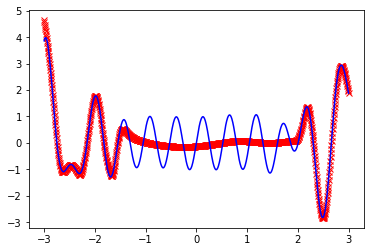

In [11]:
plt.plot(x_test,u_pred,'rx')
plt.plot(x_test,u_true,'b')

In [12]:
a = 0
for i in range(10):
    a = a + test_re_full[i][-1]
print(a/10)

0.3300222024753002
